# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRP_2025
except ImportError:
    print("RLSRP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import re
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk

RLSRP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRP_2025
threads = "8"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
experiment_alias = "E_GEUV_1_HG00327_3_M_120202_4"
fastq_file_base = "ERR188417"

notebook_out_dir = os.path.join(RLSRP_2025_dir, "data", "geuvadis_data_base", experiment_alias, "vk_count_out_w37_k41")
figures_out_dir = os.path.join(RLSRP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias)
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias, "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRP_2025_dir, "data", "geuvadis_data_base", experiment_alias)
fastq_files = [os.path.join(fastqs_dir, f"{fastq_file_base}_1.fastq.gz"), os.path.join(fastqs_dir, f"{fastq_file_base}_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# more settings for vk count if needed
reference_out_dir = os.path.join(RLSRP_2025_dir, "data", "reference")
reference_genome_index = os.path.join(reference_out_dir, "ensembl_grch37_release113", "index.idx")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
reference_genome_t2g = os.path.join(reference_out_dir, "ensembl_grch37_release113", "t2g.txt")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
geuvadis_reference_files_dir = os.path.join(reference_out_dir, "geuvadis")
seq_id_column = "transcript_ID"
var_column = "variant_cdna"
gene_id_column = "gene_name"
variants_usecols = [seq_id_column, var_column, gene_id_column]

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
quality_control_fastqs = True
qc_against_gene_matrix = False
mistake_ratio = 0.5
use_combined = True
modify_bam = True  # convert 256 flag to 0
min_counts = 2

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"
email = os.environ.get("EMAIL")

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
if "variant_count" in fp_df.columns and "vcrs_count" not in fp_df.columns:
    fp_df = fp_df.rename(columns={"variant_count": "vcrs_count"})
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

# fp_df = fp_df.set_index('variant_header')
fps = set(fp_df['variant_header'].tolist())
print(fps)
fp_df.head()

{'ENST00000293831:c.487T>G', 'ENST00000303305:c.1382T>C', 'ENST00000295685:c.1103G>A', 'ENST00000390301:c.194G>A', 'ENST00000390243:c.231A>T', 'ENST00000390319:c.100A>T', 'ENST00000275830:c.1494C>T', 'ENST00000381026:c.74A>G', 'ENST00000331825:c.729C>T', 'ENST00000374982:c.131G>A', 'ENST00000221784:c.207C>G', 'ENST00000349496:c.2455C>T', 'ENST00000470914:c.356C>T', 'ENST00000264258:c.814T>C', 'ENST00000390312:c.310A>G', 'ENST00000603600:c.205C>A', 'ENST00000261636:c.199A>G', 'ENST00000307961:c.1155A>G', 'ENST00000335895:c.370C>T', 'ENST00000394458:c.1757G>A', 'ENST00000390312:c.359T>C', 'ENST00000368045:c.128T>C', 'ENST00000262584:c.525A>G', 'ENST00000391857:c.136G>A', 'ENST00000605681:c.371T>G', 'ENST00000338110:c.1114C>T', 'ENST00000331825:c.255C>T', 'ENST00000260379:c.299G>C', 'ENST00000280154:c.1646G>A', 'ENST00000322203:c.354G>T', 'ENST00000248342:c.786T>C', 'ENST00000311111:c.314C>T', 'ENST00000084795:c.44C>T', 'ENST00000353801:c.636G>A', 'ENST00000262105:c.1418A>G', 'ENST0000038

,vcrs_count,variant_header_cds,variant_header,transcript_ID,gene,gene_count,genotype
index,,,,,,,
23436,8939.0,ENST00000390243.2:c.257A>G,ENST00000390243:c.432A>G,ENST00000390243,ENSG00000211598,43893.0,0.0
128071,171.0,ENST00000603600.1:c.205G>A,ENST00000603600:c.285G>A,ENST00000603600,None,NaN,0.0
74197,26.0,ENST00000275830.10:c.1465C>T,ENST00000275830:c.1494C>T,ENST00000275830,ENSG00000146918,2162.0,0.0
166295,24.0,ENST00000344063.2:c.100G>A,ENST00000344063:c.729G>A,ENST00000344063,ENSG00000108107,8909.0,0.0
23425,22.0,ENST00000390243.2:c.184T>G,ENST00000390243:c.359T>G,ENST00000390243,ENSG00000211598,43893.0,0.0


### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [8]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=False,
        quality_control_fastqs=True, cut_front=True, cut_tail=True,
        qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g, mistake_ratio=mistake_ratio,
        variants = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet"),
        seq_id_column=seq_id_column,
        var_column=var_column,
        gene_id_column=gene_id_column,
        variants_usecols=variants_usecols,
    )

In [9]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_on="variant_header", suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [10]:
fp_df.head()

,vcrs_count,variant_header_cds,variant_header,transcript_ID,gene,gene_count,genotype
index,,,,,,,
23436,8939.0,ENST00000390243.2:c.257A>G,ENST00000390243:c.432A>G,ENST00000390243,ENSG00000211598,43893.0,0.0
128071,171.0,ENST00000603600.1:c.205G>A,ENST00000603600:c.285G>A,ENST00000603600,None,NaN,0.0
74197,26.0,ENST00000275830.10:c.1465C>T,ENST00000275830:c.1494C>T,ENST00000275830,ENSG00000146918,2162.0,0.0
166295,24.0,ENST00000344063.2:c.100G>A,ENST00000344063:c.729G>A,ENST00000344063,ENSG00000108107,8909.0,0.0
23425,22.0,ENST00000390243.2:c.184T>G,ENST00000390243:c.359T>G,ENST00000390243,ENSG00000211598,43893.0,0.0


From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [11]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [12]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

13:14:15: Aligning to genome


13:32:07: SAM --> BAM


13:38:16: BAM sort


[bam_sort_core] merging from 26 files and 1 in-memory blocks...


13:47:34: Remove 256's


13:59:01: BAM index


13:59:29: Entering the loop


  0%|                                                                                                                             | 0/362 [00:00<?, ?it/s]

  0%|▎                                                                                                                    | 1/362 [00:01<10:09,  1.69s/it]

  1%|▋                                                                                                                    | 2/362 [00:03<09:11,  1.53s/it]

  1%|▉                                                                                                                    | 3/362 [00:03<06:53,  1.15s/it]

  1%|█▎                                                                                                                   | 4/362 [00:04<05:38,  1.06it/s]

  1%|█▌                                                                                                                   | 5/362 [00:05<05:35,  1.06it/s]

  2%|█▉                                                                                                                   | 6/362 [00:06<05:19,  1.11it/s]

  2%|██▎                                                                                                                  | 7/362 [00:07<06:16,  1.06s/it]

  2%|██▌                                                                                                                  | 8/362 [00:08<05:47,  1.02it/s]

  2%|██▉                                                                                                                  | 9/362 [00:09<05:22,  1.09it/s]

  3%|███▏                                                                                                                | 10/362 [00:09<04:48,  1.22it/s]

  3%|███▌                                                                                                                | 11/362 [00:10<04:31,  1.29it/s]

  3%|███▊                                                                                                                | 12/362 [00:11<04:24,  1.32it/s]

  4%|████▏                                                                                                               | 13/362 [00:12<04:50,  1.20it/s]

  4%|████▍                                                                                                               | 14/362 [00:12<04:28,  1.30it/s]

  4%|████▊                                                                                                               | 15/362 [00:13<04:09,  1.39it/s]

  4%|█████▏                                                                                                              | 16/362 [00:14<05:20,  1.08it/s]

  5%|█████▍                                                                                                              | 17/362 [00:15<04:50,  1.19it/s]

  5%|█████▊                                                                                                              | 18/362 [00:16<04:56,  1.16it/s]

  5%|██████                                                                                                              | 19/362 [00:16<04:30,  1.27it/s]

  6%|██████▍                                                                                                             | 20/362 [00:17<04:16,  1.33it/s]

  6%|██████▋                                                                                                             | 21/362 [00:18<04:13,  1.35it/s]

  6%|███████                                                                                                             | 22/362 [00:19<04:05,  1.38it/s]

  6%|███████▎                                                                                                            | 23/362 [00:19<04:27,  1.27it/s]

  7%|███████▋                                                                                                            | 24/362 [00:20<04:13,  1.34it/s]

  7%|████████                                                                                                            | 25/362 [00:21<04:44,  1.19it/s]

  7%|████████▎                                                                                                           | 26/362 [00:22<04:27,  1.26it/s]

  7%|████████▋                                                                                                           | 27/362 [00:22<04:03,  1.38it/s]

  8%|████████▉                                                                                                           | 28/362 [00:23<04:11,  1.33it/s]

  8%|█████████▎                                                                                                          | 29/362 [00:24<03:57,  1.40it/s]

  8%|█████████▌                                                                                                          | 30/362 [00:25<03:53,  1.42it/s]

  9%|█████████▉                                                                                                          | 31/362 [00:25<03:52,  1.42it/s]

  9%|██████████▎                                                                                                         | 32/362 [00:26<03:44,  1.47it/s]

  9%|██████████▌                                                                                                         | 33/362 [00:27<03:58,  1.38it/s]

  9%|██████████▉                                                                                                         | 34/362 [00:27<03:47,  1.44it/s]

 10%|███████████▏                                                                                                        | 35/362 [00:28<04:06,  1.32it/s]

 10%|███████████▌                                                                                                        | 36/362 [00:29<03:49,  1.42it/s]

 10%|███████████▊                                                                                                        | 37/362 [00:30<03:47,  1.43it/s]

 10%|████████████▏                                                                                                       | 38/362 [00:30<03:36,  1.50it/s]

 11%|████████████▍                                                                                                       | 39/362 [00:31<03:31,  1.53it/s]

 11%|████████████▊                                                                                                       | 40/362 [00:31<03:29,  1.54it/s]

 11%|█████████████▏                                                                                                      | 41/362 [00:32<03:48,  1.40it/s]

 12%|█████████████▍                                                                                                      | 42/362 [00:33<03:53,  1.37it/s]

 12%|█████████████▊                                                                                                      | 43/362 [00:34<04:10,  1.28it/s]

 12%|██████████████                                                                                                      | 44/362 [00:35<03:52,  1.37it/s]

 12%|██████████████▍                                                                                                     | 45/362 [00:35<03:59,  1.33it/s]

 13%|██████████████▋                                                                                                     | 46/362 [00:36<04:13,  1.25it/s]

 13%|███████████████                                                                                                     | 47/362 [00:37<04:12,  1.25it/s]

 13%|███████████████▍                                                                                                    | 48/362 [00:38<03:55,  1.33it/s]

 14%|███████████████▋                                                                                                    | 49/362 [00:38<04:00,  1.30it/s]

 14%|████████████████                                                                                                    | 50/362 [00:39<03:45,  1.39it/s]

 14%|████████████████▎                                                                                                   | 51/362 [00:40<03:31,  1.47it/s]

 14%|████████████████▋                                                                                                   | 52/362 [00:40<03:42,  1.39it/s]

 15%|████████████████▉                                                                                                   | 53/362 [00:41<03:29,  1.48it/s]

 15%|█████████████████▎                                                                                                  | 54/362 [00:42<04:01,  1.28it/s]

 15%|█████████████████▌                                                                                                  | 55/362 [00:43<03:43,  1.37it/s]

 15%|█████████████████▉                                                                                                  | 56/362 [00:43<03:28,  1.47it/s]

 16%|██████████████████▎                                                                                                 | 57/362 [00:44<03:41,  1.37it/s]

 16%|██████████████████▌                                                                                                 | 58/362 [00:45<03:32,  1.43it/s]

 16%|██████████████████▉                                                                                                 | 59/362 [00:45<03:22,  1.50it/s]

 17%|███████████████████▏                                                                                                | 60/362 [00:46<03:32,  1.42it/s]

 17%|███████████████████▌                                                                                                | 61/362 [00:47<03:22,  1.49it/s]

 17%|███████████████████▊                                                                                                | 62/362 [00:47<03:31,  1.42it/s]

 17%|████████████████████▏                                                                                               | 63/362 [00:48<03:37,  1.38it/s]

 18%|████████████████████▌                                                                                               | 64/362 [00:49<03:25,  1.45it/s]

 18%|████████████████████▊                                                                                               | 65/362 [00:50<04:23,  1.13it/s]

 18%|█████████████████████▏                                                                                              | 66/362 [00:51<04:30,  1.10it/s]

 19%|█████████████████████▍                                                                                              | 67/362 [00:52<04:12,  1.17it/s]

 19%|█████████████████████▊                                                                                              | 68/362 [00:52<03:47,  1.29it/s]

 19%|██████████████████████                                                                                              | 69/362 [00:53<03:53,  1.26it/s]

 19%|██████████████████████▍                                                                                             | 70/362 [00:54<03:34,  1.36it/s]

 20%|██████████████████████▊                                                                                             | 71/362 [00:55<03:21,  1.44it/s]

 20%|███████████████████████                                                                                             | 72/362 [00:55<03:18,  1.46it/s]

 20%|███████████████████████▍                                                                                            | 73/362 [00:56<03:10,  1.52it/s]

 20%|███████████████████████▋                                                                                            | 74/362 [00:56<03:13,  1.49it/s]

 21%|████████████████████████                                                                                            | 75/362 [00:57<03:08,  1.52it/s]

 21%|████████████████████████▎                                                                                           | 76/362 [00:58<03:03,  1.56it/s]

 21%|████████████████████████▋                                                                                           | 77/362 [00:59<03:51,  1.23it/s]

 22%|████████████████████████▉                                                                                           | 78/362 [01:00<03:34,  1.33it/s]

 22%|█████████████████████████▎                                                                                          | 79/362 [01:00<03:18,  1.43it/s]

 22%|█████████████████████████▋                                                                                          | 80/362 [01:01<03:11,  1.47it/s]

 22%|█████████████████████████▉                                                                                          | 81/362 [01:01<03:03,  1.53it/s]

 23%|██████████████████████████▎                                                                                         | 82/362 [01:02<02:59,  1.56it/s]

 23%|██████████████████████████▌                                                                                         | 83/362 [01:03<02:59,  1.55it/s]

 23%|██████████████████████████▉                                                                                         | 84/362 [01:03<03:06,  1.49it/s]

 23%|███████████████████████████▏                                                                                        | 85/362 [01:04<03:17,  1.40it/s]

 24%|███████████████████████████▌                                                                                        | 86/362 [01:05<03:06,  1.48it/s]

 24%|███████████████████████████▉                                                                                        | 87/362 [01:06<03:13,  1.42it/s]

 24%|████████████████████████████▏                                                                                       | 88/362 [01:06<03:04,  1.48it/s]

 25%|████████████████████████████▌                                                                                       | 89/362 [01:07<03:12,  1.42it/s]

 25%|████████████████████████████▊                                                                                       | 90/362 [01:08<03:03,  1.48it/s]

 25%|█████████████████████████████▏                                                                                      | 91/362 [01:08<02:57,  1.53it/s]

 25%|█████████████████████████████▍                                                                                      | 92/362 [01:09<02:49,  1.59it/s]

 26%|█████████████████████████████▊                                                                                      | 93/362 [01:10<03:06,  1.44it/s]

 26%|██████████████████████████████                                                                                      | 94/362 [01:10<02:59,  1.49it/s]

 26%|██████████████████████████████▍                                                                                     | 95/362 [01:11<03:14,  1.37it/s]

 27%|██████████████████████████████▊                                                                                     | 96/362 [01:12<03:57,  1.12it/s]

 27%|███████████████████████████████                                                                                     | 97/362 [01:13<03:32,  1.25it/s]

 27%|███████████████████████████████▍                                                                                    | 98/362 [01:13<03:15,  1.35it/s]

 27%|███████████████████████████████▋                                                                                    | 99/362 [01:14<03:03,  1.43it/s]

 28%|███████████████████████████████▊                                                                                   | 100/362 [01:15<03:00,  1.45it/s]

 28%|████████████████████████████████                                                                                   | 101/362 [01:15<02:51,  1.52it/s]

 28%|████████████████████████████████▍                                                                                  | 102/362 [01:16<02:47,  1.56it/s]

 28%|████████████████████████████████▋                                                                                  | 103/362 [01:17<02:45,  1.56it/s]

 29%|█████████████████████████████████                                                                                  | 104/362 [01:17<02:45,  1.56it/s]

 29%|█████████████████████████████████▎                                                                                 | 105/362 [01:18<02:44,  1.56it/s]

 29%|█████████████████████████████████▋                                                                                 | 106/362 [01:18<02:41,  1.58it/s]

 30%|█████████████████████████████████▉                                                                                 | 107/362 [01:20<03:36,  1.18it/s]

 30%|██████████████████████████████████▎                                                                                | 108/362 [01:20<03:17,  1.29it/s]

 30%|██████████████████████████████████▋                                                                                | 109/362 [01:21<03:07,  1.35it/s]

 30%|██████████████████████████████████▉                                                                                | 110/362 [01:22<03:07,  1.35it/s]

 31%|███████████████████████████████████▎                                                                               | 111/362 [01:23<03:07,  1.34it/s]

 31%|███████████████████████████████████▌                                                                               | 112/362 [01:23<02:55,  1.42it/s]

 31%|███████████████████████████████████▉                                                                               | 113/362 [01:24<02:47,  1.49it/s]

 31%|████████████████████████████████████▏                                                                              | 114/362 [01:25<03:25,  1.21it/s]

 32%|████████████████████████████████████▌                                                                              | 115/362 [01:26<03:28,  1.18it/s]

 32%|████████████████████████████████████▊                                                                              | 116/362 [01:26<03:09,  1.30it/s]

 32%|█████████████████████████████████████▏                                                                             | 117/362 [01:27<02:54,  1.40it/s]

 33%|█████████████████████████████████████▍                                                                             | 118/362 [01:28<03:32,  1.15it/s]

 33%|█████████████████████████████████████▊                                                                             | 119/362 [01:29<03:15,  1.24it/s]

 33%|██████████████████████████████████████                                                                             | 120/362 [01:30<03:03,  1.32it/s]

 33%|██████████████████████████████████████▍                                                                            | 121/362 [01:30<02:53,  1.39it/s]

 34%|██████████████████████████████████████▊                                                                            | 122/362 [01:31<02:46,  1.44it/s]

 34%|███████████████████████████████████████                                                                            | 123/362 [01:31<02:40,  1.49it/s]

 34%|███████████████████████████████████████▍                                                                           | 124/362 [01:32<02:32,  1.56it/s]

 35%|███████████████████████████████████████▋                                                                           | 125/362 [01:33<02:27,  1.60it/s]

 35%|████████████████████████████████████████                                                                           | 126/362 [01:33<02:28,  1.58it/s]

 35%|████████████████████████████████████████▎                                                                          | 127/362 [01:34<02:29,  1.57it/s]

 35%|████████████████████████████████████████▋                                                                          | 128/362 [01:35<02:26,  1.59it/s]

 36%|████████████████████████████████████████▉                                                                          | 129/362 [01:35<02:39,  1.46it/s]

 36%|█████████████████████████████████████████▎                                                                         | 130/362 [01:36<02:37,  1.47it/s]

 36%|█████████████████████████████████████████▌                                                                         | 131/362 [01:37<02:35,  1.49it/s]

 36%|█████████████████████████████████████████▉                                                                         | 132/362 [01:37<02:29,  1.53it/s]

 37%|██████████████████████████████████████████▎                                                                        | 133/362 [01:38<02:24,  1.58it/s]

 37%|██████████████████████████████████████████▌                                                                        | 134/362 [01:38<02:21,  1.62it/s]

 37%|██████████████████████████████████████████▉                                                                        | 135/362 [01:39<02:17,  1.65it/s]

 38%|███████████████████████████████████████████▏                                                                       | 136/362 [01:40<02:16,  1.65it/s]

 38%|███████████████████████████████████████████▌                                                                       | 137/362 [01:40<02:20,  1.60it/s]

 38%|███████████████████████████████████████████▊                                                                       | 138/362 [01:41<02:18,  1.62it/s]

 38%|████████████████████████████████████████████▏                                                                      | 139/362 [01:42<02:22,  1.56it/s]

 39%|████████████████████████████████████████████▍                                                                      | 140/362 [01:42<02:18,  1.61it/s]

 39%|████████████████████████████████████████████▊                                                                      | 141/362 [01:43<02:15,  1.63it/s]

 39%|█████████████████████████████████████████████                                                                      | 142/362 [01:44<02:23,  1.53it/s]

 40%|█████████████████████████████████████████████▍                                                                     | 143/362 [01:44<02:17,  1.59it/s]

 40%|█████████████████████████████████████████████▋                                                                     | 144/362 [01:45<02:18,  1.57it/s]

 40%|██████████████████████████████████████████████                                                                     | 145/362 [01:46<03:02,  1.19it/s]

 40%|██████████████████████████████████████████████▍                                                                    | 146/362 [01:47<02:45,  1.31it/s]

 41%|██████████████████████████████████████████████▋                                                                    | 147/362 [01:47<02:31,  1.42it/s]

 41%|███████████████████████████████████████████████                                                                    | 148/362 [01:48<02:22,  1.50it/s]

 41%|███████████████████████████████████████████████▎                                                                   | 149/362 [01:48<02:17,  1.55it/s]

 41%|███████████████████████████████████████████████▋                                                                   | 150/362 [01:49<02:14,  1.57it/s]

 42%|███████████████████████████████████████████████▉                                                                   | 151/362 [01:50<02:10,  1.62it/s]

 42%|████████████████████████████████████████████████▎                                                                  | 152/362 [01:50<02:14,  1.57it/s]

 42%|████████████████████████████████████████████████▌                                                                  | 153/362 [01:51<02:14,  1.55it/s]

 43%|████████████████████████████████████████████████▉                                                                  | 154/362 [01:52<02:11,  1.58it/s]

 43%|█████████████████████████████████████████████████▏                                                                 | 155/362 [01:52<02:28,  1.39it/s]

 43%|█████████████████████████████████████████████████▌                                                                 | 156/362 [01:53<02:21,  1.45it/s]

 43%|█████████████████████████████████████████████████▉                                                                 | 157/362 [01:54<02:15,  1.52it/s]

 44%|██████████████████████████████████████████████████▏                                                                | 158/362 [01:54<02:10,  1.57it/s]

 44%|██████████████████████████████████████████████████▌                                                                | 159/362 [01:55<02:05,  1.62it/s]

 44%|██████████████████████████████████████████████████▊                                                                | 160/362 [01:55<02:04,  1.62it/s]

 44%|███████████████████████████████████████████████████▏                                                               | 161/362 [01:56<02:16,  1.47it/s]

 45%|███████████████████████████████████████████████████▍                                                               | 162/362 [01:57<02:23,  1.39it/s]

 45%|███████████████████████████████████████████████████▊                                                               | 163/362 [01:58<02:14,  1.48it/s]

 45%|████████████████████████████████████████████████████                                                               | 164/362 [01:58<02:08,  1.54it/s]

 46%|████████████████████████████████████████████████████▍                                                              | 165/362 [01:59<02:08,  1.53it/s]

 46%|████████████████████████████████████████████████████▋                                                              | 166/362 [01:59<02:04,  1.58it/s]

 46%|█████████████████████████████████████████████████████                                                              | 167/362 [02:00<02:19,  1.40it/s]

 46%|█████████████████████████████████████████████████████▎                                                             | 168/362 [02:01<02:16,  1.43it/s]

 47%|█████████████████████████████████████████████████████▋                                                             | 169/362 [02:02<02:08,  1.50it/s]

 47%|██████████████████████████████████████████████████████                                                             | 170/362 [02:02<02:03,  1.56it/s]

 47%|██████████████████████████████████████████████████████▎                                                            | 171/362 [02:03<02:03,  1.55it/s]

 48%|██████████████████████████████████████████████████████▋                                                            | 172/362 [02:04<02:40,  1.18it/s]

 48%|██████████████████████████████████████████████████████▉                                                            | 173/362 [02:05<02:26,  1.29it/s]

 48%|███████████████████████████████████████████████████████▎                                                           | 174/362 [02:05<02:16,  1.38it/s]

 48%|███████████████████████████████████████████████████████▌                                                           | 175/362 [02:06<02:09,  1.44it/s]

 49%|███████████████████████████████████████████████████████▉                                                           | 176/362 [02:07<02:13,  1.40it/s]

 49%|████████████████████████████████████████████████████████▏                                                          | 177/362 [02:07<02:06,  1.47it/s]

 49%|████████████████████████████████████████████████████████▌                                                          | 178/362 [02:08<02:00,  1.53it/s]

 49%|████████████████████████████████████████████████████████▊                                                          | 179/362 [02:09<01:56,  1.57it/s]

 50%|█████████████████████████████████████████████████████████▏                                                         | 180/362 [02:09<01:53,  1.60it/s]

 50%|█████████████████████████████████████████████████████████▌                                                         | 181/362 [02:10<01:53,  1.59it/s]

 50%|█████████████████████████████████████████████████████████▊                                                         | 182/362 [02:10<01:54,  1.58it/s]

 51%|██████████████████████████████████████████████████████████▏                                                        | 183/362 [02:11<02:01,  1.47it/s]

 51%|██████████████████████████████████████████████████████████▍                                                        | 184/362 [02:12<01:58,  1.50it/s]

 51%|██████████████████████████████████████████████████████████▊                                                        | 185/362 [02:12<01:52,  1.57it/s]

 51%|███████████████████████████████████████████████████████████                                                        | 186/362 [02:13<02:00,  1.46it/s]

 52%|███████████████████████████████████████████████████████████▍                                                       | 187/362 [02:14<02:00,  1.45it/s]

 52%|███████████████████████████████████████████████████████████▋                                                       | 188/362 [02:15<02:05,  1.38it/s]

 52%|████████████████████████████████████████████████████████████                                                       | 189/362 [02:15<02:00,  1.44it/s]

 52%|████████████████████████████████████████████████████████████▎                                                      | 190/362 [02:16<01:55,  1.48it/s]

 53%|████████████████████████████████████████████████████████████▋                                                      | 191/362 [02:17<01:53,  1.51it/s]

 53%|████████████████████████████████████████████████████████████▉                                                      | 192/362 [02:17<01:48,  1.56it/s]

 53%|█████████████████████████████████████████████████████████████▎                                                     | 193/362 [02:18<01:49,  1.55it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                     | 194/362 [02:19<01:47,  1.56it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                     | 195/362 [02:19<01:53,  1.47it/s]

 54%|██████████████████████████████████████████████████████████████▎                                                    | 196/362 [02:20<01:53,  1.46it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 197/362 [02:21<01:48,  1.53it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                    | 198/362 [02:21<01:45,  1.56it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                   | 199/362 [02:22<01:41,  1.60it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                   | 200/362 [02:22<01:41,  1.60it/s]

 56%|███████████████████████████████████████████████████████████████▊                                                   | 201/362 [02:23<01:41,  1.59it/s]

 56%|████████████████████████████████████████████████████████████████▏                                                  | 202/362 [02:24<01:39,  1.61it/s]

 56%|████████████████████████████████████████████████████████████████▍                                                  | 203/362 [02:24<01:39,  1.59it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                  | 204/362 [02:25<01:39,  1.60it/s]

 57%|█████████████████████████████████████████████████████████████████                                                  | 205/362 [02:25<01:36,  1.62it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 206/362 [02:26<01:35,  1.63it/s]

 57%|█████████████████████████████████████████████████████████████████▊                                                 | 207/362 [02:27<01:35,  1.62it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 209/362 [02:27<01:12,  2.11it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                | 210/362 [02:28<01:31,  1.66it/s]

 58%|███████████████████████████████████████████████████████████████████                                                | 211/362 [02:29<01:30,  1.67it/s]

 59%|███████████████████████████████████████████████████████████████████▎                                               | 212/362 [02:30<01:29,  1.67it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                               | 213/362 [02:30<01:29,  1.67it/s]

 59%|███████████████████████████████████████████████████████████████████▉                                               | 214/362 [02:31<01:32,  1.61it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 215/362 [02:31<01:31,  1.61it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                              | 216/362 [02:32<01:29,  1.64it/s]

 60%|████████████████████████████████████████████████████████████████████▉                                              | 217/362 [02:33<01:31,  1.59it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                             | 218/362 [02:33<01:28,  1.63it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                             | 219/362 [02:34<01:25,  1.67it/s]

 61%|█████████████████████████████████████████████████████████████████████▉                                             | 220/362 [02:34<01:25,  1.67it/s]

 61%|██████████████████████████████████████████████████████████████████████▏                                            | 221/362 [02:35<01:34,  1.49it/s]

 61%|██████████████████████████████████████████████████████████████████████▌                                            | 222/362 [02:36<01:31,  1.53it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 223/362 [02:36<01:29,  1.56it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 224/362 [02:38<02:00,  1.14it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 225/362 [02:39<01:51,  1.23it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                           | 226/362 [02:39<01:44,  1.31it/s]

 63%|████████████████████████████████████████████████████████████████████████                                           | 227/362 [02:40<01:36,  1.40it/s]

 63%|████████████████████████████████████████████████████████████████████████▍                                          | 228/362 [02:40<01:31,  1.46it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                          | 229/362 [02:41<01:26,  1.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████                                          | 230/362 [02:42<01:25,  1.54it/s]

 64%|█████████████████████████████████████████████████████████████████████████▍                                         | 231/362 [02:42<01:22,  1.59it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 232/362 [02:43<01:21,  1.60it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                         | 233/362 [02:43<01:18,  1.64it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 234/362 [02:44<01:21,  1.57it/s]

 65%|██████████████████████████████████████████████████████████████████████████▋                                        | 235/362 [02:45<01:21,  1.56it/s]

 65%|██████████████████████████████████████████████████████████████████████████▉                                        | 236/362 [02:45<01:18,  1.61it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                       | 237/362 [02:46<01:16,  1.63it/s]

 66%|███████████████████████████████████████████████████████████████████████████▌                                       | 238/362 [02:47<01:16,  1.61it/s]

 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 239/362 [02:47<01:15,  1.63it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 240/362 [02:48<01:14,  1.63it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                      | 241/362 [02:48<01:15,  1.61it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                      | 242/362 [02:49<01:16,  1.57it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                     | 243/362 [02:50<01:13,  1.62it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                     | 244/362 [02:50<01:14,  1.58it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 245/362 [02:51<01:11,  1.63it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▏                                    | 246/362 [02:52<01:11,  1.63it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 247/362 [02:52<01:10,  1.64it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 248/362 [02:53<01:10,  1.62it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 249/362 [02:53<01:09,  1.62it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▍                                   | 250/362 [02:54<01:08,  1.63it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                   | 251/362 [02:55<01:19,  1.40it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                   | 252/362 [02:56<01:14,  1.47it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                  | 253/362 [02:56<01:10,  1.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                  | 254/362 [02:57<01:08,  1.58it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████                                  | 255/362 [02:58<01:29,  1.20it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                 | 256/362 [02:59<01:21,  1.30it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▋                                 | 257/362 [02:59<01:21,  1.29it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 258/362 [03:00<01:23,  1.25it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▎                                | 259/362 [03:01<01:16,  1.35it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 260/362 [03:02<01:12,  1.40it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                | 261/362 [03:02<01:10,  1.43it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                               | 262/362 [03:03<01:09,  1.43it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                               | 263/362 [03:04<01:07,  1.47it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▊                               | 264/362 [03:04<01:06,  1.48it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                              | 265/362 [03:05<01:18,  1.24it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▌                              | 266/362 [03:06<01:17,  1.23it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                              | 267/362 [03:07<01:10,  1.34it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▏                             | 268/362 [03:07<01:06,  1.41it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 269/362 [03:08<01:07,  1.38it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                             | 270/362 [03:09<01:13,  1.25it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████                             | 271/362 [03:10<01:13,  1.24it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 272/362 [03:11<01:09,  1.29it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                            | 273/362 [03:11<01:05,  1.37it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 274/362 [03:12<01:00,  1.45it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▎                           | 275/362 [03:12<00:58,  1.48it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 276/362 [03:13<00:59,  1.45it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▉                           | 277/362 [03:14<00:55,  1.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 278/362 [03:14<00:52,  1.59it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/362 [03:15<00:51,  1.60it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                          | 280/362 [03:16<00:51,  1.59it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 281/362 [03:17<01:06,  1.22it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▌                         | 282/362 [03:18<01:06,  1.20it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                         | 283/362 [03:19<01:07,  1.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 284/362 [03:19<01:02,  1.26it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 285/362 [03:20<00:56,  1.36it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 286/362 [03:20<00:52,  1.45it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 287/362 [03:21<00:51,  1.47it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 288/362 [03:22<00:48,  1.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▊                       | 289/362 [03:22<00:47,  1.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▏                      | 290/362 [03:23<00:45,  1.57it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 291/362 [03:24<00:44,  1.59it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                      | 292/362 [03:24<00:48,  1.46it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████                      | 293/362 [03:25<00:45,  1.51it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                     | 294/362 [03:26<00:44,  1.51it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                     | 295/362 [03:26<00:47,  1.41it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 296/362 [03:27<00:49,  1.33it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 297/362 [03:28<00:52,  1.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                    | 298/362 [03:29<00:48,  1.33it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                    | 299/362 [03:30<00:45,  1.39it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▎                   | 300/362 [03:30<00:42,  1.46it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▌                   | 301/362 [03:31<00:40,  1.51it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                   | 302/362 [03:31<00:38,  1.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 303/362 [03:32<00:38,  1.52it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 304/362 [03:33<00:36,  1.58it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 305/362 [03:33<00:35,  1.59it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 306/362 [03:34<00:35,  1.59it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 307/362 [03:34<00:34,  1.60it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 308/362 [03:35<00:34,  1.57it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                | 309/362 [03:36<00:33,  1.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                | 310/362 [03:36<00:32,  1.61it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 311/362 [03:37<00:30,  1.65it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 312/362 [03:38<00:31,  1.59it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍               | 313/362 [03:38<00:34,  1.43it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 314/362 [03:39<00:32,  1.49it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████               | 315/362 [03:40<00:33,  1.41it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 316/362 [03:40<00:31,  1.46it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 317/362 [03:41<00:30,  1.49it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████              | 318/362 [03:42<00:28,  1.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 319/362 [03:42<00:27,  1.57it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 320/362 [03:43<00:27,  1.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 321/362 [03:44<00:26,  1.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 322/362 [03:44<00:25,  1.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 323/362 [03:45<00:24,  1.60it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 324/362 [03:46<00:30,  1.24it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 325/362 [03:47<00:27,  1.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 326/362 [03:47<00:25,  1.40it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 327/362 [03:48<00:23,  1.47it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 328/362 [03:49<00:22,  1.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 329/362 [03:49<00:20,  1.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 330/362 [03:50<00:20,  1.57it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 331/362 [03:50<00:19,  1.57it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 332/362 [03:51<00:21,  1.38it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 333/362 [03:52<00:19,  1.46it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████         | 334/362 [03:53<00:18,  1.51it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 335/362 [03:54<00:23,  1.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 336/362 [03:55<00:25,  1.01it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████        | 337/362 [03:56<00:21,  1.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 338/362 [03:56<00:19,  1.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 339/362 [03:57<00:16,  1.36it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 340/362 [03:58<00:15,  1.42it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 341/362 [03:58<00:14,  1.40it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 342/362 [03:59<00:14,  1.42it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 343/362 [04:00<00:13,  1.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 344/362 [04:00<00:11,  1.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 345/362 [04:01<00:13,  1.30it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 346/362 [04:02<00:11,  1.34it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 347/362 [04:03<00:10,  1.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 348/362 [04:03<00:09,  1.47it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 349/362 [04:04<00:08,  1.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 350/362 [04:05<00:08,  1.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 351/362 [04:05<00:07,  1.49it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 352/362 [04:06<00:06,  1.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 353/362 [04:06<00:05,  1.57it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 354/362 [04:07<00:05,  1.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 355/362 [04:08<00:04,  1.51it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 356/362 [04:08<00:03,  1.57it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 357/362 [04:10<00:04,  1.19it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 358/362 [04:10<00:03,  1.30it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 359/362 [04:12<00:02,  1.08it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 360/362 [04:12<00:01,  1.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 361/362 [04:13<00:00,  1.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [04:13<00:00,  1.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [04:13<00:00,  1.43it/s]

In [13]:
!cat {overall_txt_out}

Number of true variants: 175
Number of false variants: 186
Number of undetermined variants: 0
True variants list: ['ENST00000390243:c.432A>G', 'ENST00000603600:c.285G>A', 'ENST00000275830:c.1494C>T', 'ENST00000390243:c.376A>C', 'ENST00000579721:c.142G>A', 'ENST00000390301:c.194G>A', 'ENST00000390237:c.67C>T', 'ENST00000084795:c.44C>T', 'ENST00000390237:c.249G>C', 'ENST00000420712:c.37C>T', 'ENST00000390243:c.388G>A', 'ENST00000360830:c.397T>G', 'ENST00000376802:c.576T>G', 'ENST00000563769:c.953G>A', 'ENST00000360830:c.187T>C', 'ENST00000390243:c.386A>G', 'ENST00000374550:c.384C>T', 'ENST00000390243:c.370A>G', 'ENST00000390237:c.19C>G', 'ENST00000390243:c.300A>G', 'ENST00000390243:c.354C>T', 'ENST00000380381:c.86C>T', 'ENST00000390243:c.398T>G', 'ENST00000400288:c.2279G>A', 'ENST00000289361:c.644G>A', 'ENST00000361390:c.390C>T', 'ENST00000262584:c.788G>A', 'ENST00000304921:c.599C>T', 'ENST00000374550:c.282A>G', 'ENST00000307961:c.1155A>G', 'ENST00000331789:c.1209G>C', 'ENST00000339647:c

In [14]:
# !cat {detailed_txt_out}

In [15]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_HG00327_3_M_120202_4/vk_count_out_w37_k41/overall_out_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_HG00327_3_M_120202_4/vk_count_out_w37_k41/detailed_out_modified_bam.txt


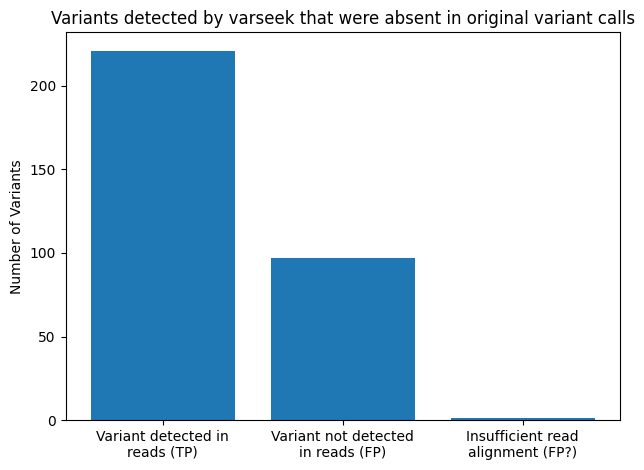

In [16]:
def plot_overall_bar_plot(overall_results, wrap_width = None, out_file=None, title = None):
    # Unpack keys and values
    labels = list(overall_results.keys())
    values = list(overall_results.values())

    if wrap_width:
        labels = ['\n'.join(textwrap.wrap(label, wrap_width)) for label in labels]

    # Create bar plot
    plt.bar(labels, values)
    plt.ylabel('Number of Variants')
    if title:
        plt.title(title)
    plt.tight_layout()
    if out_file:
        plt.savefig(out_file, dpi=300)
    plt.show()
    plt.close()

overall_results = {
    "Variant detected in reads (TP)": 221,
    "Variant not detected in reads (FP)": 97,
    "Insufficient read alignment (FP?)": 1,
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fp_bar_plot.pdf"), title = 'Variants detected by varseek that were absent in original variant calls')

In [17]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

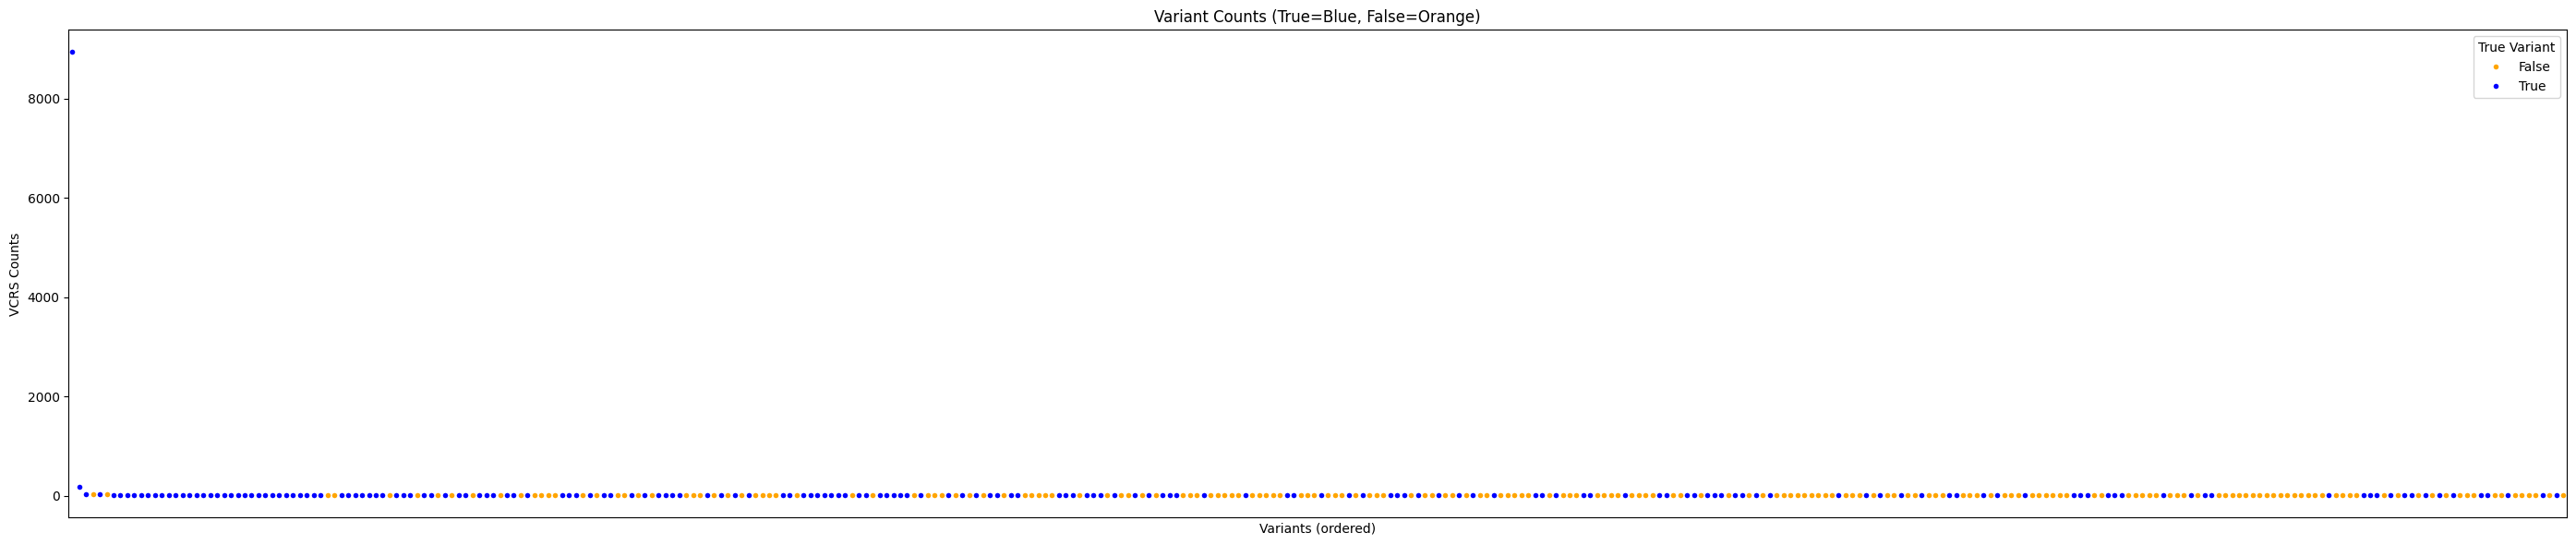

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [18]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Blue, False=Orange)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted.pdf"), dpi=300)
plt.show()
plt.close

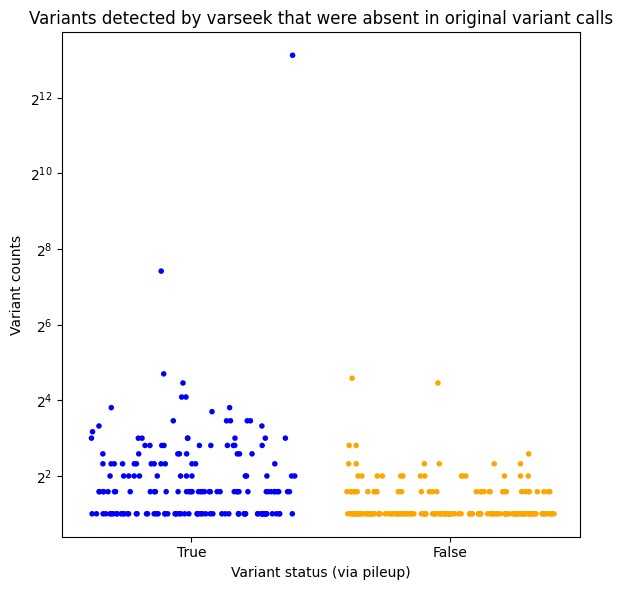

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))

# # Violin plot
# hgvs_df['true_variant_str'] = hgvs_df['true_variant'].astype(str)
# sns.violinplot(
#     data=hgvs_df,
#     x='true_variant_str',
#     y='vcrs_count',
#     palette={'True': "blue", 'False': "orange"},
#     width=0.5,
#     cut=0,  # Prevent tails from extending beyond data range
#     inner=None,  # Hide inner boxplot/sticks (optional)
#     scale='width'  # Makes area consistent
# )

# for violin in ax.collections:
#     violin.set_facecolor("lightgray")
#     violin.set_edgecolor("black")  # Optional: add black edge
#     violin.set_alpha(1)  # Optional: control transparency

# Strip plot on top
sns.stripplot(
    data=hgvs_df,
    x='true_variant',
    y='vcrs_count',
    hue='true_variant',
    order=[True, False],  # Enforce order
    hue_order=[True, False],  # Enforce order
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4
)

# Clean up
plt.xlabel('Variant status (via pileup)')
plt.ylabel('Variant counts')
plt.yscale("log", base=2)  # Apply log2 scaling
plt.title('Variants detected by varseek that were absent in original variant calls')
plt.legend([], [], frameon=False)  # Hide duplicate legend
plt.tight_layout()
plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted_stacked.pdf"), dpi=300)
plt.show()
plt.close()

Get the set of especially tricky gene names and save them to a file:

In [20]:
extra_tricky_fp_threshold = 6

enst_list = []
with open(detailed_txt_out, "r") as f:
    lines = f.readlines()

for i in range(len(lines) - 1):  # stop at len-1 to access next line safely
    line = lines[i].strip()
    next_line = lines[i + 1].strip()

    if not line.startswith("vcrs"):
        continue

    try:
        # Extract the reported count value (assumes '... | ... | ... | ... | ... | xxx reported counts')
        count_str = line.split("|")[-1].strip()
        count_value = float(count_str.split()[0])
    except Exception:
        continue  # skip lines that don't match format

    if count_value < extra_tricky_fp_threshold:
        break

    if next_line == "True variant: False":
        enst_field = line.split("|")[2].strip()
        enst_id = enst_field.split(":")[0]
        enst_list.append(enst_id)

t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number
extra_tricky_fp_genes = [t2g_dict.get(enst, enst) for enst in enst_list]
extra_tricky_fp_genes = set(extra_tricky_fp_genes)  # remove duplicates
extra_tricky_fp_genes_txt_out = os.path.join(notebook_out_dir, "extra_tricky_fp_genes.txt")
with open(extra_tricky_fp_genes_txt_out, "w") as f:
    for gene in extra_tricky_fp_genes:
        f.write(f"{gene}\n")

print(f"Extra tricky FP genes: {extra_tricky_fp_genes}")

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


Extra tricky FP genes: {'ENSG00000211673', 'ENSG00000211598', 'ENSG00000143947', 'ENSG00000108107', 'ENSG00000065978'}


### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [21]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [22]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [23]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [24]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [25]:
fn_txt_path = os.path.join(RLSRP_2025_dir, "data", f"geuvadis_analysis_supplement", experiment_alias, "fns.txt")
number_of_variants = None

detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_modified_bam.txt")

In [26]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [27]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [28]:
hgvs_df.head()

,dbsnp_id,transcript_ID,variant_cdna,strand,header_cdna,is_false_negative,vcrs_id
0,rs3829740,ENST00000379407,c.1385G>C,+,ENST00000379407:c.1385G>C,True,vcrs_0
1,rs7418389,ENST00000355826,c.253T>C,+,ENST00000355826:c.253T>C,True,vcrs_1
2,rs2229110,ENST00000378585,c.413T>C,+,ENST00000378585:c.413T>C,True,vcrs_2
3,rs12184,ENST00000378567,c.425T>C,+,ENST00000378567:c.425T>C,True,vcrs_3
4,rs1878745,ENST00000378567,c.479A>G,+,ENST00000378567:c.479A>G,True,vcrs_4


In [29]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

14:03:56: Entering the loop


  0%|                                                                                                                            | 0/3271 [00:00<?, ?it/s]

  0%|                                                                                                                  | 1/3271 [00:01<1:00:06,  1.10s/it]

  0%|                                                                                                                    | 2/3271 [00:01<44:34,  1.22it/s]

  0%|                                                                                                                    | 3/3271 [00:02<38:43,  1.41it/s]

  0%|▏                                                                                                                   | 4/3271 [00:02<35:47,  1.52it/s]

  0%|▏                                                                                                                   | 5/3271 [00:03<34:19,  1.59it/s]

  0%|▏                                                                                                                   | 6/3271 [00:04<33:01,  1.65it/s]

  0%|▏                                                                                                                   | 7/3271 [00:04<32:27,  1.68it/s]

  0%|▎                                                                                                                   | 8/3271 [00:05<32:07,  1.69it/s]

  0%|▎                                                                                                                   | 9/3271 [00:05<31:44,  1.71it/s]

  0%|▎                                                                                                                  | 10/3271 [00:06<32:07,  1.69it/s]

  0%|▍                                                                                                                  | 11/3271 [00:06<31:36,  1.72it/s]

  0%|▍                                                                                                                  | 12/3271 [00:07<32:39,  1.66it/s]

  0%|▍                                                                                                                  | 13/3271 [00:08<32:06,  1.69it/s]

  0%|▍                                                                                                                  | 14/3271 [00:08<31:57,  1.70it/s]

  0%|▌                                                                                                                  | 15/3271 [00:09<33:33,  1.62it/s]

  0%|▌                                                                                                                  | 16/3271 [00:09<32:41,  1.66it/s]

  1%|▌                                                                                                                  | 17/3271 [00:10<32:39,  1.66it/s]

  1%|▋                                                                                                                  | 18/3271 [00:11<32:02,  1.69it/s]

  1%|▋                                                                                                                  | 19/3271 [00:11<32:11,  1.68it/s]

  1%|▋                                                                                                                  | 20/3271 [00:12<32:03,  1.69it/s]

  1%|▋                                                                                                                  | 21/3271 [00:12<32:34,  1.66it/s]

  1%|▊                                                                                                                  | 22/3271 [00:13<32:04,  1.69it/s]

  1%|▊                                                                                                                  | 23/3271 [00:14<31:34,  1.71it/s]

  1%|▊                                                                                                                  | 24/3271 [00:14<31:18,  1.73it/s]

  1%|▉                                                                                                                  | 25/3271 [00:15<31:46,  1.70it/s]

  1%|▉                                                                                                                  | 26/3271 [00:15<31:25,  1.72it/s]

  1%|▉                                                                                                                  | 27/3271 [00:16<31:17,  1.73it/s]

  1%|▉                                                                                                                  | 28/3271 [00:16<30:59,  1.74it/s]

  1%|█                                                                                                                  | 29/3271 [00:17<32:02,  1.69it/s]

  1%|█                                                                                                                  | 30/3271 [00:18<31:32,  1.71it/s]

  1%|█                                                                                                                  | 31/3271 [00:18<31:18,  1.73it/s]

  1%|█▏                                                                                                                 | 32/3271 [00:19<33:33,  1.61it/s]

  1%|█▏                                                                                                                 | 33/3271 [00:20<32:41,  1.65it/s]

  1%|█▏                                                                                                                 | 34/3271 [00:20<33:28,  1.61it/s]

  1%|█▏                                                                                                                 | 35/3271 [00:21<37:24,  1.44it/s]

  1%|█▎                                                                                                                 | 36/3271 [00:22<35:15,  1.53it/s]

  1%|█▎                                                                                                                 | 37/3271 [00:22<33:46,  1.60it/s]

  1%|█▎                                                                                                                 | 38/3271 [00:23<34:28,  1.56it/s]

  1%|█▎                                                                                                                 | 39/3271 [00:24<41:01,  1.31it/s]

  1%|█▍                                                                                                                 | 40/3271 [00:24<37:51,  1.42it/s]

  1%|█▍                                                                                                                 | 41/3271 [00:25<35:47,  1.50it/s]

  1%|█▍                                                                                                                 | 42/3271 [00:26<34:50,  1.54it/s]

  1%|█▌                                                                                                                 | 43/3271 [00:26<33:51,  1.59it/s]

  1%|█▌                                                                                                                 | 44/3271 [00:27<32:42,  1.64it/s]

  1%|█▌                                                                                                                 | 45/3271 [00:27<31:57,  1.68it/s]

  1%|█▌                                                                                                                 | 46/3271 [00:28<31:24,  1.71it/s]

  1%|█▋                                                                                                                 | 47/3271 [00:28<30:59,  1.73it/s]

  1%|█▋                                                                                                                 | 48/3271 [00:29<31:01,  1.73it/s]

  1%|█▋                                                                                                                 | 49/3271 [00:30<31:05,  1.73it/s]

  2%|█▊                                                                                                                 | 50/3271 [00:30<31:00,  1.73it/s]

  2%|█▊                                                                                                                 | 51/3271 [00:31<31:41,  1.69it/s]

  2%|█▊                                                                                                                 | 52/3271 [00:31<31:33,  1.70it/s]

  2%|█▊                                                                                                                 | 53/3271 [00:32<32:08,  1.67it/s]

  2%|█▉                                                                                                                 | 54/3271 [00:33<31:47,  1.69it/s]

  2%|█▉                                                                                                                 | 55/3271 [00:33<31:25,  1.71it/s]

  2%|█▉                                                                                                                 | 56/3271 [00:34<31:56,  1.68it/s]

  2%|██                                                                                                                 | 57/3271 [00:34<31:26,  1.70it/s]

  2%|██                                                                                                                 | 58/3271 [00:35<32:22,  1.65it/s]

  2%|██                                                                                                                 | 59/3271 [00:36<32:02,  1.67it/s]

  2%|██                                                                                                                 | 60/3271 [00:36<31:19,  1.71it/s]

  2%|██▏                                                                                                                | 61/3271 [00:37<31:17,  1.71it/s]

  2%|██▏                                                                                                                | 62/3271 [00:37<32:23,  1.65it/s]

  2%|██▏                                                                                                                | 63/3271 [00:38<31:46,  1.68it/s]

  2%|██▎                                                                                                                | 64/3271 [00:39<32:04,  1.67it/s]

  2%|██▎                                                                                                                | 66/3271 [00:39<24:24,  2.19it/s]

  2%|██▎                                                                                                                | 67/3271 [00:40<26:29,  2.02it/s]

  2%|██▍                                                                                                                | 68/3271 [00:40<27:34,  1.94it/s]

  2%|██▍                                                                                                                | 69/3271 [00:41<28:45,  1.86it/s]

  2%|██▍                                                                                                                | 71/3271 [00:41<22:54,  2.33it/s]

  2%|██▌                                                                                                                | 72/3271 [00:42<24:52,  2.14it/s]

  2%|██▌                                                                                                                | 73/3271 [00:43<26:26,  2.02it/s]

  2%|██▌                                                                                                                | 74/3271 [00:43<28:01,  1.90it/s]

  2%|██▋                                                                                                                | 75/3271 [00:44<29:08,  1.83it/s]

  2%|██▋                                                                                                                | 76/3271 [00:44<29:46,  1.79it/s]

  2%|██▋                                                                                                                | 77/3271 [00:45<31:13,  1.71it/s]

  2%|██▋                                                                                                                | 78/3271 [00:46<40:15,  1.32it/s]

  2%|██▊                                                                                                                | 80/3271 [00:47<29:23,  1.81it/s]

  2%|██▊                                                                                                                | 81/3271 [00:48<30:26,  1.75it/s]

  3%|██▉                                                                                                                | 82/3271 [00:48<30:21,  1.75it/s]

  3%|██▉                                                                                                                | 83/3271 [00:49<30:52,  1.72it/s]

  3%|██▉                                                                                                                | 84/3271 [00:49<30:56,  1.72it/s]

  3%|██▉                                                                                                                | 85/3271 [00:50<32:04,  1.66it/s]

  3%|███                                                                                                                | 86/3271 [00:51<31:39,  1.68it/s]

  3%|███                                                                                                                | 87/3271 [00:51<31:49,  1.67it/s]

  3%|███                                                                                                                | 88/3271 [00:52<31:28,  1.69it/s]

  3%|███▏                                                                                                               | 89/3271 [00:52<31:23,  1.69it/s]

  3%|███▏                                                                                                               | 90/3271 [00:53<30:54,  1.71it/s]

  3%|███▏                                                                                                               | 91/3271 [00:53<31:17,  1.69it/s]

  3%|███▏                                                                                                               | 92/3271 [00:54<32:17,  1.64it/s]

  3%|███▎                                                                                                               | 93/3271 [00:55<31:51,  1.66it/s]

  3%|███▎                                                                                                               | 94/3271 [00:55<31:25,  1.69it/s]

  3%|███▎                                                                                                               | 95/3271 [00:56<30:54,  1.71it/s]

  3%|███▍                                                                                                               | 96/3271 [00:56<30:50,  1.72it/s]

  3%|███▍                                                                                                               | 97/3271 [00:57<30:30,  1.73it/s]

  3%|███▍                                                                                                               | 98/3271 [00:58<30:14,  1.75it/s]

  3%|███▍                                                                                                               | 99/3271 [00:58<30:11,  1.75it/s]

  3%|███▍                                                                                                              | 100/3271 [00:59<30:09,  1.75it/s]

  3%|███▌                                                                                                              | 101/3271 [00:59<30:26,  1.74it/s]

  3%|███▌                                                                                                              | 102/3271 [01:00<30:55,  1.71it/s]

  3%|███▌                                                                                                              | 103/3271 [01:01<37:48,  1.40it/s]

  3%|███▌                                                                                                              | 104/3271 [01:02<36:25,  1.45it/s]

  3%|███▋                                                                                                              | 106/3271 [01:02<27:03,  1.95it/s]

  3%|███▋                                                                                                              | 107/3271 [01:03<31:06,  1.70it/s]

  3%|███▊                                                                                                              | 108/3271 [01:04<32:14,  1.64it/s]

  3%|███▊                                                                                                              | 109/3271 [01:04<32:44,  1.61it/s]

  3%|███▊                                                                                                              | 110/3271 [01:05<32:14,  1.63it/s]

  3%|███▊                                                                                                              | 111/3271 [01:05<31:33,  1.67it/s]

  3%|███▉                                                                                                              | 112/3271 [01:06<33:52,  1.55it/s]

  3%|███▉                                                                                                              | 113/3271 [01:07<32:38,  1.61it/s]

  3%|███▉                                                                                                              | 114/3271 [01:07<33:37,  1.56it/s]

  4%|████                                                                                                              | 115/3271 [01:08<32:41,  1.61it/s]

  4%|████                                                                                                              | 116/3271 [01:09<32:45,  1.61it/s]

  4%|████                                                                                                              | 117/3271 [01:09<32:09,  1.63it/s]

  4%|████                                                                                                              | 118/3271 [01:10<33:04,  1.59it/s]

  4%|████▏                                                                                                             | 119/3271 [01:11<32:50,  1.60it/s]

  4%|████▏                                                                                                             | 120/3271 [01:11<32:12,  1.63it/s]

  4%|████▏                                                                                                             | 121/3271 [01:12<31:24,  1.67it/s]

  4%|████▎                                                                                                             | 122/3271 [01:12<31:13,  1.68it/s]

  4%|████▎                                                                                                             | 123/3271 [01:13<30:56,  1.70it/s]

  4%|████▎                                                                                                             | 124/3271 [01:13<30:50,  1.70it/s]

  4%|████▎                                                                                                             | 125/3271 [01:14<30:42,  1.71it/s]

  4%|████▍                                                                                                             | 126/3271 [01:15<30:19,  1.73it/s]

  4%|████▍                                                                                                             | 127/3271 [01:15<31:43,  1.65it/s]

  4%|████▍                                                                                                             | 128/3271 [01:16<31:29,  1.66it/s]

  4%|████▍                                                                                                             | 129/3271 [01:16<31:16,  1.67it/s]

  4%|████▌                                                                                                             | 131/3271 [01:17<23:50,  2.20it/s]

  4%|████▌                                                                                                             | 132/3271 [01:18<25:52,  2.02it/s]

  4%|████▋                                                                                                             | 133/3271 [01:18<27:21,  1.91it/s]

  4%|████▋                                                                                                             | 134/3271 [01:19<28:22,  1.84it/s]

  4%|████▋                                                                                                             | 135/3271 [01:19<28:43,  1.82it/s]

  4%|████▋                                                                                                             | 136/3271 [01:20<28:55,  1.81it/s]

  4%|████▊                                                                                                             | 137/3271 [01:21<29:01,  1.80it/s]

  4%|████▊                                                                                                             | 138/3271 [01:21<33:43,  1.55it/s]

  4%|████▉                                                                                                             | 140/3271 [01:23<33:39,  1.55it/s]

  4%|████▉                                                                                                             | 141/3271 [01:24<42:16,  1.23it/s]

  4%|████▉                                                                                                             | 142/3271 [01:25<47:45,  1.09it/s]

  4%|████▉                                                                                                             | 143/3271 [01:26<51:28,  1.01it/s]

  4%|█████                                                                                                             | 144/3271 [01:28<57:36,  1.11s/it]

  4%|█████                                                                                                             | 145/3271 [01:29<59:16,  1.14s/it]

  4%|████▉                                                                                                           | 146/3271 [01:30<1:03:33,  1.22s/it]

  4%|█████                                                                                                           | 147/3271 [01:32<1:04:10,  1.23s/it]

  5%|█████▏                                                                                                            | 149/3271 [01:33<45:24,  1.15it/s]

  5%|█████▏                                                                                                            | 150/3271 [01:33<42:07,  1.23it/s]

  5%|█████▎                                                                                                            | 151/3271 [01:34<41:00,  1.27it/s]

  5%|█████▎                                                                                                            | 152/3271 [01:34<38:00,  1.37it/s]

  5%|█████▎                                                                                                            | 153/3271 [01:35<38:11,  1.36it/s]

  5%|█████▎                                                                                                            | 154/3271 [01:36<35:42,  1.45it/s]

  5%|█████▍                                                                                                            | 155/3271 [01:36<33:51,  1.53it/s]

  5%|█████▍                                                                                                            | 156/3271 [01:37<33:04,  1.57it/s]

  5%|█████▍                                                                                                            | 157/3271 [01:38<32:48,  1.58it/s]

  5%|█████▌                                                                                                            | 158/3271 [01:38<31:46,  1.63it/s]

  5%|█████▌                                                                                                            | 159/3271 [01:39<30:54,  1.68it/s]

  5%|█████▌                                                                                                            | 160/3271 [01:39<30:28,  1.70it/s]

  5%|█████▌                                                                                                            | 161/3271 [01:40<31:10,  1.66it/s]

  5%|█████▋                                                                                                            | 162/3271 [01:40<30:49,  1.68it/s]

  5%|█████▋                                                                                                            | 163/3271 [01:41<31:13,  1.66it/s]

  5%|█████▋                                                                                                            | 164/3271 [01:42<31:17,  1.66it/s]

  5%|█████▊                                                                                                            | 165/3271 [01:42<31:44,  1.63it/s]

  5%|█████▊                                                                                                            | 166/3271 [01:43<31:16,  1.65it/s]

  5%|█████▊                                                                                                            | 167/3271 [01:44<31:09,  1.66it/s]

  5%|█████▊                                                                                                            | 168/3271 [01:44<30:51,  1.68it/s]

  5%|█████▉                                                                                                            | 169/3271 [01:45<30:49,  1.68it/s]

  5%|█████▉                                                                                                            | 170/3271 [01:45<30:22,  1.70it/s]

  5%|█████▉                                                                                                            | 171/3271 [01:46<30:25,  1.70it/s]

  5%|█████▉                                                                                                            | 172/3271 [01:47<32:12,  1.60it/s]

  5%|██████                                                                                                            | 173/3271 [01:47<31:46,  1.63it/s]

  5%|██████                                                                                                            | 174/3271 [01:48<31:26,  1.64it/s]

  5%|██████                                                                                                            | 175/3271 [01:48<31:13,  1.65it/s]

  5%|██████▏                                                                                                           | 176/3271 [01:49<30:50,  1.67it/s]

  5%|██████▏                                                                                                           | 177/3271 [01:50<30:32,  1.69it/s]

  5%|██████▏                                                                                                           | 178/3271 [01:50<30:04,  1.71it/s]

  5%|██████▏                                                                                                           | 179/3271 [01:51<30:00,  1.72it/s]

  6%|██████▎                                                                                                           | 180/3271 [01:51<30:10,  1.71it/s]

  6%|██████▎                                                                                                           | 181/3271 [01:52<29:59,  1.72it/s]

  6%|██████▎                                                                                                           | 182/3271 [01:52<29:49,  1.73it/s]

  6%|██████▍                                                                                                           | 183/3271 [01:53<30:00,  1.71it/s]

  6%|██████▍                                                                                                           | 184/3271 [01:54<29:54,  1.72it/s]

  6%|██████▍                                                                                                           | 185/3271 [01:54<29:52,  1.72it/s]

  6%|██████▍                                                                                                           | 186/3271 [01:55<29:41,  1.73it/s]

  6%|██████▌                                                                                                           | 188/3271 [01:55<22:41,  2.26it/s]

  6%|██████▌                                                                                                           | 189/3271 [01:56<24:36,  2.09it/s]

  6%|██████▌                                                                                                           | 190/3271 [01:56<25:39,  2.00it/s]

  6%|██████▋                                                                                                           | 191/3271 [01:57<26:44,  1.92it/s]

  6%|██████▋                                                                                                           | 192/3271 [01:58<27:45,  1.85it/s]

  6%|██████▋                                                                                                           | 193/3271 [01:58<28:15,  1.82it/s]

  6%|██████▊                                                                                                           | 194/3271 [01:59<28:28,  1.80it/s]

  6%|██████▊                                                                                                           | 195/3271 [01:59<28:40,  1.79it/s]

  6%|██████▊                                                                                                           | 196/3271 [02:00<29:05,  1.76it/s]

  6%|██████▊                                                                                                           | 197/3271 [02:00<29:01,  1.76it/s]

  6%|██████▉                                                                                                           | 198/3271 [02:01<28:57,  1.77it/s]

  6%|██████▉                                                                                                           | 199/3271 [02:02<28:50,  1.77it/s]

  6%|██████▉                                                                                                           | 200/3271 [02:02<29:29,  1.74it/s]

  6%|███████                                                                                                           | 201/3271 [02:03<30:02,  1.70it/s]

  6%|███████                                                                                                           | 202/3271 [02:03<29:52,  1.71it/s]

  6%|███████                                                                                                           | 203/3271 [02:04<29:58,  1.71it/s]

  6%|███████                                                                                                           | 204/3271 [02:05<30:02,  1.70it/s]

  6%|███████▏                                                                                                          | 205/3271 [02:05<29:48,  1.71it/s]

  6%|███████▏                                                                                                          | 206/3271 [02:06<29:33,  1.73it/s]

  6%|███████▏                                                                                                          | 207/3271 [02:06<30:12,  1.69it/s]

  6%|███████▏                                                                                                          | 208/3271 [02:07<30:34,  1.67it/s]

  6%|███████▎                                                                                                          | 209/3271 [02:08<30:15,  1.69it/s]

  6%|███████▎                                                                                                          | 210/3271 [02:08<29:53,  1.71it/s]

  6%|███████▎                                                                                                          | 211/3271 [02:09<29:42,  1.72it/s]

  7%|███████▍                                                                                                          | 213/3271 [02:09<22:55,  2.22it/s]

  7%|███████▍                                                                                                          | 214/3271 [02:10<24:27,  2.08it/s]

  7%|███████▍                                                                                                          | 215/3271 [02:10<25:50,  1.97it/s]

  7%|███████▌                                                                                                          | 216/3271 [02:11<26:43,  1.90it/s]

  7%|███████▌                                                                                                          | 217/3271 [02:12<27:54,  1.82it/s]

  7%|███████▌                                                                                                          | 218/3271 [02:12<28:48,  1.77it/s]

  7%|███████▋                                                                                                          | 219/3271 [02:13<29:25,  1.73it/s]

  7%|███████▋                                                                                                          | 221/3271 [02:13<22:40,  2.24it/s]

  7%|███████▋                                                                                                          | 222/3271 [02:14<24:16,  2.09it/s]

  7%|███████▊                                                                                                          | 223/3271 [02:15<28:43,  1.77it/s]

  7%|███████▊                                                                                                          | 224/3271 [02:15<28:52,  1.76it/s]

  7%|███████▊                                                                                                          | 225/3271 [02:16<29:02,  1.75it/s]

  7%|███████▉                                                                                                          | 226/3271 [02:17<28:50,  1.76it/s]

  7%|███████▉                                                                                                          | 227/3271 [02:17<28:49,  1.76it/s]

  7%|███████▉                                                                                                          | 228/3271 [02:18<28:46,  1.76it/s]

  7%|███████▉                                                                                                          | 229/3271 [02:18<28:44,  1.76it/s]

  7%|████████                                                                                                          | 230/3271 [02:19<28:45,  1.76it/s]

  7%|████████                                                                                                          | 231/3271 [02:19<28:42,  1.76it/s]

  7%|████████                                                                                                          | 232/3271 [02:20<29:28,  1.72it/s]

  7%|████████                                                                                                          | 233/3271 [02:21<30:00,  1.69it/s]

  7%|████████▏                                                                                                         | 234/3271 [02:21<29:57,  1.69it/s]

  7%|████████▏                                                                                                         | 235/3271 [02:22<29:50,  1.70it/s]

  7%|████████▏                                                                                                         | 236/3271 [02:22<29:28,  1.72it/s]

  7%|████████▎                                                                                                         | 237/3271 [02:23<29:19,  1.72it/s]

  7%|████████▎                                                                                                         | 238/3271 [02:23<29:09,  1.73it/s]

  7%|████████▎                                                                                                         | 239/3271 [02:24<29:06,  1.74it/s]

  7%|████████▎                                                                                                         | 240/3271 [02:25<29:04,  1.74it/s]

  7%|████████▍                                                                                                         | 241/3271 [02:25<28:59,  1.74it/s]

  7%|████████▍                                                                                                         | 242/3271 [02:26<28:41,  1.76it/s]

  7%|████████▍                                                                                                         | 243/3271 [02:26<28:45,  1.76it/s]

  7%|████████▌                                                                                                         | 244/3271 [02:27<28:34,  1.77it/s]

  7%|████████▌                                                                                                         | 245/3271 [02:27<28:37,  1.76it/s]

  8%|████████▌                                                                                                         | 246/3271 [02:28<28:34,  1.76it/s]

  8%|████████▌                                                                                                         | 247/3271 [02:29<31:45,  1.59it/s]

  8%|████████▋                                                                                                         | 248/3271 [02:29<30:44,  1.64it/s]

  8%|████████▋                                                                                                         | 249/3271 [02:30<32:18,  1.56it/s]

  8%|████████▋                                                                                                         | 250/3271 [02:31<31:18,  1.61it/s]

  8%|████████▋                                                                                                         | 251/3271 [02:31<30:37,  1.64it/s]

  8%|████████▊                                                                                                         | 252/3271 [02:32<30:17,  1.66it/s]

  8%|████████▊                                                                                                         | 253/3271 [02:32<29:37,  1.70it/s]

  8%|████████▊                                                                                                         | 254/3271 [02:33<29:16,  1.72it/s]

  8%|████████▉                                                                                                         | 255/3271 [02:33<29:03,  1.73it/s]

  8%|████████▉                                                                                                         | 256/3271 [02:34<28:51,  1.74it/s]

  8%|████████▉                                                                                                         | 257/3271 [02:35<29:01,  1.73it/s]

  8%|████████▉                                                                                                         | 258/3271 [02:35<28:57,  1.73it/s]

  8%|█████████                                                                                                         | 259/3271 [02:36<28:51,  1.74it/s]

  8%|█████████                                                                                                         | 260/3271 [02:36<28:38,  1.75it/s]

  8%|█████████                                                                                                         | 261/3271 [02:37<28:45,  1.74it/s]

  8%|█████████▏                                                                                                        | 262/3271 [02:38<29:40,  1.69it/s]

  8%|█████████▏                                                                                                        | 263/3271 [02:38<29:47,  1.68it/s]

  8%|█████████▏                                                                                                        | 264/3271 [02:39<29:33,  1.70it/s]

  8%|█████████▏                                                                                                        | 265/3271 [02:39<29:05,  1.72it/s]

  8%|█████████▎                                                                                                        | 266/3271 [02:40<28:49,  1.74it/s]

  8%|█████████▎                                                                                                        | 267/3271 [02:40<28:53,  1.73it/s]

  8%|█████████▎                                                                                                        | 268/3271 [02:41<29:04,  1.72it/s]

  8%|█████████▍                                                                                                        | 269/3271 [02:42<28:46,  1.74it/s]

  8%|█████████▍                                                                                                        | 270/3271 [02:42<28:45,  1.74it/s]

  8%|█████████▍                                                                                                        | 271/3271 [02:43<28:36,  1.75it/s]

  8%|█████████▍                                                                                                        | 272/3271 [02:43<28:41,  1.74it/s]

  8%|█████████▌                                                                                                        | 273/3271 [02:44<29:12,  1.71it/s]

  8%|█████████▌                                                                                                        | 274/3271 [02:45<39:03,  1.28it/s]

  8%|█████████▌                                                                                                        | 275/3271 [02:46<45:35,  1.10it/s]

  8%|█████████▌                                                                                                        | 276/3271 [02:47<40:33,  1.23it/s]

  8%|█████████▋                                                                                                        | 277/3271 [02:48<36:58,  1.35it/s]

  8%|█████████▋                                                                                                        | 278/3271 [02:48<34:43,  1.44it/s]

  9%|█████████▋                                                                                                        | 279/3271 [02:49<32:42,  1.52it/s]

  9%|█████████▊                                                                                                        | 280/3271 [02:49<31:45,  1.57it/s]

  9%|█████████▊                                                                                                        | 281/3271 [02:50<30:59,  1.61it/s]

  9%|█████████▊                                                                                                        | 282/3271 [02:50<30:12,  1.65it/s]

  9%|█████████▊                                                                                                        | 283/3271 [02:51<29:35,  1.68it/s]

  9%|█████████▉                                                                                                        | 284/3271 [02:52<29:37,  1.68it/s]

  9%|█████████▉                                                                                                        | 286/3271 [02:52<22:37,  2.20it/s]

  9%|██████████                                                                                                        | 287/3271 [02:53<25:03,  1.99it/s]

  9%|██████████                                                                                                        | 288/3271 [02:53<25:54,  1.92it/s]

  9%|██████████                                                                                                        | 289/3271 [02:54<26:35,  1.87it/s]

  9%|██████████                                                                                                        | 290/3271 [02:55<27:06,  1.83it/s]

  9%|██████████▏                                                                                                       | 291/3271 [02:55<27:30,  1.81it/s]

  9%|██████████▏                                                                                                       | 292/3271 [02:56<27:41,  1.79it/s]

  9%|██████████▏                                                                                                       | 294/3271 [02:56<22:19,  2.22it/s]

  9%|██████████▎                                                                                                       | 295/3271 [02:57<24:35,  2.02it/s]

  9%|██████████▎                                                                                                       | 296/3271 [02:58<25:27,  1.95it/s]

  9%|██████████▎                                                                                                       | 297/3271 [02:58<26:12,  1.89it/s]

  9%|██████████▍                                                                                                       | 298/3271 [02:59<26:40,  1.86it/s]

  9%|██████████▍                                                                                                       | 299/3271 [02:59<27:17,  1.81it/s]

  9%|██████████▍                                                                                                       | 300/3271 [03:00<27:58,  1.77it/s]

  9%|██████████▍                                                                                                       | 301/3271 [03:00<28:29,  1.74it/s]

  9%|██████████▌                                                                                                       | 302/3271 [03:01<29:40,  1.67it/s]

  9%|██████████▌                                                                                                       | 303/3271 [03:02<33:38,  1.47it/s]

  9%|██████████▌                                                                                                       | 304/3271 [03:03<32:09,  1.54it/s]

  9%|██████████▋                                                                                                       | 305/3271 [03:03<31:01,  1.59it/s]

  9%|██████████▋                                                                                                       | 306/3271 [03:04<30:44,  1.61it/s]

  9%|██████████▋                                                                                                       | 308/3271 [03:04<23:24,  2.11it/s]

  9%|██████████▊                                                                                                       | 309/3271 [03:05<25:01,  1.97it/s]

  9%|██████████▊                                                                                                       | 310/3271 [03:06<26:48,  1.84it/s]

 10%|██████████▊                                                                                                       | 312/3271 [03:06<21:47,  2.26it/s]

 10%|██████████▉                                                                                                       | 313/3271 [03:07<23:11,  2.13it/s]

 10%|██████████▉                                                                                                       | 314/3271 [03:07<24:33,  2.01it/s]

 10%|██████████▉                                                                                                       | 315/3271 [03:08<25:53,  1.90it/s]

 10%|███████████                                                                                                       | 316/3271 [03:09<27:06,  1.82it/s]

 10%|███████████                                                                                                       | 317/3271 [03:09<27:20,  1.80it/s]

 10%|███████████                                                                                                       | 318/3271 [03:10<27:27,  1.79it/s]

 10%|███████████                                                                                                       | 319/3271 [03:10<27:57,  1.76it/s]

 10%|███████████▏                                                                                                      | 320/3271 [03:11<27:53,  1.76it/s]

 10%|███████████▏                                                                                                      | 321/3271 [03:11<27:53,  1.76it/s]

 10%|███████████▏                                                                                                      | 322/3271 [03:12<27:44,  1.77it/s]

 10%|███████████▎                                                                                                      | 323/3271 [03:13<27:39,  1.78it/s]

 10%|███████████▎                                                                                                      | 324/3271 [03:13<27:43,  1.77it/s]

 10%|███████████▎                                                                                                      | 325/3271 [03:14<27:38,  1.78it/s]

 10%|███████████▎                                                                                                      | 326/3271 [03:14<27:34,  1.78it/s]

 10%|███████████▍                                                                                                      | 328/3271 [03:15<21:33,  2.28it/s]

 10%|███████████▍                                                                                                      | 329/3271 [03:15<23:03,  2.13it/s]

 10%|███████████▌                                                                                                      | 331/3271 [03:16<21:13,  2.31it/s]

 10%|███████████▌                                                                                                      | 332/3271 [03:17<23:08,  2.12it/s]

 10%|███████████▋                                                                                                      | 335/3271 [03:17<16:12,  3.02it/s]

 10%|███████████▋                                                                                                      | 336/3271 [03:18<18:46,  2.61it/s]

 10%|███████████▋                                                                                                      | 337/3271 [03:19<21:15,  2.30it/s]

 10%|███████████▊                                                                                                      | 338/3271 [03:19<22:58,  2.13it/s]

 10%|███████████▊                                                                                                      | 339/3271 [03:20<24:11,  2.02it/s]

 10%|███████████▊                                                                                                      | 340/3271 [03:20<25:20,  1.93it/s]

 10%|███████████▉                                                                                                      | 341/3271 [03:21<26:38,  1.83it/s]

 10%|███████████▉                                                                                                      | 342/3271 [03:22<30:24,  1.60it/s]

 10%|███████████▉                                                                                                      | 343/3271 [03:22<30:14,  1.61it/s]

 11%|███████████▉                                                                                                      | 344/3271 [03:23<29:49,  1.64it/s]

 11%|████████████                                                                                                      | 345/3271 [03:24<29:19,  1.66it/s]

 11%|████████████                                                                                                      | 346/3271 [03:24<31:12,  1.56it/s]

 11%|████████████                                                                                                      | 347/3271 [03:25<31:03,  1.57it/s]

 11%|████████████▏                                                                                                     | 348/3271 [03:25<29:54,  1.63it/s]

 11%|████████████▏                                                                                                     | 350/3271 [03:26<22:27,  2.17it/s]

 11%|████████████▏                                                                                                     | 351/3271 [03:27<23:42,  2.05it/s]

 11%|████████████▎                                                                                                     | 352/3271 [03:27<24:41,  1.97it/s]

 11%|████████████▎                                                                                                     | 353/3271 [03:28<25:25,  1.91it/s]

 11%|████████████▎                                                                                                     | 354/3271 [03:28<26:00,  1.87it/s]

 11%|████████████▎                                                                                                     | 355/3271 [03:29<26:53,  1.81it/s]

 11%|████████████▍                                                                                                     | 356/3271 [03:29<27:59,  1.74it/s]

 11%|████████████▍                                                                                                     | 357/3271 [03:30<27:47,  1.75it/s]

 11%|████████████▍                                                                                                     | 358/3271 [03:31<27:40,  1.75it/s]

 11%|████████████▌                                                                                                     | 359/3271 [03:31<27:59,  1.73it/s]

 11%|████████████▌                                                                                                     | 360/3271 [03:32<28:21,  1.71it/s]

 11%|████████████▌                                                                                                     | 361/3271 [03:32<28:36,  1.70it/s]

 11%|████████████▌                                                                                                     | 362/3271 [03:33<28:50,  1.68it/s]

 11%|████████████▋                                                                                                     | 363/3271 [03:34<28:28,  1.70it/s]

 11%|████████████▋                                                                                                     | 364/3271 [03:34<28:13,  1.72it/s]

 11%|████████████▋                                                                                                     | 365/3271 [03:35<28:10,  1.72it/s]

 11%|████████████▊                                                                                                     | 366/3271 [03:35<28:12,  1.72it/s]

 11%|████████████▊                                                                                                     | 367/3271 [03:36<28:16,  1.71it/s]

 11%|████████████▊                                                                                                     | 368/3271 [03:36<28:02,  1.73it/s]

 11%|████████████▊                                                                                                     | 369/3271 [03:37<28:19,  1.71it/s]

 11%|████████████▉                                                                                                     | 370/3271 [03:38<28:26,  1.70it/s]

 11%|████████████▉                                                                                                     | 371/3271 [03:38<28:14,  1.71it/s]

 11%|████████████▉                                                                                                     | 372/3271 [03:39<28:42,  1.68it/s]

 11%|████████████▉                                                                                                     | 373/3271 [03:40<39:47,  1.21it/s]

 11%|█████████████                                                                                                     | 374/3271 [03:41<45:13,  1.07it/s]

 11%|█████████████                                                                                                     | 375/3271 [03:43<48:32,  1.01s/it]

 11%|█████████████                                                                                                     | 376/3271 [03:44<50:58,  1.06s/it]

 12%|█████████████▏                                                                                                    | 377/3271 [03:44<44:00,  1.10it/s]

 12%|█████████████▏                                                                                                    | 379/3271 [03:45<30:33,  1.58it/s]

 12%|█████████████▏                                                                                                    | 380/3271 [03:46<30:08,  1.60it/s]

 12%|█████████████▎                                                                                                    | 381/3271 [03:46<29:25,  1.64it/s]

 12%|█████████████▎                                                                                                    | 382/3271 [03:47<28:58,  1.66it/s]

 12%|█████████████▎                                                                                                    | 383/3271 [03:47<28:24,  1.69it/s]

 12%|█████████████▍                                                                                                    | 384/3271 [03:48<29:25,  1.63it/s]

 12%|█████████████▍                                                                                                    | 385/3271 [03:49<29:04,  1.65it/s]

 12%|█████████████▍                                                                                                    | 386/3271 [03:49<28:55,  1.66it/s]

 12%|█████████████▍                                                                                                    | 387/3271 [03:50<28:32,  1.68it/s]

 12%|█████████████▌                                                                                                    | 388/3271 [03:50<28:04,  1.71it/s]

 12%|█████████████▌                                                                                                    | 389/3271 [03:51<28:03,  1.71it/s]

 12%|█████████████▌                                                                                                    | 390/3271 [03:51<27:52,  1.72it/s]

 12%|█████████████▋                                                                                                    | 391/3271 [03:52<27:59,  1.71it/s]

 12%|█████████████▋                                                                                                    | 392/3271 [03:53<28:13,  1.70it/s]

 12%|█████████████▋                                                                                                    | 393/3271 [03:53<27:57,  1.72it/s]

 12%|█████████████▋                                                                                                    | 394/3271 [03:54<28:02,  1.71it/s]

 12%|█████████████▊                                                                                                    | 395/3271 [03:54<27:43,  1.73it/s]

 12%|█████████████▊                                                                                                    | 396/3271 [03:55<28:08,  1.70it/s]

 12%|█████████████▊                                                                                                    | 397/3271 [03:56<27:54,  1.72it/s]

 12%|█████████████▊                                                                                                    | 398/3271 [03:56<28:00,  1.71it/s]

 12%|█████████████▉                                                                                                    | 399/3271 [03:57<28:37,  1.67it/s]

 12%|█████████████▉                                                                                                    | 400/3271 [03:57<28:40,  1.67it/s]

 12%|█████████████▉                                                                                                    | 401/3271 [03:58<28:34,  1.67it/s]

 12%|██████████████                                                                                                    | 402/3271 [03:58<28:10,  1.70it/s]

 12%|██████████████                                                                                                    | 403/3271 [03:59<27:52,  1.71it/s]

 12%|██████████████                                                                                                    | 404/3271 [04:00<27:30,  1.74it/s]

 12%|██████████████                                                                                                    | 405/3271 [04:00<27:15,  1.75it/s]

 12%|██████████████▏                                                                                                   | 406/3271 [04:01<27:49,  1.72it/s]

 12%|██████████████▏                                                                                                   | 407/3271 [04:01<27:29,  1.74it/s]

 12%|██████████████▏                                                                                                   | 408/3271 [04:02<28:25,  1.68it/s]

 13%|██████████████▎                                                                                                   | 409/3271 [04:03<28:03,  1.70it/s]

 13%|██████████████▎                                                                                                   | 410/3271 [04:03<27:52,  1.71it/s]

 13%|██████████████▎                                                                                                   | 411/3271 [04:04<28:12,  1.69it/s]

 13%|██████████████▎                                                                                                   | 412/3271 [04:04<28:04,  1.70it/s]

 13%|██████████████▍                                                                                                   | 413/3271 [04:05<28:24,  1.68it/s]

 13%|██████████████▍                                                                                                   | 414/3271 [04:06<27:55,  1.71it/s]

 13%|██████████████▍                                                                                                   | 415/3271 [04:06<27:38,  1.72it/s]

 13%|██████████████▍                                                                                                   | 416/3271 [04:07<27:21,  1.74it/s]

 13%|██████████████▌                                                                                                   | 417/3271 [04:07<27:16,  1.74it/s]

 13%|██████████████▌                                                                                                   | 419/3271 [04:08<20:59,  2.26it/s]

 13%|██████████████▋                                                                                                   | 420/3271 [04:08<22:33,  2.11it/s]

 13%|██████████████▋                                                                                                   | 421/3271 [04:09<24:17,  1.96it/s]

 13%|██████████████▋                                                                                                   | 422/3271 [04:10<33:48,  1.40it/s]

 13%|██████████████▋                                                                                                   | 423/3271 [04:11<32:15,  1.47it/s]

 13%|██████████████▊                                                                                                   | 424/3271 [04:11<32:16,  1.47it/s]

 13%|██████████████▊                                                                                                   | 425/3271 [04:12<30:54,  1.53it/s]

 13%|██████████████▊                                                                                                   | 426/3271 [04:13<29:48,  1.59it/s]

 13%|██████████████▉                                                                                                   | 427/3271 [04:13<29:12,  1.62it/s]

 13%|██████████████▉                                                                                                   | 428/3271 [04:14<28:53,  1.64it/s]

 13%|██████████████▉                                                                                                   | 429/3271 [04:15<37:17,  1.27it/s]

 13%|██████████████▉                                                                                                   | 430/3271 [04:16<34:10,  1.39it/s]

 13%|███████████████                                                                                                   | 431/3271 [04:16<32:03,  1.48it/s]

 13%|███████████████                                                                                                   | 432/3271 [04:17<30:33,  1.55it/s]

 13%|███████████████                                                                                                   | 433/3271 [04:17<29:22,  1.61it/s]

 13%|███████████████▏                                                                                                  | 434/3271 [04:18<29:17,  1.61it/s]

 13%|███████████████▏                                                                                                  | 435/3271 [04:18<28:25,  1.66it/s]

 13%|███████████████▏                                                                                                  | 436/3271 [04:19<28:08,  1.68it/s]

 13%|███████████████▏                                                                                                  | 437/3271 [04:20<27:38,  1.71it/s]

 13%|███████████████▎                                                                                                  | 438/3271 [04:20<27:25,  1.72it/s]

 13%|███████████████▎                                                                                                  | 439/3271 [04:21<27:25,  1.72it/s]

 13%|███████████████▎                                                                                                  | 440/3271 [04:21<27:45,  1.70it/s]

 13%|███████████████▎                                                                                                  | 441/3271 [04:22<27:55,  1.69it/s]

 14%|███████████████▍                                                                                                  | 442/3271 [04:23<27:34,  1.71it/s]

 14%|███████████████▍                                                                                                  | 443/3271 [04:23<28:41,  1.64it/s]

 14%|███████████████▍                                                                                                  | 444/3271 [04:24<28:18,  1.66it/s]

 14%|███████████████▌                                                                                                  | 445/3271 [04:24<27:51,  1.69it/s]

 14%|███████████████▌                                                                                                  | 446/3271 [04:25<27:32,  1.71it/s]

 14%|███████████████▌                                                                                                  | 447/3271 [04:26<27:16,  1.73it/s]

 14%|███████████████▌                                                                                                  | 448/3271 [04:26<26:57,  1.75it/s]

 14%|███████████████▋                                                                                                  | 449/3271 [04:27<26:44,  1.76it/s]

 14%|███████████████▋                                                                                                  | 450/3271 [04:27<26:42,  1.76it/s]

 14%|███████████████▋                                                                                                  | 451/3271 [04:28<26:50,  1.75it/s]

 14%|███████████████▊                                                                                                  | 452/3271 [04:28<26:47,  1.75it/s]

 14%|███████████████▊                                                                                                  | 453/3271 [04:29<26:58,  1.74it/s]

 14%|███████████████▊                                                                                                  | 454/3271 [04:29<26:53,  1.75it/s]

 14%|███████████████▊                                                                                                  | 455/3271 [04:30<26:47,  1.75it/s]

 14%|███████████████▉                                                                                                  | 456/3271 [04:31<27:36,  1.70it/s]

 14%|███████████████▉                                                                                                  | 457/3271 [04:31<28:04,  1.67it/s]

 14%|███████████████▉                                                                                                  | 458/3271 [04:32<27:45,  1.69it/s]

 14%|███████████████▉                                                                                                  | 459/3271 [04:32<27:28,  1.71it/s]

 14%|████████████████                                                                                                  | 460/3271 [04:33<27:07,  1.73it/s]

 14%|████████████████                                                                                                  | 461/3271 [04:34<26:57,  1.74it/s]

 14%|████████████████                                                                                                  | 462/3271 [04:34<26:59,  1.73it/s]

 14%|████████████████▏                                                                                                 | 463/3271 [04:35<27:22,  1.71it/s]

 14%|████████████████▏                                                                                                 | 464/3271 [04:35<27:55,  1.68it/s]

 14%|████████████████▏                                                                                                 | 465/3271 [04:36<27:34,  1.70it/s]

 14%|████████████████▎                                                                                                 | 467/3271 [04:37<21:14,  2.20it/s]

 14%|████████████████▎                                                                                                 | 468/3271 [04:37<22:33,  2.07it/s]

 14%|████████████████▎                                                                                                 | 469/3271 [04:38<23:33,  1.98it/s]

 14%|████████████████▍                                                                                                 | 470/3271 [04:38<24:19,  1.92it/s]

 14%|████████████████▍                                                                                                 | 471/3271 [04:39<24:53,  1.87it/s]

 14%|████████████████▍                                                                                                 | 472/3271 [04:39<25:20,  1.84it/s]

 14%|████████████████▍                                                                                                 | 473/3271 [04:40<25:34,  1.82it/s]

 14%|████████████████▌                                                                                                 | 474/3271 [04:41<25:59,  1.79it/s]

 15%|████████████████▌                                                                                                 | 475/3271 [04:41<26:03,  1.79it/s]

 15%|████████████████▌                                                                                                 | 476/3271 [04:42<26:36,  1.75it/s]

 15%|████████████████▌                                                                                                 | 477/3271 [04:42<26:25,  1.76it/s]

 15%|████████████████▋                                                                                                 | 478/3271 [04:43<26:37,  1.75it/s]

 15%|████████████████▋                                                                                                 | 479/3271 [04:43<26:27,  1.76it/s]

 15%|████████████████▋                                                                                                 | 480/3271 [04:44<26:21,  1.76it/s]

 15%|████████████████▊                                                                                                 | 481/3271 [04:45<27:09,  1.71it/s]

 15%|████████████████▊                                                                                                 | 482/3271 [04:45<27:27,  1.69it/s]

 15%|████████████████▊                                                                                                 | 483/3271 [04:46<27:28,  1.69it/s]

 15%|████████████████▊                                                                                                 | 484/3271 [04:46<27:25,  1.69it/s]

 15%|████████████████▉                                                                                                 | 485/3271 [04:47<27:38,  1.68it/s]

 15%|████████████████▉                                                                                                 | 486/3271 [04:48<27:19,  1.70it/s]

 15%|████████████████▉                                                                                                 | 487/3271 [04:48<26:59,  1.72it/s]

 15%|█████████████████                                                                                                 | 488/3271 [04:49<26:53,  1.72it/s]

 15%|█████████████████                                                                                                 | 489/3271 [04:49<26:48,  1.73it/s]

 15%|█████████████████                                                                                                 | 490/3271 [04:50<27:41,  1.67it/s]

 15%|█████████████████                                                                                                 | 491/3271 [04:51<27:49,  1.66it/s]

 15%|█████████████████▏                                                                                                | 492/3271 [04:51<27:19,  1.70it/s]

 15%|█████████████████▏                                                                                                | 493/3271 [04:52<27:03,  1.71it/s]

 15%|█████████████████▏                                                                                                | 494/3271 [04:52<26:44,  1.73it/s]

 15%|█████████████████▎                                                                                                | 495/3271 [04:53<26:44,  1.73it/s]

 15%|█████████████████▎                                                                                                | 496/3271 [04:53<26:39,  1.74it/s]

 15%|█████████████████▎                                                                                                | 497/3271 [04:54<27:23,  1.69it/s]

 15%|█████████████████▎                                                                                                | 498/3271 [04:55<28:01,  1.65it/s]

 15%|█████████████████▍                                                                                                | 499/3271 [04:55<27:22,  1.69it/s]

 15%|█████████████████▍                                                                                                | 500/3271 [04:56<27:03,  1.71it/s]

 15%|█████████████████▍                                                                                                | 501/3271 [04:56<26:47,  1.72it/s]

 15%|█████████████████▍                                                                                                | 502/3271 [04:57<26:36,  1.73it/s]

 15%|█████████████████▌                                                                                                | 503/3271 [04:57<26:36,  1.73it/s]

 15%|█████████████████▌                                                                                                | 504/3271 [04:58<27:03,  1.70it/s]

 15%|█████████████████▌                                                                                                | 505/3271 [04:59<27:23,  1.68it/s]

 15%|█████████████████▋                                                                                                | 506/3271 [04:59<27:13,  1.69it/s]

 15%|█████████████████▋                                                                                                | 507/3271 [05:00<27:44,  1.66it/s]

 16%|█████████████████▋                                                                                                | 508/3271 [05:00<27:21,  1.68it/s]

 16%|█████████████████▋                                                                                                | 509/3271 [05:01<27:05,  1.70it/s]

 16%|█████████████████▊                                                                                                | 510/3271 [05:02<26:56,  1.71it/s]

 16%|█████████████████▊                                                                                                | 511/3271 [05:02<26:41,  1.72it/s]

 16%|█████████████████▊                                                                                                | 512/3271 [05:03<27:07,  1.69it/s]

 16%|█████████████████▉                                                                                                | 513/3271 [05:03<27:30,  1.67it/s]

 16%|█████████████████▉                                                                                                | 514/3271 [05:04<27:10,  1.69it/s]

 16%|█████████████████▉                                                                                                | 515/3271 [05:05<26:49,  1.71it/s]

 16%|█████████████████▉                                                                                                | 516/3271 [05:05<26:38,  1.72it/s]

 16%|██████████████████                                                                                                | 517/3271 [05:06<26:29,  1.73it/s]

 16%|██████████████████                                                                                                | 518/3271 [05:06<26:20,  1.74it/s]

 16%|██████████████████                                                                                                | 519/3271 [05:07<26:13,  1.75it/s]

 16%|██████████████████                                                                                                | 520/3271 [05:07<26:07,  1.75it/s]

 16%|██████████████████▏                                                                                               | 521/3271 [05:08<26:02,  1.76it/s]

 16%|██████████████████▏                                                                                               | 522/3271 [05:09<25:56,  1.77it/s]

 16%|██████████████████▏                                                                                               | 523/3271 [05:09<25:51,  1.77it/s]

 16%|██████████████████▎                                                                                               | 524/3271 [05:10<26:27,  1.73it/s]

 16%|██████████████████▎                                                                                               | 525/3271 [05:10<26:38,  1.72it/s]

 16%|██████████████████▎                                                                                               | 526/3271 [05:11<26:31,  1.72it/s]

 16%|██████████████████▎                                                                                               | 527/3271 [05:11<26:40,  1.71it/s]

 16%|██████████████████▍                                                                                               | 528/3271 [05:12<26:52,  1.70it/s]

 16%|██████████████████▍                                                                                               | 529/3271 [05:13<26:31,  1.72it/s]

 16%|██████████████████▍                                                                                               | 530/3271 [05:13<26:25,  1.73it/s]

 16%|██████████████████▌                                                                                               | 531/3271 [05:14<26:42,  1.71it/s]

 16%|██████████████████▌                                                                                               | 532/3271 [05:14<26:52,  1.70it/s]

 16%|██████████████████▌                                                                                               | 533/3271 [05:15<26:58,  1.69it/s]

 16%|██████████████████▌                                                                                               | 534/3271 [05:16<26:38,  1.71it/s]

 16%|██████████████████▋                                                                                               | 535/3271 [05:16<26:21,  1.73it/s]

 16%|██████████████████▋                                                                                               | 536/3271 [05:17<26:35,  1.71it/s]

 16%|██████████████████▋                                                                                               | 537/3271 [05:17<26:42,  1.71it/s]

 16%|██████████████████▊                                                                                               | 538/3271 [05:18<26:30,  1.72it/s]

 16%|██████████████████▊                                                                                               | 539/3271 [05:19<36:37,  1.24it/s]

 17%|██████████████████▊                                                                                               | 540/3271 [05:20<41:38,  1.09it/s]

 17%|██████████████████▊                                                                                               | 541/3271 [05:22<45:08,  1.01it/s]

 17%|██████████████████▉                                                                                               | 542/3271 [05:23<47:21,  1.04s/it]

 17%|██████████████████▉                                                                                               | 543/3271 [05:24<49:56,  1.10s/it]

 17%|██████████████████▉                                                                                               | 544/3271 [05:25<51:12,  1.13s/it]

 17%|██████████████████▉                                                                                               | 545/3271 [05:26<51:37,  1.14s/it]

 17%|███████████████████                                                                                               | 546/3271 [05:27<51:54,  1.14s/it]

 17%|███████████████████                                                                                               | 547/3271 [05:29<52:35,  1.16s/it]

 17%|███████████████████                                                                                               | 548/3271 [05:30<53:34,  1.18s/it]

 17%|███████████████████▏                                                                                              | 549/3271 [05:31<53:21,  1.18s/it]

 17%|███████████████████▏                                                                                              | 550/3271 [05:32<53:36,  1.18s/it]

 17%|███████████████████▏                                                                                              | 551/3271 [05:33<53:39,  1.18s/it]

 17%|███████████████████▏                                                                                              | 552/3271 [05:34<45:59,  1.01s/it]

 17%|███████████████████▎                                                                                              | 553/3271 [05:35<40:12,  1.13it/s]

 17%|███████████████████▎                                                                                              | 554/3271 [05:35<36:00,  1.26it/s]

 17%|███████████████████▎                                                                                              | 555/3271 [05:36<33:23,  1.36it/s]

 17%|███████████████████▍                                                                                              | 556/3271 [05:36<31:22,  1.44it/s]

 17%|███████████████████▍                                                                                              | 557/3271 [05:37<30:15,  1.49it/s]

 17%|███████████████████▍                                                                                              | 558/3271 [05:38<28:52,  1.57it/s]

 17%|███████████████████▍                                                                                              | 559/3271 [05:38<28:01,  1.61it/s]

 17%|███████████████████▌                                                                                              | 562/3271 [05:39<17:03,  2.65it/s]

 17%|███████████████████▌                                                                                              | 563/3271 [05:39<18:49,  2.40it/s]

 17%|███████████████████▋                                                                                              | 564/3271 [05:41<27:15,  1.66it/s]

 17%|███████████████████▋                                                                                              | 565/3271 [05:41<26:52,  1.68it/s]

 17%|███████████████████▊                                                                                              | 567/3271 [05:42<23:43,  1.90it/s]

 17%|███████████████████▊                                                                                              | 568/3271 [05:43<24:06,  1.87it/s]

 17%|███████████████████▊                                                                                              | 570/3271 [05:43<19:38,  2.29it/s]

 17%|███████████████████▉                                                                                              | 571/3271 [05:44<20:55,  2.15it/s]

 17%|███████████████████▉                                                                                              | 572/3271 [05:44<22:14,  2.02it/s]

 18%|███████████████████▉                                                                                              | 573/3271 [05:45<23:05,  1.95it/s]

 18%|████████████████████                                                                                              | 575/3271 [05:45<18:46,  2.39it/s]

 18%|████████████████████                                                                                              | 577/3271 [05:46<16:36,  2.70it/s]

 18%|████████████████████▏                                                                                             | 578/3271 [05:47<18:24,  2.44it/s]

 18%|████████████████████▏                                                                                             | 579/3271 [05:47<20:04,  2.24it/s]

 18%|████████████████████▏                                                                                             | 580/3271 [05:48<22:00,  2.04it/s]

 18%|████████████████████▏                                                                                             | 581/3271 [05:48<23:24,  1.92it/s]

 18%|████████████████████▎                                                                                             | 582/3271 [05:49<24:25,  1.83it/s]

 18%|████████████████████▎                                                                                             | 583/3271 [05:50<24:49,  1.80it/s]

 18%|████████████████████▎                                                                                             | 584/3271 [05:50<25:09,  1.78it/s]

 18%|████████████████████▍                                                                                             | 585/3271 [05:51<25:07,  1.78it/s]

 18%|████████████████████▍                                                                                             | 586/3271 [05:51<25:10,  1.78it/s]

 18%|████████████████████▍                                                                                             | 587/3271 [05:52<25:38,  1.74it/s]

 18%|████████████████████▍                                                                                             | 588/3271 [05:52<25:33,  1.75it/s]

 18%|████████████████████▌                                                                                             | 589/3271 [05:53<26:07,  1.71it/s]

 18%|████████████████████▌                                                                                             | 590/3271 [05:54<26:12,  1.70it/s]

 18%|████████████████████▌                                                                                             | 591/3271 [05:54<25:59,  1.72it/s]

 18%|████████████████████▋                                                                                             | 593/3271 [05:55<19:56,  2.24it/s]

 18%|████████████████████▋                                                                                             | 594/3271 [05:55<21:50,  2.04it/s]

 18%|████████████████████▋                                                                                             | 595/3271 [05:56<23:07,  1.93it/s]

 18%|████████████████████▊                                                                                             | 596/3271 [05:57<23:48,  1.87it/s]

 18%|████████████████████▊                                                                                             | 597/3271 [05:57<24:08,  1.85it/s]

 18%|████████████████████▊                                                                                             | 598/3271 [05:58<24:30,  1.82it/s]

 18%|████████████████████▉                                                                                             | 599/3271 [05:58<24:37,  1.81it/s]

 18%|████████████████████▉                                                                                             | 600/3271 [05:59<24:52,  1.79it/s]

 18%|████████████████████▉                                                                                             | 601/3271 [05:59<24:58,  1.78it/s]

 18%|████████████████████▉                                                                                             | 602/3271 [06:00<25:04,  1.77it/s]

 18%|█████████████████████                                                                                             | 603/3271 [06:01<25:39,  1.73it/s]

 18%|█████████████████████                                                                                             | 604/3271 [06:01<25:33,  1.74it/s]

 18%|█████████████████████                                                                                             | 605/3271 [06:02<25:33,  1.74it/s]

 19%|█████████████████████                                                                                             | 606/3271 [06:02<25:33,  1.74it/s]

 19%|█████████████████████▏                                                                                            | 607/3271 [06:03<26:10,  1.70it/s]

 19%|█████████████████████▏                                                                                            | 608/3271 [06:03<25:54,  1.71it/s]

 19%|█████████████████████▏                                                                                            | 609/3271 [06:04<26:15,  1.69it/s]

 19%|█████████████████████▎                                                                                            | 610/3271 [06:05<26:01,  1.70it/s]

 19%|█████████████████████▎                                                                                            | 611/3271 [06:05<26:05,  1.70it/s]

 19%|█████████████████████▎                                                                                            | 612/3271 [06:06<26:11,  1.69it/s]

 19%|█████████████████████▎                                                                                            | 613/3271 [06:06<26:05,  1.70it/s]

 19%|█████████████████████▍                                                                                            | 614/3271 [06:07<25:53,  1.71it/s]

 19%|█████████████████████▍                                                                                            | 616/3271 [06:08<19:47,  2.24it/s]

 19%|█████████████████████▌                                                                                            | 617/3271 [06:08<21:09,  2.09it/s]

 19%|█████████████████████▌                                                                                            | 618/3271 [06:09<22:14,  1.99it/s]

 19%|█████████████████████▌                                                                                            | 619/3271 [06:09<23:10,  1.91it/s]

 19%|█████████████████████▌                                                                                            | 620/3271 [06:10<23:44,  1.86it/s]

 19%|█████████████████████▋                                                                                            | 621/3271 [06:10<24:02,  1.84it/s]

 19%|█████████████████████▋                                                                                            | 622/3271 [06:11<24:24,  1.81it/s]

 19%|█████████████████████▋                                                                                            | 623/3271 [06:12<24:37,  1.79it/s]

 19%|█████████████████████▋                                                                                            | 624/3271 [06:12<24:57,  1.77it/s]

 19%|█████████████████████▊                                                                                            | 625/3271 [06:13<25:05,  1.76it/s]

 19%|█████████████████████▊                                                                                            | 626/3271 [06:13<25:02,  1.76it/s]

 19%|█████████████████████▊                                                                                            | 627/3271 [06:14<25:04,  1.76it/s]

 19%|█████████████████████▉                                                                                            | 628/3271 [06:14<25:01,  1.76it/s]

 19%|█████████████████████▉                                                                                            | 629/3271 [06:15<25:10,  1.75it/s]

 19%|█████████████████████▉                                                                                            | 630/3271 [06:16<25:02,  1.76it/s]

 19%|█████████████████████▉                                                                                            | 631/3271 [06:16<24:55,  1.77it/s]

 19%|██████████████████████                                                                                            | 632/3271 [06:17<25:08,  1.75it/s]

 19%|██████████████████████                                                                                            | 633/3271 [06:17<25:20,  1.74it/s]

 19%|██████████████████████                                                                                            | 634/3271 [06:18<25:13,  1.74it/s]

 19%|██████████████████████▏                                                                                           | 635/3271 [06:18<25:00,  1.76it/s]

 19%|██████████████████████▏                                                                                           | 636/3271 [06:19<25:08,  1.75it/s]

 19%|██████████████████████▏                                                                                           | 637/3271 [06:20<25:13,  1.74it/s]

 20%|██████████████████████▏                                                                                           | 638/3271 [06:20<25:09,  1.74it/s]

 20%|██████████████████████▎                                                                                           | 639/3271 [06:21<25:06,  1.75it/s]

 20%|██████████████████████▎                                                                                           | 640/3271 [06:21<25:10,  1.74it/s]

 20%|██████████████████████▎                                                                                           | 641/3271 [06:22<25:05,  1.75it/s]

 20%|██████████████████████▎                                                                                           | 642/3271 [06:22<25:04,  1.75it/s]

 20%|██████████████████████▍                                                                                           | 643/3271 [06:23<25:01,  1.75it/s]

 20%|██████████████████████▍                                                                                           | 644/3271 [06:24<25:04,  1.75it/s]

 20%|██████████████████████▍                                                                                           | 645/3271 [06:24<24:55,  1.76it/s]

 20%|██████████████████████▌                                                                                           | 646/3271 [06:25<25:06,  1.74it/s]

 20%|██████████████████████▌                                                                                           | 647/3271 [06:25<24:56,  1.75it/s]

 20%|██████████████████████▌                                                                                           | 648/3271 [06:26<24:56,  1.75it/s]

 20%|██████████████████████▌                                                                                           | 649/3271 [06:27<28:23,  1.54it/s]

 20%|██████████████████████▋                                                                                           | 650/3271 [06:27<28:13,  1.55it/s]

 20%|██████████████████████▊                                                                                           | 653/3271 [06:29<22:03,  1.98it/s]

 20%|██████████████████████▊                                                                                           | 654/3271 [06:30<28:39,  1.52it/s]

 20%|██████████████████████▊                                                                                           | 655/3271 [06:31<34:15,  1.27it/s]

 20%|██████████████████████▊                                                                                           | 656/3271 [06:32<39:13,  1.11it/s]

 20%|██████████████████████▉                                                                                           | 657/3271 [06:33<42:12,  1.03it/s]

 20%|██████████████████████▉                                                                                           | 658/3271 [06:35<44:31,  1.02s/it]

 20%|██████████████████████▉                                                                                           | 659/3271 [06:35<38:59,  1.12it/s]

 20%|███████████████████████                                                                                           | 660/3271 [06:36<35:29,  1.23it/s]

 20%|███████████████████████                                                                                           | 661/3271 [06:36<32:23,  1.34it/s]

 20%|███████████████████████                                                                                           | 662/3271 [06:37<30:44,  1.41it/s]

 20%|███████████████████████                                                                                           | 663/3271 [06:38<29:12,  1.49it/s]

 20%|███████████████████████▏                                                                                          | 664/3271 [06:38<27:51,  1.56it/s]

 20%|███████████████████████▏                                                                                          | 665/3271 [06:39<27:03,  1.61it/s]

 20%|███████████████████████▏                                                                                          | 666/3271 [06:39<26:20,  1.65it/s]

 20%|███████████████████████▏                                                                                          | 667/3271 [06:40<29:06,  1.49it/s]

 20%|███████████████████████▎                                                                                          | 668/3271 [06:41<27:46,  1.56it/s]

 20%|███████████████████████▎                                                                                          | 669/3271 [06:41<26:43,  1.62it/s]

 20%|███████████████████████▎                                                                                          | 670/3271 [06:42<26:44,  1.62it/s]

 21%|███████████████████████▍                                                                                          | 671/3271 [06:42<26:02,  1.66it/s]

 21%|███████████████████████▍                                                                                          | 672/3271 [06:43<25:57,  1.67it/s]

 21%|███████████████████████▍                                                                                          | 673/3271 [06:44<26:38,  1.63it/s]

 21%|███████████████████████▍                                                                                          | 674/3271 [06:44<26:45,  1.62it/s]

 21%|███████████████████████▌                                                                                          | 675/3271 [06:45<26:09,  1.65it/s]

 21%|███████████████████████▌                                                                                          | 676/3271 [06:45<25:37,  1.69it/s]

 21%|███████████████████████▌                                                                                          | 677/3271 [06:46<25:36,  1.69it/s]

 21%|███████████████████████▋                                                                                          | 678/3271 [06:47<25:19,  1.71it/s]

 21%|███████████████████████▋                                                                                          | 679/3271 [06:47<25:12,  1.71it/s]

 21%|███████████████████████▋                                                                                          | 680/3271 [06:48<25:03,  1.72it/s]

 21%|███████████████████████▋                                                                                          | 681/3271 [06:48<24:53,  1.73it/s]

 21%|███████████████████████▊                                                                                          | 682/3271 [06:49<24:49,  1.74it/s]

 21%|███████████████████████▊                                                                                          | 683/3271 [06:50<37:47,  1.14it/s]

 21%|███████████████████████▊                                                                                          | 684/3271 [06:51<33:44,  1.28it/s]

 21%|███████████████████████▊                                                                                          | 685/3271 [06:52<31:07,  1.38it/s]

 21%|███████████████████████▉                                                                                          | 686/3271 [06:52<29:20,  1.47it/s]

 21%|███████████████████████▉                                                                                          | 687/3271 [06:53<27:45,  1.55it/s]

 21%|███████████████████████▉                                                                                          | 688/3271 [06:53<26:44,  1.61it/s]

 21%|████████████████████████                                                                                          | 689/3271 [06:54<25:55,  1.66it/s]

 21%|████████████████████████                                                                                          | 690/3271 [06:54<25:23,  1.69it/s]

 21%|████████████████████████                                                                                          | 691/3271 [06:55<25:20,  1.70it/s]

 21%|████████████████████████                                                                                          | 692/3271 [06:56<25:03,  1.72it/s]

 21%|████████████████████████▏                                                                                         | 693/3271 [06:56<24:48,  1.73it/s]

 21%|████████████████████████▏                                                                                         | 694/3271 [06:57<25:56,  1.66it/s]

 21%|████████████████████████▏                                                                                         | 695/3271 [06:57<25:26,  1.69it/s]

 21%|████████████████████████▎                                                                                         | 697/3271 [06:58<19:41,  2.18it/s]

 21%|████████████████████████▎                                                                                         | 698/3271 [06:59<20:47,  2.06it/s]

 21%|████████████████████████▎                                                                                         | 699/3271 [06:59<21:46,  1.97it/s]

 21%|████████████████████████▍                                                                                         | 700/3271 [07:00<22:49,  1.88it/s]

 21%|████████████████████████▍                                                                                         | 701/3271 [07:00<23:11,  1.85it/s]

 21%|████████████████████████▍                                                                                         | 702/3271 [07:01<24:32,  1.74it/s]

 21%|████████████████████████▌                                                                                         | 703/3271 [07:01<24:40,  1.73it/s]

 22%|████████████████████████▌                                                                                         | 704/3271 [07:02<24:30,  1.75it/s]

 22%|████████████████████████▌                                                                                         | 705/3271 [07:03<24:18,  1.76it/s]

 22%|████████████████████████▌                                                                                         | 706/3271 [07:03<24:11,  1.77it/s]

 22%|████████████████████████▋                                                                                         | 707/3271 [07:04<24:19,  1.76it/s]

 22%|████████████████████████▋                                                                                         | 708/3271 [07:04<24:21,  1.75it/s]

 22%|████████████████████████▋                                                                                         | 710/3271 [07:05<18:53,  2.26it/s]

 22%|████████████████████████▊                                                                                         | 711/3271 [07:05<20:08,  2.12it/s]

 22%|████████████████████████▊                                                                                         | 712/3271 [07:06<21:14,  2.01it/s]

 22%|████████████████████████▊                                                                                         | 713/3271 [07:07<22:32,  1.89it/s]

 22%|████████████████████████▉                                                                                         | 715/3271 [07:07<18:21,  2.32it/s]

 22%|████████████████████████▉                                                                                         | 716/3271 [07:08<20:29,  2.08it/s]

 22%|████████████████████████▉                                                                                         | 717/3271 [07:08<21:37,  1.97it/s]

 22%|█████████████████████████                                                                                         | 718/3271 [07:09<22:10,  1.92it/s]

 22%|█████████████████████████                                                                                         | 720/3271 [07:10<17:43,  2.40it/s]

 22%|█████████████████████████▏                                                                                        | 721/3271 [07:10<19:12,  2.21it/s]

 22%|█████████████████████████▏                                                                                        | 723/3271 [07:11<16:15,  2.61it/s]

 22%|█████████████████████████▏                                                                                        | 724/3271 [07:11<18:02,  2.35it/s]

 22%|█████████████████████████▎                                                                                        | 725/3271 [07:12<20:27,  2.07it/s]

 22%|█████████████████████████▎                                                                                        | 726/3271 [07:13<21:20,  1.99it/s]

 22%|█████████████████████████▎                                                                                        | 727/3271 [07:13<22:02,  1.92it/s]

 22%|█████████████████████████▎                                                                                        | 728/3271 [07:14<22:32,  1.88it/s]

 22%|█████████████████████████▍                                                                                        | 729/3271 [07:14<22:51,  1.85it/s]

 22%|█████████████████████████▍                                                                                        | 731/3271 [07:15<18:09,  2.33it/s]

 22%|█████████████████████████▌                                                                                        | 732/3271 [07:15<19:31,  2.17it/s]

 22%|█████████████████████████▌                                                                                        | 733/3271 [07:16<20:50,  2.03it/s]

 22%|█████████████████████████▌                                                                                        | 734/3271 [07:17<21:53,  1.93it/s]

 22%|█████████████████████████▌                                                                                        | 735/3271 [07:17<22:19,  1.89it/s]

 23%|█████████████████████████▋                                                                                        | 736/3271 [07:18<22:45,  1.86it/s]

 23%|█████████████████████████▋                                                                                        | 737/3271 [07:18<23:00,  1.84it/s]

 23%|█████████████████████████▋                                                                                        | 738/3271 [07:19<23:30,  1.80it/s]

 23%|█████████████████████████▊                                                                                        | 739/3271 [07:19<23:35,  1.79it/s]

 23%|█████████████████████████▊                                                                                        | 740/3271 [07:20<23:53,  1.77it/s]

 23%|█████████████████████████▊                                                                                        | 741/3271 [07:21<23:48,  1.77it/s]

 23%|█████████████████████████▊                                                                                        | 742/3271 [07:21<24:40,  1.71it/s]

 23%|█████████████████████████▉                                                                                        | 743/3271 [07:22<24:22,  1.73it/s]

 23%|█████████████████████████▉                                                                                        | 744/3271 [07:22<25:20,  1.66it/s]

 23%|█████████████████████████▉                                                                                        | 745/3271 [07:23<25:23,  1.66it/s]

 23%|█████████████████████████▉                                                                                        | 746/3271 [07:24<24:48,  1.70it/s]

 23%|██████████████████████████                                                                                        | 747/3271 [07:24<25:45,  1.63it/s]

 23%|██████████████████████████                                                                                        | 748/3271 [07:25<25:32,  1.65it/s]

 23%|██████████████████████████                                                                                        | 749/3271 [07:25<25:01,  1.68it/s]

 23%|██████████████████████████▏                                                                                       | 750/3271 [07:26<24:48,  1.69it/s]

 23%|██████████████████████████▏                                                                                       | 751/3271 [07:27<25:23,  1.65it/s]

 23%|██████████████████████████▏                                                                                       | 752/3271 [07:27<24:50,  1.69it/s]

 23%|██████████████████████████▏                                                                                       | 753/3271 [07:28<24:27,  1.72it/s]

 23%|██████████████████████████▎                                                                                       | 754/3271 [07:28<24:41,  1.70it/s]

 23%|██████████████████████████▎                                                                                       | 755/3271 [07:29<24:41,  1.70it/s]

 23%|██████████████████████████▎                                                                                       | 756/3271 [07:29<24:22,  1.72it/s]

 23%|██████████████████████████▍                                                                                       | 757/3271 [07:30<25:12,  1.66it/s]

 23%|██████████████████████████▍                                                                                       | 758/3271 [07:31<24:38,  1.70it/s]

 23%|██████████████████████████▍                                                                                       | 759/3271 [07:31<24:27,  1.71it/s]

 23%|██████████████████████████▌                                                                                       | 761/3271 [07:32<18:36,  2.25it/s]

 23%|██████████████████████████▌                                                                                       | 762/3271 [07:32<20:12,  2.07it/s]

 23%|██████████████████████████▌                                                                                       | 763/3271 [07:33<21:22,  1.96it/s]

 23%|██████████████████████████▋                                                                                       | 764/3271 [07:34<22:10,  1.88it/s]

 23%|██████████████████████████▋                                                                                       | 765/3271 [07:34<23:07,  1.81it/s]

 23%|██████████████████████████▋                                                                                       | 766/3271 [07:35<23:34,  1.77it/s]

 23%|██████████████████████████▋                                                                                       | 767/3271 [07:35<24:52,  1.68it/s]

 23%|██████████████████████████▊                                                                                       | 768/3271 [07:36<24:35,  1.70it/s]

 24%|██████████████████████████▊                                                                                       | 769/3271 [07:37<24:25,  1.71it/s]

 24%|██████████████████████████▊                                                                                       | 770/3271 [07:37<24:51,  1.68it/s]

 24%|██████████████████████████▊                                                                                       | 771/3271 [07:38<24:41,  1.69it/s]

 24%|██████████████████████████▉                                                                                       | 772/3271 [07:38<24:17,  1.71it/s]

 24%|██████████████████████████▉                                                                                       | 773/3271 [07:39<24:49,  1.68it/s]

 24%|██████████████████████████▉                                                                                       | 774/3271 [07:40<24:33,  1.69it/s]

 24%|███████████████████████████                                                                                       | 775/3271 [07:41<29:17,  1.42it/s]

 24%|███████████████████████████                                                                                       | 776/3271 [07:41<30:01,  1.38it/s]

 24%|███████████████████████████                                                                                       | 777/3271 [07:42<28:23,  1.46it/s]

 24%|███████████████████████████                                                                                       | 778/3271 [07:42<26:52,  1.55it/s]

 24%|███████████████████████████▏                                                                                      | 779/3271 [07:43<25:49,  1.61it/s]

 24%|███████████████████████████▏                                                                                      | 780/3271 [07:44<25:16,  1.64it/s]

 24%|███████████████████████████▏                                                                                      | 781/3271 [07:44<25:25,  1.63it/s]

 24%|███████████████████████████▎                                                                                      | 782/3271 [07:45<25:00,  1.66it/s]

 24%|███████████████████████████▎                                                                                      | 783/3271 [07:45<25:02,  1.66it/s]

 24%|███████████████████████████▎                                                                                      | 784/3271 [07:46<25:05,  1.65it/s]

 24%|███████████████████████████▎                                                                                      | 785/3271 [07:47<26:27,  1.57it/s]

 24%|███████████████████████████▍                                                                                      | 786/3271 [07:48<28:14,  1.47it/s]

 24%|███████████████████████████▍                                                                                      | 787/3271 [07:49<35:58,  1.15it/s]

 24%|███████████████████████████▍                                                                                      | 788/3271 [07:50<43:33,  1.05s/it]

 24%|███████████████████████████▍                                                                                      | 789/3271 [07:51<37:41,  1.10it/s]

 24%|███████████████████████████▌                                                                                      | 790/3271 [07:51<33:21,  1.24it/s]

 24%|███████████████████████████▌                                                                                      | 791/3271 [07:52<31:00,  1.33it/s]

 24%|███████████████████████████▌                                                                                      | 792/3271 [07:53<29:20,  1.41it/s]

 24%|███████████████████████████▋                                                                                      | 793/3271 [07:53<27:58,  1.48it/s]

 24%|███████████████████████████▋                                                                                      | 794/3271 [07:54<26:27,  1.56it/s]

 24%|███████████████████████████▋                                                                                      | 795/3271 [07:54<25:23,  1.63it/s]

 24%|███████████████████████████▋                                                                                      | 796/3271 [07:55<24:52,  1.66it/s]

 24%|███████████████████████████▊                                                                                      | 797/3271 [07:56<24:19,  1.70it/s]

 24%|███████████████████████████▊                                                                                      | 798/3271 [07:56<24:04,  1.71it/s]

 24%|███████████████████████████▊                                                                                      | 799/3271 [07:57<25:10,  1.64it/s]

 24%|███████████████████████████▉                                                                                      | 800/3271 [07:57<26:37,  1.55it/s]

 24%|███████████████████████████▉                                                                                      | 801/3271 [07:58<26:26,  1.56it/s]

 25%|███████████████████████████▉                                                                                      | 802/3271 [07:59<25:44,  1.60it/s]

 25%|███████████████████████████▉                                                                                      | 803/3271 [07:59<26:57,  1.53it/s]

 25%|████████████████████████████                                                                                      | 804/3271 [08:00<26:19,  1.56it/s]

 25%|████████████████████████████                                                                                      | 805/3271 [08:01<25:34,  1.61it/s]

 25%|████████████████████████████                                                                                      | 806/3271 [08:01<24:52,  1.65it/s]

 25%|████████████████████████████▏                                                                                     | 807/3271 [08:02<25:05,  1.64it/s]

 25%|████████████████████████████▏                                                                                     | 808/3271 [08:02<24:24,  1.68it/s]

 25%|████████████████████████████▏                                                                                     | 809/3271 [08:03<24:04,  1.70it/s]

 25%|████████████████████████████▏                                                                                     | 810/3271 [08:04<23:51,  1.72it/s]

 25%|████████████████████████████▎                                                                                     | 812/3271 [08:04<18:08,  2.26it/s]

 25%|████████████████████████████▎                                                                                     | 813/3271 [08:05<20:02,  2.04it/s]

 25%|████████████████████████████▎                                                                                     | 814/3271 [08:05<21:04,  1.94it/s]

 25%|████████████████████████████▍                                                                                     | 815/3271 [08:06<23:13,  1.76it/s]

 25%|████████████████████████████▍                                                                                     | 816/3271 [08:07<23:19,  1.75it/s]

 25%|████████████████████████████▍                                                                                     | 817/3271 [08:07<23:14,  1.76it/s]

 25%|████████████████████████████▌                                                                                     | 818/3271 [08:08<23:09,  1.77it/s]

 25%|████████████████████████████▌                                                                                     | 819/3271 [08:08<23:02,  1.77it/s]

 25%|████████████████████████████▌                                                                                     | 820/3271 [08:09<23:01,  1.77it/s]

 25%|████████████████████████████▌                                                                                     | 821/3271 [08:09<23:01,  1.77it/s]

 25%|████████████████████████████▋                                                                                     | 822/3271 [08:10<22:55,  1.78it/s]

 25%|████████████████████████████▋                                                                                     | 823/3271 [08:11<23:06,  1.77it/s]

 25%|████████████████████████████▋                                                                                     | 824/3271 [08:11<23:07,  1.76it/s]

 25%|████████████████████████████▊                                                                                     | 825/3271 [08:12<23:12,  1.76it/s]

 25%|████████████████████████████▊                                                                                     | 826/3271 [08:12<23:17,  1.75it/s]

 25%|████████████████████████████▊                                                                                     | 827/3271 [08:13<23:38,  1.72it/s]

 25%|████████████████████████████▊                                                                                     | 828/3271 [08:13<23:29,  1.73it/s]

 25%|████████████████████████████▉                                                                                     | 829/3271 [08:14<23:27,  1.74it/s]

 25%|████████████████████████████▉                                                                                     | 830/3271 [08:15<23:50,  1.71it/s]

 25%|████████████████████████████▉                                                                                     | 831/3271 [08:16<31:05,  1.31it/s]

 25%|████████████████████████████▉                                                                                     | 832/3271 [08:17<35:57,  1.13it/s]

 25%|█████████████████████████████                                                                                     | 833/3271 [08:18<40:44,  1.00s/it]

 25%|█████████████████████████████                                                                                     | 834/3271 [08:19<37:00,  1.10it/s]

 26%|█████████████████████████████                                                                                     | 835/3271 [08:20<34:21,  1.18it/s]

 26%|█████████████████████████████▏                                                                                    | 836/3271 [08:21<38:25,  1.06it/s]

 26%|█████████████████████████████▏                                                                                    | 837/3271 [08:22<41:23,  1.02s/it]

 26%|█████████████████████████████▏                                                                                    | 838/3271 [08:23<43:33,  1.07s/it]

 26%|█████████████████████████████▏                                                                                    | 839/3271 [08:24<45:15,  1.12s/it]

 26%|█████████████████████████████▎                                                                                    | 840/3271 [08:26<45:43,  1.13s/it]

 26%|█████████████████████████████▎                                                                                    | 841/3271 [08:26<38:59,  1.04it/s]

 26%|█████████████████████████████▎                                                                                    | 842/3271 [08:27<34:07,  1.19it/s]

 26%|█████████████████████████████▍                                                                                    | 843/3271 [08:27<31:37,  1.28it/s]

 26%|█████████████████████████████▍                                                                                    | 844/3271 [08:28<28:58,  1.40it/s]

 26%|█████████████████████████████▍                                                                                    | 845/3271 [08:28<27:24,  1.47it/s]

 26%|█████████████████████████████▍                                                                                    | 846/3271 [08:29<26:21,  1.53it/s]

 26%|█████████████████████████████▌                                                                                    | 847/3271 [08:30<25:45,  1.57it/s]

 26%|█████████████████████████████▌                                                                                    | 848/3271 [08:30<24:56,  1.62it/s]

 26%|█████████████████████████████▌                                                                                    | 849/3271 [08:31<29:52,  1.35it/s]

 26%|█████████████████████████████▌                                                                                    | 850/3271 [08:32<28:47,  1.40it/s]

 26%|█████████████████████████████▋                                                                                    | 851/3271 [08:33<27:24,  1.47it/s]

 26%|█████████████████████████████▋                                                                                    | 852/3271 [08:33<26:08,  1.54it/s]

 26%|█████████████████████████████▋                                                                                    | 853/3271 [08:34<26:02,  1.55it/s]

 26%|█████████████████████████████▊                                                                                    | 854/3271 [08:34<25:06,  1.60it/s]

 26%|█████████████████████████████▊                                                                                    | 855/3271 [08:35<24:28,  1.65it/s]

 26%|█████████████████████████████▊                                                                                    | 856/3271 [08:35<23:55,  1.68it/s]

 26%|█████████████████████████████▊                                                                                    | 857/3271 [08:36<23:46,  1.69it/s]

 26%|█████████████████████████████▉                                                                                    | 858/3271 [08:37<23:27,  1.71it/s]

 26%|█████████████████████████████▉                                                                                    | 859/3271 [08:37<23:14,  1.73it/s]

 26%|█████████████████████████████▉                                                                                    | 860/3271 [08:38<25:48,  1.56it/s]

 26%|██████████████████████████████                                                                                    | 861/3271 [08:39<25:01,  1.60it/s]

 26%|██████████████████████████████                                                                                    | 863/3271 [08:39<18:51,  2.13it/s]

 26%|██████████████████████████████                                                                                    | 864/3271 [08:40<20:03,  2.00it/s]

 26%|██████████████████████████████▏                                                                                   | 865/3271 [08:40<21:02,  1.91it/s]

 26%|██████████████████████████████▏                                                                                   | 866/3271 [08:41<21:25,  1.87it/s]

 27%|██████████████████████████████▏                                                                                   | 867/3271 [08:42<24:07,  1.66it/s]

 27%|██████████████████████████████▎                                                                                   | 868/3271 [08:42<23:43,  1.69it/s]

 27%|██████████████████████████████▎                                                                                   | 869/3271 [08:43<24:32,  1.63it/s]

 27%|██████████████████████████████▎                                                                                   | 870/3271 [08:43<24:12,  1.65it/s]

 27%|██████████████████████████████▎                                                                                   | 871/3271 [08:44<24:36,  1.63it/s]

 27%|██████████████████████████████▍                                                                                   | 872/3271 [08:45<24:09,  1.66it/s]

 27%|██████████████████████████████▍                                                                                   | 873/3271 [08:45<25:02,  1.60it/s]

 27%|██████████████████████████████▍                                                                                   | 874/3271 [08:46<25:11,  1.59it/s]

 27%|██████████████████████████████▌                                                                                   | 876/3271 [08:47<18:53,  2.11it/s]

 27%|██████████████████████████████▌                                                                                   | 877/3271 [08:47<19:45,  2.02it/s]

 27%|██████████████████████████████▌                                                                                   | 878/3271 [08:48<20:28,  1.95it/s]

 27%|██████████████████████████████▋                                                                                   | 880/3271 [08:48<16:56,  2.35it/s]

 27%|██████████████████████████████▋                                                                                   | 881/3271 [08:49<21:23,  1.86it/s]

 27%|██████████████████████████████▋                                                                                   | 882/3271 [08:50<21:51,  1.82it/s]

 27%|██████████████████████████████▊                                                                                   | 883/3271 [08:50<22:01,  1.81it/s]

 27%|██████████████████████████████▊                                                                                   | 884/3271 [08:51<24:08,  1.65it/s]

 27%|██████████████████████████████▊                                                                                   | 885/3271 [08:52<23:50,  1.67it/s]

 27%|██████████████████████████████▉                                                                                   | 886/3271 [08:52<23:33,  1.69it/s]

 27%|██████████████████████████████▉                                                                                   | 888/3271 [08:53<18:45,  2.12it/s]

 27%|██████████████████████████████▉                                                                                   | 889/3271 [08:54<20:10,  1.97it/s]

 27%|███████████████████████████████                                                                                   | 890/3271 [08:54<21:06,  1.88it/s]

 27%|███████████████████████████████                                                                                   | 891/3271 [08:55<21:30,  1.84it/s]

 27%|███████████████████████████████                                                                                   | 892/3271 [08:55<21:45,  1.82it/s]

 27%|███████████████████████████████▏                                                                                  | 894/3271 [08:56<17:21,  2.28it/s]

 27%|███████████████████████████████▏                                                                                  | 895/3271 [08:56<19:08,  2.07it/s]

 27%|███████████████████████████████▏                                                                                  | 896/3271 [08:57<20:06,  1.97it/s]

 27%|███████████████████████████████▎                                                                                  | 897/3271 [08:58<21:00,  1.88it/s]

 27%|███████████████████████████████▎                                                                                  | 898/3271 [08:58<21:52,  1.81it/s]

 27%|███████████████████████████████▎                                                                                  | 899/3271 [08:59<22:19,  1.77it/s]

 28%|███████████████████████████████▍                                                                                  | 901/3271 [09:00<21:10,  1.86it/s]

 28%|███████████████████████████████▍                                                                                  | 902/3271 [09:00<21:56,  1.80it/s]

 28%|███████████████████████████████▌                                                                                  | 904/3271 [09:01<17:37,  2.24it/s]

 28%|███████████████████████████████▌                                                                                  | 905/3271 [09:02<18:46,  2.10it/s]

 28%|███████████████████████████████▌                                                                                  | 906/3271 [09:02<20:32,  1.92it/s]

 28%|███████████████████████████████▌                                                                                  | 907/3271 [09:03<22:58,  1.72it/s]

 28%|███████████████████████████████▋                                                                                  | 908/3271 [09:04<22:52,  1.72it/s]

 28%|███████████████████████████████▋                                                                                  | 909/3271 [09:07<53:58,  1.37s/it]

 28%|███████████████████████████████▋                                                                                  | 910/3271 [09:08<44:55,  1.14s/it]

 28%|███████████████████████████████▋                                                                                  | 911/3271 [09:08<38:59,  1.01it/s]

 28%|███████████████████████████████▊                                                                                  | 912/3271 [09:09<35:19,  1.11it/s]

 28%|███████████████████████████████▊                                                                                  | 913/3271 [09:10<32:27,  1.21it/s]

 28%|███████████████████████████████▊                                                                                  | 914/3271 [09:10<30:17,  1.30it/s]

 28%|███████████████████████████████▉                                                                                  | 915/3271 [09:11<29:03,  1.35it/s]

 28%|███████████████████████████████▉                                                                                  | 916/3271 [09:11<27:13,  1.44it/s]

 28%|███████████████████████████████▉                                                                                  | 917/3271 [09:12<25:43,  1.52it/s]

 28%|███████████████████████████████▉                                                                                  | 918/3271 [09:13<24:49,  1.58it/s]

 28%|████████████████████████████████                                                                                  | 919/3271 [09:13<24:22,  1.61it/s]

 28%|████████████████████████████████                                                                                  | 920/3271 [09:14<24:15,  1.62it/s]

 28%|████████████████████████████████                                                                                  | 921/3271 [09:14<23:52,  1.64it/s]

 28%|████████████████████████████████▏                                                                                 | 922/3271 [09:15<23:15,  1.68it/s]

 28%|████████████████████████████████▏                                                                                 | 923/3271 [09:16<23:36,  1.66it/s]

 28%|████████████████████████████████▏                                                                                 | 924/3271 [09:16<23:16,  1.68it/s]

 28%|████████████████████████████████▏                                                                                 | 925/3271 [09:17<23:18,  1.68it/s]

 28%|████████████████████████████████▎                                                                                 | 926/3271 [09:18<30:51,  1.27it/s]

 28%|████████████████████████████████▎                                                                                 | 927/3271 [09:19<28:42,  1.36it/s]

 28%|████████████████████████████████▎                                                                                 | 928/3271 [09:19<26:44,  1.46it/s]

 28%|████████████████████████████████▍                                                                                 | 929/3271 [09:20<25:34,  1.53it/s]

 28%|████████████████████████████████▍                                                                                 | 930/3271 [09:20<24:38,  1.58it/s]

 28%|████████████████████████████████▍                                                                                 | 931/3271 [09:21<24:25,  1.60it/s]

 28%|████████████████████████████████▍                                                                                 | 932/3271 [09:22<23:39,  1.65it/s]

 29%|████████████████████████████████▌                                                                                 | 933/3271 [09:22<23:38,  1.65it/s]

 29%|████████████████████████████████▌                                                                                 | 934/3271 [09:23<25:12,  1.54it/s]

 29%|████████████████████████████████▌                                                                                 | 935/3271 [09:23<24:20,  1.60it/s]

 29%|████████████████████████████████▋                                                                                 | 937/3271 [09:24<18:36,  2.09it/s]

 29%|████████████████████████████████▋                                                                                 | 938/3271 [09:27<46:34,  1.20s/it]

 29%|████████████████████████████████▋                                                                                 | 939/3271 [09:28<41:01,  1.06s/it]

 29%|████████████████████████████████▊                                                                                 | 940/3271 [09:29<36:28,  1.07it/s]

 29%|████████████████████████████████▊                                                                                 | 941/3271 [09:29<33:18,  1.17it/s]

 29%|████████████████████████████████▊                                                                                 | 942/3271 [09:30<30:51,  1.26it/s]

 29%|████████████████████████████████▊                                                                                 | 943/3271 [09:31<28:29,  1.36it/s]

 29%|████████████████████████████████▉                                                                                 | 944/3271 [09:32<33:45,  1.15it/s]

 29%|████████████████████████████████▉                                                                                 | 945/3271 [09:33<37:29,  1.03it/s]

 29%|████████████████████████████████▉                                                                                 | 946/3271 [09:34<39:58,  1.03s/it]

 29%|█████████████████████████████████                                                                                 | 947/3271 [09:35<42:21,  1.09s/it]

 29%|█████████████████████████████████                                                                                 | 948/3271 [09:37<45:03,  1.16s/it]

 29%|█████████████████████████████████                                                                                 | 949/3271 [09:38<45:04,  1.16s/it]

 29%|█████████████████████████████████                                                                                 | 950/3271 [09:39<45:42,  1.18s/it]

 29%|█████████████████████████████████▏                                                                                | 951/3271 [09:40<47:10,  1.22s/it]

 29%|█████████████████████████████████▏                                                                                | 953/3271 [09:42<36:24,  1.06it/s]

 29%|█████████████████████████████████▏                                                                                | 954/3271 [09:43<38:47,  1.00s/it]

 29%|█████████████████████████████████▎                                                                                | 955/3271 [09:44<40:28,  1.05s/it]

 29%|█████████████████████████████████▎                                                                                | 956/3271 [09:45<42:02,  1.09s/it]

 29%|█████████████████████████████████▎                                                                                | 957/3271 [09:47<44:41,  1.16s/it]

 29%|█████████████████████████████████▍                                                                                | 958/3271 [09:47<38:49,  1.01s/it]

 29%|█████████████████████████████████▍                                                                                | 959/3271 [09:48<34:31,  1.12it/s]

 29%|█████████████████████████████████▍                                                                                | 960/3271 [09:49<33:31,  1.15it/s]

 29%|█████████████████████████████████▍                                                                                | 961/3271 [09:49<30:07,  1.28it/s]

 29%|█████████████████████████████████▌                                                                                | 962/3271 [09:50<28:06,  1.37it/s]

 29%|█████████████████████████████████▌                                                                                | 963/3271 [09:51<30:07,  1.28it/s]

 29%|█████████████████████████████████▌                                                                                | 964/3271 [09:51<28:02,  1.37it/s]

 30%|█████████████████████████████████▋                                                                                | 965/3271 [09:52<26:55,  1.43it/s]

 30%|█████████████████████████████████▋                                                                                | 966/3271 [09:53<27:12,  1.41it/s]

 30%|█████████████████████████████████▋                                                                                | 967/3271 [09:54<33:27,  1.15it/s]

 30%|█████████████████████████████████▋                                                                                | 968/3271 [09:55<31:07,  1.23it/s]

 30%|█████████████████████████████████▊                                                                                | 969/3271 [09:56<38:27,  1.00s/it]

 30%|█████████████████████████████████▊                                                                                | 970/3271 [09:57<35:40,  1.07it/s]

 30%|█████████████████████████████████▊                                                                                | 971/3271 [09:58<41:57,  1.09s/it]

 30%|█████████████████████████████████▉                                                                                | 972/3271 [09:59<37:00,  1.04it/s]

 30%|█████████████████████████████████▉                                                                                | 973/3271 [10:00<33:23,  1.15it/s]

 30%|█████████████████████████████████▉                                                                                | 974/3271 [10:01<37:10,  1.03it/s]

 30%|█████████████████████████████████▉                                                                                | 975/3271 [10:02<34:40,  1.10it/s]

 30%|██████████████████████████████████                                                                                | 976/3271 [10:02<30:50,  1.24it/s]

 30%|██████████████████████████████████                                                                                | 977/3271 [10:03<31:16,  1.22it/s]

 30%|██████████████████████████████████                                                                                | 978/3271 [10:04<28:42,  1.33it/s]

 30%|██████████████████████████████████                                                                                | 979/3271 [10:04<30:06,  1.27it/s]

 30%|██████████████████████████████████▏                                                                               | 980/3271 [10:05<27:41,  1.38it/s]

 30%|██████████████████████████████████▏                                                                               | 981/3271 [10:06<26:18,  1.45it/s]

 30%|██████████████████████████████████▏                                                                               | 982/3271 [10:06<25:11,  1.51it/s]

 30%|██████████████████████████████████▎                                                                               | 984/3271 [10:07<21:19,  1.79it/s]

 30%|██████████████████████████████████▎                                                                               | 985/3271 [10:08<21:34,  1.77it/s]

 30%|██████████████████████████████████▎                                                                               | 986/3271 [10:08<21:36,  1.76it/s]

 30%|██████████████████████████████████▍                                                                               | 987/3271 [10:09<21:47,  1.75it/s]

 30%|██████████████████████████████████▍                                                                               | 988/3271 [10:10<25:27,  1.49it/s]

 30%|██████████████████████████████████▍                                                                               | 989/3271 [10:11<26:45,  1.42it/s]

 30%|██████████████████████████████████▌                                                                               | 990/3271 [10:11<28:57,  1.31it/s]

 30%|██████████████████████████████████▌                                                                               | 993/3271 [10:12<17:02,  2.23it/s]

 30%|██████████████████████████████████▋                                                                               | 994/3271 [10:13<20:30,  1.85it/s]

 30%|██████████████████████████████████▋                                                                               | 996/3271 [10:15<26:08,  1.45it/s]

 30%|██████████████████████████████████▋                                                                               | 997/3271 [10:16<28:33,  1.33it/s]

 31%|██████████████████████████████████▊                                                                               | 998/3271 [10:16<27:39,  1.37it/s]

 31%|██████████████████████████████████▊                                                                               | 999/3271 [10:17<26:42,  1.42it/s]

 31%|██████████████████████████████████▌                                                                              | 1000/3271 [10:18<25:29,  1.48it/s]

 31%|██████████████████████████████████▌                                                                              | 1001/3271 [10:18<25:55,  1.46it/s]

 31%|██████████████████████████████████▌                                                                              | 1002/3271 [10:19<24:51,  1.52it/s]

 31%|██████████████████████████████████▋                                                                              | 1003/3271 [10:20<24:11,  1.56it/s]

 31%|██████████████████████████████████▋                                                                              | 1004/3271 [10:20<23:30,  1.61it/s]

 31%|██████████████████████████████████▋                                                                              | 1005/3271 [10:21<29:39,  1.27it/s]

 31%|██████████████████████████████████▊                                                                              | 1006/3271 [10:22<27:41,  1.36it/s]

 31%|██████████████████████████████████▊                                                                              | 1009/3271 [10:23<17:52,  2.11it/s]

 31%|██████████████████████████████████▉                                                                              | 1011/3271 [10:23<15:52,  2.37it/s]

 31%|██████████████████████████████████▉                                                                              | 1012/3271 [10:24<16:59,  2.22it/s]

 31%|██████████████████████████████████▉                                                                              | 1013/3271 [10:26<26:30,  1.42it/s]

 31%|███████████████████████████████████                                                                              | 1014/3271 [10:26<25:14,  1.49it/s]

 31%|███████████████████████████████████                                                                              | 1015/3271 [10:27<24:23,  1.54it/s]

 31%|███████████████████████████████████                                                                              | 1016/3271 [10:27<24:05,  1.56it/s]

 31%|███████████████████████████████████▏                                                                             | 1017/3271 [10:28<24:08,  1.56it/s]

 31%|███████████████████████████████████▏                                                                             | 1018/3271 [10:29<23:22,  1.61it/s]

 31%|███████████████████████████████████▏                                                                             | 1019/3271 [10:29<22:48,  1.65it/s]

 31%|███████████████████████████████████▏                                                                             | 1020/3271 [10:30<23:04,  1.63it/s]

 31%|███████████████████████████████████▎                                                                             | 1021/3271 [10:30<22:42,  1.65it/s]

 31%|███████████████████████████████████▎                                                                             | 1022/3271 [10:31<22:28,  1.67it/s]

 31%|███████████████████████████████████▎                                                                             | 1023/3271 [10:32<22:43,  1.65it/s]

 31%|███████████████████████████████████▍                                                                             | 1024/3271 [10:32<22:15,  1.68it/s]

 31%|███████████████████████████████████▍                                                                             | 1025/3271 [10:33<22:14,  1.68it/s]

 31%|███████████████████████████████████▍                                                                             | 1026/3271 [10:33<22:04,  1.69it/s]

 31%|███████████████████████████████████▍                                                                             | 1027/3271 [10:34<21:46,  1.72it/s]

 31%|███████████████████████████████████▌                                                                             | 1028/3271 [10:34<21:32,  1.74it/s]

 31%|███████████████████████████████████▌                                                                             | 1029/3271 [10:35<21:25,  1.74it/s]

 31%|███████████████████████████████████▌                                                                             | 1030/3271 [10:36<21:33,  1.73it/s]

 32%|███████████████████████████████████▌                                                                             | 1031/3271 [10:36<21:29,  1.74it/s]

 32%|███████████████████████████████████▋                                                                             | 1032/3271 [10:37<21:41,  1.72it/s]

 32%|███████████████████████████████████▋                                                                             | 1033/3271 [10:37<21:26,  1.74it/s]

 32%|███████████████████████████████████▋                                                                             | 1034/3271 [10:38<21:34,  1.73it/s]

 32%|███████████████████████████████████▊                                                                             | 1035/3271 [10:38<21:33,  1.73it/s]

 32%|███████████████████████████████████▊                                                                             | 1036/3271 [10:39<21:35,  1.73it/s]

 32%|███████████████████████████████████▊                                                                             | 1037/3271 [10:40<21:29,  1.73it/s]

 32%|███████████████████████████████████▊                                                                             | 1038/3271 [10:40<22:19,  1.67it/s]

 32%|███████████████████████████████████▉                                                                             | 1039/3271 [10:41<21:58,  1.69it/s]

 32%|███████████████████████████████████▉                                                                             | 1040/3271 [10:41<21:51,  1.70it/s]

 32%|███████████████████████████████████▉                                                                             | 1041/3271 [10:42<21:31,  1.73it/s]

 32%|███████████████████████████████████▉                                                                             | 1042/3271 [10:43<21:17,  1.74it/s]

 32%|████████████████████████████████████                                                                             | 1043/3271 [10:43<21:14,  1.75it/s]

 32%|████████████████████████████████████                                                                             | 1044/3271 [10:44<21:56,  1.69it/s]

 32%|████████████████████████████████████                                                                             | 1045/3271 [10:44<21:41,  1.71it/s]

 32%|████████████████████████████████████▏                                                                            | 1046/3271 [10:45<21:33,  1.72it/s]

 32%|████████████████████████████████████▏                                                                            | 1047/3271 [10:46<22:12,  1.67it/s]

 32%|████████████████████████████████████▏                                                                            | 1048/3271 [10:46<21:51,  1.70it/s]

 32%|████████████████████████████████████▏                                                                            | 1049/3271 [10:47<21:51,  1.69it/s]

 32%|████████████████████████████████████▎                                                                            | 1050/3271 [10:47<21:29,  1.72it/s]

 32%|████████████████████████████████████▎                                                                            | 1051/3271 [10:48<21:31,  1.72it/s]

 32%|████████████████████████████████████▎                                                                            | 1052/3271 [10:48<22:00,  1.68it/s]

 32%|████████████████████████████████████▍                                                                            | 1053/3271 [10:49<21:56,  1.68it/s]

 32%|████████████████████████████████████▍                                                                            | 1054/3271 [10:50<21:37,  1.71it/s]

 32%|████████████████████████████████████▍                                                                            | 1055/3271 [10:50<22:30,  1.64it/s]

 32%|████████████████████████████████████▍                                                                            | 1056/3271 [10:52<30:43,  1.20it/s]

 32%|████████████████████████████████████▌                                                                            | 1057/3271 [10:53<34:51,  1.06it/s]

 32%|████████████████████████████████████▌                                                                            | 1058/3271 [10:54<37:41,  1.02s/it]

 32%|████████████████████████████████████▌                                                                            | 1059/3271 [10:55<39:11,  1.06s/it]

 32%|████████████████████████████████████▌                                                                            | 1060/3271 [10:56<40:14,  1.09s/it]

 32%|████████████████████████████████████▋                                                                            | 1061/3271 [10:58<41:06,  1.12s/it]

 32%|████████████████████████████████████▋                                                                            | 1062/3271 [10:59<41:40,  1.13s/it]

 32%|████████████████████████████████████▋                                                                            | 1063/3271 [11:00<42:37,  1.16s/it]

 33%|████████████████████████████████████▊                                                                            | 1064/3271 [11:01<44:26,  1.21s/it]

 33%|████████████████████████████████████▊                                                                            | 1065/3271 [11:02<37:36,  1.02s/it]

 33%|████████████████████████████████████▊                                                                            | 1066/3271 [11:02<32:42,  1.12it/s]

 33%|████████████████████████████████████▊                                                                            | 1067/3271 [11:03<31:58,  1.15it/s]

 33%|████████████████████████████████████▉                                                                            | 1068/3271 [11:04<28:37,  1.28it/s]

 33%|████████████████████████████████████▉                                                                            | 1069/3271 [11:04<26:34,  1.38it/s]

 33%|████████████████████████████████████▉                                                                            | 1070/3271 [11:05<25:09,  1.46it/s]

 33%|████████████████████████████████████▉                                                                            | 1071/3271 [11:06<23:54,  1.53it/s]

 33%|█████████████████████████████████████                                                                            | 1072/3271 [11:06<23:06,  1.59it/s]

 33%|█████████████████████████████████████                                                                            | 1073/3271 [11:07<22:39,  1.62it/s]

 33%|█████████████████████████████████████                                                                            | 1074/3271 [11:07<22:16,  1.64it/s]

 33%|█████████████████████████████████████▏                                                                           | 1075/3271 [11:09<31:08,  1.18it/s]

 33%|█████████████████████████████████████▏                                                                           | 1076/3271 [11:09<28:02,  1.30it/s]

 33%|█████████████████████████████████████▏                                                                           | 1077/3271 [11:10<25:46,  1.42it/s]

 33%|█████████████████████████████████████▏                                                                           | 1078/3271 [11:11<25:27,  1.44it/s]

 33%|█████████████████████████████████████▎                                                                           | 1079/3271 [11:11<24:32,  1.49it/s]

 33%|█████████████████████████████████████▎                                                                           | 1080/3271 [11:12<23:32,  1.55it/s]

 33%|█████████████████████████████████████▎                                                                           | 1081/3271 [11:12<23:16,  1.57it/s]

 33%|█████████████████████████████████████▍                                                                           | 1082/3271 [11:13<25:11,  1.45it/s]

 33%|█████████████████████████████████████▍                                                                           | 1083/3271 [11:14<24:01,  1.52it/s]

 33%|█████████████████████████████████████▍                                                                           | 1084/3271 [11:14<23:23,  1.56it/s]

 33%|█████████████████████████████████████▍                                                                           | 1085/3271 [11:15<23:16,  1.57it/s]

 33%|█████████████████████████████████████▌                                                                           | 1086/3271 [11:16<22:55,  1.59it/s]

 33%|█████████████████████████████████████▌                                                                           | 1087/3271 [11:16<22:20,  1.63it/s]

 33%|█████████████████████████████████████▌                                                                           | 1088/3271 [11:17<25:22,  1.43it/s]

 33%|█████████████████████████████████████▌                                                                           | 1089/3271 [11:18<24:18,  1.50it/s]

 33%|█████████████████████████████████████▋                                                                           | 1090/3271 [11:18<23:24,  1.55it/s]

 33%|█████████████████████████████████████▋                                                                           | 1091/3271 [11:19<22:41,  1.60it/s]

 33%|█████████████████████████████████████▋                                                                           | 1092/3271 [11:20<27:04,  1.34it/s]

 33%|█████████████████████████████████████▊                                                                           | 1093/3271 [11:22<43:36,  1.20s/it]

 33%|█████████████████████████████████████▊                                                                           | 1094/3271 [11:23<43:36,  1.20s/it]

 33%|█████████████████████████████████████▊                                                                           | 1095/3271 [11:24<37:28,  1.03s/it]

 34%|█████████████████████████████████████▏                                                                         | 1096/3271 [11:30<1:33:36,  2.58s/it]

 34%|█████████████████████████████████████▏                                                                         | 1097/3271 [11:31<1:13:06,  2.02s/it]

 34%|█████████████████████████████████████▉                                                                           | 1098/3271 [11:31<57:20,  1.58s/it]

 34%|█████████████████████████████████████▉                                                                           | 1099/3271 [11:32<46:45,  1.29s/it]

 34%|██████████████████████████████████████                                                                           | 1101/3271 [11:33<30:21,  1.19it/s]

 34%|█████████████████████████████████████▍                                                                         | 1102/3271 [11:37<1:01:34,  1.70s/it]

 34%|██████████████████████████████████████                                                                           | 1103/3271 [11:38<50:51,  1.41s/it]

 34%|██████████████████████████████████████▏                                                                          | 1104/3271 [11:38<42:41,  1.18s/it]

 34%|██████████████████████████████████████▏                                                                          | 1105/3271 [11:39<36:56,  1.02s/it]

 34%|██████████████████████████████████████▏                                                                          | 1106/3271 [11:39<32:42,  1.10it/s]

 34%|██████████████████████████████████████▏                                                                          | 1107/3271 [11:40<30:50,  1.17it/s]

 34%|██████████████████████████████████████▎                                                                          | 1108/3271 [11:41<27:51,  1.29it/s]

 34%|██████████████████████████████████████▎                                                                          | 1109/3271 [11:41<25:44,  1.40it/s]

 34%|██████████████████████████████████████▎                                                                          | 1110/3271 [11:42<24:14,  1.49it/s]

 34%|██████████████████████████████████████▍                                                                          | 1111/3271 [11:43<24:24,  1.47it/s]

 34%|██████████████████████████████████████▍                                                                          | 1112/3271 [11:44<27:39,  1.30it/s]

 34%|██████████████████████████████████████▍                                                                          | 1113/3271 [11:44<26:25,  1.36it/s]

 34%|██████████████████████████████████████▍                                                                          | 1114/3271 [11:45<25:07,  1.43it/s]

 34%|██████████████████████████████████████▌                                                                          | 1115/3271 [11:45<23:42,  1.52it/s]

 34%|██████████████████████████████████████▌                                                                          | 1117/3271 [11:46<17:52,  2.01it/s]

 34%|██████████████████████████████████████▌                                                                          | 1118/3271 [11:47<18:51,  1.90it/s]

 34%|██████████████████████████████████████▋                                                                          | 1119/3271 [11:47<19:14,  1.86it/s]

 34%|██████████████████████████████████████▋                                                                          | 1120/3271 [11:48<20:00,  1.79it/s]

 34%|██████████████████████████████████████▋                                                                          | 1121/3271 [11:48<20:04,  1.78it/s]

 34%|██████████████████████████████████████▊                                                                          | 1122/3271 [11:49<20:44,  1.73it/s]

 34%|██████████████████████████████████████▊                                                                          | 1123/3271 [11:50<21:02,  1.70it/s]

 34%|██████████████████████████████████████▊                                                                          | 1124/3271 [11:50<21:07,  1.69it/s]

 34%|██████████████████████████████████████▊                                                                          | 1125/3271 [11:51<20:59,  1.70it/s]

 34%|██████████████████████████████████████▉                                                                          | 1126/3271 [11:51<21:10,  1.69it/s]

 34%|██████████████████████████████████████▉                                                                          | 1127/3271 [11:52<21:51,  1.63it/s]

 34%|██████████████████████████████████████▉                                                                          | 1128/3271 [11:54<39:06,  1.09s/it]

 35%|███████████████████████████████████████                                                                          | 1129/3271 [11:55<34:05,  1.05it/s]

 35%|███████████████████████████████████████                                                                          | 1130/3271 [11:55<29:58,  1.19it/s]

 35%|███████████████████████████████████████                                                                          | 1131/3271 [11:56<27:10,  1.31it/s]

 35%|███████████████████████████████████████                                                                          | 1132/3271 [11:57<25:25,  1.40it/s]

 35%|███████████████████████████████████████▏                                                                         | 1133/3271 [11:57<24:11,  1.47it/s]

 35%|███████████████████████████████████████▏                                                                         | 1134/3271 [11:58<23:21,  1.52it/s]

 35%|███████████████████████████████████████▏                                                                         | 1135/3271 [11:58<22:53,  1.56it/s]

 35%|███████████████████████████████████████▏                                                                         | 1136/3271 [11:59<21:58,  1.62it/s]

 35%|███████████████████████████████████████▎                                                                         | 1137/3271 [12:00<23:22,  1.52it/s]

 35%|███████████████████████████████████████▎                                                                         | 1138/3271 [12:00<22:35,  1.57it/s]

 35%|███████████████████████████████████████▎                                                                         | 1139/3271 [12:01<22:25,  1.59it/s]

 35%|███████████████████████████████████████▍                                                                         | 1140/3271 [12:02<22:36,  1.57it/s]

 35%|███████████████████████████████████████▍                                                                         | 1141/3271 [12:02<21:55,  1.62it/s]

 35%|███████████████████████████████████████▍                                                                         | 1142/3271 [12:03<21:22,  1.66it/s]

 35%|███████████████████████████████████████▍                                                                         | 1143/3271 [12:03<21:57,  1.62it/s]

 35%|███████████████████████████████████████▌                                                                         | 1144/3271 [12:04<23:12,  1.53it/s]

 35%|███████████████████████████████████████▌                                                                         | 1145/3271 [12:05<21:54,  1.62it/s]

 35%|███████████████████████████████████████▌                                                                         | 1146/3271 [12:05<21:29,  1.65it/s]

 35%|███████████████████████████████████████▌                                                                         | 1147/3271 [12:06<22:01,  1.61it/s]

 35%|███████████████████████████████████████▋                                                                         | 1148/3271 [12:06<21:24,  1.65it/s]

 35%|███████████████████████████████████████▋                                                                         | 1149/3271 [12:07<21:06,  1.68it/s]

 35%|███████████████████████████████████████▋                                                                         | 1150/3271 [12:08<22:19,  1.58it/s]

 35%|███████████████████████████████████████▊                                                                         | 1151/3271 [12:09<28:56,  1.22it/s]

 35%|███████████████████████████████████████▊                                                                         | 1152/3271 [12:10<26:23,  1.34it/s]

 35%|███████████████████████████████████████▊                                                                         | 1153/3271 [12:10<24:24,  1.45it/s]

 35%|███████████████████████████████████████▊                                                                         | 1154/3271 [12:11<23:03,  1.53it/s]

 35%|███████████████████████████████████████▉                                                                         | 1155/3271 [12:11<22:23,  1.57it/s]

 35%|███████████████████████████████████████▉                                                                         | 1156/3271 [12:12<21:54,  1.61it/s]

 35%|███████████████████████████████████████▉                                                                         | 1157/3271 [12:13<30:29,  1.16it/s]

 35%|████████████████████████████████████████                                                                         | 1158/3271 [12:14<27:32,  1.28it/s]

 35%|████████████████████████████████████████                                                                         | 1159/3271 [12:15<26:08,  1.35it/s]

 35%|███████████████████████████████████████▎                                                                       | 1160/3271 [12:19<1:02:46,  1.78s/it]

 35%|████████████████████████████████████████                                                                         | 1161/3271 [12:19<50:43,  1.44s/it]

 36%|████████████████████████████████████████▏                                                                        | 1162/3271 [12:20<42:03,  1.20s/it]

 36%|████████████████████████████████████████▏                                                                        | 1163/3271 [12:21<35:46,  1.02s/it]

 36%|████████████████████████████████████████▏                                                                        | 1164/3271 [12:21<31:09,  1.13it/s]

 36%|████████████████████████████████████████▏                                                                        | 1165/3271 [12:22<27:41,  1.27it/s]

 36%|████████████████████████████████████████▎                                                                        | 1166/3271 [12:22<26:13,  1.34it/s]

 36%|████████████████████████████████████████▎                                                                        | 1167/3271 [12:23<24:35,  1.43it/s]

 36%|████████████████████████████████████████▎                                                                        | 1168/3271 [12:24<23:56,  1.46it/s]

 36%|████████████████████████████████████████▍                                                                        | 1169/3271 [12:24<24:02,  1.46it/s]

 36%|████████████████████████████████████████▍                                                                        | 1170/3271 [12:25<22:48,  1.54it/s]

 36%|████████████████████████████████████████▍                                                                        | 1171/3271 [12:26<22:40,  1.54it/s]

 36%|████████████████████████████████████████▍                                                                        | 1172/3271 [12:26<21:51,  1.60it/s]

 36%|████████████████████████████████████████▌                                                                        | 1173/3271 [12:27<21:13,  1.65it/s]

 36%|████████████████████████████████████████▌                                                                        | 1174/3271 [12:27<21:11,  1.65it/s]

 36%|████████████████████████████████████████▌                                                                        | 1175/3271 [12:28<21:39,  1.61it/s]

 36%|████████████████████████████████████████▋                                                                        | 1176/3271 [12:29<21:06,  1.65it/s]

 36%|████████████████████████████████████████▋                                                                        | 1177/3271 [12:29<20:58,  1.66it/s]

 36%|███████████████████████████████████████▉                                                                       | 1178/3271 [12:34<1:00:57,  1.75s/it]

 36%|████████████████████████████████████████▋                                                                        | 1179/3271 [12:35<55:37,  1.60s/it]

 36%|████████████████████████████████████████▊                                                                        | 1180/3271 [12:36<51:27,  1.48s/it]

 36%|████████████████████████████████████████▊                                                                        | 1181/3271 [12:37<49:52,  1.43s/it]

 36%|████████████████████████████████████████▊                                                                        | 1182/3271 [12:39<47:56,  1.38s/it]

 36%|████████████████████████████████████████▊                                                                        | 1183/3271 [12:40<46:23,  1.33s/it]

 36%|████████████████████████████████████████▉                                                                        | 1184/3271 [12:41<44:58,  1.29s/it]

 36%|████████████████████████████████████████▉                                                                        | 1185/3271 [12:42<37:33,  1.08s/it]

 36%|████████████████████████████████████████▉                                                                        | 1186/3271 [12:42<32:25,  1.07it/s]

 36%|█████████████████████████████████████████                                                                        | 1187/3271 [12:43<30:51,  1.13it/s]

 36%|█████████████████████████████████████████                                                                        | 1188/3271 [12:44<27:43,  1.25it/s]

 36%|█████████████████████████████████████████                                                                        | 1189/3271 [12:44<25:36,  1.35it/s]

 36%|█████████████████████████████████████████                                                                        | 1190/3271 [12:45<24:00,  1.44it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1191/3271 [12:46<30:26,  1.14it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1192/3271 [12:47<27:26,  1.26it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1193/3271 [12:47<25:03,  1.38it/s]

 37%|█████████████████████████████████████████▏                                                                       | 1194/3271 [12:48<24:05,  1.44it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1195/3271 [12:48<22:33,  1.53it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1196/3271 [12:49<22:01,  1.57it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1197/3271 [12:50<21:23,  1.62it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1198/3271 [12:50<20:58,  1.65it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1199/3271 [12:51<20:40,  1.67it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1200/3271 [12:51<20:30,  1.68it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1201/3271 [12:52<20:54,  1.65it/s]

 37%|█████████████████████████████████████████▌                                                                       | 1202/3271 [12:53<20:40,  1.67it/s]

 37%|█████████████████████████████████████████▌                                                                       | 1203/3271 [12:53<20:45,  1.66it/s]

 37%|█████████████████████████████████████████▌                                                                       | 1204/3271 [12:54<20:25,  1.69it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1205/3271 [12:54<20:22,  1.69it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1206/3271 [12:55<20:40,  1.67it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1207/3271 [12:56<20:52,  1.65it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1208/3271 [12:56<20:31,  1.68it/s]

 37%|█████████████████████████████████████████▊                                                                       | 1209/3271 [12:57<20:44,  1.66it/s]

 37%|█████████████████████████████████████████▊                                                                       | 1210/3271 [12:58<23:27,  1.46it/s]

 37%|█████████████████████████████████████████▊                                                                       | 1211/3271 [12:58<23:05,  1.49it/s]

 37%|█████████████████████████████████████████▊                                                                       | 1212/3271 [12:59<24:33,  1.40it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1213/3271 [13:00<23:40,  1.45it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1214/3271 [13:00<22:26,  1.53it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1215/3271 [13:01<21:59,  1.56it/s]

 37%|██████████████████████████████████████████                                                                       | 1216/3271 [13:01<21:16,  1.61it/s]

 37%|██████████████████████████████████████████                                                                       | 1217/3271 [13:02<20:43,  1.65it/s]

 37%|██████████████████████████████████████████                                                                       | 1218/3271 [13:03<20:55,  1.64it/s]

 37%|██████████████████████████████████████████                                                                       | 1219/3271 [13:03<20:41,  1.65it/s]

 37%|██████████████████████████████████████████▏                                                                      | 1220/3271 [13:04<20:35,  1.66it/s]

 37%|██████████████████████████████████████████▏                                                                      | 1221/3271 [13:04<20:46,  1.65it/s]

 37%|██████████████████████████████████████████▏                                                                      | 1222/3271 [13:05<20:44,  1.65it/s]

 37%|██████████████████████████████████████████▏                                                                      | 1223/3271 [13:06<20:31,  1.66it/s]

 37%|██████████████████████████████████████████▎                                                                      | 1224/3271 [13:06<20:15,  1.68it/s]

 37%|██████████████████████████████████████████▎                                                                      | 1225/3271 [13:07<20:11,  1.69it/s]

 37%|██████████████████████████████████████████▎                                                                      | 1226/3271 [13:07<20:22,  1.67it/s]

 38%|██████████████████████████████████████████▍                                                                      | 1227/3271 [13:08<20:20,  1.67it/s]

 38%|██████████████████████████████████████████▍                                                                      | 1228/3271 [13:09<22:53,  1.49it/s]

 38%|██████████████████████████████████████████▍                                                                      | 1229/3271 [13:09<22:27,  1.52it/s]

 38%|██████████████████████████████████████████▍                                                                      | 1230/3271 [13:10<21:46,  1.56it/s]

 38%|██████████████████████████████████████████▌                                                                      | 1231/3271 [13:11<21:10,  1.61it/s]

 38%|██████████████████████████████████████████▌                                                                      | 1232/3271 [13:11<20:47,  1.64it/s]

 38%|██████████████████████████████████████████▌                                                                      | 1233/3271 [13:12<20:50,  1.63it/s]

 38%|██████████████████████████████████████████▋                                                                      | 1234/3271 [13:12<20:40,  1.64it/s]

 38%|██████████████████████████████████████████▋                                                                      | 1235/3271 [13:13<20:40,  1.64it/s]

 38%|██████████████████████████████████████████▋                                                                      | 1236/3271 [13:14<20:51,  1.63it/s]

 38%|██████████████████████████████████████████▋                                                                      | 1237/3271 [13:14<20:47,  1.63it/s]

 38%|██████████████████████████████████████████▊                                                                      | 1238/3271 [13:15<20:24,  1.66it/s]

 38%|██████████████████████████████████████████▊                                                                      | 1239/3271 [13:15<20:16,  1.67it/s]

 38%|██████████████████████████████████████████▊                                                                      | 1240/3271 [13:16<20:53,  1.62it/s]

 38%|██████████████████████████████████████████▊                                                                      | 1241/3271 [13:17<20:49,  1.62it/s]

 38%|██████████████████████████████████████████▉                                                                      | 1242/3271 [13:17<21:32,  1.57it/s]

 38%|██████████████████████████████████████████▉                                                                      | 1243/3271 [13:18<21:12,  1.59it/s]

 38%|██████████████████████████████████████████▉                                                                      | 1244/3271 [13:19<21:27,  1.57it/s]

 38%|███████████████████████████████████████████                                                                      | 1245/3271 [13:19<21:10,  1.60it/s]

 38%|███████████████████████████████████████████                                                                      | 1246/3271 [13:20<20:56,  1.61it/s]

 38%|███████████████████████████████████████████                                                                      | 1247/3271 [13:21<22:29,  1.50it/s]

 38%|███████████████████████████████████████████                                                                      | 1248/3271 [13:22<28:48,  1.17it/s]

 38%|███████████████████████████████████████████▏                                                                     | 1249/3271 [13:23<32:26,  1.04it/s]

 38%|███████████████████████████████████████████▏                                                                     | 1250/3271 [13:25<36:25,  1.08s/it]

 38%|███████████████████████████████████████████▏                                                                     | 1251/3271 [13:26<40:40,  1.21s/it]

 38%|███████████████████████████████████████████▎                                                                     | 1252/3271 [13:27<41:30,  1.23s/it]

 38%|███████████████████████████████████████████▎                                                                     | 1253/3271 [13:29<41:25,  1.23s/it]

 38%|███████████████████████████████████████████▎                                                                     | 1254/3271 [13:30<42:05,  1.25s/it]

 38%|███████████████████████████████████████████▎                                                                     | 1255/3271 [13:31<41:35,  1.24s/it]

 38%|███████████████████████████████████████████▍                                                                     | 1256/3271 [13:32<40:44,  1.21s/it]

 38%|███████████████████████████████████████████▍                                                                     | 1257/3271 [13:35<52:13,  1.56s/it]

 38%|███████████████████████████████████████████▍                                                                     | 1258/3271 [13:36<48:47,  1.45s/it]

 38%|███████████████████████████████████████████▍                                                                     | 1259/3271 [13:37<45:56,  1.37s/it]

 39%|███████████████████████████████████████████▌                                                                     | 1260/3271 [13:38<44:24,  1.32s/it]

 39%|███████████████████████████████████████████▌                                                                     | 1261/3271 [13:39<43:45,  1.31s/it]

 39%|███████████████████████████████████████████▌                                                                     | 1262/3271 [13:41<42:48,  1.28s/it]

 39%|███████████████████████████████████████████▋                                                                     | 1263/3271 [13:42<42:32,  1.27s/it]

 39%|███████████████████████████████████████████▋                                                                     | 1264/3271 [13:43<42:38,  1.27s/it]

 39%|███████████████████████████████████████████▋                                                                     | 1265/3271 [13:44<42:24,  1.27s/it]

 39%|███████████████████████████████████████████▋                                                                     | 1266/3271 [13:47<55:17,  1.65s/it]

 39%|███████████████████████████████████████████▊                                                                     | 1267/3271 [13:48<51:39,  1.55s/it]

 39%|███████████████████████████████████████████▊                                                                     | 1268/3271 [13:50<50:07,  1.50s/it]

 39%|███████████████████████████████████████████▊                                                                     | 1269/3271 [13:51<47:38,  1.43s/it]

 39%|███████████████████████████████████████████▊                                                                     | 1270/3271 [13:53<55:36,  1.67s/it]

 39%|███████████████████████████████████████████▉                                                                     | 1271/3271 [13:54<51:31,  1.55s/it]

 39%|███████████████████████████████████████████▉                                                                     | 1272/3271 [13:56<50:49,  1.53s/it]

 39%|███████████████████████████████████████████▉                                                                     | 1273/3271 [13:57<50:15,  1.51s/it]

 39%|████████████████████████████████████████████                                                                     | 1274/3271 [13:59<47:45,  1.44s/it]

 39%|████████████████████████████████████████████                                                                     | 1275/3271 [13:59<39:30,  1.19s/it]

 39%|████████████████████████████████████████████                                                                     | 1276/3271 [14:00<34:23,  1.03s/it]

 39%|████████████████████████████████████████████                                                                     | 1277/3271 [14:01<30:13,  1.10it/s]

 39%|████████████████████████████████████████████▏                                                                    | 1278/3271 [14:01<27:08,  1.22it/s]

 39%|████████████████████████████████████████████▏                                                                    | 1279/3271 [14:02<25:01,  1.33it/s]

 39%|████████████████████████████████████████████▏                                                                    | 1280/3271 [14:02<24:12,  1.37it/s]

 39%|████████████████████████████████████████████▎                                                                    | 1281/3271 [14:03<23:18,  1.42it/s]

 39%|████████████████████████████████████████████▎                                                                    | 1282/3271 [14:04<22:20,  1.48it/s]

 39%|████████████████████████████████████████████▎                                                                    | 1283/3271 [14:04<21:31,  1.54it/s]

 39%|████████████████████████████████████████████▎                                                                    | 1284/3271 [14:05<21:25,  1.55it/s]

 39%|████████████████████████████████████████████▍                                                                    | 1285/3271 [14:06<21:39,  1.53it/s]

 39%|████████████████████████████████████████████▍                                                                    | 1286/3271 [14:06<22:38,  1.46it/s]

 39%|████████████████████████████████████████████▍                                                                    | 1287/3271 [14:07<22:42,  1.46it/s]

 39%|████████████████████████████████████████████▍                                                                    | 1288/3271 [14:08<21:29,  1.54it/s]

 39%|████████████████████████████████████████████▌                                                                    | 1289/3271 [14:08<20:46,  1.59it/s]

 39%|████████████████████████████████████████████▌                                                                    | 1290/3271 [14:09<20:36,  1.60it/s]

 39%|████████████████████████████████████████████▌                                                                    | 1291/3271 [14:09<20:06,  1.64it/s]

 39%|████████████████████████████████████████████▋                                                                    | 1292/3271 [14:10<20:50,  1.58it/s]

 40%|████████████████████████████████████████████▋                                                                    | 1293/3271 [14:11<21:12,  1.55it/s]

 40%|████████████████████████████████████████████▋                                                                    | 1294/3271 [14:11<20:45,  1.59it/s]

 40%|████████████████████████████████████████████▋                                                                    | 1295/3271 [14:12<21:21,  1.54it/s]

 40%|████████████████████████████████████████████▊                                                                    | 1296/3271 [14:13<20:55,  1.57it/s]

 40%|████████████████████████████████████████████▊                                                                    | 1298/3271 [14:13<15:39,  2.10it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1299/3271 [14:14<21:50,  1.51it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1300/3271 [14:16<26:55,  1.22it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1301/3271 [14:17<31:08,  1.05it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1302/3271 [14:18<27:54,  1.18it/s]

 40%|█████████████████████████████████████████████                                                                    | 1303/3271 [14:18<27:39,  1.19it/s]

 40%|█████████████████████████████████████████████                                                                    | 1304/3271 [14:19<25:24,  1.29it/s]

 40%|█████████████████████████████████████████████                                                                    | 1305/3271 [14:20<23:53,  1.37it/s]

 40%|█████████████████████████████████████████████                                                                    | 1306/3271 [14:20<23:20,  1.40it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1307/3271 [14:21<22:47,  1.44it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1308/3271 [14:22<21:40,  1.51it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1309/3271 [14:22<21:24,  1.53it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1310/3271 [14:23<20:55,  1.56it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1311/3271 [14:23<20:36,  1.59it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1312/3271 [14:24<20:12,  1.62it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1313/3271 [14:25<20:16,  1.61it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1314/3271 [14:25<20:50,  1.57it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1315/3271 [14:26<20:14,  1.61it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1316/3271 [14:26<19:55,  1.64it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1317/3271 [14:27<19:34,  1.66it/s]

 40%|█████████████████████████████████████████████▌                                                                   | 1318/3271 [14:28<19:27,  1.67it/s]

 40%|█████████████████████████████████████████████▌                                                                   | 1319/3271 [14:28<20:18,  1.60it/s]

 40%|█████████████████████████████████████████████▌                                                                   | 1320/3271 [14:29<19:56,  1.63it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1321/3271 [14:30<19:46,  1.64it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1322/3271 [14:30<20:29,  1.58it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1323/3271 [14:31<20:20,  1.60it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1324/3271 [14:31<20:06,  1.61it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1325/3271 [14:33<29:55,  1.08it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1326/3271 [14:34<27:15,  1.19it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1327/3271 [14:35<27:03,  1.20it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1328/3271 [14:35<24:54,  1.30it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1329/3271 [14:36<24:31,  1.32it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1330/3271 [14:37<25:37,  1.26it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1331/3271 [14:37<23:49,  1.36it/s]

 41%|██████████████████████████████████████████████                                                                   | 1332/3271 [14:38<22:20,  1.45it/s]

 41%|██████████████████████████████████████████████                                                                   | 1333/3271 [14:39<21:49,  1.48it/s]

 41%|██████████████████████████████████████████████                                                                   | 1334/3271 [14:39<21:14,  1.52it/s]

 41%|██████████████████████████████████████████████                                                                   | 1335/3271 [14:40<20:32,  1.57it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1336/3271 [14:40<20:13,  1.59it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1337/3271 [14:41<20:43,  1.55it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1338/3271 [14:42<20:40,  1.56it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1339/3271 [14:42<20:35,  1.56it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1340/3271 [14:43<20:28,  1.57it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1341/3271 [14:44<20:12,  1.59it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1342/3271 [14:44<19:55,  1.61it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1343/3271 [14:45<19:51,  1.62it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1344/3271 [14:46<20:47,  1.54it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1345/3271 [14:46<20:12,  1.59it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1346/3271 [14:47<19:37,  1.63it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1347/3271 [14:47<19:21,  1.66it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1348/3271 [14:48<19:03,  1.68it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1349/3271 [14:49<19:48,  1.62it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1350/3271 [14:49<19:24,  1.65it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1351/3271 [14:50<19:46,  1.62it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1352/3271 [14:50<19:48,  1.61it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1353/3271 [14:51<20:00,  1.60it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1354/3271 [14:52<20:01,  1.60it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1355/3271 [14:52<19:42,  1.62it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1356/3271 [14:53<20:08,  1.58it/s]

 41%|██████████████████████████████████████████████▉                                                                  | 1357/3271 [14:53<19:52,  1.61it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1358/3271 [14:54<19:39,  1.62it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1359/3271 [14:55<19:24,  1.64it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1360/3271 [14:55<20:15,  1.57it/s]

 42%|███████████████████████████████████████████████                                                                  | 1361/3271 [14:56<19:40,  1.62it/s]

 42%|███████████████████████████████████████████████                                                                  | 1362/3271 [14:57<19:21,  1.64it/s]

 42%|███████████████████████████████████████████████                                                                  | 1363/3271 [14:57<19:11,  1.66it/s]

 42%|███████████████████████████████████████████████                                                                  | 1364/3271 [14:58<19:00,  1.67it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1365/3271 [14:58<19:27,  1.63it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1366/3271 [14:59<19:13,  1.65it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1367/3271 [15:00<19:03,  1.66it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1368/3271 [15:00<18:53,  1.68it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1369/3271 [15:01<19:07,  1.66it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1370/3271 [15:01<19:13,  1.65it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1371/3271 [15:02<19:23,  1.63it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1372/3271 [15:03<19:02,  1.66it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1373/3271 [15:03<19:05,  1.66it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1374/3271 [15:04<18:42,  1.69it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1375/3271 [15:04<18:40,  1.69it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1376/3271 [15:06<24:31,  1.29it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1377/3271 [15:07<29:45,  1.06it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1378/3271 [15:08<33:23,  1.06s/it]

 42%|███████████████████████████████████████████████▋                                                                 | 1379/3271 [15:09<29:17,  1.08it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1380/3271 [15:09<26:18,  1.20it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1381/3271 [15:10<23:47,  1.32it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1382/3271 [15:11<22:01,  1.43it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1383/3271 [15:12<27:20,  1.15it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1384/3271 [15:13<31:02,  1.01it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1385/3271 [15:15<35:45,  1.14s/it]

 42%|███████████████████████████████████████████████▉                                                                 | 1386/3271 [15:15<32:09,  1.02s/it]

 42%|███████████████████████████████████████████████▉                                                                 | 1387/3271 [15:16<29:59,  1.05it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 1388/3271 [15:17<26:38,  1.18it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 1389/3271 [15:17<24:27,  1.28it/s]

 42%|████████████████████████████████████████████████                                                                 | 1390/3271 [15:18<23:03,  1.36it/s]

 43%|████████████████████████████████████████████████                                                                 | 1391/3271 [15:19<22:32,  1.39it/s]

 43%|████████████████████████████████████████████████                                                                 | 1392/3271 [15:19<21:38,  1.45it/s]

 43%|████████████████████████████████████████████████                                                                 | 1393/3271 [15:20<20:47,  1.51it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1394/3271 [15:20<20:00,  1.56it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1395/3271 [15:21<19:29,  1.60it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1396/3271 [15:22<19:18,  1.62it/s]

 43%|████████████████████████████████████████████████▎                                                                | 1397/3271 [15:22<18:51,  1.66it/s]

 43%|████████████████████████████████████████████████▎                                                                | 1398/3271 [15:23<18:30,  1.69it/s]

 43%|████████████████████████████████████████████████▎                                                                | 1400/3271 [15:23<14:08,  2.20it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1401/3271 [15:24<15:06,  2.06it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1402/3271 [15:25<16:47,  1.85it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1403/3271 [15:25<17:25,  1.79it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1404/3271 [15:26<17:39,  1.76it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1405/3271 [15:26<17:42,  1.76it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1406/3271 [15:27<17:46,  1.75it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1407/3271 [15:28<17:37,  1.76it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1409/3271 [15:28<13:39,  2.27it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1410/3271 [15:29<15:05,  2.06it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1411/3271 [15:29<16:03,  1.93it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1412/3271 [15:30<16:56,  1.83it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1413/3271 [15:31<17:37,  1.76it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1414/3271 [15:31<17:36,  1.76it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1415/3271 [15:32<17:39,  1.75it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1416/3271 [15:32<17:37,  1.75it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1417/3271 [15:33<17:50,  1.73it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1418/3271 [15:34<18:39,  1.65it/s]

 43%|█████████████████████████████████████████████████                                                                | 1419/3271 [15:34<19:36,  1.57it/s]

 43%|█████████████████████████████████████████████████                                                                | 1420/3271 [15:35<19:33,  1.58it/s]

 43%|█████████████████████████████████████████████████                                                                | 1421/3271 [15:36<19:16,  1.60it/s]

 43%|█████████████████████████████████████████████████                                                                | 1422/3271 [15:36<18:46,  1.64it/s]

 44%|█████████████████████████████████████████████████▏                                                               | 1423/3271 [15:37<18:34,  1.66it/s]

 44%|█████████████████████████████████████████████████▏                                                               | 1424/3271 [15:37<18:28,  1.67it/s]

 44%|█████████████████████████████████████████████████▏                                                               | 1425/3271 [15:38<19:24,  1.59it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1426/3271 [15:39<19:18,  1.59it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1427/3271 [15:39<18:54,  1.63it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1428/3271 [15:40<18:39,  1.65it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1430/3271 [15:40<14:16,  2.15it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1431/3271 [15:41<15:49,  1.94it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1432/3271 [15:42<16:31,  1.85it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1433/3271 [15:42<17:09,  1.79it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1434/3271 [15:43<17:47,  1.72it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1435/3271 [15:44<18:47,  1.63it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1436/3271 [15:44<18:40,  1.64it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1437/3271 [15:45<18:44,  1.63it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1438/3271 [15:45<18:31,  1.65it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1439/3271 [15:46<20:02,  1.52it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1440/3271 [15:47<19:21,  1.58it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1441/3271 [15:47<18:40,  1.63it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1442/3271 [15:48<18:33,  1.64it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1443/3271 [15:49<18:14,  1.67it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1444/3271 [15:49<18:07,  1.68it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1445/3271 [15:50<18:35,  1.64it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1446/3271 [15:50<18:50,  1.61it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1447/3271 [15:51<18:32,  1.64it/s]

 44%|██████████████████████████████████████████████████                                                               | 1448/3271 [15:52<19:03,  1.59it/s]

 44%|██████████████████████████████████████████████████                                                               | 1449/3271 [15:52<18:41,  1.62it/s]

 44%|██████████████████████████████████████████████████                                                               | 1450/3271 [15:53<18:48,  1.61it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1451/3271 [15:54<18:44,  1.62it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1452/3271 [15:54<18:14,  1.66it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1453/3271 [15:55<18:00,  1.68it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1454/3271 [15:55<18:45,  1.61it/s]

 44%|██████████████████████████████████████████████████▎                                                              | 1455/3271 [15:56<19:11,  1.58it/s]

 45%|██████████████████████████████████████████████████▎                                                              | 1456/3271 [15:57<18:35,  1.63it/s]

 45%|██████████████████████████████████████████████████▎                                                              | 1457/3271 [15:57<18:56,  1.60it/s]

 45%|██████████████████████████████████████████████████▎                                                              | 1458/3271 [15:58<18:35,  1.63it/s]

 45%|██████████████████████████████████████████████████▍                                                              | 1460/3271 [15:58<14:23,  2.10it/s]

 45%|██████████████████████████████████████████████████▍                                                              | 1461/3271 [15:59<15:01,  2.01it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1462/3271 [16:00<15:38,  1.93it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1463/3271 [16:00<16:33,  1.82it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1464/3271 [16:01<17:21,  1.73it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1465/3271 [16:01<17:45,  1.69it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1466/3271 [16:02<17:48,  1.69it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1467/3271 [16:03<23:46,  1.26it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1468/3271 [16:04<22:52,  1.31it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1469/3271 [16:05<21:21,  1.41it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 1470/3271 [16:05<20:15,  1.48it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 1471/3271 [16:06<19:47,  1.52it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1473/3271 [16:06<14:46,  2.03it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1474/3271 [16:07<15:39,  1.91it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1475/3271 [16:08<16:39,  1.80it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1476/3271 [16:08<17:24,  1.72it/s]

 45%|███████████████████████████████████████████████████                                                              | 1477/3271 [16:09<19:09,  1.56it/s]

 45%|███████████████████████████████████████████████████                                                              | 1478/3271 [16:10<19:30,  1.53it/s]

 45%|███████████████████████████████████████████████████                                                              | 1479/3271 [16:11<20:00,  1.49it/s]

 45%|███████████████████████████████████████████████████▏                                                             | 1481/3271 [16:11<15:26,  1.93it/s]

 45%|███████████████████████████████████████████████████▏                                                             | 1482/3271 [16:12<15:58,  1.87it/s]

 45%|███████████████████████████████████████████████████▏                                                             | 1483/3271 [16:12<16:14,  1.83it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1484/3271 [16:13<16:29,  1.81it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1485/3271 [16:14<17:55,  1.66it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1486/3271 [16:14<18:21,  1.62it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1487/3271 [16:15<19:13,  1.55it/s]

 45%|███████████████████████████████████████████████████▍                                                             | 1488/3271 [16:16<19:16,  1.54it/s]

 46%|███████████████████████████████████████████████████▍                                                             | 1489/3271 [16:16<19:32,  1.52it/s]

 46%|███████████████████████████████████████████████████▍                                                             | 1490/3271 [16:17<19:07,  1.55it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1491/3271 [16:18<18:30,  1.60it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1492/3271 [16:18<18:16,  1.62it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1493/3271 [16:19<18:42,  1.58it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1494/3271 [16:19<18:24,  1.61it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1495/3271 [16:20<18:09,  1.63it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1496/3271 [16:21<18:38,  1.59it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1497/3271 [16:21<18:26,  1.60it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1498/3271 [16:22<18:27,  1.60it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1499/3271 [16:23<18:19,  1.61it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1500/3271 [16:23<18:06,  1.63it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1501/3271 [16:24<18:10,  1.62it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1503/3271 [16:24<14:19,  2.06it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1504/3271 [16:25<14:57,  1.97it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1505/3271 [16:26<21:14,  1.39it/s]

 46%|████████████████████████████████████████████████████                                                             | 1506/3271 [16:27<20:01,  1.47it/s]

 46%|████████████████████████████████████████████████████                                                             | 1507/3271 [16:28<19:28,  1.51it/s]

 46%|████████████████████████████████████████████████████                                                             | 1508/3271 [16:28<19:08,  1.54it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1509/3271 [16:29<18:49,  1.56it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1510/3271 [16:29<18:36,  1.58it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1511/3271 [16:30<18:44,  1.57it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1512/3271 [16:31<18:33,  1.58it/s]

 46%|████████████████████████████████████████████████████▎                                                            | 1513/3271 [16:32<24:56,  1.18it/s]

 46%|████████████████████████████████████████████████████▎                                                            | 1514/3271 [16:33<29:33,  1.01s/it]

 46%|████████████████████████████████████████████████████▎                                                            | 1515/3271 [16:35<35:55,  1.23s/it]

 46%|████████████████████████████████████████████████████▎                                                            | 1516/3271 [16:37<37:15,  1.27s/it]

 46%|████████████████████████████████████████████████████▍                                                            | 1517/3271 [16:37<32:26,  1.11s/it]

 46%|████████████████████████████████████████████████████▍                                                            | 1518/3271 [16:38<28:02,  1.04it/s]

 46%|████████████████████████████████████████████████████▍                                                            | 1519/3271 [16:38<24:34,  1.19it/s]

 46%|████████████████████████████████████████████████████▌                                                            | 1520/3271 [16:39<23:42,  1.23it/s]

 46%|████████████████████████████████████████████████████▌                                                            | 1521/3271 [16:40<21:53,  1.33it/s]

 47%|████████████████████████████████████████████████████▌                                                            | 1522/3271 [16:40<21:21,  1.36it/s]

 47%|████████████████████████████████████████████████████▌                                                            | 1523/3271 [16:42<26:15,  1.11it/s]

 47%|████████████████████████████████████████████████████▋                                                            | 1524/3271 [16:43<29:41,  1.02s/it]

 47%|████████████████████████████████████████████████████▋                                                            | 1525/3271 [16:44<26:04,  1.12it/s]

 47%|████████████████████████████████████████████████████▋                                                            | 1526/3271 [16:44<23:27,  1.24it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1527/3271 [16:45<21:52,  1.33it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1528/3271 [16:46<23:13,  1.25it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1529/3271 [16:46<21:32,  1.35it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1531/3271 [16:47<15:20,  1.89it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1532/3271 [16:48<15:50,  1.83it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1533/3271 [16:48<16:23,  1.77it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1534/3271 [16:50<24:17,  1.19it/s]

 47%|█████████████████████████████████████████████████████                                                            | 1535/3271 [16:50<22:08,  1.31it/s]

 47%|█████████████████████████████████████████████████████                                                            | 1536/3271 [16:51<20:55,  1.38it/s]

 47%|█████████████████████████████████████████████████████                                                            | 1537/3271 [16:52<19:57,  1.45it/s]

 47%|█████████████████████████████████████████████████████▏                                                           | 1538/3271 [16:52<18:59,  1.52it/s]

 47%|█████████████████████████████████████████████████████▏                                                           | 1539/3271 [16:53<18:23,  1.57it/s]

 47%|█████████████████████████████████████████████████████▏                                                           | 1540/3271 [16:53<18:02,  1.60it/s]

 47%|█████████████████████████████████████████████████████▏                                                           | 1541/3271 [16:54<17:34,  1.64it/s]

 47%|█████████████████████████████████████████████████████▎                                                           | 1542/3271 [16:54<17:10,  1.68it/s]

 47%|█████████████████████████████████████████████████████▎                                                           | 1544/3271 [16:56<18:01,  1.60it/s]

 47%|█████████████████████████████████████████████████████▍                                                           | 1546/3271 [16:57<15:02,  1.91it/s]

 47%|█████████████████████████████████████████████████████▍                                                           | 1547/3271 [16:57<16:01,  1.79it/s]

 47%|█████████████████████████████████████████████████████▍                                                           | 1548/3271 [16:58<16:27,  1.75it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1549/3271 [16:58<16:23,  1.75it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1550/3271 [16:59<16:28,  1.74it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1551/3271 [17:00<16:43,  1.71it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1552/3271 [17:00<17:40,  1.62it/s]

 47%|█████████████████████████████████████████████████████▋                                                           | 1553/3271 [17:01<17:21,  1.65it/s]

 48%|█████████████████████████████████████████████████████▋                                                           | 1554/3271 [17:03<26:40,  1.07it/s]

 48%|█████████████████████████████████████████████████████▋                                                           | 1555/3271 [17:03<23:38,  1.21it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1556/3271 [17:04<21:36,  1.32it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1557/3271 [17:04<20:04,  1.42it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1558/3271 [17:06<24:23,  1.17it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1560/3271 [17:07<21:18,  1.34it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1561/3271 [17:08<25:38,  1.11it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1562/3271 [17:09<27:53,  1.02it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1563/3271 [17:11<29:58,  1.05s/it]

 48%|██████████████████████████████████████████████████████                                                           | 1564/3271 [17:12<31:50,  1.12s/it]

 48%|██████████████████████████████████████████████████████                                                           | 1565/3271 [17:14<36:04,  1.27s/it]

 48%|██████████████████████████████████████████████████████                                                           | 1566/3271 [17:15<35:12,  1.24s/it]

 48%|██████████████████████████████████████████████████████▏                                                          | 1567/3271 [17:16<36:05,  1.27s/it]

 48%|██████████████████████████████████████████████████████▏                                                          | 1568/3271 [17:17<35:51,  1.26s/it]

 48%|██████████████████████████████████████████████████████▏                                                          | 1569/3271 [17:18<35:22,  1.25s/it]

 48%|██████████████████████████████████████████████████████▏                                                          | 1570/3271 [17:20<34:58,  1.23s/it]

 48%|██████████████████████████████████████████████████████▎                                                          | 1571/3271 [17:21<35:18,  1.25s/it]

 48%|██████████████████████████████████████████████████████▎                                                          | 1572/3271 [17:22<30:12,  1.07s/it]

 48%|██████████████████████████████████████████████████████▎                                                          | 1573/3271 [17:23<31:35,  1.12s/it]

 48%|██████████████████████████████████████████████████████▍                                                          | 1574/3271 [17:24<28:22,  1.00s/it]

 48%|██████████████████████████████████████████████████████▍                                                          | 1575/3271 [17:24<25:29,  1.11it/s]

 48%|██████████████████████████████████████████████████████▍                                                          | 1576/3271 [17:25<23:08,  1.22it/s]

 48%|██████████████████████████████████████████████████████▍                                                          | 1577/3271 [17:26<21:42,  1.30it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1578/3271 [17:26<20:42,  1.36it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1579/3271 [17:27<19:14,  1.47it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1580/3271 [17:27<18:39,  1.51it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1581/3271 [17:28<18:08,  1.55it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1582/3271 [17:29<17:28,  1.61it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1583/3271 [17:29<18:20,  1.53it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1584/3271 [17:30<18:14,  1.54it/s]

 48%|██████████████████████████████████████████████████████▊                                                          | 1585/3271 [17:31<18:38,  1.51it/s]

 48%|██████████████████████████████████████████████████████▊                                                          | 1586/3271 [17:31<19:22,  1.45it/s]

 49%|██████████████████████████████████████████████████████▊                                                          | 1587/3271 [17:32<18:41,  1.50it/s]

 49%|██████████████████████████████████████████████████████▊                                                          | 1588/3271 [17:33<18:03,  1.55it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1589/3271 [17:33<17:24,  1.61it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1590/3271 [17:34<17:07,  1.64it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1591/3271 [17:34<17:22,  1.61it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1592/3271 [17:35<17:06,  1.64it/s]

 49%|███████████████████████████████████████████████████████                                                          | 1593/3271 [17:36<17:33,  1.59it/s]

 49%|███████████████████████████████████████████████████████                                                          | 1594/3271 [17:36<17:22,  1.61it/s]

 49%|███████████████████████████████████████████████████████                                                          | 1595/3271 [17:37<16:53,  1.65it/s]

 49%|███████████████████████████████████████████████████████▏                                                         | 1596/3271 [17:37<17:25,  1.60it/s]

 49%|███████████████████████████████████████████████████████▏                                                         | 1597/3271 [17:38<17:20,  1.61it/s]

 49%|███████████████████████████████████████████████████████▏                                                         | 1598/3271 [17:39<17:51,  1.56it/s]

 49%|███████████████████████████████████████████████████████▏                                                         | 1599/3271 [17:39<18:03,  1.54it/s]

 49%|███████████████████████████████████████████████████████▎                                                         | 1600/3271 [17:40<18:20,  1.52it/s]

 49%|███████████████████████████████████████████████████████▎                                                         | 1601/3271 [17:41<17:55,  1.55it/s]

 49%|███████████████████████████████████████████████████████▎                                                         | 1602/3271 [17:41<18:26,  1.51it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1603/3271 [17:42<17:36,  1.58it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1604/3271 [17:43<17:29,  1.59it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1605/3271 [17:43<17:25,  1.59it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1606/3271 [17:44<18:01,  1.54it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1607/3271 [17:45<22:48,  1.22it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1608/3271 [17:46<21:30,  1.29it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1609/3271 [17:46<20:05,  1.38it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1610/3271 [17:47<19:07,  1.45it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1611/3271 [17:48<18:04,  1.53it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1612/3271 [17:48<19:09,  1.44it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1613/3271 [17:49<18:38,  1.48it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1614/3271 [17:50<17:48,  1.55it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1615/3271 [17:50<17:42,  1.56it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1616/3271 [17:51<17:52,  1.54it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1617/3271 [17:53<28:47,  1.04s/it]

 49%|███████████████████████████████████████████████████████▉                                                         | 1618/3271 [17:53<25:24,  1.08it/s]

 49%|███████████████████████████████████████████████████████▉                                                         | 1619/3271 [17:54<22:39,  1.22it/s]

 50%|███████████████████████████████████████████████████████▉                                                         | 1620/3271 [17:55<20:53,  1.32it/s]

 50%|███████████████████████████████████████████████████████▉                                                         | 1621/3271 [17:55<19:20,  1.42it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1622/3271 [17:56<19:15,  1.43it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1623/3271 [17:57<18:13,  1.51it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1624/3271 [17:57<18:38,  1.47it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1625/3271 [17:59<23:55,  1.15it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1626/3271 [17:59<22:00,  1.25it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1627/3271 [18:00<20:50,  1.31it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1628/3271 [18:00<19:24,  1.41it/s]

 50%|████████████████████████████████████████████████████████▎                                                        | 1629/3271 [18:01<18:34,  1.47it/s]

 50%|████████████████████████████████████████████████████████▎                                                        | 1630/3271 [18:02<18:13,  1.50it/s]

 50%|████████████████████████████████████████████████████████▎                                                        | 1631/3271 [18:02<17:55,  1.53it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1632/3271 [18:03<18:26,  1.48it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1633/3271 [18:04<17:51,  1.53it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1634/3271 [18:04<17:44,  1.54it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1635/3271 [18:05<17:22,  1.57it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1636/3271 [18:05<16:38,  1.64it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1637/3271 [18:06<16:21,  1.66it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1638/3271 [18:07<17:01,  1.60it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1639/3271 [18:07<16:45,  1.62it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1640/3271 [18:08<16:51,  1.61it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1642/3271 [18:09<13:35,  2.00it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1643/3271 [18:09<14:01,  1.93it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1644/3271 [18:10<14:34,  1.86it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1645/3271 [18:10<15:36,  1.74it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1646/3271 [18:11<15:33,  1.74it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1647/3271 [18:12<15:37,  1.73it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1648/3271 [18:12<15:52,  1.70it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1649/3271 [18:13<16:05,  1.68it/s]

 50%|█████████████████████████████████████████████████████████                                                        | 1650/3271 [18:14<16:20,  1.65it/s]

 50%|█████████████████████████████████████████████████████████                                                        | 1651/3271 [18:14<17:04,  1.58it/s]

 51%|█████████████████████████████████████████████████████████                                                        | 1653/3271 [18:15<13:11,  2.04it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1654/3271 [18:15<13:51,  1.94it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1655/3271 [18:16<14:21,  1.88it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1656/3271 [18:17<14:45,  1.82it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1657/3271 [18:17<14:53,  1.81it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1658/3271 [18:18<16:01,  1.68it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1659/3271 [18:18<16:11,  1.66it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1660/3271 [18:19<16:21,  1.64it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1661/3271 [18:20<16:56,  1.58it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1662/3271 [18:20<16:50,  1.59it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1663/3271 [18:21<16:40,  1.61it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1664/3271 [18:22<16:21,  1.64it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1665/3271 [18:22<15:57,  1.68it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1666/3271 [18:23<17:02,  1.57it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1667/3271 [18:23<16:33,  1.61it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1668/3271 [18:24<17:20,  1.54it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1669/3271 [18:25<17:14,  1.55it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1670/3271 [18:25<16:41,  1.60it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1671/3271 [18:26<16:47,  1.59it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1672/3271 [18:27<16:12,  1.64it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1673/3271 [18:27<15:55,  1.67it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1674/3271 [18:28<15:57,  1.67it/s]

 51%|█████████████████████████████████████████████████████████▉                                                       | 1678/3271 [18:28<08:22,  3.17it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1679/3271 [18:29<10:05,  2.63it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1680/3271 [18:30<11:40,  2.27it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1681/3271 [18:30<12:58,  2.04it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1682/3271 [18:31<13:38,  1.94it/s]

 51%|██████████████████████████████████████████████████████████▏                                                      | 1683/3271 [18:32<14:09,  1.87it/s]

 51%|██████████████████████████████████████████████████████████▏                                                      | 1684/3271 [18:32<14:23,  1.84it/s]

 52%|██████████████████████████████████████████████████████████▏                                                      | 1685/3271 [18:33<14:49,  1.78it/s]

 52%|██████████████████████████████████████████████████████████▏                                                      | 1686/3271 [18:33<15:07,  1.75it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1687/3271 [18:34<15:49,  1.67it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1688/3271 [18:35<16:17,  1.62it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1689/3271 [18:35<16:18,  1.62it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1690/3271 [18:36<17:17,  1.52it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1691/3271 [18:37<17:33,  1.50it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1692/3271 [18:37<16:43,  1.57it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1693/3271 [18:38<17:00,  1.55it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1694/3271 [18:39<18:32,  1.42it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1695/3271 [18:39<18:01,  1.46it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1696/3271 [18:40<17:23,  1.51it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1697/3271 [18:41<18:30,  1.42it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1698/3271 [18:42<18:27,  1.42it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1699/3271 [18:42<19:00,  1.38it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1700/3271 [18:43<17:50,  1.47it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1701/3271 [18:43<16:55,  1.55it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1702/3271 [18:44<17:02,  1.54it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1703/3271 [18:45<16:37,  1.57it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1704/3271 [18:45<16:35,  1.57it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 1705/3271 [18:46<17:09,  1.52it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 1706/3271 [18:47<16:42,  1.56it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 1707/3271 [18:47<17:15,  1.51it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1708/3271 [18:48<16:31,  1.58it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1709/3271 [18:49<16:23,  1.59it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1710/3271 [18:49<16:02,  1.62it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1711/3271 [18:50<16:17,  1.60it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1712/3271 [18:51<16:38,  1.56it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1713/3271 [18:51<16:38,  1.56it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1714/3271 [18:52<17:44,  1.46it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1715/3271 [18:53<16:51,  1.54it/s]

 52%|███████████████████████████████████████████████████████████▎                                                     | 1716/3271 [18:53<17:03,  1.52it/s]

 52%|███████████████████████████████████████████████████████████▎                                                     | 1717/3271 [18:54<16:44,  1.55it/s]

 53%|███████████████████████████████████████████████████████████▎                                                     | 1718/3271 [18:54<16:36,  1.56it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1719/3271 [18:55<16:25,  1.58it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1720/3271 [18:56<16:25,  1.57it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1721/3271 [18:56<15:57,  1.62it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1722/3271 [18:57<16:01,  1.61it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1723/3271 [18:58<16:04,  1.60it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1724/3271 [18:58<15:42,  1.64it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1725/3271 [18:59<15:53,  1.62it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1726/3271 [18:59<15:52,  1.62it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1727/3271 [19:00<15:53,  1.62it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1728/3271 [19:01<15:55,  1.61it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1729/3271 [19:01<15:45,  1.63it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1730/3271 [19:02<15:26,  1.66it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1731/3271 [19:02<15:32,  1.65it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1732/3271 [19:04<19:54,  1.29it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1733/3271 [19:05<24:02,  1.07it/s]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1734/3271 [19:06<26:57,  1.05s/it]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1735/3271 [19:07<28:21,  1.11s/it]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1736/3271 [19:08<24:31,  1.04it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1737/3271 [19:09<21:33,  1.19it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1738/3271 [19:09<19:48,  1.29it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1739/3271 [19:10<18:57,  1.35it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1740/3271 [19:11<21:50,  1.17it/s]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1741/3271 [19:13<30:27,  1.19s/it]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1742/3271 [19:14<25:43,  1.01s/it]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1743/3271 [19:14<22:20,  1.14it/s]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1744/3271 [19:15<20:06,  1.27it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1745/3271 [19:15<19:27,  1.31it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1746/3271 [19:16<18:21,  1.39it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1747/3271 [19:17<17:29,  1.45it/s]

 53%|████████████████████████████████████████████████████████████▍                                                    | 1748/3271 [19:17<18:06,  1.40it/s]

 53%|████████████████████████████████████████████████████████████▍                                                    | 1749/3271 [19:18<17:03,  1.49it/s]

 54%|████████████████████████████████████████████████████████████▍                                                    | 1750/3271 [19:19<16:09,  1.57it/s]

 54%|████████████████████████████████████████████████████████████▍                                                    | 1751/3271 [19:19<15:28,  1.64it/s]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1752/3271 [19:20<15:18,  1.65it/s]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1753/3271 [19:20<15:28,  1.64it/s]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1754/3271 [19:21<15:22,  1.64it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1755/3271 [19:22<16:18,  1.55it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1756/3271 [19:22<16:40,  1.51it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1757/3271 [19:23<16:12,  1.56it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1758/3271 [19:24<15:40,  1.61it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1759/3271 [19:24<15:18,  1.65it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1760/3271 [19:27<29:47,  1.18s/it]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1761/3271 [19:28<30:20,  1.21s/it]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1762/3271 [19:29<30:24,  1.21s/it]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1763/3271 [19:30<25:35,  1.02s/it]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1764/3271 [19:30<22:32,  1.11it/s]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1765/3271 [19:31<20:23,  1.23it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1766/3271 [19:31<18:31,  1.35it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1767/3271 [19:32<17:21,  1.44it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1768/3271 [19:33<16:46,  1.49it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1769/3271 [19:33<16:02,  1.56it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1770/3271 [19:34<15:40,  1.60it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1771/3271 [19:34<15:10,  1.65it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1772/3271 [19:35<15:32,  1.61it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1773/3271 [19:36<15:03,  1.66it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1774/3271 [19:36<15:26,  1.62it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1775/3271 [19:37<15:35,  1.60it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1776/3271 [19:38<15:23,  1.62it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1777/3271 [19:38<15:33,  1.60it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1778/3271 [19:39<15:03,  1.65it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1779/3271 [19:39<15:04,  1.65it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1780/3271 [19:40<15:48,  1.57it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                   | 1781/3271 [19:41<16:26,  1.51it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                   | 1782/3271 [19:41<15:53,  1.56it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                   | 1783/3271 [19:42<16:42,  1.48it/s]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1784/3271 [19:43<16:05,  1.54it/s]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1785/3271 [19:43<15:39,  1.58it/s]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1786/3271 [19:44<16:41,  1.48it/s]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1787/3271 [19:45<16:03,  1.54it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1788/3271 [19:45<15:30,  1.59it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1789/3271 [19:46<15:14,  1.62it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1790/3271 [19:46<15:08,  1.63it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1791/3271 [19:47<15:53,  1.55it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1792/3271 [19:48<15:21,  1.60it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1793/3271 [19:48<15:49,  1.56it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1794/3271 [19:49<15:29,  1.59it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1795/3271 [19:50<15:04,  1.63it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1796/3271 [19:50<14:50,  1.66it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1797/3271 [19:51<14:57,  1.64it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1798/3271 [19:51<15:00,  1.64it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1799/3271 [19:52<15:29,  1.58it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1800/3271 [19:53<15:28,  1.58it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1801/3271 [19:53<15:28,  1.58it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1802/3271 [19:54<15:54,  1.54it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1803/3271 [19:55<15:17,  1.60it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1804/3271 [19:55<15:14,  1.60it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1805/3271 [19:56<15:06,  1.62it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1807/3271 [19:57<11:57,  2.04it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1808/3271 [19:57<12:40,  1.92it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1809/3271 [19:58<12:49,  1.90it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1810/3271 [19:58<13:53,  1.75it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1811/3271 [19:59<14:07,  1.72it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1812/3271 [20:00<14:58,  1.62it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                  | 1813/3271 [20:00<15:31,  1.56it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                  | 1814/3271 [20:01<15:30,  1.57it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                  | 1815/3271 [20:02<14:58,  1.62it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                  | 1816/3271 [20:02<14:25,  1.68it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1817/3271 [20:03<14:33,  1.66it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1818/3271 [20:03<14:29,  1.67it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1819/3271 [20:04<14:28,  1.67it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1820/3271 [20:04<14:12,  1.70it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1821/3271 [20:05<14:20,  1.68it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1822/3271 [20:06<14:06,  1.71it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1823/3271 [20:06<15:16,  1.58it/s]

 56%|███████████████████████████████████████████████████████████████                                                  | 1824/3271 [20:07<15:01,  1.60it/s]

 56%|███████████████████████████████████████████████████████████████                                                  | 1825/3271 [20:08<19:35,  1.23it/s]

 56%|███████████████████████████████████████████████████████████████                                                  | 1826/3271 [20:10<23:16,  1.03it/s]

 56%|███████████████████████████████████████████████████████████████                                                  | 1827/3271 [20:11<24:46,  1.03s/it]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1828/3271 [20:12<26:27,  1.10s/it]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1829/3271 [20:13<27:59,  1.16s/it]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1830/3271 [20:15<29:12,  1.22s/it]

 56%|███████████████████████████████████████████████████████████████▎                                                 | 1831/3271 [20:17<34:51,  1.45s/it]

 56%|███████████████████████████████████████████████████████████████▎                                                 | 1832/3271 [20:18<33:22,  1.39s/it]

 56%|███████████████████████████████████████████████████████████████▎                                                 | 1833/3271 [20:19<31:53,  1.33s/it]

 56%|███████████████████████████████████████████████████████████████▎                                                 | 1834/3271 [20:20<31:35,  1.32s/it]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1835/3271 [20:22<30:56,  1.29s/it]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1836/3271 [20:23<31:19,  1.31s/it]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1837/3271 [20:24<31:58,  1.34s/it]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1838/3271 [20:26<30:50,  1.29s/it]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1839/3271 [20:27<32:27,  1.36s/it]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1840/3271 [20:28<31:16,  1.31s/it]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1841/3271 [20:29<30:28,  1.28s/it]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1842/3271 [20:31<29:56,  1.26s/it]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1843/3271 [20:32<30:38,  1.29s/it]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1844/3271 [20:33<29:57,  1.26s/it]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1845/3271 [20:34<29:43,  1.25s/it]

 56%|███████████████████████████████████████████████████████████████▊                                                 | 1846/3271 [20:36<29:41,  1.25s/it]

 56%|███████████████████████████████████████████████████████████████▊                                                 | 1847/3271 [20:37<29:41,  1.25s/it]

 56%|███████████████████████████████████████████████████████████████▊                                                 | 1848/3271 [20:38<29:46,  1.26s/it]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1849/3271 [20:39<29:15,  1.23s/it]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1850/3271 [20:41<29:18,  1.24s/it]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1851/3271 [20:42<29:28,  1.25s/it]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1852/3271 [20:43<29:15,  1.24s/it]

 57%|████████████████████████████████████████████████████████████████                                                 | 1853/3271 [20:44<24:41,  1.04s/it]

 57%|████████████████████████████████████████████████████████████████                                                 | 1854/3271 [20:44<21:39,  1.09it/s]

 57%|████████████████████████████████████████████████████████████████                                                 | 1855/3271 [20:45<19:47,  1.19it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1857/3271 [20:46<14:16,  1.65it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1858/3271 [20:46<14:09,  1.66it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1859/3271 [20:47<14:40,  1.60it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1860/3271 [20:48<14:31,  1.62it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1861/3271 [20:48<14:20,  1.64it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1862/3271 [20:49<15:09,  1.55it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1863/3271 [20:49<14:43,  1.59it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1864/3271 [20:50<14:22,  1.63it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1865/3271 [20:51<14:20,  1.63it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1866/3271 [20:51<14:16,  1.64it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1867/3271 [20:52<14:36,  1.60it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1868/3271 [20:53<14:42,  1.59it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1869/3271 [20:53<14:46,  1.58it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1870/3271 [20:54<15:14,  1.53it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1871/3271 [20:54<14:38,  1.59it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1872/3271 [20:55<14:25,  1.62it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1874/3271 [20:56<11:45,  1.98it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1875/3271 [20:56<12:05,  1.92it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1876/3271 [20:57<12:54,  1.80it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1877/3271 [20:58<17:49,  1.30it/s]

 57%|████████████████████████████████████████████████████████████████▉                                                | 1878/3271 [21:00<21:15,  1.09it/s]

 57%|████████████████████████████████████████████████████████████████▉                                                | 1879/3271 [21:01<23:36,  1.02s/it]

 57%|████████████████████████████████████████████████████████████████▉                                                | 1880/3271 [21:02<20:52,  1.11it/s]

 58%|████████████████████████████████████████████████████████████████▉                                                | 1881/3271 [21:02<18:51,  1.23it/s]

 58%|█████████████████████████████████████████████████████████████████                                                | 1882/3271 [21:04<24:23,  1.05s/it]

 58%|█████████████████████████████████████████████████████████████████                                                | 1883/3271 [21:05<25:59,  1.12s/it]

 58%|█████████████████████████████████████████████████████████████████                                                | 1884/3271 [21:06<26:42,  1.16s/it]

 58%|█████████████████████████████████████████████████████████████████                                                | 1885/3271 [21:08<27:17,  1.18s/it]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1886/3271 [21:09<27:35,  1.20s/it]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1887/3271 [21:10<28:21,  1.23s/it]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1888/3271 [21:11<28:27,  1.23s/it]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1889/3271 [21:13<29:12,  1.27s/it]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1890/3271 [21:13<24:24,  1.06s/it]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1891/3271 [21:14<21:30,  1.07it/s]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1892/3271 [21:15<19:43,  1.16it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 1893/3271 [21:15<17:55,  1.28it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 1894/3271 [21:16<16:38,  1.38it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 1895/3271 [21:16<15:57,  1.44it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 1896/3271 [21:17<15:56,  1.44it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1897/3271 [21:18<15:13,  1.50it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1898/3271 [21:18<15:23,  1.49it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1899/3271 [21:19<15:10,  1.51it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1900/3271 [21:20<14:51,  1.54it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1901/3271 [21:20<14:29,  1.58it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1902/3271 [21:21<14:43,  1.55it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1903/3271 [21:22<14:29,  1.57it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                               | 1904/3271 [21:23<17:51,  1.28it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                               | 1905/3271 [21:23<17:19,  1.31it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                               | 1906/3271 [21:24<16:26,  1.38it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1907/3271 [21:25<15:32,  1.46it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1908/3271 [21:25<15:55,  1.43it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1910/3271 [21:26<11:49,  1.92it/s]

 58%|██████████████████████████████████████████████████████████████████                                               | 1911/3271 [21:27<12:16,  1.85it/s]

 58%|██████████████████████████████████████████████████████████████████                                               | 1912/3271 [21:27<12:31,  1.81it/s]

 58%|██████████████████████████████████████████████████████████████████                                               | 1913/3271 [21:28<12:40,  1.79it/s]

 59%|██████████████████████████████████████████████████████████████████                                               | 1914/3271 [21:28<12:54,  1.75it/s]

 59%|██████████████████████████████████████████████████████████████████▏                                              | 1915/3271 [21:29<13:18,  1.70it/s]

 59%|██████████████████████████████████████████████████████████████████▏                                              | 1916/3271 [21:30<13:18,  1.70it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1918/3271 [21:30<10:43,  2.10it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1920/3271 [21:31<09:23,  2.40it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1921/3271 [21:31<10:13,  2.20it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1922/3271 [21:32<10:48,  2.08it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1923/3271 [21:33<11:18,  1.99it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1924/3271 [21:33<12:38,  1.78it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                              | 1925/3271 [21:34<13:12,  1.70it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                              | 1926/3271 [21:35<13:15,  1.69it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                              | 1927/3271 [21:35<14:20,  1.56it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1929/3271 [21:36<11:07,  2.01it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1931/3271 [21:37<09:21,  2.38it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1932/3271 [21:37<10:17,  2.17it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1933/3271 [21:38<11:11,  1.99it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1934/3271 [21:39<12:48,  1.74it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1935/3271 [21:39<13:46,  1.62it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1936/3271 [21:40<13:39,  1.63it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1937/3271 [21:41<15:17,  1.45it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1938/3271 [21:41<14:45,  1.51it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1939/3271 [21:42<14:22,  1.54it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1940/3271 [21:43<14:41,  1.51it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1941/3271 [21:43<14:21,  1.54it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1942/3271 [21:44<14:16,  1.55it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1943/3271 [21:45<13:51,  1.60it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1944/3271 [21:45<13:47,  1.60it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1945/3271 [21:46<18:11,  1.21it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1946/3271 [21:47<16:36,  1.33it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1947/3271 [21:48<15:37,  1.41it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1948/3271 [21:48<14:42,  1.50it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1949/3271 [21:50<19:05,  1.15it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1950/3271 [21:50<17:41,  1.24it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                             | 1952/3271 [21:51<12:35,  1.75it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                             | 1953/3271 [21:51<12:53,  1.70it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1954/3271 [21:52<13:24,  1.64it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1955/3271 [21:53<14:26,  1.52it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1956/3271 [21:54<18:58,  1.16it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1957/3271 [21:55<17:54,  1.22it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1958/3271 [21:56<16:24,  1.33it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1959/3271 [21:56<16:02,  1.36it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1960/3271 [21:57<15:20,  1.42it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1961/3271 [21:58<14:27,  1.51it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                             | 1962/3271 [21:58<13:56,  1.57it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                             | 1963/3271 [21:59<14:36,  1.49it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                             | 1964/3271 [22:00<15:38,  1.39it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1965/3271 [22:00<14:48,  1.47it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1966/3271 [22:01<14:22,  1.51it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1967/3271 [22:01<13:48,  1.57it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1968/3271 [22:02<13:40,  1.59it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1969/3271 [22:03<13:21,  1.62it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1970/3271 [22:03<13:20,  1.62it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1971/3271 [22:04<14:34,  1.49it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1972/3271 [22:05<14:15,  1.52it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1973/3271 [22:05<14:08,  1.53it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1974/3271 [22:06<13:55,  1.55it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1975/3271 [22:07<13:47,  1.57it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1976/3271 [22:07<14:13,  1.52it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1977/3271 [22:08<14:06,  1.53it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1978/3271 [22:09<13:49,  1.56it/s]

 61%|████████████████████████████████████████████████████████████████████▎                                            | 1979/3271 [22:09<13:35,  1.59it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1980/3271 [22:10<13:24,  1.61it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1981/3271 [22:10<13:08,  1.64it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1982/3271 [22:11<13:08,  1.63it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1983/3271 [22:12<12:52,  1.67it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1984/3271 [22:12<13:36,  1.58it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1985/3271 [22:13<13:11,  1.63it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1986/3271 [22:14<13:50,  1.55it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1987/3271 [22:14<13:20,  1.60it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1988/3271 [22:15<13:37,  1.57it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1989/3271 [22:16<15:08,  1.41it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1991/3271 [22:17<14:36,  1.46it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1992/3271 [22:18<14:06,  1.51it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1993/3271 [22:18<14:09,  1.50it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1994/3271 [22:19<13:44,  1.55it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1995/3271 [22:19<13:42,  1.55it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1996/3271 [22:20<14:07,  1.51it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1997/3271 [22:21<13:44,  1.55it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 1998/3271 [22:21<13:17,  1.60it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 1999/3271 [22:22<13:04,  1.62it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 2000/3271 [22:23<12:42,  1.67it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 2001/3271 [22:23<12:28,  1.70it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 2002/3271 [22:24<12:20,  1.71it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 2003/3271 [22:24<12:44,  1.66it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 2004/3271 [22:25<13:27,  1.57it/s]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 2005/3271 [22:26<17:51,  1.18it/s]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 2006/3271 [22:28<20:05,  1.05it/s]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 2007/3271 [22:28<17:57,  1.17it/s]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 2008/3271 [22:29<16:50,  1.25it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 2009/3271 [22:29<15:38,  1.34it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 2010/3271 [22:30<14:48,  1.42it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 2011/3271 [22:31<14:25,  1.46it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 2012/3271 [22:31<14:29,  1.45it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 2013/3271 [22:32<13:41,  1.53it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 2014/3271 [22:33<13:30,  1.55it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 2015/3271 [22:33<14:03,  1.49it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 2016/3271 [22:34<13:48,  1.52it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 2017/3271 [22:35<18:26,  1.13it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 2018/3271 [22:37<20:28,  1.02it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 2019/3271 [22:38<22:02,  1.06s/it]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 2020/3271 [22:39<23:55,  1.15s/it]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 2021/3271 [22:40<24:56,  1.20s/it]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 2022/3271 [22:42<25:23,  1.22s/it]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 2023/3271 [22:42<21:33,  1.04s/it]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 2024/3271 [22:43<18:40,  1.11it/s]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 2025/3271 [22:44<16:47,  1.24it/s]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 2026/3271 [22:44<15:17,  1.36it/s]

 62%|██████████████████████████████████████████████████████████████████████                                           | 2027/3271 [22:45<14:24,  1.44it/s]

 62%|██████████████████████████████████████████████████████████████████████                                           | 2028/3271 [22:45<13:45,  1.51it/s]

 62%|██████████████████████████████████████████████████████████████████████                                           | 2029/3271 [22:46<13:46,  1.50it/s]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 2030/3271 [22:47<14:04,  1.47it/s]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 2031/3271 [22:47<14:42,  1.40it/s]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 2032/3271 [22:48<13:57,  1.48it/s]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 2033/3271 [22:49<13:24,  1.54it/s]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 2034/3271 [22:50<17:41,  1.17it/s]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 2035/3271 [22:51<20:20,  1.01it/s]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 2036/3271 [22:53<22:01,  1.07s/it]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 2037/3271 [22:54<23:53,  1.16s/it]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 2038/3271 [22:55<25:05,  1.22s/it]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 2039/3271 [22:57<25:04,  1.22s/it]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 2040/3271 [22:58<24:56,  1.22s/it]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 2041/3271 [22:59<25:04,  1.22s/it]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 2042/3271 [23:00<26:09,  1.28s/it]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 2043/3271 [23:02<25:31,  1.25s/it]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 2044/3271 [23:03<25:34,  1.25s/it]

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 2045/3271 [23:04<25:49,  1.26s/it]

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 2046/3271 [23:05<25:57,  1.27s/it]

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 2047/3271 [23:07<25:38,  1.26s/it]

 63%|██████████████████████████████████████████████████████████████████████▊                                          | 2048/3271 [23:08<25:32,  1.25s/it]

 63%|██████████████████████████████████████████████████████████████████████▊                                          | 2049/3271 [23:09<24:59,  1.23s/it]

 63%|██████████████████████████████████████████████████████████████████████▊                                          | 2050/3271 [23:10<24:39,  1.21s/it]

 63%|██████████████████████████████████████████████████████████████████████▊                                          | 2051/3271 [23:11<24:38,  1.21s/it]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 2052/3271 [23:13<24:29,  1.21s/it]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 2053/3271 [23:14<24:20,  1.20s/it]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 2054/3271 [23:15<24:40,  1.22s/it]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 2055/3271 [23:16<25:48,  1.27s/it]

 63%|███████████████████████████████████████████████████████████████████████                                          | 2056/3271 [23:18<26:27,  1.31s/it]

 63%|███████████████████████████████████████████████████████████████████████                                          | 2057/3271 [23:20<28:57,  1.43s/it]

 63%|███████████████████████████████████████████████████████████████████████                                          | 2058/3271 [23:21<28:00,  1.39s/it]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 2059/3271 [23:22<28:05,  1.39s/it]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 2060/3271 [23:23<26:45,  1.33s/it]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 2061/3271 [23:24<25:16,  1.25s/it]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 2062/3271 [23:26<26:06,  1.30s/it]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 2063/3271 [23:26<21:47,  1.08s/it]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 2066/3271 [23:27<11:42,  1.71it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 2067/3271 [23:28<12:13,  1.64it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 2068/3271 [23:28<12:17,  1.63it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 2069/3271 [23:29<12:02,  1.66it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 2070/3271 [23:30<11:53,  1.68it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 2071/3271 [23:30<11:43,  1.71it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 2072/3271 [23:31<12:34,  1.59it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 2073/3271 [23:31<12:30,  1.60it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 2074/3271 [23:33<17:58,  1.11it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 2075/3271 [23:34<16:05,  1.24it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 2076/3271 [23:34<14:44,  1.35it/s]

 63%|███████████████████████████████████████████████████████████████████████▊                                         | 2077/3271 [23:35<13:40,  1.45it/s]

 64%|███████████████████████████████████████████████████████████████████████▊                                         | 2078/3271 [23:35<13:03,  1.52it/s]

 64%|███████████████████████████████████████████████████████████████████████▊                                         | 2079/3271 [23:36<12:57,  1.53it/s]

 64%|███████████████████████████████████████████████████████████████████████▊                                         | 2080/3271 [23:37<12:40,  1.57it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 2081/3271 [23:37<12:14,  1.62it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 2082/3271 [23:38<12:41,  1.56it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 2083/3271 [23:38<12:16,  1.61it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 2084/3271 [23:39<12:13,  1.62it/s]

 64%|████████████████████████████████████████████████████████████████████████                                         | 2085/3271 [23:40<12:04,  1.64it/s]

 64%|████████████████████████████████████████████████████████████████████████                                         | 2086/3271 [23:40<12:14,  1.61it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 2088/3271 [23:41<09:15,  2.13it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 2089/3271 [23:41<09:52,  2.00it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 2090/3271 [23:42<10:34,  1.86it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 2091/3271 [23:44<15:34,  1.26it/s]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 2092/3271 [23:44<14:20,  1.37it/s]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 2093/3271 [23:45<13:23,  1.47it/s]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 2094/3271 [23:45<12:44,  1.54it/s]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 2095/3271 [23:46<12:20,  1.59it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 2096/3271 [23:46<12:11,  1.61it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 2097/3271 [23:47<12:50,  1.52it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 2098/3271 [23:48<12:39,  1.54it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 2099/3271 [23:48<12:20,  1.58it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 2100/3271 [23:49<12:08,  1.61it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 2101/3271 [23:50<12:02,  1.62it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 2102/3271 [23:50<11:45,  1.66it/s]

 64%|████████████████████████████████████████████████████████████████████████▋                                        | 2103/3271 [23:51<11:40,  1.67it/s]

 64%|████████████████████████████████████████████████████████████████████████▋                                        | 2104/3271 [23:51<11:48,  1.65it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 2106/3271 [23:52<09:00,  2.16it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 2107/3271 [23:53<09:35,  2.02it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 2108/3271 [23:53<09:56,  1.95it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 2109/3271 [23:54<10:28,  1.85it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 2111/3271 [23:54<08:48,  2.19it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 2112/3271 [23:55<09:27,  2.04it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 2113/3271 [23:56<10:26,  1.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████                                        | 2114/3271 [23:56<10:33,  1.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████                                        | 2115/3271 [23:57<10:44,  1.79it/s]

 65%|█████████████████████████████████████████████████████████████████████████                                        | 2116/3271 [23:57<11:06,  1.73it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 2118/3271 [23:58<08:48,  2.18it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 2119/3271 [23:59<09:38,  1.99it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 2120/3271 [23:59<10:38,  1.80it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 2121/3271 [24:00<11:16,  1.70it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 2122/3271 [24:01<11:25,  1.68it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 2123/3271 [24:02<12:24,  1.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 2124/3271 [24:02<12:36,  1.52it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 2125/3271 [24:03<12:27,  1.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 2126/3271 [24:04<13:07,  1.45it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 2128/3271 [24:04<09:45,  1.95it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 2129/3271 [24:05<10:19,  1.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 2130/3271 [24:06<10:54,  1.74it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 2131/3271 [24:06<10:58,  1.73it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 2132/3271 [24:07<11:13,  1.69it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 2133/3271 [24:07<11:11,  1.69it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 2134/3271 [24:08<11:35,  1.64it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 2135/3271 [24:09<11:23,  1.66it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 2136/3271 [24:09<11:28,  1.65it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 2137/3271 [24:10<11:51,  1.59it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 2138/3271 [24:10<11:35,  1.63it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 2139/3271 [24:11<12:10,  1.55it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 2140/3271 [24:12<12:15,  1.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 2141/3271 [24:13<12:35,  1.50it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 2142/3271 [24:13<12:02,  1.56it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 2143/3271 [24:14<11:57,  1.57it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 2144/3271 [24:14<11:41,  1.61it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 2145/3271 [24:15<12:29,  1.50it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 2146/3271 [24:16<12:19,  1.52it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 2147/3271 [24:16<12:09,  1.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 2148/3271 [24:17<11:56,  1.57it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 2149/3271 [24:18<12:31,  1.49it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 2150/3271 [24:18<12:06,  1.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 2151/3271 [24:19<12:05,  1.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 2152/3271 [24:20<15:30,  1.20it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 2153/3271 [24:21<14:21,  1.30it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 2154/3271 [24:21<13:09,  1.41it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 2155/3271 [24:22<12:26,  1.49it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 2156/3271 [24:23<12:10,  1.53it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 2157/3271 [24:23<11:41,  1.59it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 2158/3271 [24:24<11:40,  1.59it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 2159/3271 [24:24<11:22,  1.63it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 2160/3271 [24:25<11:22,  1.63it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 2161/3271 [24:26<11:19,  1.63it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 2162/3271 [24:26<11:09,  1.66it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 2163/3271 [24:27<11:11,  1.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 2164/3271 [24:27<11:01,  1.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 2165/3271 [24:28<11:22,  1.62it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 2166/3271 [24:29<11:35,  1.59it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 2167/3271 [24:29<11:43,  1.57it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2168/3271 [24:30<12:10,  1.51it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2169/3271 [24:31<12:19,  1.49it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2170/3271 [24:31<12:15,  1.50it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2171/3271 [24:32<11:56,  1.53it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                      | 2172/3271 [24:33<11:26,  1.60it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                      | 2173/3271 [24:33<11:10,  1.64it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                      | 2174/3271 [24:34<12:05,  1.51it/s]

 66%|███████████████████████████████████████████████████████████████████████████▏                                     | 2175/3271 [24:35<11:40,  1.56it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 2176/3271 [24:35<11:35,  1.57it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 2177/3271 [24:36<11:51,  1.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 2178/3271 [24:37<11:53,  1.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 2179/3271 [24:37<11:40,  1.56it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 2180/3271 [24:38<11:49,  1.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 2181/3271 [24:38<11:37,  1.56it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 2182/3271 [24:39<11:38,  1.56it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 2183/3271 [24:40<11:33,  1.57it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 2184/3271 [24:40<11:34,  1.57it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 2185/3271 [24:41<11:28,  1.58it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 2186/3271 [24:42<11:19,  1.60it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 2187/3271 [24:42<11:23,  1.59it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 2188/3271 [24:43<11:05,  1.63it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 2189/3271 [24:43<11:03,  1.63it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 2190/3271 [24:44<11:25,  1.58it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 2191/3271 [24:45<11:21,  1.59it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 2192/3271 [24:45<11:30,  1.56it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 2193/3271 [24:46<11:40,  1.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 2194/3271 [24:47<11:40,  1.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 2195/3271 [24:47<11:44,  1.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 2196/3271 [24:48<11:42,  1.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 2197/3271 [24:49<11:36,  1.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 2198/3271 [24:49<11:41,  1.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 2199/3271 [24:50<11:40,  1.53it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 2200/3271 [24:51<11:56,  1.50it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 2201/3271 [24:51<11:47,  1.51it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 2202/3271 [24:52<11:22,  1.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 2203/3271 [24:53<11:26,  1.56it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 2204/3271 [24:53<11:16,  1.58it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 2205/3271 [24:54<11:08,  1.59it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 2206/3271 [24:55<11:35,  1.53it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 2207/3271 [24:55<11:21,  1.56it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                    | 2208/3271 [24:56<11:30,  1.54it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                    | 2210/3271 [24:57<09:07,  1.94it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2211/3271 [24:57<09:30,  1.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2212/3271 [24:58<10:02,  1.76it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2213/3271 [24:59<10:48,  1.63it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2214/3271 [24:59<10:40,  1.65it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 2215/3271 [25:00<10:41,  1.65it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 2216/3271 [25:01<12:33,  1.40it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 2217/3271 [25:01<12:28,  1.41it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 2218/3271 [25:02<11:54,  1.47it/s]

 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 2219/3271 [25:03<11:47,  1.49it/s]

 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 2220/3271 [25:03<11:53,  1.47it/s]

 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 2221/3271 [25:04<12:25,  1.41it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2222/3271 [25:05<11:45,  1.49it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2223/3271 [25:05<11:39,  1.50it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2225/3271 [25:06<08:34,  2.03it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2226/3271 [25:07<09:34,  1.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2227/3271 [25:07<09:37,  1.81it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2228/3271 [25:08<10:09,  1.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2229/3271 [25:08<10:05,  1.72it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2230/3271 [25:09<10:00,  1.73it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2231/3271 [25:10<09:55,  1.75it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2234/3271 [25:10<06:50,  2.53it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2235/3271 [25:11<07:55,  2.18it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2236/3271 [25:12<08:58,  1.92it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 2237/3271 [25:12<09:16,  1.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 2238/3271 [25:13<09:33,  1.80it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 2239/3271 [25:14<09:49,  1.75it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2240/3271 [25:14<10:00,  1.72it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2241/3271 [25:15<10:01,  1.71it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2242/3271 [25:15<10:04,  1.70it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2243/3271 [25:16<10:13,  1.68it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2244/3271 [25:17<10:07,  1.69it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2245/3271 [25:17<10:02,  1.70it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2246/3271 [25:18<10:36,  1.61it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2247/3271 [25:19<11:21,  1.50it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2248/3271 [25:19<11:26,  1.49it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2249/3271 [25:20<11:05,  1.54it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2250/3271 [25:22<16:19,  1.04it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 2251/3271 [25:23<18:44,  1.10s/it]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 2252/3271 [25:24<18:52,  1.11s/it]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 2253/3271 [25:26<23:50,  1.41s/it]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 2254/3271 [25:27<19:59,  1.18s/it]

 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 2256/3271 [25:27<13:00,  1.30it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 2257/3271 [25:28<12:57,  1.30it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2258/3271 [25:29<12:05,  1.40it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2259/3271 [25:29<11:38,  1.45it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2260/3271 [25:30<11:09,  1.51it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2261/3271 [25:31<13:27,  1.25it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2264/3271 [25:32<08:27,  1.99it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2265/3271 [25:33<09:03,  1.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 2266/3271 [25:33<09:21,  1.79it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 2267/3271 [25:34<09:38,  1.74it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 2268/3271 [25:35<10:09,  1.65it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2269/3271 [25:35<09:56,  1.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2270/3271 [25:36<09:55,  1.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2271/3271 [25:36<10:03,  1.66it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2272/3271 [25:37<10:23,  1.60it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2273/3271 [25:38<10:25,  1.59it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2274/3271 [25:38<10:26,  1.59it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2275/3271 [25:39<10:29,  1.58it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2276/3271 [25:40<10:15,  1.62it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2277/3271 [25:40<10:24,  1.59it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2278/3271 [25:41<10:11,  1.63it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2279/3271 [25:41<10:07,  1.63it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2280/3271 [25:42<10:17,  1.60it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2281/3271 [25:43<10:30,  1.57it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2283/3271 [25:43<08:36,  1.91it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2284/3271 [25:44<08:51,  1.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2285/3271 [25:45<09:20,  1.76it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2286/3271 [25:45<09:28,  1.73it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2287/3271 [25:46<09:24,  1.74it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2288/3271 [25:47<09:51,  1.66it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2289/3271 [25:47<09:38,  1.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2290/3271 [25:48<11:28,  1.43it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2291/3271 [25:49<10:51,  1.50it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2292/3271 [25:49<10:58,  1.49it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2293/3271 [25:50<10:35,  1.54it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2294/3271 [25:51<11:24,  1.43it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2295/3271 [25:51<10:59,  1.48it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2297/3271 [25:52<08:11,  1.98it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 2298/3271 [25:53<08:55,  1.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 2299/3271 [25:53<09:32,  1.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 2300/3271 [25:54<09:30,  1.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 2301/3271 [25:55<09:47,  1.65it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2302/3271 [25:55<09:37,  1.68it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2303/3271 [25:56<09:38,  1.67it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2304/3271 [25:56<09:40,  1.67it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2305/3271 [25:57<10:07,  1.59it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2306/3271 [25:58<10:11,  1.58it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2307/3271 [25:58<10:00,  1.61it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2308/3271 [25:59<09:59,  1.61it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2309/3271 [26:00<09:54,  1.62it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2311/3271 [26:00<07:33,  2.12it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2312/3271 [26:01<08:06,  1.97it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2313/3271 [26:01<08:38,  1.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2314/3271 [26:02<08:58,  1.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2315/3271 [26:03<09:19,  1.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2316/3271 [26:03<09:41,  1.64it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2317/3271 [26:04<09:38,  1.65it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2318/3271 [26:05<09:47,  1.62it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2319/3271 [26:05<09:37,  1.65it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2320/3271 [26:06<10:03,  1.58it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2321/3271 [26:07<10:04,  1.57it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2322/3271 [26:07<09:47,  1.62it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 2323/3271 [26:08<09:44,  1.62it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 2325/3271 [26:08<07:28,  2.11it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 2326/3271 [26:09<08:16,  1.90it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2327/3271 [26:10<08:49,  1.78it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2328/3271 [26:10<09:00,  1.74it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2329/3271 [26:11<09:06,  1.72it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2330/3271 [26:12<09:26,  1.66it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2331/3271 [26:12<09:18,  1.68it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2332/3271 [26:13<09:21,  1.67it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2333/3271 [26:13<09:55,  1.58it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2334/3271 [26:14<09:43,  1.61it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2335/3271 [26:15<09:32,  1.63it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2336/3271 [26:15<09:21,  1.66it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2337/3271 [26:16<09:21,  1.66it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▊                                | 2338/3271 [26:16<09:18,  1.67it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 2339/3271 [26:17<09:12,  1.69it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 2340/3271 [26:18<09:05,  1.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 2341/3271 [26:18<09:05,  1.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 2342/3271 [26:19<09:10,  1.69it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 2343/3271 [26:19<09:21,  1.65it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 2344/3271 [26:20<09:18,  1.66it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2345/3271 [26:21<09:22,  1.65it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2346/3271 [26:21<09:11,  1.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2347/3271 [26:22<09:38,  1.60it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2348/3271 [26:22<09:21,  1.64it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2349/3271 [26:23<09:16,  1.66it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2351/3271 [26:24<09:58,  1.54it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2352/3271 [26:26<14:06,  1.09it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2353/3271 [26:28<17:13,  1.13s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2354/3271 [26:29<18:42,  1.22s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2355/3271 [26:31<19:05,  1.25s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2356/3271 [26:32<19:47,  1.30s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2357/3271 [26:33<19:44,  1.30s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2358/3271 [26:35<19:43,  1.30s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2359/3271 [26:36<20:01,  1.32s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2360/3271 [26:37<19:38,  1.29s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2361/3271 [26:39<19:35,  1.29s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2362/3271 [26:40<19:20,  1.28s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2363/3271 [26:41<20:15,  1.34s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2364/3271 [26:43<21:04,  1.39s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2365/3271 [26:44<20:44,  1.37s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2366/3271 [26:46<20:59,  1.39s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2367/3271 [26:47<21:38,  1.44s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2368/3271 [26:48<20:56,  1.39s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2369/3271 [26:50<20:21,  1.35s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2370/3271 [26:52<24:24,  1.63s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▉                               | 2371/3271 [26:53<23:15,  1.55s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 2372/3271 [26:55<22:38,  1.51s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 2373/3271 [26:56<21:48,  1.46s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2374/3271 [26:57<20:32,  1.37s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2375/3271 [26:59<20:09,  1.35s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2376/3271 [27:01<23:49,  1.60s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2377/3271 [27:02<23:15,  1.56s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2378/3271 [27:04<23:42,  1.59s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2379/3271 [27:05<23:19,  1.57s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2380/3271 [27:07<22:19,  1.50s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2381/3271 [27:08<20:52,  1.41s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2382/3271 [27:09<20:08,  1.36s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2383/3271 [27:11<20:36,  1.39s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2384/3271 [27:12<19:40,  1.33s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2385/3271 [27:13<19:27,  1.32s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2386/3271 [27:15<21:14,  1.44s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2387/3271 [27:16<21:09,  1.44s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2388/3271 [27:17<20:14,  1.38s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2389/3271 [27:19<19:49,  1.35s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2390/3271 [27:21<22:17,  1.52s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2391/3271 [27:22<21:33,  1.47s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2392/3271 [27:23<20:29,  1.40s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2393/3271 [27:25<19:58,  1.36s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2394/3271 [27:26<19:17,  1.32s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2395/3271 [27:27<19:35,  1.34s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2396/3271 [27:28<19:03,  1.31s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2397/3271 [27:30<18:28,  1.27s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2398/3271 [27:31<18:05,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2399/3271 [27:32<18:02,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2400/3271 [27:33<17:48,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2401/3271 [27:34<17:31,  1.21s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2402/3271 [27:36<17:48,  1.23s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████                              | 2403/3271 [27:37<18:13,  1.26s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████                              | 2404/3271 [27:38<18:11,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████                              | 2405/3271 [27:40<19:45,  1.37s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████                              | 2406/3271 [27:41<19:18,  1.34s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2407/3271 [27:42<18:51,  1.31s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2408/3271 [27:44<19:07,  1.33s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2409/3271 [27:45<19:05,  1.33s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2410/3271 [27:47<19:45,  1.38s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2411/3271 [27:48<20:06,  1.40s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2412/3271 [27:49<19:39,  1.37s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2413/3271 [27:51<19:02,  1.33s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2414/3271 [27:52<19:27,  1.36s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2415/3271 [27:53<19:24,  1.36s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2416/3271 [27:55<18:59,  1.33s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2417/3271 [27:56<18:42,  1.31s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2418/3271 [27:57<19:01,  1.34s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2419/3271 [27:58<18:38,  1.31s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2420/3271 [28:00<18:29,  1.30s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2421/3271 [28:01<18:32,  1.31s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2422/3271 [28:02<18:30,  1.31s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2423/3271 [28:04<18:44,  1.33s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2424/3271 [28:05<18:42,  1.32s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2425/3271 [28:07<19:11,  1.36s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2426/3271 [28:08<18:43,  1.33s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2427/3271 [28:09<18:44,  1.33s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2428/3271 [28:11<18:59,  1.35s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2429/3271 [28:12<18:44,  1.34s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2430/3271 [28:13<18:07,  1.29s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2431/3271 [28:14<17:45,  1.27s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2432/3271 [28:16<18:19,  1.31s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2433/3271 [28:17<18:07,  1.30s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2434/3271 [28:18<18:07,  1.30s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2435/3271 [28:20<18:02,  1.30s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2436/3271 [28:21<17:54,  1.29s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2437/3271 [28:22<17:32,  1.26s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2438/3271 [28:23<17:18,  1.25s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2439/3271 [28:25<17:42,  1.28s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2440/3271 [28:26<17:52,  1.29s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2441/3271 [28:27<17:18,  1.25s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2442/3271 [28:28<17:01,  1.23s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2443/3271 [28:29<17:02,  1.23s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2444/3271 [28:30<14:29,  1.05s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2445/3271 [28:31<13:19,  1.03it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2446/3271 [28:32<14:02,  1.02s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2447/3271 [28:33<12:46,  1.07it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2448/3271 [28:34<13:30,  1.02it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2449/3271 [28:34<12:13,  1.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2450/3271 [28:35<11:21,  1.21it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2451/3271 [28:36<12:34,  1.09it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2452/3271 [28:37<11:26,  1.19it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2453/3271 [28:38<10:29,  1.30it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2454/3271 [28:38<09:50,  1.38it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2455/3271 [28:39<09:17,  1.46it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2456/3271 [28:39<08:53,  1.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2457/3271 [28:40<08:56,  1.52it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2458/3271 [28:41<08:46,  1.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2459/3271 [28:41<08:35,  1.58it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2460/3271 [28:42<08:59,  1.50it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2461/3271 [28:43<10:24,  1.30it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2462/3271 [28:44<10:00,  1.35it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2463/3271 [28:44<09:33,  1.41it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2464/3271 [28:45<09:14,  1.45it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2465/3271 [28:46<09:07,  1.47it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2466/3271 [28:46<08:50,  1.52it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2467/3271 [28:47<08:40,  1.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2468/3271 [28:47<08:24,  1.59it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2469/3271 [28:48<08:09,  1.64it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2470/3271 [28:49<08:03,  1.66it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2471/3271 [28:49<08:53,  1.50it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2472/3271 [28:50<08:58,  1.48it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2473/3271 [28:51<09:01,  1.47it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2474/3271 [28:51<08:44,  1.52it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2475/3271 [28:52<08:24,  1.58it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2476/3271 [28:53<10:47,  1.23it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2477/3271 [28:54<10:21,  1.28it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 2479/3271 [28:54<07:21,  1.79it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 2480/3271 [28:55<07:17,  1.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 2481/3271 [28:56<07:22,  1.79it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 2482/3271 [28:56<07:28,  1.76it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2483/3271 [28:57<07:32,  1.74it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2484/3271 [28:57<07:28,  1.75it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2485/3271 [28:58<07:34,  1.73it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 2486/3271 [28:59<07:36,  1.72it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 2488/3271 [28:59<05:54,  2.21it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 2489/3271 [29:00<06:26,  2.03it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2490/3271 [29:01<07:39,  1.70it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2491/3271 [29:01<07:36,  1.71it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2492/3271 [29:02<09:24,  1.38it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2493/3271 [29:03<08:54,  1.46it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2494/3271 [29:04<08:40,  1.49it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2495/3271 [29:04<08:18,  1.56it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2496/3271 [29:05<08:12,  1.57it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2497/3271 [29:05<08:07,  1.59it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2498/3271 [29:06<08:24,  1.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2499/3271 [29:07<08:03,  1.60it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2500/3271 [29:07<07:53,  1.63it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2501/3271 [29:08<07:40,  1.67it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2502/3271 [29:08<07:58,  1.61it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2503/3271 [29:09<08:02,  1.59it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2504/3271 [29:10<08:00,  1.60it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2505/3271 [29:10<07:53,  1.62it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2506/3271 [29:11<08:57,  1.42it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2507/3271 [29:12<08:53,  1.43it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2508/3271 [29:12<08:34,  1.48it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2509/3271 [29:13<08:11,  1.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2510/3271 [29:14<08:33,  1.48it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2511/3271 [29:14<08:08,  1.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2512/3271 [29:16<10:16,  1.23it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2513/3271 [29:16<09:45,  1.30it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2515/3271 [29:17<07:18,  1.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2516/3271 [29:18<07:19,  1.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2517/3271 [29:18<07:23,  1.70it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2518/3271 [29:19<07:20,  1.71it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 2520/3271 [29:19<05:46,  2.17it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 2521/3271 [29:20<06:17,  1.99it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 2522/3271 [29:21<06:29,  1.92it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 2523/3271 [29:21<06:58,  1.79it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 2524/3271 [29:22<07:09,  1.74it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 2525/3271 [29:22<07:10,  1.73it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 2526/3271 [29:23<07:13,  1.72it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 2527/3271 [29:24<07:13,  1.72it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 2528/3271 [29:24<07:30,  1.65it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 2531/3271 [29:25<04:40,  2.63it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2533/3271 [29:26<04:33,  2.69it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2534/3271 [29:26<05:20,  2.30it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2535/3271 [29:27<05:43,  2.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2536/3271 [29:27<06:00,  2.04it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2537/3271 [29:28<06:14,  1.96it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2538/3271 [29:29<06:47,  1.80it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2539/3271 [29:30<09:35,  1.27it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2540/3271 [29:31<10:40,  1.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 2541/3271 [29:32<09:35,  1.27it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 2542/3271 [29:32<08:49,  1.38it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 2543/3271 [29:33<08:23,  1.44it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2544/3271 [29:34<08:58,  1.35it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2545/3271 [29:35<10:04,  1.20it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2546/3271 [29:35<09:18,  1.30it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2547/3271 [29:36<10:00,  1.21it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2548/3271 [29:37<09:22,  1.29it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2549/3271 [29:38<10:24,  1.16it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2550/3271 [29:39<09:48,  1.22it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2551/3271 [29:40<09:27,  1.27it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2552/3271 [29:40<09:07,  1.31it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2553/3271 [29:41<08:32,  1.40it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2554/3271 [29:41<08:08,  1.47it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2555/3271 [29:42<08:03,  1.48it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2556/3271 [29:43<07:35,  1.57it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2557/3271 [29:43<07:29,  1.59it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2558/3271 [29:44<07:25,  1.60it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 2559/3271 [29:44<07:13,  1.64it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 2560/3271 [29:45<07:18,  1.62it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 2561/3271 [29:46<07:14,  1.63it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2562/3271 [29:46<07:08,  1.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2563/3271 [29:47<07:23,  1.60it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2564/3271 [29:48<07:09,  1.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2566/3271 [29:48<05:31,  2.13it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2567/3271 [29:49<05:56,  1.98it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2568/3271 [29:49<06:19,  1.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2569/3271 [29:50<06:28,  1.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 2570/3271 [29:51<06:34,  1.78it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 2571/3271 [29:51<06:42,  1.74it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2573/3271 [29:52<05:15,  2.21it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2574/3271 [29:52<05:44,  2.03it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2575/3271 [29:54<08:23,  1.38it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2576/3271 [29:54<07:51,  1.47it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2578/3271 [29:55<05:50,  1.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2579/3271 [29:56<06:10,  1.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2580/3271 [29:56<06:26,  1.79it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2581/3271 [29:57<06:40,  1.72it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2582/3271 [29:57<06:37,  1.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2583/3271 [29:58<06:38,  1.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2584/3271 [29:59<06:43,  1.70it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2585/3271 [29:59<06:43,  1.70it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2586/3271 [30:00<06:39,  1.72it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2587/3271 [30:00<06:55,  1.65it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2589/3271 [30:01<05:19,  2.14it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2590/3271 [30:02<05:55,  1.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2591/3271 [30:02<06:27,  1.75it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2592/3271 [30:03<06:35,  1.72it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2593/3271 [30:04<06:37,  1.70it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2594/3271 [30:04<06:44,  1.68it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 2595/3271 [30:05<06:34,  1.71it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 2596/3271 [30:06<08:38,  1.30it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 2597/3271 [30:07<07:55,  1.42it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2598/3271 [30:07<07:30,  1.49it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2599/3271 [30:08<07:48,  1.44it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2600/3271 [30:08<07:27,  1.50it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2601/3271 [30:09<07:12,  1.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2602/3271 [30:10<06:55,  1.61it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2603/3271 [30:10<07:16,  1.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2604/3271 [30:11<07:00,  1.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2605/3271 [30:12<06:44,  1.65it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2606/3271 [30:12<06:49,  1.62it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2607/3271 [30:13<06:40,  1.66it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2608/3271 [30:13<06:53,  1.60it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2609/3271 [30:14<07:04,  1.56it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2610/3271 [30:15<07:10,  1.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2611/3271 [30:15<06:56,  1.59it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2612/3271 [30:16<06:59,  1.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2613/3271 [30:17<06:42,  1.63it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2614/3271 [30:17<06:35,  1.66it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2615/3271 [30:18<06:38,  1.64it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2616/3271 [30:18<06:55,  1.58it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2617/3271 [30:19<06:46,  1.61it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2618/3271 [30:20<06:39,  1.64it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2619/3271 [30:20<06:34,  1.65it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2620/3271 [30:21<06:25,  1.69it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2621/3271 [30:21<06:21,  1.70it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2622/3271 [30:22<06:19,  1.71it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2623/3271 [30:22<06:17,  1.72it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2624/3271 [30:23<06:18,  1.71it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2625/3271 [30:24<06:24,  1.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2626/3271 [30:24<06:36,  1.63it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2627/3271 [30:25<07:00,  1.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2628/3271 [30:26<06:50,  1.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2629/3271 [30:26<06:40,  1.60it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2630/3271 [30:27<06:42,  1.59it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2631/3271 [30:28<06:34,  1.62it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2632/3271 [30:28<06:51,  1.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2633/3271 [30:29<06:56,  1.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2634/3271 [30:30<06:58,  1.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2635/3271 [30:30<06:43,  1.58it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2636/3271 [30:31<06:35,  1.61it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2638/3271 [30:31<05:01,  2.10it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2639/3271 [30:32<05:27,  1.93it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2640/3271 [30:33<05:44,  1.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2642/3271 [30:33<04:46,  2.20it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2643/3271 [30:34<06:32,  1.60it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2644/3271 [30:35<06:25,  1.62it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2645/3271 [30:36<06:56,  1.50it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 2646/3271 [30:37<07:02,  1.48it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 2647/3271 [30:37<06:55,  1.50it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2649/3271 [30:38<05:16,  1.97it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2650/3271 [30:38<05:34,  1.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2651/3271 [30:39<06:08,  1.68it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2652/3271 [30:40<06:04,  1.70it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2653/3271 [30:41<06:41,  1.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2654/3271 [30:41<06:31,  1.58it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2655/3271 [30:42<06:25,  1.60it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2656/3271 [30:42<06:17,  1.63it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2658/3271 [30:43<04:40,  2.18it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2659/3271 [30:44<05:04,  2.01it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2660/3271 [30:44<05:11,  1.96it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2661/3271 [30:45<05:23,  1.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2662/3271 [30:45<05:32,  1.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2663/3271 [30:46<05:44,  1.76it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2664/3271 [30:47<05:58,  1.69it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2665/3271 [30:47<05:57,  1.70it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2666/3271 [30:48<06:07,  1.65it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2667/3271 [30:48<06:04,  1.66it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2668/3271 [30:49<06:13,  1.61it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2669/3271 [30:50<06:15,  1.60it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2670/3271 [30:50<06:04,  1.65it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2671/3271 [30:51<06:00,  1.66it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2672/3271 [30:51<06:10,  1.62it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2673/3271 [30:52<06:08,  1.62it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2674/3271 [30:53<06:19,  1.57it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2675/3271 [30:53<06:07,  1.62it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2676/3271 [30:54<06:04,  1.63it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2677/3271 [30:55<06:03,  1.63it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2678/3271 [30:55<06:10,  1.60it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2679/3271 [30:56<06:05,  1.62it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2680/3271 [30:56<06:08,  1.60it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2681/3271 [30:57<06:10,  1.59it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2682/3271 [30:58<06:43,  1.46it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2683/3271 [30:59<06:29,  1.51it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2684/3271 [30:59<06:20,  1.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2685/3271 [31:00<06:12,  1.57it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2686/3271 [31:00<06:12,  1.57it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2687/3271 [31:01<06:08,  1.58it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2688/3271 [31:02<05:57,  1.63it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2689/3271 [31:02<05:52,  1.65it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2690/3271 [31:04<08:35,  1.13it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2691/3271 [31:04<08:02,  1.20it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2692/3271 [31:06<09:14,  1.04it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2693/3271 [31:07<10:07,  1.05s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2694/3271 [31:09<11:50,  1.23s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2695/3271 [31:10<12:15,  1.28s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2696/3271 [31:11<12:26,  1.30s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2697/3271 [31:13<12:57,  1.36s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2698/3271 [31:15<15:02,  1.58s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2699/3271 [31:16<14:57,  1.57s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2700/3271 [31:18<14:11,  1.49s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2701/3271 [31:19<13:53,  1.46s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2702/3271 [31:21<13:33,  1.43s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2703/3271 [31:21<11:31,  1.22s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2704/3271 [31:22<10:01,  1.06s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2705/3271 [31:23<08:38,  1.09it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2706/3271 [31:23<07:38,  1.23it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2707/3271 [31:24<06:59,  1.34it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2708/3271 [31:24<06:30,  1.44it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2709/3271 [31:25<06:21,  1.47it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2710/3271 [31:25<06:07,  1.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2711/3271 [31:26<06:04,  1.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2712/3271 [31:27<07:58,  1.17it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2713/3271 [31:29<09:29,  1.02s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2714/3271 [31:30<10:01,  1.08s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2716/3271 [31:31<06:52,  1.34it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2717/3271 [31:31<06:31,  1.42it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2718/3271 [31:33<07:32,  1.22it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2719/3271 [31:33<07:11,  1.28it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2720/3271 [31:34<08:23,  1.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2721/3271 [31:36<09:32,  1.04s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 2722/3271 [31:37<10:19,  1.13s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 2723/3271 [31:38<10:40,  1.17s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 2724/3271 [31:40<11:15,  1.23s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2725/3271 [31:41<11:26,  1.26s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2726/3271 [31:42<11:25,  1.26s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2727/3271 [31:44<11:48,  1.30s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2728/3271 [31:45<11:50,  1.31s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2729/3271 [31:46<11:36,  1.28s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2730/3271 [31:48<11:46,  1.31s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2731/3271 [31:49<11:41,  1.30s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2732/3271 [31:50<11:49,  1.32s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2733/3271 [31:52<11:40,  1.30s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2734/3271 [31:53<12:05,  1.35s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2735/3271 [31:54<11:44,  1.31s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2736/3271 [31:56<11:31,  1.29s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2737/3271 [31:57<11:48,  1.33s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2738/3271 [31:58<11:55,  1.34s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2739/3271 [32:00<12:30,  1.41s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2740/3271 [32:01<11:50,  1.34s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2741/3271 [32:02<11:18,  1.28s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2742/3271 [32:03<11:10,  1.27s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2743/3271 [32:05<11:02,  1.26s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2744/3271 [32:06<10:50,  1.23s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2745/3271 [32:07<11:10,  1.27s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2746/3271 [32:08<11:08,  1.27s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2747/3271 [32:10<11:16,  1.29s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2748/3271 [32:11<09:47,  1.12s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2749/3271 [32:11<08:23,  1.04it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2750/3271 [32:12<07:48,  1.11it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2751/3271 [32:13<07:14,  1.20it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2752/3271 [32:13<06:30,  1.33it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2753/3271 [32:14<06:17,  1.37it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2754/3271 [32:14<06:03,  1.42it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2756/3271 [32:15<04:33,  1.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2757/3271 [32:16<04:38,  1.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2758/3271 [32:16<04:41,  1.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2759/3271 [32:17<05:00,  1.70it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2760/3271 [32:18<05:10,  1.64it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2761/3271 [32:18<05:20,  1.59it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2762/3271 [32:19<05:13,  1.62it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2763/3271 [32:20<05:25,  1.56it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2764/3271 [32:20<05:11,  1.63it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2765/3271 [32:21<05:03,  1.67it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2766/3271 [32:21<05:00,  1.68it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2767/3271 [32:22<05:05,  1.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2768/3271 [32:22<05:00,  1.68it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2769/3271 [32:23<05:03,  1.66it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2770/3271 [32:24<05:37,  1.49it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2771/3271 [32:25<05:26,  1.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2773/3271 [32:25<04:14,  1.96it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2774/3271 [32:26<04:28,  1.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2775/3271 [32:27<04:45,  1.74it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2776/3271 [32:28<06:25,  1.29it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2777/3271 [32:29<07:27,  1.10it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2778/3271 [32:30<08:10,  1.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2779/3271 [32:31<07:22,  1.11it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2781/3271 [32:32<05:07,  1.59it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2782/3271 [32:32<05:07,  1.59it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2783/3271 [32:33<04:59,  1.63it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2784/3271 [32:33<04:59,  1.62it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2785/3271 [32:34<04:53,  1.65it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2786/3271 [32:35<05:13,  1.55it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2787/3271 [32:35<05:09,  1.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2788/3271 [32:36<05:06,  1.57it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2789/3271 [32:37<04:57,  1.62it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2790/3271 [32:37<04:50,  1.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2791/3271 [32:38<05:07,  1.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2792/3271 [32:39<05:14,  1.52it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2793/3271 [32:39<05:04,  1.57it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2794/3271 [32:40<05:10,  1.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2795/3271 [32:40<05:03,  1.57it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2796/3271 [32:41<05:13,  1.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2797/3271 [32:42<05:03,  1.56it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2798/3271 [32:42<05:05,  1.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2799/3271 [32:43<05:12,  1.51it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2800/3271 [32:44<05:22,  1.46it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2801/3271 [32:45<06:46,  1.16it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2802/3271 [32:46<06:14,  1.25it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2803/3271 [32:46<05:51,  1.33it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2804/3271 [32:47<05:28,  1.42it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2805/3271 [32:48<05:25,  1.43it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2806/3271 [32:48<05:08,  1.51it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2807/3271 [32:50<06:50,  1.13it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2808/3271 [32:50<06:12,  1.24it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2809/3271 [32:51<05:49,  1.32it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2810/3271 [32:52<05:35,  1.37it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2811/3271 [32:52<05:13,  1.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2813/3271 [32:53<03:56,  1.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2814/3271 [32:53<04:07,  1.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2815/3271 [32:54<04:13,  1.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2816/3271 [32:55<04:13,  1.79it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2817/3271 [32:55<04:25,  1.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2818/3271 [32:56<04:32,  1.66it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2819/3271 [32:57<05:00,  1.50it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2820/3271 [32:57<04:51,  1.55it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2821/3271 [32:58<04:42,  1.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2822/3271 [32:58<04:37,  1.62it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2823/3271 [32:59<04:30,  1.66it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2824/3271 [33:00<04:24,  1.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2825/3271 [33:00<04:29,  1.66it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2826/3271 [33:01<04:30,  1.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2827/3271 [33:01<04:22,  1.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2828/3271 [33:02<04:25,  1.67it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2829/3271 [33:03<04:24,  1.67it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2830/3271 [33:03<04:30,  1.63it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2831/3271 [33:04<04:23,  1.67it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2832/3271 [33:05<04:34,  1.60it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2833/3271 [33:05<04:26,  1.64it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2834/3271 [33:06<04:24,  1.65it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2835/3271 [33:06<04:24,  1.65it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2836/3271 [33:07<04:34,  1.58it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2837/3271 [33:08<04:30,  1.60it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2838/3271 [33:08<04:34,  1.58it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2839/3271 [33:09<04:28,  1.61it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2840/3271 [33:10<04:42,  1.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2841/3271 [33:10<04:45,  1.51it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2842/3271 [33:11<04:42,  1.52it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2843/3271 [33:11<04:32,  1.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2844/3271 [33:12<04:29,  1.59it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2845/3271 [33:13<04:35,  1.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2846/3271 [33:13<04:31,  1.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2847/3271 [33:14<04:24,  1.60it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2848/3271 [33:15<04:23,  1.61it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2849/3271 [33:15<04:32,  1.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2850/3271 [33:16<04:34,  1.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2851/3271 [33:17<04:53,  1.43it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2852/3271 [33:17<04:45,  1.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2853/3271 [33:18<04:39,  1.50it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2854/3271 [33:19<04:30,  1.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2855/3271 [33:19<04:24,  1.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2856/3271 [33:20<04:25,  1.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2857/3271 [33:21<04:22,  1.58it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2858/3271 [33:21<04:22,  1.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2859/3271 [33:22<04:23,  1.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2861/3271 [33:23<03:22,  2.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2863/3271 [33:23<02:50,  2.39it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2864/3271 [33:24<03:16,  2.07it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2865/3271 [33:24<03:32,  1.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 2866/3271 [33:25<03:39,  1.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 2867/3271 [33:26<03:50,  1.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 2868/3271 [33:26<03:50,  1.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 2869/3271 [33:27<03:55,  1.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2870/3271 [33:28<04:10,  1.60it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2871/3271 [33:28<04:03,  1.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2872/3271 [33:29<03:57,  1.68it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2873/3271 [33:29<04:05,  1.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2874/3271 [33:30<04:12,  1.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2875/3271 [33:31<04:08,  1.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2877/3271 [33:31<03:13,  2.03it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2878/3271 [33:32<03:22,  1.94it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2879/3271 [33:33<03:35,  1.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2880/3271 [33:33<04:00,  1.63it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2881/3271 [33:34<04:00,  1.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2882/3271 [33:35<04:04,  1.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2883/3271 [33:35<03:59,  1.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2884/3271 [33:36<03:58,  1.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2885/3271 [33:37<04:01,  1.60it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2886/3271 [33:37<04:23,  1.46it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2887/3271 [33:38<04:09,  1.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2888/3271 [33:39<04:28,  1.43it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2889/3271 [33:39<04:17,  1.48it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2890/3271 [33:40<04:12,  1.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2891/3271 [33:41<04:07,  1.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2892/3271 [33:41<04:00,  1.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2893/3271 [33:42<04:08,  1.52it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2894/3271 [33:42<03:57,  1.59it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2895/3271 [33:43<03:54,  1.60it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2896/3271 [33:44<03:54,  1.60it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2897/3271 [33:45<04:41,  1.33it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2898/3271 [33:45<04:27,  1.39it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2899/3271 [33:46<04:15,  1.46it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2900/3271 [33:47<04:14,  1.46it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2901/3271 [33:47<04:15,  1.45it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2902/3271 [33:48<04:08,  1.49it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2903/3271 [33:49<03:56,  1.56it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2904/3271 [33:49<03:47,  1.61it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2905/3271 [33:50<03:52,  1.58it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2906/3271 [33:51<04:00,  1.52it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2907/3271 [33:51<03:56,  1.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2908/3271 [33:52<03:56,  1.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2909/3271 [33:53<03:56,  1.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2910/3271 [33:53<03:53,  1.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2911/3271 [33:54<03:59,  1.50it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2912/3271 [33:55<05:12,  1.15it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2913/3271 [33:56<05:54,  1.01it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2914/3271 [33:58<06:43,  1.13s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2915/3271 [34:00<07:41,  1.30s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2916/3271 [34:01<08:09,  1.38s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2917/3271 [34:02<06:54,  1.17s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2918/3271 [34:03<06:04,  1.03s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2919/3271 [34:03<05:22,  1.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2921/3271 [34:04<03:45,  1.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2922/3271 [34:05<03:42,  1.57it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2923/3271 [34:05<03:38,  1.59it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2924/3271 [34:06<03:31,  1.64it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2925/3271 [34:06<03:30,  1.64it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2926/3271 [34:07<03:39,  1.57it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2927/3271 [34:08<03:31,  1.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2928/3271 [34:08<03:26,  1.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2929/3271 [34:09<03:35,  1.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2930/3271 [34:09<03:30,  1.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2931/3271 [34:10<03:28,  1.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2932/3271 [34:11<03:48,  1.48it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2933/3271 [34:11<03:39,  1.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2934/3271 [34:12<03:33,  1.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2935/3271 [34:13<03:40,  1.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2936/3271 [34:13<03:37,  1.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2937/3271 [34:14<03:35,  1.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2938/3271 [34:15<03:36,  1.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2939/3271 [34:15<03:31,  1.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2940/3271 [34:16<03:26,  1.60it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2941/3271 [34:16<03:23,  1.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2942/3271 [34:17<03:25,  1.60it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2943/3271 [34:18<03:21,  1.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2944/3271 [34:18<03:22,  1.61it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2945/3271 [34:19<03:17,  1.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2946/3271 [34:20<03:18,  1.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2947/3271 [34:20<03:17,  1.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2948/3271 [34:21<03:15,  1.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2949/3271 [34:21<03:15,  1.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2950/3271 [34:22<03:15,  1.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2951/3271 [34:23<03:16,  1.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2952/3271 [34:23<03:14,  1.64it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2953/3271 [34:24<03:14,  1.63it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2954/3271 [34:24<03:08,  1.69it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2955/3271 [34:26<04:09,  1.27it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2956/3271 [34:26<03:53,  1.35it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2957/3271 [34:27<03:53,  1.35it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2958/3271 [34:28<03:41,  1.41it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2959/3271 [34:28<03:32,  1.47it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2960/3271 [34:29<03:33,  1.46it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2961/3271 [34:29<03:25,  1.51it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2962/3271 [34:30<03:20,  1.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2963/3271 [34:31<03:16,  1.57it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2964/3271 [34:32<04:19,  1.18it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2965/3271 [34:33<04:12,  1.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2966/3271 [34:33<03:51,  1.31it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2967/3271 [34:34<03:40,  1.38it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2969/3271 [34:35<02:38,  1.91it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2970/3271 [34:35<02:47,  1.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2971/3271 [34:36<02:50,  1.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2972/3271 [34:37<02:53,  1.72it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2973/3271 [34:37<03:00,  1.65it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2974/3271 [34:38<03:03,  1.62it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2975/3271 [34:38<03:02,  1.62it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2976/3271 [34:39<03:04,  1.60it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2977/3271 [34:40<02:59,  1.63it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2978/3271 [34:40<03:08,  1.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2979/3271 [34:41<03:05,  1.58it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2980/3271 [34:42<03:06,  1.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2981/3271 [34:42<02:59,  1.61it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 2982/3271 [34:43<02:58,  1.62it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 2983/3271 [34:44<03:12,  1.50it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 2984/3271 [34:44<03:26,  1.39it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2986/3271 [34:45<02:32,  1.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2987/3271 [34:46<02:37,  1.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2988/3271 [34:46<02:40,  1.76it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2989/3271 [34:47<02:49,  1.66it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2990/3271 [34:48<02:49,  1.66it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2991/3271 [34:48<02:46,  1.68it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2992/3271 [34:49<02:47,  1.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2993/3271 [34:50<02:54,  1.59it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2994/3271 [34:50<02:53,  1.60it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2995/3271 [34:51<02:56,  1.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2996/3271 [34:52<03:04,  1.49it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2997/3271 [34:52<02:57,  1.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2999/3271 [34:53<02:13,  2.04it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3000/3271 [34:53<02:20,  1.93it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3001/3271 [34:54<02:25,  1.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3003/3271 [34:55<01:57,  2.27it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3004/3271 [34:55<02:10,  2.05it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3005/3271 [34:56<02:20,  1.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3006/3271 [34:56<02:26,  1.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3008/3271 [34:58<02:53,  1.52it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3009/3271 [34:59<03:37,  1.21it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3010/3271 [35:01<04:49,  1.11s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3011/3271 [35:03<05:04,  1.17s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3012/3271 [35:04<05:18,  1.23s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3013/3271 [35:05<05:21,  1.25s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3014/3271 [35:06<04:35,  1.07s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3015/3271 [35:07<03:59,  1.07it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3016/3271 [35:07<03:34,  1.19it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3017/3271 [35:08<03:17,  1.28it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3018/3271 [35:09<03:03,  1.38it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3019/3271 [35:09<03:00,  1.40it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3020/3271 [35:10<02:51,  1.47it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3021/3271 [35:10<02:43,  1.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3022/3271 [35:11<02:40,  1.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3023/3271 [35:12<02:38,  1.57it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3024/3271 [35:12<02:35,  1.59it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3025/3271 [35:13<02:41,  1.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3026/3271 [35:14<02:36,  1.56it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3027/3271 [35:14<02:34,  1.58it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3028/3271 [35:15<02:32,  1.60it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3029/3271 [35:15<02:30,  1.61it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3030/3271 [35:16<02:27,  1.63it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3031/3271 [35:17<02:26,  1.63it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3032/3271 [35:18<03:24,  1.17it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3033/3271 [35:19<03:05,  1.28it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3034/3271 [35:19<02:52,  1.37it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3035/3271 [35:20<02:42,  1.45it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3036/3271 [35:20<02:35,  1.51it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3037/3271 [35:21<02:30,  1.56it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3038/3271 [35:22<02:27,  1.58it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3039/3271 [35:22<02:28,  1.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3040/3271 [35:23<02:25,  1.58it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3041/3271 [35:24<02:22,  1.61it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3042/3271 [35:24<02:19,  1.64it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3043/3271 [35:25<02:28,  1.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3044/3271 [35:25<02:25,  1.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3045/3271 [35:26<02:22,  1.58it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3046/3271 [35:27<02:18,  1.63it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3048/3271 [35:27<01:46,  2.09it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3049/3271 [35:28<01:50,  2.01it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3050/3271 [35:28<01:54,  1.92it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3051/3271 [35:29<01:59,  1.84it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3052/3271 [35:30<02:02,  1.79it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3053/3271 [35:30<02:03,  1.76it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3054/3271 [35:31<02:04,  1.74it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3055/3271 [35:31<02:06,  1.71it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3056/3271 [35:32<02:06,  1.69it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3057/3271 [35:33<02:05,  1.71it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3058/3271 [35:33<02:07,  1.68it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3059/3271 [35:34<02:05,  1.69it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3060/3271 [35:34<02:05,  1.68it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3061/3271 [35:35<02:05,  1.67it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3062/3271 [35:36<02:04,  1.68it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3063/3271 [35:36<02:07,  1.63it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3064/3271 [35:37<02:07,  1.62it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3065/3271 [35:38<02:36,  1.32it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3066/3271 [35:39<02:28,  1.38it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3067/3271 [35:39<02:18,  1.47it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3068/3271 [35:40<02:49,  1.20it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3069/3271 [35:42<03:09,  1.07it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3070/3271 [35:43<03:25,  1.02s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3071/3271 [35:44<03:36,  1.08s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3072/3271 [35:45<03:43,  1.12s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3073/3271 [35:47<04:03,  1.23s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3074/3271 [35:48<04:01,  1.23s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3075/3271 [35:49<04:03,  1.24s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3076/3271 [35:50<04:04,  1.26s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3077/3271 [35:52<04:02,  1.25s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3079/3271 [35:53<03:03,  1.04it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3080/3271 [35:54<03:24,  1.07s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3081/3271 [35:56<03:27,  1.09s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3082/3271 [35:57<03:31,  1.12s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3083/3271 [35:58<03:35,  1.15s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3084/3271 [35:59<03:48,  1.22s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3085/3271 [36:01<03:46,  1.22s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3086/3271 [36:02<04:03,  1.32s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3087/3271 [36:03<03:56,  1.28s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3088/3271 [36:05<03:49,  1.25s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3089/3271 [36:06<03:46,  1.24s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3090/3271 [36:06<03:10,  1.05s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3091/3271 [36:07<02:45,  1.09it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3092/3271 [36:08<02:27,  1.21it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3093/3271 [36:08<02:14,  1.32it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3094/3271 [36:09<02:03,  1.43it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3095/3271 [36:09<01:57,  1.50it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3096/3271 [36:10<01:52,  1.56it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3097/3271 [36:10<01:47,  1.61it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3098/3271 [36:11<01:44,  1.66it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3099/3271 [36:12<01:42,  1.67it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3100/3271 [36:12<01:46,  1.61it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3101/3271 [36:13<01:46,  1.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3102/3271 [36:14<01:45,  1.61it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3103/3271 [36:14<01:53,  1.48it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3104/3271 [36:15<01:58,  1.41it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3105/3271 [36:16<01:51,  1.48it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3107/3271 [36:16<01:21,  2.01it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3108/3271 [36:17<01:24,  1.92it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3109/3271 [36:17<01:28,  1.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3110/3271 [36:18<01:28,  1.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3111/3271 [36:19<01:30,  1.77it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3112/3271 [36:20<02:10,  1.22it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3113/3271 [36:21<02:02,  1.29it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3114/3271 [36:21<01:53,  1.38it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3115/3271 [36:22<01:51,  1.40it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3116/3271 [36:23<01:44,  1.48it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3118/3271 [36:23<01:18,  1.96it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3119/3271 [36:24<01:20,  1.90it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3120/3271 [36:25<01:29,  1.68it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3121/3271 [36:25<01:32,  1.62it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3122/3271 [36:26<01:33,  1.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3123/3271 [36:27<01:30,  1.63it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3124/3271 [36:27<01:29,  1.64it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3125/3271 [36:28<01:29,  1.63it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3126/3271 [36:28<01:27,  1.65it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3127/3271 [36:29<01:26,  1.67it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3128/3271 [36:30<01:26,  1.65it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3129/3271 [36:30<01:27,  1.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3130/3271 [36:31<01:28,  1.60it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3131/3271 [36:32<01:28,  1.58it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3132/3271 [36:32<01:27,  1.58it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3133/3271 [36:33<01:27,  1.58it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3134/3271 [36:33<01:24,  1.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3135/3271 [36:34<01:25,  1.60it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3136/3271 [36:35<01:25,  1.57it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3137/3271 [36:35<01:27,  1.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3138/3271 [36:36<01:26,  1.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3139/3271 [36:37<01:25,  1.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3140/3271 [36:37<01:21,  1.61it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3141/3271 [36:38<01:25,  1.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3142/3271 [36:39<01:22,  1.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3143/3271 [36:39<01:21,  1.57it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3144/3271 [36:40<01:21,  1.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3145/3271 [36:40<01:17,  1.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3146/3271 [36:41<01:18,  1.60it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3147/3271 [36:42<01:15,  1.64it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3149/3271 [36:42<01:01,  2.00it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3150/3271 [36:43<01:03,  1.89it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3151/3271 [36:44<01:08,  1.74it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3152/3271 [36:44<01:09,  1.71it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3153/3271 [36:45<01:08,  1.72it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3154/3271 [36:45<01:09,  1.68it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3155/3271 [36:46<01:10,  1.65it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3156/3271 [36:47<01:10,  1.64it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3157/3271 [36:47<01:08,  1.67it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3158/3271 [36:48<01:07,  1.66it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3159/3271 [36:48<01:06,  1.67it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3160/3271 [36:49<01:09,  1.60it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3161/3271 [36:50<01:10,  1.57it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3162/3271 [36:50<01:07,  1.63it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3163/3271 [36:51<01:06,  1.63it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3164/3271 [36:52<01:04,  1.65it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3165/3271 [36:52<01:05,  1.62it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3166/3271 [36:53<01:08,  1.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3167/3271 [36:54<01:05,  1.58it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3168/3271 [36:54<01:05,  1.57it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3169/3271 [36:55<01:03,  1.60it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3172/3271 [36:55<00:37,  2.62it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3173/3271 [36:56<00:41,  2.33it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3174/3271 [36:57<01:03,  1.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3175/3271 [36:59<01:16,  1.25it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3176/3271 [37:00<01:30,  1.05it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3177/3271 [37:01<01:40,  1.07s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3178/3271 [37:02<01:27,  1.07it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3179/3271 [37:03<01:16,  1.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3180/3271 [37:03<01:10,  1.29it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3181/3271 [37:04<01:05,  1.37it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3182/3271 [37:04<01:00,  1.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3183/3271 [37:05<00:58,  1.50it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3185/3271 [37:06<00:42,  2.04it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3186/3271 [37:06<00:43,  1.93it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3187/3271 [37:07<00:47,  1.77it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3188/3271 [37:08<00:48,  1.72it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3189/3271 [37:08<00:48,  1.68it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3190/3271 [37:09<01:04,  1.25it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3191/3271 [37:11<01:12,  1.10it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3192/3271 [37:12<01:22,  1.05s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3193/3271 [37:13<01:28,  1.14s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3194/3271 [37:15<01:32,  1.20s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3195/3271 [37:16<01:35,  1.26s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3196/3271 [37:17<01:21,  1.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3197/3271 [37:17<01:11,  1.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3198/3271 [37:18<01:02,  1.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3199/3271 [37:19<00:59,  1.21it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3200/3271 [37:20<00:56,  1.25it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3201/3271 [37:20<00:52,  1.34it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3202/3271 [37:21<00:51,  1.35it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3203/3271 [37:22<00:47,  1.44it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3205/3271 [37:23<00:41,  1.61it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3206/3271 [37:26<01:21,  1.25s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3207/3271 [37:27<01:11,  1.12s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3209/3271 [37:27<00:47,  1.30it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3210/3271 [37:28<00:44,  1.38it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3211/3271 [37:29<00:45,  1.31it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3212/3271 [37:30<01:00,  1.02s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3213/3271 [37:33<01:27,  1.51s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3214/3271 [37:36<01:44,  1.83s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3215/3271 [37:36<01:22,  1.48s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3216/3271 [37:37<01:08,  1.24s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3217/3271 [37:38<00:56,  1.05s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3218/3271 [37:38<00:48,  1.08it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3219/3271 [37:39<00:43,  1.20it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3220/3271 [37:39<00:38,  1.31it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3221/3271 [37:40<00:36,  1.36it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3222/3271 [37:41<00:34,  1.42it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3223/3271 [37:41<00:32,  1.49it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3224/3271 [37:42<00:30,  1.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3225/3271 [37:43<00:29,  1.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3226/3271 [37:43<00:28,  1.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3227/3271 [37:44<00:27,  1.62it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3228/3271 [37:44<00:27,  1.58it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3229/3271 [37:45<00:25,  1.63it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3230/3271 [37:46<00:25,  1.60it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3231/3271 [37:46<00:25,  1.58it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3232/3271 [37:47<00:25,  1.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3233/3271 [37:48<00:24,  1.57it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3235/3271 [37:48<00:17,  2.01it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3236/3271 [37:49<00:18,  1.94it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3237/3271 [37:50<00:19,  1.74it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3238/3271 [37:50<00:20,  1.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3239/3271 [37:51<00:21,  1.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3240/3271 [37:52<00:20,  1.50it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3241/3271 [37:52<00:19,  1.57it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3242/3271 [37:53<00:18,  1.58it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3243/3271 [37:54<00:17,  1.63it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3244/3271 [37:54<00:18,  1.47it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3245/3271 [37:55<00:17,  1.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3247/3271 [37:56<00:12,  1.97it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3248/3271 [37:56<00:12,  1.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3249/3271 [37:57<00:12,  1.74it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3250/3271 [37:58<00:12,  1.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3251/3271 [37:58<00:11,  1.76it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3252/3271 [37:59<00:10,  1.74it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3253/3271 [37:59<00:10,  1.71it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3254/3271 [38:00<00:09,  1.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3255/3271 [38:01<00:12,  1.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3256/3271 [38:02<00:13,  1.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3257/3271 [38:03<00:11,  1.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3258/3271 [38:03<00:09,  1.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3259/3271 [38:04<00:08,  1.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3260/3271 [38:05<00:07,  1.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3261/3271 [38:05<00:06,  1.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3262/3271 [38:06<00:06,  1.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3263/3271 [38:07<00:05,  1.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3264/3271 [38:07<00:04,  1.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3265/3271 [38:08<00:03,  1.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3266/3271 [38:09<00:03,  1.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3267/3271 [38:09<00:02,  1.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3268/3271 [38:10<00:01,  1.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3269/3271 [38:11<00:01,  1.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3270/3271 [38:11<00:00,  1.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3271/3271 [38:12<00:00,  1.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3271/3271 [38:12<00:00,  1.43it/s]

In [30]:
!cat {overall_txt_out_fn}

Number of true variants: 145
Number of false variants: 251
Number of undetermined variants: 2730
True variants list: ['ENST00000376008:c.456T>C', 'ENST00000374472:c.351A>G', 'ENST00000374472:c.350A>G', 'ENST00000340450:c.795T>G', 'ENST00000340450:c.801T>G', 'ENST00000370378:c.1565G>A', 'ENST00000370139:c.96G>A', 'ENST00000370139:c.97C>T', 'ENST00000241337:c.272C>T', 'ENST00000256593:c.594T>C', 'ENST00000256593:c.598C>T', 'ENST00000256593:c.599T>C', 'ENST00000585156:c.6692C>G', 'ENST00000585156:c.6471G>C', 'ENST00000581821:c.709G>C', 'ENST00000581822:c.924C>G', 'ENST00000355199:c.1215G>C', 'ENST00000239462:c.2687C>T', 'ENST00000239462:c.2688A>G', 'ENST00000367167:c.496T>C', 'ENST00000495489:c.144T>C', 'ENST00000349938:c.732A>G', 'ENST00000349938:c.733T>A', 'ENST00000570345:c.767A>T', 'ENST00000394799:c.1404T>G', 'ENST00000394799:c.1405C>A', 'ENST00000608343:c.2645G>C', 'ENST00000305231:c.848T>C', 'ENST00000302472:c.1960G>A', 'ENST00000302472:c.1961C>A', 'ENST00000308660:c.718G>A', 'ENST

In [31]:
# !cat {detailed_txt_out_fn}

In [32]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_HG00327_3_M_120202_4/vk_count_out_w37_k41/overall_out_fn_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_HG00327_3_M_120202_4/vk_count_out_w37_k41/detailed_out_fn_modified_bam.txt


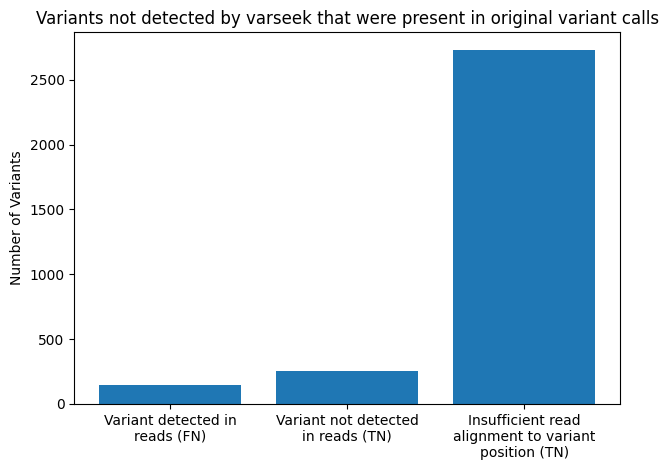

In [33]:
overall_results = {
    "Variant detected in reads (FN)": len(true_variants),
    "Variant not detected in reads (TN)": len(false_variants),
    "Insufficient read alignment to variant position (TN)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fn_bar_plot.pdf"), title = 'Variants not detected by varseek that were present in original variant calls')

## Analyze a FN

In [34]:
# detailed_txt_out_fn = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: True" not in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")

  0%|                                                                                                                           | 0/25008 [00:00<?, ?it/s]

 27%|█████████████████████████████▌                                                                               | 6777/25008 [00:00<00:00, 66707.34it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 13448/25008 [00:00<00:00, 21748.96it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 18105/25008 [00:00<00:00, 26850.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 22120/25008 [00:00<00:00, 21177.97it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25008/25008 [00:01<00:00, 21531.73it/s]

Variants in vcrs_reference: 145
Variants not in vcrs_reference: 0


In [35]:
variants_in_vcrs_reference[:20]

['ENST00000376008:c.456T>C',
 'ENST00000374472:c.351A>G',
 'ENST00000374472:c.350A>G',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000370378:c.1565G>A',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000241337:c.272C>T',
 'ENST00000256593:c.594T>C',
 'ENST00000256593:c.598C>T',
 'ENST00000256593:c.599T>C',
 'ENST00000585156:c.6692C>G',
 'ENST00000585156:c.6471G>C',
 'ENST00000581821:c.709G>C',
 'ENST00000581822:c.924C>G',
 'ENST00000355199:c.1215G>C',
 'ENST00000239462:c.2687C>T',
 'ENST00000239462:c.2688A>G',
 'ENST00000367167:c.496T>C']

In [36]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
# hgvsc = "ENST00000374472:c.351A>G"
# chrom = "1"
# pos = "24201919"
variant_bam_sorted = os.path.join(notebook_out_dir, "final_total_sorted_reads.bam") if not modify_bam else os.path.join(notebook_out_dir, "final_total_sorted_reads_modified.bam")
hgvsc = variants_in_vcrs_reference[0]
print(hgvsc)

result = None
with open(detailed_txt_out_fn) as f:
    for line in f:
        if hgvsc in line:
            result = line.strip().split(" | ")
            break  # stop at the first match

hgvsg = result[4]
chrom = hgvsg.split(":")[0]
match = re.search(r'g\.(\d+)', hgvsg)
pos = match.group(1) if match else None

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted} {chrom}:{pos}-{pos} > {output_sam}

ENST00000376008:c.456T>C


In [37]:
# revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

CTCCTCCCACTGACATGATGGCCCAGTCCAAGGCCAACGGCTCGCACTATGCGCTGACCGCCATCGGCCTGGGGA
TCCCCAGGCCGATGGCGGTCAGCGCATAGTGCGAGCCGTTGGCCTTGGACTGGGCCATCATGTCAGTGGGAGGAG
TCCCCAGGCCGATGGCGGTCAGCGCATAGTGCGAGCCG
GTTGGCCTTGGACTGGGCCATCATGTCAGTGGGAGGAG


(double click on this cell for it to make sense)
Applies to ENST00000374472:c.351A>G aka 1:g.24201919T>C 

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation site for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [38]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
# hgvsc = "ENST00000296456:c.1252T>C"
results = []

with open(detailed_txt_out) as f:
    lines = f.readlines()

for i in range(len(lines) - 1):
    line1 = lines[i].strip()
    line2 = lines[i + 1].strip()

    # Check that line1 has a reported count > min_counts
    try:
        count_str = line1.split(" | ")[-1].split()[0]  # e.g., '68.0' from '68.0 reported counts'
        reported_count = float(count_str)
    except (IndexError, ValueError):
        continue  # skip malformed lines

    # Check that the next line doesn't say "True variant: True"
    if reported_count > min_counts and line2 != "True variant: True":
        results.append(line1)

result_single = results[0]  # look at the first one
result_single = result_single.split(" | ")

hgvsc = result_single[2]
print(hgvsc)
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

ENST00000344063:c.729G>A


TAAGCAGACCTACAGCACTGAGCCCAATAACTTGAAGACCCGCAATTCCTTCCGCTACAACGGACTGATTCACCG
CGGTGAATCAGTCCGTTGTAGCGGAAGGAATTGCGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTA


### Manually check if any read has a k-mer that matches the VCRS

In [39]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq

  0%|                                                                                                                        | 0/38607132 [00:00<?, ?it/s]

  0%|                                                                                                          | 3716/38607132 [00:00<17:19, 37153.57it/s]

  0%|                                                                                                          | 7900/38607132 [00:00<16:07, 39903.74it/s]

  0%|                                                                                                         | 12182/38607132 [00:00<15:36, 41232.03it/s]

  0%|                                                                                                         | 16441/38607132 [00:00<15:23, 41765.22it/s]

  0%|                                                                                                         | 21003/38607132 [00:00<14:54, 43152.83it/s]

  0%|                                                                                                         | 25523/38607132 [00:00<14:39, 43845.46it/s]

  0%|                                                                                                         | 30131/38607132 [00:00<14:25, 44575.04it/s]

  0%|                                                                                                         | 36138/38607132 [00:00<12:59, 49506.17it/s]

  0%|                                                                                                         | 43385/38607132 [00:00<11:20, 56683.99it/s]

  0%|▏                                                                                                        | 51133/38607132 [00:01<10:11, 63102.87it/s]

  0%|▏                                                                                                        | 58273/38607132 [00:01<09:47, 65639.27it/s]

  0%|▏                                                                                                        | 66053/38607132 [00:01<09:15, 69334.75it/s]

  0%|▏                                                                                                        | 73198/38607132 [00:01<09:10, 69973.88it/s]

  0%|▏                                                                                                        | 81301/38607132 [00:01<08:54, 72135.67it/s]

  0%|▏                                                                                                        | 89521/38607132 [00:01<08:32, 75133.06it/s]

  0%|▎                                                                                                        | 97229/38607132 [00:01<08:28, 75713.26it/s]

  0%|▎                                                                                                       | 105155/38607132 [00:01<08:26, 76002.31it/s]

  0%|▎                                                                                                       | 113213/38607132 [00:01<08:17, 77361.28it/s]

  0%|▎                                                                                                       | 120950/38607132 [00:01<08:20, 76932.59it/s]

  0%|▎                                                                                                       | 128927/38607132 [00:02<08:20, 76948.07it/s]

  0%|▎                                                                                                       | 137132/38607132 [00:02<08:10, 78455.02it/s]

  0%|▍                                                                                                       | 144980/38607132 [00:02<08:13, 78012.62it/s]

  0%|▍                                                                                                       | 152784/38607132 [00:02<08:18, 77134.98it/s]

  0%|▍                                                                                                       | 160987/38607132 [00:02<08:09, 78579.82it/s]

  0%|▍                                                                                                       | 168850/38607132 [00:02<08:12, 78017.37it/s]

  0%|▍                                                                                                       | 176655/38607132 [00:02<08:16, 77439.22it/s]

  0%|▍                                                                                                       | 184778/38607132 [00:02<08:09, 78558.20it/s]

  0%|▌                                                                                                       | 192638/38607132 [00:02<08:14, 77749.56it/s]

  1%|▌                                                                                                       | 200417/38607132 [00:02<08:14, 77620.58it/s]

  1%|▌                                                                                                       | 208658/38607132 [00:03<08:05, 79039.17it/s]

  1%|▌                                                                                                       | 216566/38607132 [00:03<08:09, 78452.11it/s]

  1%|▌                                                                                                       | 224415/38607132 [00:03<08:11, 78105.48it/s]

  1%|▋                                                                                                       | 232554/38607132 [00:03<08:05, 79078.72it/s]

  1%|▋                                                                                                       | 240465/38607132 [00:03<08:10, 78194.30it/s]

  1%|▋                                                                                                       | 248288/38607132 [00:03<08:12, 77904.03it/s]

  1%|▋                                                                                                       | 256526/38607132 [00:03<08:04, 79229.60it/s]

  1%|▋                                                                                                       | 264453/38607132 [00:03<08:06, 78804.86it/s]

  1%|▋                                                                                                       | 272336/38607132 [00:03<08:11, 78042.82it/s]

  1%|▊                                                                                                       | 280515/38607132 [00:03<08:11, 77945.34it/s]

  1%|▊                                                                                                       | 288714/38607132 [00:04<08:04, 79131.21it/s]

  1%|▊                                                                                                       | 296632/38607132 [00:04<08:07, 78664.10it/s]

  1%|▊                                                                                                       | 304502/38607132 [00:04<08:14, 77505.96it/s]

  1%|▊                                                                                                       | 312687/38607132 [00:04<08:06, 78780.74it/s]

  1%|▊                                                                                                       | 320571/38607132 [00:04<08:08, 78351.94it/s]

  1%|▉                                                                                                       | 328411/38607132 [00:04<08:10, 78044.27it/s]

  1%|▉                                                                                                       | 336632/38607132 [00:04<08:02, 79276.28it/s]

  1%|▉                                                                                                       | 344564/38607132 [00:04<08:08, 78313.63it/s]

  1%|▉                                                                                                       | 352400/38607132 [00:04<08:10, 78049.70it/s]

  1%|▉                                                                                                       | 360637/38607132 [00:04<08:02, 79326.55it/s]

  1%|▉                                                                                                       | 368574/38607132 [00:05<08:07, 78479.27it/s]

  1%|█                                                                                                       | 376426/38607132 [00:05<08:09, 78079.78it/s]

  1%|█                                                                                                       | 384516/38607132 [00:05<08:04, 78912.22it/s]

  1%|█                                                                                                       | 392411/38607132 [00:05<08:08, 78164.81it/s]

  1%|█                                                                                                       | 400231/38607132 [00:05<08:11, 77685.97it/s]

  1%|█                                                                                                       | 408438/38607132 [00:05<08:03, 78980.91it/s]

  1%|█                                                                                                       | 416340/38607132 [00:05<08:06, 78519.08it/s]

  1%|█▏                                                                                                      | 424195/38607132 [00:05<08:13, 77411.45it/s]

  1%|█▏                                                                                                      | 432388/38607132 [00:05<08:04, 78742.08it/s]

  1%|█▏                                                                                                      | 440268/38607132 [00:05<08:07, 78364.04it/s]

  1%|█▏                                                                                                      | 448109/38607132 [00:06<08:09, 78023.46it/s]

  1%|█▏                                                                                                      | 456262/38607132 [00:06<08:09, 77978.94it/s]

  1%|█▎                                                                                                      | 464383/38607132 [00:06<08:03, 78928.87it/s]

  1%|█▎                                                                                                      | 472279/38607132 [00:06<08:07, 78170.06it/s]

  1%|█▎                                                                                                      | 480099/38607132 [00:06<08:10, 77766.03it/s]

  1%|█▎                                                                                                      | 488187/38607132 [00:06<08:04, 78683.54it/s]

  1%|█▎                                                                                                      | 496059/38607132 [00:06<08:06, 78331.81it/s]

  1%|█▎                                                                                                      | 503895/38607132 [00:06<08:10, 77633.71it/s]

  1%|█▍                                                                                                      | 512114/38607132 [00:06<08:02, 78978.88it/s]

  1%|█▍                                                                                                      | 520016/38607132 [00:07<08:04, 78534.39it/s]

  1%|█▍                                                                                                      | 527872/38607132 [00:07<08:07, 78090.77it/s]

  1%|█▍                                                                                                      | 536101/38607132 [00:07<07:59, 79334.94it/s]

  1%|█▍                                                                                                      | 544038/38607132 [00:07<08:05, 78417.47it/s]

  1%|█▍                                                                                                      | 551884/38607132 [00:07<08:08, 77870.74it/s]

  1%|█▌                                                                                                      | 560098/38607132 [00:07<08:00, 79129.36it/s]

  1%|█▌                                                                                                      | 568015/38607132 [00:07<08:03, 78653.86it/s]

  1%|█▌                                                                                                      | 575884/38607132 [00:07<08:05, 78294.09it/s]

  2%|█▌                                                                                                      | 583976/38607132 [00:07<08:00, 79070.86it/s]

  2%|█▌                                                                                                      | 591886/38607132 [00:07<08:03, 78677.42it/s]

  2%|█▌                                                                                                      | 599756/38607132 [00:08<08:04, 78417.74it/s]

  2%|█▋                                                                                                      | 607899/38607132 [00:08<08:08, 77838.85it/s]

  2%|█▋                                                                                                      | 616093/38607132 [00:08<08:00, 79043.12it/s]

  2%|█▋                                                                                                      | 624002/38607132 [00:08<08:05, 78276.85it/s]

  2%|█▋                                                                                                      | 631834/38607132 [00:08<08:07, 77897.45it/s]

  2%|█▋                                                                                                      | 640073/38607132 [00:08<07:59, 79223.74it/s]

  2%|█▋                                                                                                      | 648000/38607132 [00:08<08:02, 78734.57it/s]

  2%|█▊                                                                                                      | 655877/38607132 [00:08<08:04, 78379.31it/s]

  2%|█▊                                                                                                      | 663995/38607132 [00:08<07:59, 79206.68it/s]

  2%|█▊                                                                                                      | 671918/38607132 [00:08<08:03, 78516.93it/s]

  2%|█▊                                                                                                      | 679773/38607132 [00:09<08:04, 78220.04it/s]

  2%|█▊                                                                                                      | 688024/38607132 [00:09<07:57, 79490.39it/s]

  2%|█▊                                                                                                      | 695976/38607132 [00:09<08:00, 78824.25it/s]

  2%|█▉                                                                                                      | 703862/38607132 [00:09<08:05, 78029.17it/s]

  2%|█▉                                                                                                      | 712057/38607132 [00:09<07:58, 79185.66it/s]

  2%|█▉                                                                                                      | 719980/38607132 [00:09<08:02, 78584.43it/s]

  2%|█▉                                                                                                      | 727842/38607132 [00:09<08:06, 77831.94it/s]

  2%|█▉                                                                                                      | 736007/38607132 [00:09<08:10, 77257.10it/s]

  2%|██                                                                                                      | 744155/38607132 [00:09<08:02, 78488.24it/s]

  2%|██                                                                                                      | 752010/38607132 [00:09<08:05, 77904.65it/s]

  2%|██                                                                                                      | 759805/38607132 [00:10<08:07, 77706.67it/s]

  2%|██                                                                                                      | 768023/38607132 [00:10<07:58, 79028.23it/s]

  2%|██                                                                                                      | 775930/38607132 [00:10<08:05, 77940.97it/s]

  2%|██                                                                                                      | 783730/38607132 [00:10<08:06, 77725.99it/s]

  2%|██▏                                                                                                     | 791820/38607132 [00:10<08:00, 78661.76it/s]

  2%|██▏                                                                                                     | 799690/38607132 [00:10<08:02, 78376.03it/s]

  2%|██▏                                                                                                     | 807531/38607132 [00:10<08:05, 77888.58it/s]

  2%|██▏                                                                                                     | 815672/38607132 [00:10<07:58, 78931.88it/s]

  2%|██▏                                                                                                     | 823568/38607132 [00:10<08:01, 78445.06it/s]

  2%|██▏                                                                                                     | 831415/38607132 [00:10<08:03, 78101.05it/s]

  2%|██▎                                                                                                     | 839693/38607132 [00:11<07:55, 79489.04it/s]

  2%|██▎                                                                                                     | 847645/38607132 [00:11<07:57, 78998.79it/s]

  2%|██▎                                                                                                     | 855547/38607132 [00:11<08:03, 78026.72it/s]

  2%|██▎                                                                                                     | 863820/38607132 [00:11<07:55, 79414.98it/s]

  2%|██▎                                                                                                     | 871766/38607132 [00:11<07:57, 79009.91it/s]

  2%|██▎                                                                                                     | 879671/38607132 [00:11<07:59, 78660.77it/s]

  2%|██▍                                                                                                     | 887920/38607132 [00:11<07:52, 79794.60it/s]

  2%|██▍                                                                                                     | 896833/38607132 [00:11<07:36, 82571.67it/s]

  2%|██▍                                                                                                     | 907992/38607132 [00:11<06:53, 91228.84it/s]

  2%|██▍                                                                                                     | 919787/38607132 [00:11<06:19, 99213.67it/s]

  2%|██▍                                                                                                    | 931081/38607132 [00:12<06:04, 103318.71it/s]

  2%|██▌                                                                                                    | 942705/38607132 [00:12<05:51, 107185.68it/s]

  2%|██▌                                                                                                    | 954269/38607132 [00:12<05:47, 108458.68it/s]

  3%|██▌                                                                                                    | 966068/38607132 [00:12<05:38, 111291.41it/s]

  3%|██▌                                                                                                    | 977932/38607132 [00:12<05:34, 112646.55it/s]

  3%|██▋                                                                                                    | 990861/38607132 [00:12<05:19, 117589.91it/s]

  3%|██▋                                                                                                   | 1003105/38607132 [00:12<05:15, 119033.39it/s]

  3%|██▋                                                                                                   | 1015723/38607132 [00:12<05:13, 120090.94it/s]

  3%|██▋                                                                                                   | 1028266/38607132 [00:12<05:08, 121676.72it/s]

  3%|██▋                                                                                                   | 1040437/38607132 [00:12<05:10, 120995.36it/s]

  3%|██▊                                                                                                   | 1053139/38607132 [00:13<05:05, 122784.58it/s]

  3%|██▊                                                                                                   | 1065421/38607132 [00:13<05:06, 122436.49it/s]

  3%|██▊                                                                                                   | 1077667/38607132 [00:13<05:09, 121358.38it/s]

  3%|██▉                                                                                                   | 1089910/38607132 [00:13<05:08, 121674.24it/s]

  3%|██▉                                                                                                   | 1102080/38607132 [00:13<05:09, 121123.21it/s]

  3%|██▉                                                                                                   | 1114962/38607132 [00:13<05:03, 123410.65it/s]

  3%|██▉                                                                                                   | 1127307/38607132 [00:13<05:05, 122812.14it/s]

  3%|███                                                                                                   | 1139591/38607132 [00:13<05:06, 122229.30it/s]

  3%|███                                                                                                   | 1152199/38607132 [00:13<05:03, 123370.71it/s]

  3%|███                                                                                                   | 1164539/38607132 [00:14<05:05, 122674.17it/s]

  3%|███                                                                                                   | 1176809/38607132 [00:14<05:05, 122407.87it/s]

  3%|███▏                                                                                                  | 1189671/38607132 [00:14<05:01, 124254.95it/s]

  3%|███▏                                                                                                  | 1202099/38607132 [00:14<05:06, 122159.07it/s]

  3%|███▏                                                                                                  | 1214415/38607132 [00:14<05:09, 120932.83it/s]

  3%|███▏                                                                                                  | 1227062/38607132 [00:14<05:04, 122559.14it/s]

  3%|███▎                                                                                                  | 1239330/38607132 [00:14<05:04, 122593.81it/s]

  3%|███▎                                                                                                  | 1251656/38607132 [00:14<05:04, 122790.28it/s]

  3%|███▎                                                                                                  | 1263940/38607132 [00:14<05:07, 121438.84it/s]

  3%|███▎                                                                                                  | 1276138/38607132 [00:14<05:07, 121597.98it/s]

  3%|███▍                                                                                                  | 1288671/38607132 [00:15<05:04, 122705.45it/s]

  3%|███▍                                                                                                  | 1300976/38607132 [00:15<05:03, 122805.50it/s]

  3%|███▍                                                                                                  | 1313468/38607132 [00:15<05:04, 122593.08it/s]

  3%|███▌                                                                                                  | 1325730/38607132 [00:15<05:05, 122218.99it/s]

  3%|███▌                                                                                                  | 1337954/38607132 [00:15<05:11, 119791.75it/s]

  3%|███▌                                                                                                  | 1349944/38607132 [00:15<05:12, 119196.76it/s]

  4%|███▌                                                                                                  | 1361871/38607132 [00:15<05:16, 117719.63it/s]

  4%|███▋                                                                                                  | 1373886/38607132 [00:15<05:14, 118431.86it/s]

  4%|███▋                                                                                                  | 1385736/38607132 [00:15<05:19, 116456.88it/s]

  4%|███▋                                                                                                  | 1397695/38607132 [00:15<05:17, 117374.96it/s]

  4%|███▋                                                                                                  | 1409441/38607132 [00:16<05:20, 116099.40it/s]

  4%|███▊                                                                                                  | 1421324/38607132 [00:16<05:18, 116902.38it/s]

  4%|███▊                                                                                                  | 1433021/38607132 [00:16<05:19, 116310.08it/s]

  4%|███▊                                                                                                  | 1444717/38607132 [00:16<05:18, 116499.61it/s]

  4%|███▊                                                                                                  | 1456440/38607132 [00:16<05:18, 116715.61it/s]

  4%|███▉                                                                                                  | 1468531/38607132 [00:16<05:14, 117963.41it/s]

  4%|███▉                                                                                                  | 1480937/38607132 [00:16<05:09, 119783.34it/s]

  4%|███▉                                                                                                  | 1493566/38607132 [00:16<05:04, 121727.65it/s]

  4%|███▉                                                                                                  | 1506326/38607132 [00:16<05:00, 123482.57it/s]

  4%|████                                                                                                  | 1518677/38607132 [00:16<05:04, 121761.23it/s]

  4%|████                                                                                                  | 1530860/38607132 [00:17<05:04, 121653.78it/s]

  4%|████                                                                                                  | 1543798/38607132 [00:17<04:59, 123950.68it/s]

  4%|████                                                                                                  | 1556199/38607132 [00:17<05:00, 123159.96it/s]

  4%|████▏                                                                                                 | 1568540/38607132 [00:17<05:00, 123114.33it/s]

  4%|████▏                                                                                                 | 1580964/38607132 [00:17<04:59, 123447.49it/s]

  4%|████▏                                                                                                 | 1593404/38607132 [00:17<04:59, 123729.01it/s]

  4%|████▏                                                                                                 | 1606213/38607132 [00:17<04:55, 125031.34it/s]

  4%|████▎                                                                                                 | 1618718/38607132 [00:17<04:59, 123687.13it/s]

  4%|████▎                                                                                                 | 1631091/38607132 [00:17<05:06, 120603.56it/s]

  4%|████▎                                                                                                 | 1643663/38607132 [00:17<05:02, 122100.39it/s]

  4%|████▎                                                                                                 | 1655889/38607132 [00:18<05:03, 121930.34it/s]

  4%|████▍                                                                                                 | 1668266/38607132 [00:18<05:01, 122473.70it/s]

  4%|████▍                                                                                                 | 1680860/38607132 [00:18<04:58, 123502.67it/s]

  4%|████▍                                                                                                 | 1693218/38607132 [00:18<05:00, 122989.84it/s]

  4%|████▌                                                                                                 | 1705522/38607132 [00:18<05:04, 121275.14it/s]

  4%|████▌                                                                                                 | 1718414/38607132 [00:18<04:58, 123532.06it/s]

  4%|████▌                                                                                                 | 1730777/38607132 [00:18<04:59, 123047.80it/s]

  5%|████▌                                                                                                 | 1743193/38607132 [00:18<05:01, 122182.57it/s]

  5%|████▋                                                                                                 | 1755977/38607132 [00:18<04:57, 123854.54it/s]

  5%|████▋                                                                                                 | 1768375/38607132 [00:18<04:57, 123889.47it/s]

  5%|████▋                                                                                                 | 1781004/38607132 [00:19<04:55, 124603.67it/s]

  5%|████▋                                                                                                 | 1794185/38607132 [00:19<04:50, 126752.32it/s]

  5%|████▊                                                                                                 | 1806864/38607132 [00:19<04:52, 125943.83it/s]

  5%|████▊                                                                                                 | 1819462/38607132 [00:19<04:52, 125695.64it/s]

  5%|████▊                                                                                                 | 1832511/38607132 [00:19<04:49, 127123.01it/s]

  5%|████▉                                                                                                 | 1845226/38607132 [00:19<04:49, 127019.32it/s]

  5%|████▉                                                                                                 | 1857930/38607132 [00:19<04:51, 125925.22it/s]

  5%|████▉                                                                                                 | 1870526/38607132 [00:19<04:54, 124897.43it/s]

  5%|████▉                                                                                                 | 1883019/38607132 [00:19<04:56, 123681.99it/s]

  5%|█████                                                                                                 | 1895391/38607132 [00:19<04:57, 123329.52it/s]

  5%|█████                                                                                                 | 1908066/38607132 [00:20<04:55, 124341.41it/s]

  5%|█████                                                                                                 | 1920503/38607132 [00:20<04:56, 123888.90it/s]

  5%|█████                                                                                                 | 1932894/38607132 [00:20<04:58, 122908.01it/s]

  5%|█████▏                                                                                                | 1945588/38607132 [00:20<04:55, 124099.95it/s]

  5%|█████▏                                                                                                | 1958002/38607132 [00:20<04:57, 123355.22it/s]

  5%|█████▏                                                                                                | 1970341/38607132 [00:20<04:57, 123149.60it/s]

  5%|█████▏                                                                                                | 1983014/38607132 [00:20<04:54, 124212.64it/s]

  5%|█████▎                                                                                                | 1995438/38607132 [00:20<04:58, 122544.46it/s]

  5%|█████▎                                                                                                | 2007808/38607132 [00:20<04:58, 122695.83it/s]

  5%|█████▎                                                                                                | 2021021/38607132 [00:21<04:51, 125493.96it/s]

  5%|█████▎                                                                                                | 2033577/38607132 [00:21<04:53, 124568.22it/s]

  5%|█████▍                                                                                                | 2046039/38607132 [00:21<04:55, 123860.42it/s]

  5%|█████▍                                                                                                | 2058442/38607132 [00:21<04:54, 123909.34it/s]

  5%|█████▍                                                                                                | 2070877/38607132 [00:21<04:54, 124039.81it/s]

  5%|█████▌                                                                                                | 2083456/38607132 [00:21<04:54, 123911.38it/s]

  5%|█████▌                                                                                                | 2096223/38607132 [00:21<04:52, 125029.53it/s]

  5%|█████▌                                                                                                | 2108728/38607132 [00:21<04:53, 124153.46it/s]

  5%|█████▌                                                                                                | 2121146/38607132 [00:21<04:56, 122923.66it/s]

  6%|█████▋                                                                                                | 2133442/38607132 [00:21<05:02, 120602.71it/s]

  6%|█████▋                                                                                                | 2145512/38607132 [00:22<05:07, 118500.35it/s]

  6%|█████▋                                                                                                | 2157627/38607132 [00:22<05:05, 119272.32it/s]

  6%|█████▋                                                                                                | 2169564/38607132 [00:22<05:13, 116357.82it/s]

  6%|█████▊                                                                                                | 2181705/38607132 [00:22<05:09, 117824.67it/s]

  6%|█████▊                                                                                                | 2193800/38607132 [00:22<05:06, 118740.42it/s]

  6%|█████▊                                                                                                | 2206190/38607132 [00:22<05:02, 120261.51it/s]

  6%|█████▊                                                                                                | 2218936/38607132 [00:22<04:57, 122395.76it/s]

  6%|█████▉                                                                                                | 2231320/38607132 [00:22<04:56, 122824.33it/s]

  6%|█████▉                                                                                                | 2243611/38607132 [00:22<04:57, 122307.87it/s]

  6%|█████▉                                                                                                | 2255848/38607132 [00:22<04:59, 121413.53it/s]

  6%|█████▉                                                                                                | 2268143/38607132 [00:23<04:58, 121868.66it/s]

  6%|██████                                                                                                | 2281214/38607132 [00:23<04:51, 124501.48it/s]

  6%|██████                                                                                                | 2293669/38607132 [00:23<04:53, 123713.62it/s]

  6%|██████                                                                                                | 2306045/38607132 [00:23<04:55, 122968.46it/s]

  6%|██████▏                                                                                               | 2318346/38607132 [00:23<04:57, 121794.77it/s]

  6%|██████▏                                                                                               | 2330530/38607132 [00:23<05:02, 119797.12it/s]

  6%|██████▏                                                                                               | 2342574/38607132 [00:23<05:02, 119984.59it/s]

  6%|██████▏                                                                                               | 2354579/38607132 [00:23<05:09, 117073.57it/s]

  6%|██████▎                                                                                               | 2366569/38607132 [00:23<05:09, 117007.58it/s]

  6%|██████▎                                                                                               | 2379430/38607132 [00:23<05:00, 120401.61it/s]

  6%|██████▎                                                                                               | 2391521/38607132 [00:24<05:00, 120549.04it/s]

  6%|██████▎                                                                                               | 2404265/38607132 [00:24<04:55, 122588.02it/s]

  6%|██████▍                                                                                               | 2416535/38607132 [00:24<05:00, 120590.31it/s]

  6%|██████▍                                                                                               | 2428680/38607132 [00:24<04:59, 120842.84it/s]

  6%|██████▍                                                                                               | 2441560/38607132 [00:24<04:53, 123199.53it/s]

  6%|██████▍                                                                                               | 2454137/38607132 [00:24<04:51, 123961.85it/s]

  6%|██████▌                                                                                               | 2466541/38607132 [00:24<04:52, 123558.06it/s]

  6%|██████▌                                                                                               | 2479264/38607132 [00:24<04:49, 124650.59it/s]

  6%|██████▌                                                                                               | 2491811/38607132 [00:24<04:49, 124893.15it/s]

  6%|██████▌                                                                                               | 2504304/38607132 [00:24<04:50, 124418.77it/s]

  7%|██████▋                                                                                               | 2517537/38607132 [00:25<04:44, 126778.30it/s]

  7%|██████▋                                                                                               | 2530218/38607132 [00:25<04:45, 126199.40it/s]

  7%|██████▋                                                                                               | 2542841/38607132 [00:25<04:47, 125412.56it/s]

  7%|██████▊                                                                                               | 2555686/38607132 [00:25<04:46, 125955.07it/s]

  7%|██████▊                                                                                               | 2568907/38607132 [00:25<04:41, 127814.47it/s]

  7%|██████▊                                                                                               | 2581692/38607132 [00:25<04:45, 125999.98it/s]

  7%|██████▊                                                                                               | 2594299/38607132 [00:25<04:50, 124010.44it/s]

  7%|██████▉                                                                                               | 2606772/38607132 [00:25<04:49, 124219.13it/s]

  7%|██████▉                                                                                               | 2619201/38607132 [00:25<04:56, 121439.41it/s]

  7%|██████▉                                                                                               | 2631361/38607132 [00:26<05:00, 119714.42it/s]

  7%|██████▉                                                                                               | 2643345/38607132 [00:26<05:01, 119148.22it/s]

  7%|███████                                                                                               | 2655268/38607132 [00:26<05:05, 117773.10it/s]

  7%|███████                                                                                               | 2667075/38607132 [00:26<05:04, 117859.25it/s]

  7%|███████                                                                                               | 2678866/38607132 [00:26<05:08, 116513.72it/s]

  7%|███████                                                                                               | 2690677/38607132 [00:26<05:07, 116980.66it/s]

  7%|███████▏                                                                                              | 2702380/38607132 [00:26<05:10, 115707.12it/s]

  7%|███████▏                                                                                              | 2714274/38607132 [00:26<05:07, 116658.04it/s]

  7%|███████▏                                                                                              | 2725945/38607132 [00:26<05:10, 115660.59it/s]

  7%|███████▏                                                                                              | 2737753/38607132 [00:26<05:08, 116373.36it/s]

  7%|███████▎                                                                                              | 2750020/38607132 [00:27<05:03, 118241.27it/s]

  7%|███████▎                                                                                              | 2762549/38607132 [00:27<04:57, 120338.14it/s]

  7%|███████▎                                                                                              | 2774916/38607132 [00:27<04:55, 121330.75it/s]

  7%|███████▎                                                                                              | 2787086/38607132 [00:27<04:54, 121439.51it/s]

  7%|███████▍                                                                                              | 2799814/38607132 [00:27<04:50, 123185.54it/s]

  7%|███████▍                                                                                              | 2812135/38607132 [00:27<04:53, 122029.61it/s]

  7%|███████▍                                                                                              | 2824617/38607132 [00:27<04:51, 122857.37it/s]

  7%|███████▍                                                                                              | 2836907/38607132 [00:27<04:52, 122318.86it/s]

  7%|███████▌                                                                                              | 2849142/38607132 [00:27<04:53, 121853.74it/s]

  7%|███████▌                                                                                              | 2861851/38607132 [00:27<04:49, 123408.45it/s]

  7%|███████▌                                                                                              | 2874195/38607132 [00:28<04:51, 122543.59it/s]

  7%|███████▋                                                                                              | 2886453/38607132 [00:28<04:52, 122123.59it/s]

  8%|███████▋                                                                                              | 2898707/38607132 [00:28<04:52, 122246.44it/s]

  8%|███████▋                                                                                              | 2910934/38607132 [00:28<04:53, 121646.90it/s]

  8%|███████▋                                                                                              | 2923707/38607132 [00:28<04:49, 123456.24it/s]

  8%|███████▊                                                                                              | 2936055/38607132 [00:28<04:52, 121915.00it/s]

  8%|███████▊                                                                                              | 2948252/38607132 [00:28<04:58, 119389.02it/s]

  8%|███████▊                                                                                              | 2960449/38607132 [00:28<04:56, 120143.43it/s]

  8%|███████▊                                                                                              | 2972474/38607132 [00:28<05:02, 117977.14it/s]

  8%|███████▉                                                                                              | 2984292/38607132 [00:28<05:01, 118034.16it/s]

  8%|███████▉                                                                                              | 2996105/38607132 [00:29<05:04, 117001.59it/s]

  8%|███████▉                                                                                              | 3007813/38607132 [00:29<05:04, 116987.58it/s]

  8%|███████▉                                                                                              | 3019517/38607132 [00:29<05:08, 115411.21it/s]

  8%|████████                                                                                              | 3031802/38607132 [00:29<05:02, 117599.60it/s]

  8%|████████                                                                                              | 3043571/38607132 [00:29<05:10, 114378.84it/s]

  8%|████████                                                                                              | 3055152/38607132 [00:29<05:09, 114794.39it/s]

  8%|████████                                                                                              | 3066648/38607132 [00:29<05:11, 114017.33it/s]

  8%|████████▏                                                                                             | 3078409/38607132 [00:29<05:08, 115071.42it/s]

  8%|████████▏                                                                                             | 3089927/38607132 [00:29<05:11, 114014.80it/s]

  8%|████████▏                                                                                             | 3101690/38607132 [00:29<05:08, 115080.09it/s]

  8%|████████▏                                                                                             | 3113206/38607132 [00:30<05:09, 114596.96it/s]

  8%|████████▎                                                                                             | 3125320/38607132 [00:30<05:04, 116536.05it/s]

  8%|████████▎                                                                                             | 3136980/38607132 [00:30<05:05, 115944.40it/s]

  8%|████████▎                                                                                             | 3149994/38607132 [00:30<04:55, 120161.72it/s]

  8%|████████▎                                                                                             | 3162018/38607132 [00:30<04:55, 120131.81it/s]

  8%|████████▍                                                                                             | 3174202/38607132 [00:30<04:53, 120641.32it/s]

  8%|████████▍                                                                                             | 3186629/38607132 [00:30<04:50, 121724.64it/s]

  8%|████████▍                                                                                             | 3198805/38607132 [00:30<04:51, 121388.27it/s]

  8%|████████▍                                                                                             | 3211431/38607132 [00:30<04:48, 122841.68it/s]

  8%|████████▌                                                                                             | 3223901/38607132 [00:30<04:46, 123394.87it/s]

  8%|████████▌                                                                                             | 3236243/38607132 [00:31<04:51, 121181.94it/s]

  8%|████████▌                                                                                             | 3249153/38607132 [00:31<04:46, 123521.43it/s]

  8%|████████▌                                                                                             | 3261516/38607132 [00:31<04:48, 122694.47it/s]

  8%|████████▋                                                                                             | 3273794/38607132 [00:31<04:48, 122630.84it/s]

  9%|████████▋                                                                                             | 3286440/38607132 [00:31<04:45, 123767.81it/s]

  9%|████████▋                                                                                             | 3298822/38607132 [00:31<04:45, 123728.96it/s]

  9%|████████▋                                                                                             | 3311199/38607132 [00:31<04:47, 122772.86it/s]

  9%|████████▊                                                                                             | 3324001/38607132 [00:31<04:43, 124332.60it/s]

  9%|████████▊                                                                                             | 3336439/38607132 [00:31<04:45, 123695.90it/s]

  9%|████████▊                                                                                             | 3349021/38607132 [00:31<04:45, 123490.75it/s]

  9%|████████▉                                                                                             | 3362237/38607132 [00:32<04:39, 126063.01it/s]

  9%|████████▉                                                                                             | 3374848/38607132 [00:32<04:41, 125133.05it/s]

  9%|████████▉                                                                                             | 3387366/38607132 [00:32<04:44, 123625.89it/s]

  9%|████████▉                                                                                             | 3400262/38607132 [00:32<04:41, 125199.55it/s]

  9%|█████████                                                                                             | 3413027/38607132 [00:32<04:39, 125925.51it/s]

  9%|█████████                                                                                             | 3425687/38607132 [00:32<04:38, 126124.17it/s]

  9%|█████████                                                                                             | 3438535/38607132 [00:32<04:38, 126345.18it/s]

  9%|█████████                                                                                             | 3451575/38607132 [00:32<04:35, 127551.85it/s]

  9%|█████████▏                                                                                            | 3464333/38607132 [00:32<04:41, 124773.03it/s]

  9%|█████████▏                                                                                            | 3476825/38607132 [00:33<04:53, 119829.21it/s]

  9%|█████████▏                                                                                            | 3488977/38607132 [00:33<04:51, 120313.21it/s]

  9%|█████████▏                                                                                            | 3501042/38607132 [00:33<04:55, 118845.11it/s]

  9%|█████████▎                                                                                            | 3512951/38607132 [00:33<04:59, 117159.54it/s]

  9%|█████████▎                                                                                            | 3524685/38607132 [00:33<05:04, 115277.94it/s]

  9%|█████████▎                                                                                            | 3536718/38607132 [00:33<05:00, 116741.12it/s]

  9%|█████████▎                                                                                            | 3548407/38607132 [00:33<05:01, 116177.04it/s]

  9%|█████████▍                                                                                            | 3560637/38607132 [00:33<04:57, 117973.16it/s]

  9%|█████████▍                                                                                            | 3572445/38607132 [00:33<04:57, 117700.91it/s]

  9%|█████████▍                                                                                            | 3584985/38607132 [00:33<04:53, 119179.01it/s]

  9%|█████████▌                                                                                            | 3597590/38607132 [00:34<04:48, 121210.52it/s]

  9%|█████████▌                                                                                            | 3609717/38607132 [00:34<04:52, 119831.65it/s]

  9%|█████████▌                                                                                            | 3622551/38607132 [00:34<04:45, 122344.60it/s]

  9%|█████████▌                                                                                            | 3634794/38607132 [00:34<04:45, 122302.11it/s]

  9%|█████████▋                                                                                            | 3647030/38607132 [00:34<04:47, 121770.75it/s]

  9%|█████████▋                                                                                            | 3659905/38607132 [00:34<04:42, 123845.94it/s]

 10%|█████████▋                                                                                            | 3672339/38607132 [00:34<04:41, 123990.32it/s]

 10%|█████████▋                                                                                            | 3684742/38607132 [00:34<04:42, 123724.35it/s]

 10%|█████████▊                                                                                            | 3697117/38607132 [00:34<04:47, 121623.05it/s]

 10%|█████████▊                                                                                            | 3709289/38607132 [00:34<04:50, 120071.54it/s]

 10%|█████████▊                                                                                            | 3722036/38607132 [00:35<04:45, 122245.15it/s]

 10%|█████████▊                                                                                            | 3734600/38607132 [00:35<04:42, 123247.07it/s]

 10%|█████████▉                                                                                            | 3746934/38607132 [00:35<04:44, 122337.79it/s]

 10%|█████████▉                                                                                            | 3759645/38607132 [00:35<04:41, 123749.17it/s]

 10%|█████████▉                                                                                            | 3772027/38607132 [00:35<04:43, 123013.62it/s]

 10%|█████████▉                                                                                            | 3784544/38607132 [00:35<04:41, 123646.21it/s]

 10%|██████████                                                                                            | 3796913/38607132 [00:35<04:43, 122931.82it/s]

 10%|██████████                                                                                            | 3809210/38607132 [00:35<04:44, 122214.99it/s]

 10%|██████████                                                                                            | 3821435/38607132 [00:35<04:45, 121830.29it/s]

 10%|██████████▏                                                                                           | 3834133/38607132 [00:35<04:41, 123359.73it/s]

 10%|██████████▏                                                                                           | 3846472/38607132 [00:36<04:43, 122575.78it/s]

 10%|██████████▏                                                                                           | 3858845/38607132 [00:36<04:42, 122917.74it/s]

 10%|██████████▏                                                                                           | 3871327/38607132 [00:36<04:41, 123482.28it/s]

 10%|██████████▎                                                                                           | 3883678/38607132 [00:36<04:41, 123454.20it/s]

 10%|██████████▎                                                                                           | 3896114/38607132 [00:36<04:40, 123723.02it/s]

 10%|██████████▎                                                                                           | 3908488/38607132 [00:36<04:45, 121488.94it/s]

 10%|██████████▎                                                                                           | 3920647/38607132 [00:36<04:45, 121282.96it/s]

 10%|██████████▍                                                                                           | 3933301/38607132 [00:36<04:42, 122840.70it/s]

 10%|██████████▍                                                                                           | 3945592/38607132 [00:36<04:43, 122234.26it/s]

 10%|██████████▍                                                                                           | 3958113/38607132 [00:36<04:43, 122376.43it/s]

 10%|██████████▍                                                                                           | 3970921/38607132 [00:37<04:39, 124067.66it/s]

 10%|██████████▌                                                                                           | 3983351/38607132 [00:37<04:38, 124134.94it/s]

 10%|██████████▌                                                                                           | 3995891/38607132 [00:37<04:37, 124511.60it/s]

 10%|██████████▌                                                                                           | 4008345/38607132 [00:37<04:39, 123697.01it/s]

 10%|██████████▌                                                                                           | 4020718/38607132 [00:37<04:40, 123224.22it/s]

 10%|██████████▋                                                                                           | 4033043/38607132 [00:37<04:41, 122860.67it/s]

 10%|██████████▋                                                                                           | 4045389/38607132 [00:37<04:40, 123036.78it/s]

 11%|██████████▋                                                                                           | 4057756/38607132 [00:37<04:40, 123223.67it/s]

 11%|██████████▊                                                                                           | 4070080/38607132 [00:37<04:44, 121270.94it/s]

 11%|██████████▊                                                                                           | 4082214/38607132 [00:37<04:49, 119415.65it/s]

 11%|██████████▊                                                                                           | 4094212/38607132 [00:38<04:48, 119578.92it/s]

 11%|██████████▊                                                                                           | 4106177/38607132 [00:38<04:50, 118728.63it/s]

 11%|██████████▉                                                                                           | 4118055/38607132 [00:38<04:50, 118606.42it/s]

 11%|██████████▉                                                                                           | 4129919/38607132 [00:38<04:54, 116974.11it/s]

 11%|██████████▉                                                                                           | 4142216/38607132 [00:38<04:52, 117743.17it/s]

 11%|██████████▉                                                                                           | 4155173/38607132 [00:38<04:44, 121225.23it/s]

 11%|███████████                                                                                           | 4167305/38607132 [00:38<04:44, 121052.32it/s]

 11%|███████████                                                                                           | 4179877/38607132 [00:38<04:41, 122436.58it/s]

 11%|███████████                                                                                           | 4192127/38607132 [00:38<04:43, 121514.79it/s]

 11%|███████████                                                                                           | 4204403/38607132 [00:39<04:42, 121881.99it/s]

 11%|███████████▏                                                                                          | 4217282/38607132 [00:39<04:37, 123938.17it/s]

 11%|███████████▏                                                                                          | 4229681/38607132 [00:39<04:37, 123832.08it/s]

 11%|███████████▏                                                                                          | 4242068/38607132 [00:39<04:43, 121221.46it/s]

 11%|███████████▏                                                                                          | 4254204/38607132 [00:39<04:46, 119781.35it/s]

 11%|███████████▎                                                                                          | 4266194/38607132 [00:39<04:51, 117923.68it/s]

 11%|███████████▎                                                                                          | 4278256/38607132 [00:39<04:49, 118709.10it/s]

 11%|███████████▎                                                                                          | 4290137/38607132 [00:39<04:53, 116985.63it/s]

 11%|███████████▎                                                                                          | 4301845/38607132 [00:39<04:53, 116944.27it/s]

 11%|███████████▍                                                                                          | 4313546/38607132 [00:39<04:55, 116107.04it/s]

 11%|███████████▍                                                                                          | 4325596/38607132 [00:40<04:52, 117400.82it/s]

 11%|███████████▍                                                                                          | 4337523/38607132 [00:40<04:50, 117953.85it/s]

 11%|███████████▍                                                                                          | 4350125/38607132 [00:40<04:46, 119485.09it/s]

 11%|███████████▌                                                                                          | 4362631/38607132 [00:40<04:42, 121138.58it/s]

 11%|███████████▌                                                                                          | 4374748/38607132 [00:40<04:43, 120788.07it/s]

 11%|███████████▌                                                                                          | 4387359/38607132 [00:40<04:39, 122370.52it/s]

 11%|███████████▌                                                                                          | 4399599/38607132 [00:40<04:40, 122081.16it/s]

 11%|███████████▋                                                                                          | 4411810/38607132 [00:40<04:42, 121070.79it/s]

 11%|███████████▋                                                                                          | 4424079/38607132 [00:40<04:41, 121549.33it/s]

 11%|███████████▋                                                                                          | 4436237/38607132 [00:40<04:41, 121395.16it/s]

 12%|███████████▊                                                                                          | 4448994/38607132 [00:41<04:37, 123236.16it/s]

 12%|███████████▊                                                                                          | 4461320/38607132 [00:41<04:37, 123157.07it/s]

 12%|███████████▊                                                                                          | 4473638/38607132 [00:41<04:37, 122806.06it/s]

 12%|███████████▊                                                                                          | 4486230/38607132 [00:41<04:35, 123733.76it/s]

 12%|███████████▉                                                                                          | 4498605/38607132 [00:41<04:39, 122011.64it/s]

 12%|███████████▉                                                                                          | 4510892/38607132 [00:41<04:38, 122263.43it/s]

 12%|███████████▉                                                                                          | 4523749/38607132 [00:41<04:34, 124136.46it/s]

 12%|███████████▉                                                                                          | 4536168/38607132 [00:41<04:34, 124077.74it/s]

 12%|████████████                                                                                          | 4548579/38607132 [00:41<04:43, 120130.71it/s]

 12%|████████████                                                                                          | 4561602/38607132 [00:41<04:36, 123081.48it/s]

 12%|████████████                                                                                          | 4573938/38607132 [00:42<04:38, 122249.55it/s]

 12%|████████████                                                                                          | 4586183/38607132 [00:42<04:41, 120685.91it/s]

 12%|████████████▏                                                                                         | 4598268/38607132 [00:42<04:44, 119591.86it/s]

 12%|████████████▏                                                                                         | 4610239/38607132 [00:42<04:47, 118222.48it/s]

 12%|████████████▏                                                                                         | 4622070/38607132 [00:42<04:47, 118080.68it/s]

 12%|████████████▏                                                                                         | 4633884/38607132 [00:42<04:48, 117733.80it/s]

 12%|████████████▎                                                                                         | 4645934/38607132 [00:42<04:46, 118548.59it/s]

 12%|████████████▎                                                                                         | 4657793/38607132 [00:42<04:47, 118021.44it/s]

 12%|████████████▎                                                                                         | 4670063/38607132 [00:42<04:44, 119407.76it/s]

 12%|████████████▎                                                                                         | 4682464/38607132 [00:42<04:40, 120776.92it/s]

 12%|████████████▍                                                                                         | 4694931/38607132 [00:43<04:38, 121936.71it/s]

 12%|████████████▍                                                                                         | 4708083/38607132 [00:43<04:31, 124800.28it/s]

 12%|████████████▍                                                                                         | 4720567/38607132 [00:43<04:35, 123167.31it/s]

 12%|████████████▌                                                                                         | 4732891/38607132 [00:43<04:37, 122076.52it/s]

 12%|████████████▌                                                                                         | 4745441/38607132 [00:43<04:35, 123088.12it/s]

 12%|████████████▌                                                                                         | 4757952/38607132 [00:43<04:33, 123687.41it/s]

 12%|████████████▌                                                                                         | 4770488/38607132 [00:43<04:34, 123241.21it/s]

 12%|████████████▋                                                                                         | 4783004/38607132 [00:43<04:33, 123809.70it/s]

 12%|████████████▋                                                                                         | 4795389/38607132 [00:43<04:35, 122794.26it/s]

 12%|████████████▋                                                                                         | 4808230/38607132 [00:43<04:31, 124458.74it/s]

 12%|████████████▋                                                                                         | 4820681/38607132 [00:44<04:35, 122470.98it/s]

 13%|████████████▊                                                                                         | 4833018/38607132 [00:44<04:35, 122735.29it/s]

 13%|████████████▊                                                                                         | 4845598/38607132 [00:44<04:33, 123641.27it/s]

 13%|████████████▊                                                                                         | 4857968/38607132 [00:44<04:35, 122302.50it/s]

 13%|████████████▊                                                                                         | 4870205/38607132 [00:44<04:37, 121710.26it/s]

 13%|████████████▉                                                                                         | 4883216/38607132 [00:44<04:31, 124196.19it/s]

 13%|████████████▉                                                                                         | 4895642/38607132 [00:44<04:33, 123302.06it/s]

 13%|████████████▉                                                                                         | 4907978/38607132 [00:44<04:35, 122325.99it/s]

 13%|█████████████                                                                                         | 4920689/38607132 [00:44<04:32, 123738.74it/s]

 13%|█████████████                                                                                         | 4933068/38607132 [00:45<04:35, 122170.34it/s]

 13%|█████████████                                                                                         | 4945292/38607132 [00:45<04:35, 122094.68it/s]

 13%|█████████████                                                                                         | 4958049/38607132 [00:45<04:31, 123716.13it/s]

 13%|█████████████▏                                                                                        | 4970426/38607132 [00:45<04:36, 121615.51it/s]

 13%|█████████████▏                                                                                        | 4982725/38607132 [00:45<04:36, 121805.61it/s]

 13%|█████████████▏                                                                                        | 4995378/38607132 [00:45<04:32, 123201.98it/s]

 13%|█████████████▏                                                                                        | 5007711/38607132 [00:45<04:32, 123238.74it/s]

 13%|█████████████▎                                                                                        | 5020415/38607132 [00:45<04:32, 123187.28it/s]

 13%|█████████████▎                                                                                        | 5032797/38607132 [00:45<04:32, 123371.74it/s]

 13%|█████████████▎                                                                                        | 5045137/38607132 [00:45<04:38, 120613.93it/s]

 13%|█████████████▎                                                                                        | 5057931/38607132 [00:46<04:33, 122762.02it/s]

 13%|█████████████▍                                                                                        | 5070222/38607132 [00:46<04:34, 122286.49it/s]

 13%|█████████████▍                                                                                        | 5082537/38607132 [00:46<04:33, 122540.34it/s]

 13%|█████████████▍                                                                                        | 5095065/38607132 [00:46<04:31, 123351.99it/s]

 13%|█████████████▍                                                                                        | 5107406/38607132 [00:46<04:33, 122697.05it/s]

 13%|█████████████▌                                                                                        | 5119822/38607132 [00:46<04:33, 122271.71it/s]

 13%|█████████████▌                                                                                        | 5132620/38607132 [00:46<04:30, 123964.67it/s]

 13%|█████████████▌                                                                                        | 5145021/38607132 [00:46<04:31, 123402.20it/s]

 13%|█████████████▋                                                                                        | 5157365/38607132 [00:46<04:31, 123243.24it/s]

 13%|█████████████▋                                                                                        | 5169692/38607132 [00:46<04:31, 123144.11it/s]

 13%|█████████████▋                                                                                        | 5182008/38607132 [00:47<04:32, 122742.64it/s]

 13%|█████████████▋                                                                                        | 5194911/38607132 [00:47<04:28, 124615.64it/s]

 13%|█████████████▊                                                                                        | 5207375/38607132 [00:47<04:30, 123460.35it/s]

 14%|█████████████▊                                                                                        | 5219725/38607132 [00:47<04:34, 121671.43it/s]

 14%|█████████████▊                                                                                        | 5232285/38607132 [00:47<04:31, 122827.66it/s]

 14%|█████████████▊                                                                                        | 5244575/38607132 [00:47<04:31, 122775.38it/s]

 14%|█████████████▉                                                                                        | 5257002/38607132 [00:47<04:31, 122611.11it/s]

 14%|█████████████▉                                                                                        | 5269559/38607132 [00:47<04:29, 123489.39it/s]

 14%|█████████████▉                                                                                        | 5282132/38607132 [00:47<04:28, 124155.12it/s]

 14%|█████████████▉                                                                                        | 5294873/38607132 [00:47<04:26, 125125.11it/s]

 14%|██████████████                                                                                        | 5308182/38607132 [00:48<04:21, 127504.08it/s]

 14%|██████████████                                                                                        | 5320935/38607132 [00:48<04:21, 127164.16it/s]

 14%|██████████████                                                                                        | 5333654/38607132 [00:48<04:22, 126736.27it/s]

 14%|██████████████▏                                                                                       | 5346515/38607132 [00:48<04:23, 126106.40it/s]

 14%|██████████████▏                                                                                       | 5359732/38607132 [00:48<04:19, 127905.38it/s]

 14%|██████████████▏                                                                                       | 5372526/38607132 [00:48<04:20, 127663.39it/s]

 14%|██████████████▏                                                                                       | 5385295/38607132 [00:48<04:21, 127006.07it/s]

 14%|██████████████▎                                                                                       | 5397998/38607132 [00:48<04:22, 126653.34it/s]

 14%|██████████████▎                                                                                       | 5410665/38607132 [00:48<04:27, 124254.49it/s]

 14%|██████████████▎                                                                                       | 5423100/38607132 [00:48<04:27, 124037.30it/s]

 14%|██████████████▎                                                                                       | 5435775/38607132 [00:49<04:25, 124838.36it/s]

 14%|██████████████▍                                                                                       | 5448265/38607132 [00:49<04:29, 123212.62it/s]

 14%|██████████████▍                                                                                       | 5460594/38607132 [00:49<04:35, 120393.68it/s]

 14%|██████████████▍                                                                                       | 5473331/38607132 [00:49<04:30, 122427.84it/s]

 14%|██████████████▍                                                                                       | 5485591/38607132 [00:49<04:31, 121773.13it/s]

 14%|██████████████▌                                                                                       | 5497780/38607132 [00:49<04:31, 121792.29it/s]

 14%|██████████████▌                                                                                       | 5509968/38607132 [00:49<04:33, 121026.80it/s]

 14%|██████████████▌                                                                                       | 5522077/38607132 [00:49<04:34, 120449.02it/s]

 14%|██████████████▌                                                                                       | 5534820/38607132 [00:49<04:29, 122514.47it/s]

 14%|██████████████▋                                                                                       | 5547311/38607132 [00:49<04:28, 123224.75it/s]

 14%|██████████████▋                                                                                       | 5559638/38607132 [00:50<04:29, 122447.04it/s]

 14%|██████████████▋                                                                                       | 5572353/38607132 [00:50<04:26, 123841.92it/s]

 14%|██████████████▊                                                                                       | 5584742/38607132 [00:50<04:30, 122220.30it/s]

 14%|██████████████▊                                                                                       | 5597102/38607132 [00:50<04:29, 122627.29it/s]

 15%|██████████████▊                                                                                       | 5609571/38607132 [00:50<04:27, 123238.09it/s]

 15%|██████████████▊                                                                                       | 5621900/38607132 [00:50<04:28, 122692.18it/s]

 15%|██████████████▉                                                                                       | 5634173/38607132 [00:50<04:30, 121674.40it/s]

 15%|██████████████▉                                                                                       | 5646344/38607132 [00:50<04:31, 121479.70it/s]

 15%|██████████████▉                                                                                       | 5658495/38607132 [00:50<04:31, 121405.54it/s]

 15%|██████████████▉                                                                                       | 5671371/38607132 [00:50<04:26, 123595.64it/s]

 15%|███████████████                                                                                       | 5683734/38607132 [00:51<04:30, 121936.26it/s]

 15%|███████████████                                                                                       | 5696231/38607132 [00:51<04:29, 122098.48it/s]

 15%|███████████████                                                                                       | 5708626/38607132 [00:51<04:28, 122643.76it/s]

 15%|███████████████                                                                                       | 5720992/38607132 [00:51<04:27, 122942.95it/s]

 15%|███████████████▏                                                                                      | 5733516/38607132 [00:51<04:25, 123624.68it/s]

 15%|███████████████▏                                                                                      | 5745881/38607132 [00:51<04:26, 123481.86it/s]

 15%|███████████████▏                                                                                      | 5758231/38607132 [00:51<04:29, 121867.01it/s]

 15%|███████████████▏                                                                                      | 5770424/38607132 [00:51<04:30, 121437.86it/s]

 15%|███████████████▎                                                                                      | 5782572/38607132 [00:51<04:32, 120583.54it/s]

 15%|███████████████▎                                                                                      | 5795167/38607132 [00:52<04:32, 120550.58it/s]

 15%|███████████████▎                                                                                      | 5807439/38607132 [00:52<04:30, 121188.21it/s]

 15%|███████████████▍                                                                                      | 5819561/38607132 [00:52<04:33, 119694.35it/s]

 15%|███████████████▍                                                                                      | 5831562/38607132 [00:52<04:33, 119784.79it/s]

 15%|███████████████▍                                                                                      | 5843938/38607132 [00:52<04:30, 120961.16it/s]

 15%|███████████████▍                                                                                      | 5856038/38607132 [00:52<04:32, 120402.68it/s]

 15%|███████████████▌                                                                                      | 5868388/38607132 [00:52<04:29, 121320.99it/s]

 15%|███████████████▌                                                                                      | 5880523/38607132 [00:52<04:30, 121181.92it/s]

 15%|███████████████▌                                                                                      | 5893140/38607132 [00:52<04:26, 122668.91it/s]

 15%|███████████████▌                                                                                      | 5905431/38607132 [00:52<04:26, 122738.46it/s]

 15%|███████████████▋                                                                                      | 5917707/38607132 [00:53<04:28, 121765.03it/s]

 15%|███████████████▋                                                                                      | 5929887/38607132 [00:53<04:29, 121438.23it/s]

 15%|███████████████▋                                                                                      | 5942033/38607132 [00:53<04:31, 120462.14it/s]

 15%|███████████████▋                                                                                      | 5954082/38607132 [00:53<04:35, 118640.60it/s]

 15%|███████████████▊                                                                                      | 5965953/38607132 [00:53<04:37, 117447.39it/s]

 15%|███████████████▊                                                                                      | 5978187/38607132 [00:53<04:34, 118883.57it/s]

 16%|███████████████▊                                                                                      | 5990082/38607132 [00:53<04:36, 118146.63it/s]

 16%|███████████████▊                                                                                      | 6002304/38607132 [00:53<04:33, 119349.43it/s]

 16%|███████████████▉                                                                                      | 6014244/38607132 [00:53<04:37, 117530.60it/s]

 16%|███████████████▉                                                                                      | 6026425/38607132 [00:53<04:34, 118790.48it/s]

 16%|███████████████▉                                                                                      | 6038312/38607132 [00:54<04:40, 115956.66it/s]

 16%|███████████████▉                                                                                      | 6050237/38607132 [00:54<04:41, 115818.41it/s]

 16%|████████████████                                                                                      | 6062399/38607132 [00:54<04:36, 117514.68it/s]

 16%|████████████████                                                                                      | 6074164/38607132 [00:54<04:40, 115940.72it/s]

 16%|████████████████                                                                                      | 6085770/38607132 [00:54<04:40, 115789.51it/s]

 16%|████████████████                                                                                      | 6097545/38607132 [00:54<04:39, 116365.95it/s]

 16%|████████████████▏                                                                                     | 6109188/38607132 [00:54<04:41, 115360.09it/s]

 16%|████████████████▏                                                                                     | 6120933/38607132 [00:54<04:40, 115976.40it/s]

 16%|████████████████▏                                                                                     | 6132536/38607132 [00:54<04:41, 115204.87it/s]

 16%|████████████████▏                                                                                     | 6144822/38607132 [00:54<04:38, 116691.84it/s]

 16%|████████████████▎                                                                                     | 6157659/38607132 [00:55<04:30, 120147.92it/s]

 16%|████████████████▎                                                                                     | 6170184/38607132 [00:55<04:26, 121662.65it/s]

 16%|████████████████▎                                                                                     | 6182511/38607132 [00:55<04:26, 121491.31it/s]

 16%|████████████████▎                                                                                     | 6195310/38607132 [00:55<04:22, 123422.13it/s]

 16%|████████████████▍                                                                                     | 6207657/38607132 [00:55<04:25, 122076.29it/s]

 16%|████████████████▍                                                                                     | 6220231/38607132 [00:55<04:22, 123161.45it/s]

 16%|████████████████▍                                                                                     | 6232647/38607132 [00:55<04:22, 123457.08it/s]

 16%|████████████████▍                                                                                     | 6244997/38607132 [00:55<04:25, 121996.62it/s]

 16%|████████████████▌                                                                                     | 6257383/38607132 [00:55<04:23, 122547.16it/s]

 16%|████████████████▌                                                                                     | 6269643/38607132 [00:55<04:23, 122498.11it/s]

 16%|████████████████▌                                                                                     | 6281897/38607132 [00:56<04:25, 121871.77it/s]

 16%|████████████████▋                                                                                     | 6294441/38607132 [00:56<04:22, 122931.74it/s]

 16%|████████████████▋                                                                                     | 6306737/38607132 [00:56<04:25, 121579.26it/s]

 16%|████████████████▋                                                                                     | 6319132/38607132 [00:56<04:26, 121216.13it/s]

 16%|████████████████▋                                                                                     | 6331852/38607132 [00:56<04:22, 122983.69it/s]

 16%|████████████████▊                                                                                     | 6344294/38607132 [00:56<04:21, 123408.68it/s]

 16%|████████████████▊                                                                                     | 6356766/38607132 [00:56<04:20, 123797.91it/s]

 16%|████████████████▊                                                                                     | 6369149/38607132 [00:56<04:21, 123461.95it/s]

 17%|████████████████▊                                                                                     | 6381566/38607132 [00:56<04:20, 123671.04it/s]

 17%|████████████████▉                                                                                     | 6394301/38607132 [00:56<04:18, 124769.37it/s]

 17%|████████████████▉                                                                                     | 6406780/38607132 [00:57<04:20, 123761.22it/s]

 17%|████████████████▉                                                                                     | 6419159/38607132 [00:57<04:22, 122598.39it/s]

 17%|████████████████▉                                                                                     | 6431423/38607132 [00:57<04:23, 122028.30it/s]

 17%|█████████████████                                                                                     | 6443912/38607132 [00:57<04:21, 122876.19it/s]

 17%|█████████████████                                                                                     | 6456332/38607132 [00:57<04:20, 123268.44it/s]

 17%|█████████████████                                                                                     | 6468664/38607132 [00:57<04:20, 123281.40it/s]

 17%|█████████████████                                                                                     | 6480994/38607132 [00:57<04:24, 121664.92it/s]

 17%|█████████████████▏                                                                                    | 6493294/38607132 [00:57<04:23, 122059.61it/s]

 17%|█████████████████▏                                                                                    | 6505505/38607132 [00:57<04:25, 121101.75it/s]

 17%|█████████████████▏                                                                                    | 6517808/38607132 [00:57<04:23, 121671.18it/s]

 17%|█████████████████▎                                                                                    | 6530529/38607132 [00:58<04:20, 123317.45it/s]

 17%|█████████████████▎                                                                                    | 6542896/38607132 [00:58<04:19, 123420.98it/s]

 17%|█████████████████▎                                                                                    | 6555241/38607132 [00:58<04:20, 123002.69it/s]

 17%|█████████████████▎                                                                                    | 6567544/38607132 [00:58<04:20, 122846.11it/s]

 17%|█████████████████▍                                                                                    | 6579830/38607132 [00:58<04:21, 122687.91it/s]

 17%|█████████████████▍                                                                                    | 6592396/38607132 [00:58<04:19, 123572.70it/s]

 17%|█████████████████▍                                                                                    | 6604755/38607132 [00:58<04:21, 122251.05it/s]

 17%|█████████████████▍                                                                                    | 6616984/38607132 [00:58<04:23, 121180.41it/s]

 17%|█████████████████▌                                                                                    | 6629515/38607132 [00:58<04:21, 122400.47it/s]

 17%|█████████████████▌                                                                                    | 6642226/38607132 [00:59<04:18, 123799.03it/s]

 17%|█████████████████▌                                                                                    | 6654872/38607132 [00:59<04:16, 124591.02it/s]

 17%|█████████████████▌                                                                                    | 6667335/38607132 [00:59<04:16, 124469.40it/s]

 17%|█████████████████▋                                                                                    | 6679785/38607132 [00:59<04:20, 122331.28it/s]

 17%|█████████████████▋                                                                                    | 6692328/38607132 [00:59<04:20, 122638.16it/s]

 17%|█████████████████▋                                                                                    | 6704599/38607132 [00:59<04:21, 122222.03it/s]

 17%|█████████████████▋                                                                                    | 6716826/38607132 [00:59<04:21, 122053.90it/s]

 17%|█████████████████▊                                                                                    | 6729422/38607132 [00:59<04:18, 123212.99it/s]

 17%|█████████████████▊                                                                                    | 6741747/38607132 [00:59<04:21, 121706.39it/s]

 17%|█████████████████▊                                                                                    | 6753924/38607132 [00:59<04:23, 120950.34it/s]

 18%|█████████████████▉                                                                                    | 6766023/38607132 [01:00<04:25, 120075.51it/s]

 18%|█████████████████▉                                                                                    | 6778034/38607132 [01:00<04:31, 117374.86it/s]

 18%|█████████████████▉                                                                                    | 6790062/38607132 [01:00<04:29, 118215.16it/s]

 18%|█████████████████▉                                                                                    | 6801895/38607132 [01:00<04:35, 115328.86it/s]

 18%|██████████████████                                                                                    | 6814100/38607132 [01:00<04:31, 117282.81it/s]

 18%|██████████████████                                                                                    | 6825905/38607132 [01:00<04:30, 117506.99it/s]

 18%|██████████████████                                                                                    | 6837858/38607132 [01:00<04:28, 118103.92it/s]

 18%|██████████████████                                                                                    | 6849679/38607132 [01:00<04:31, 116783.26it/s]

 18%|██████████████████▏                                                                                   | 6861809/38607132 [01:00<04:28, 118114.27it/s]

 18%|██████████████████▏                                                                                   | 6873630/38607132 [01:00<04:31, 116781.90it/s]

 18%|██████████████████▏                                                                                   | 6885652/38607132 [01:01<04:29, 117795.83it/s]

 18%|██████████████████▏                                                                                   | 6897876/38607132 [01:01<04:26, 119113.45it/s]

 18%|██████████████████▎                                                                                   | 6910050/38607132 [01:01<04:24, 119892.35it/s]

 18%|██████████████████▎                                                                                   | 6922254/38607132 [01:01<04:22, 120530.92it/s]

 18%|██████████████████▎                                                                                   | 6934426/38607132 [01:01<04:22, 120884.84it/s]

 18%|██████████████████▎                                                                                   | 6947114/38607132 [01:01<04:18, 122677.07it/s]

 18%|██████████████████▍                                                                                   | 6959385/38607132 [01:01<04:18, 122332.05it/s]

 18%|██████████████████▍                                                                                   | 6972135/38607132 [01:01<04:15, 123876.47it/s]

 18%|██████████████████▍                                                                                   | 6984969/38607132 [01:01<04:12, 125210.26it/s]

 18%|██████████████████▍                                                                                   | 6997643/38607132 [01:01<04:11, 125666.57it/s]

 18%|██████████████████▌                                                                                   | 7010211/38607132 [01:02<04:14, 124116.41it/s]

 18%|██████████████████▌                                                                                   | 7022866/38607132 [01:02<04:13, 124837.64it/s]

 18%|██████████████████▌                                                                                   | 7035354/38607132 [01:02<04:14, 124176.09it/s]

 18%|██████████████████▌                                                                                   | 7047775/38607132 [01:02<04:15, 123462.70it/s]

 18%|██████████████████▋                                                                                   | 7060410/38607132 [01:02<04:13, 124319.29it/s]

 18%|██████████████████▋                                                                                   | 7072845/38607132 [01:02<04:13, 124208.59it/s]

 18%|██████████████████▋                                                                                   | 7085268/38607132 [01:02<04:14, 124052.40it/s]

 18%|██████████████████▊                                                                                   | 7098007/38607132 [01:02<04:11, 125046.10it/s]

 18%|██████████████████▊                                                                                   | 7110513/38607132 [01:02<04:19, 121399.62it/s]

 18%|██████████████████▊                                                                                   | 7122677/38607132 [01:02<04:22, 120057.34it/s]

 18%|██████████████████▊                                                                                   | 7134722/38607132 [01:03<04:21, 120168.79it/s]

 19%|██████████████████▉                                                                                   | 7146780/38607132 [01:03<04:21, 120287.62it/s]

 19%|██████████████████▉                                                                                   | 7159298/38607132 [01:03<04:18, 121734.54it/s]

 19%|██████████████████▉                                                                                   | 7171480/38607132 [01:03<04:19, 121047.07it/s]

 19%|██████████████████▉                                                                                   | 7183709/38607132 [01:03<04:19, 121059.39it/s]

 19%|███████████████████                                                                                   | 7196429/38607132 [01:03<04:15, 122882.99it/s]

 19%|███████████████████                                                                                   | 7208722/38607132 [01:03<04:17, 122019.04it/s]

 19%|███████████████████                                                                                   | 7221398/38607132 [01:03<04:17, 121690.66it/s]

 19%|███████████████████                                                                                   | 7233975/38607132 [01:03<04:15, 122891.34it/s]

 19%|███████████████████▏                                                                                  | 7246269/38607132 [01:03<04:17, 121992.43it/s]

 19%|███████████████████▏                                                                                  | 7258472/38607132 [01:04<04:19, 120912.92it/s]

 19%|███████████████████▏                                                                                  | 7270567/38607132 [01:04<04:22, 119456.25it/s]

 19%|███████████████████▏                                                                                  | 7282517/38607132 [01:04<04:25, 118195.98it/s]

 19%|███████████████████▎                                                                                  | 7294341/38607132 [01:04<04:26, 117615.71it/s]

 19%|███████████████████▎                                                                                  | 7306197/38607132 [01:04<04:26, 117353.31it/s]

 19%|███████████████████▎                                                                                  | 7318517/38607132 [01:04<04:22, 119072.12it/s]

 19%|███████████████████▎                                                                                  | 7330428/38607132 [01:04<04:25, 117723.02it/s]

 19%|███████████████████▍                                                                                  | 7342205/38607132 [01:04<04:25, 117695.25it/s]

 19%|███████████████████▍                                                                                  | 7353978/38607132 [01:04<04:25, 117580.31it/s]

 19%|███████████████████▍                                                                                  | 7366861/38607132 [01:05<04:18, 120923.29it/s]

 19%|███████████████████▍                                                                                  | 7379534/38607132 [01:05<04:14, 122653.23it/s]

 19%|███████████████████▌                                                                                  | 7392266/38607132 [01:05<04:11, 124046.15it/s]

 19%|███████████████████▌                                                                                  | 7404790/38607132 [01:05<04:10, 124401.91it/s]

 19%|███████████████████▌                                                                                  | 7417516/38607132 [01:05<04:09, 125256.01it/s]

 19%|███████████████████▋                                                                                  | 7430103/38607132 [01:05<04:08, 125438.80it/s]

 19%|███████████████████▋                                                                                  | 7443256/38607132 [01:05<04:07, 125895.37it/s]

 19%|███████████████████▋                                                                                  | 7456486/38607132 [01:05<04:03, 127798.31it/s]

 19%|███████████████████▋                                                                                  | 7469268/38607132 [01:05<04:05, 126627.60it/s]

 19%|███████████████████▊                                                                                  | 7481985/38607132 [01:05<04:05, 126787.03it/s]

 19%|███████████████████▊                                                                                  | 7495250/38607132 [01:06<04:02, 128531.00it/s]

 19%|███████████████████▊                                                                                  | 7508106/38607132 [01:06<04:02, 128100.18it/s]

 19%|███████████████████▊                                                                                  | 7520919/38607132 [01:06<04:04, 127384.16it/s]

 20%|███████████████████▉                                                                                  | 7533660/38607132 [01:06<04:05, 126512.01it/s]

 20%|███████████████████▉                                                                                  | 7546869/38607132 [01:06<04:02, 128165.29it/s]

 20%|███████████████████▉                                                                                  | 7559689/38607132 [01:06<04:03, 127262.88it/s]

 20%|████████████████████                                                                                  | 7572419/38607132 [01:06<04:09, 124536.53it/s]

 20%|████████████████████                                                                                  | 7584886/38607132 [01:06<04:12, 122837.34it/s]

 20%|████████████████████                                                                                  | 7597181/38607132 [01:06<04:14, 121989.75it/s]

 20%|████████████████████                                                                                  | 7609512/38607132 [01:06<04:13, 122375.26it/s]

 20%|████████████████████▏                                                                                 | 7622513/38607132 [01:07<04:08, 124627.42it/s]

 20%|████████████████████▏                                                                                 | 7634984/38607132 [01:07<04:09, 124219.43it/s]

 20%|████████████████████▏                                                                                 | 7647412/38607132 [01:07<04:13, 122339.74it/s]

 20%|████████████████████▏                                                                                 | 7659906/38607132 [01:07<04:11, 123103.99it/s]

 20%|████████████████████▎                                                                                 | 7672224/38607132 [01:07<04:11, 123066.05it/s]

 20%|████████████████████▎                                                                                 | 7684536/38607132 [01:07<04:11, 122999.58it/s]

 20%|████████████████████▎                                                                                 | 7697112/38607132 [01:07<04:09, 123820.75it/s]

 20%|████████████████████▎                                                                                 | 7709498/38607132 [01:07<04:11, 122788.21it/s]

 20%|████████████████████▍                                                                                 | 7721781/38607132 [01:07<04:13, 121969.69it/s]

 20%|████████████████████▍                                                                                 | 7734523/38607132 [01:07<04:09, 123583.75it/s]

 20%|████████████████████▍                                                                                 | 7746886/38607132 [01:08<04:09, 123521.12it/s]

 20%|████████████████████▌                                                                                 | 7759412/38607132 [01:08<04:08, 124038.19it/s]

 20%|████████████████████▌                                                                                 | 7771819/38607132 [01:08<04:09, 123548.88it/s]

 20%|████████████████████▌                                                                                 | 7784176/38607132 [01:08<04:11, 122579.43it/s]

 20%|████████████████████▌                                                                                 | 7796959/38607132 [01:08<04:08, 124137.01it/s]

 20%|████████████████████▋                                                                                 | 7809376/38607132 [01:08<04:09, 123685.73it/s]

 20%|████████████████████▋                                                                                 | 7821747/38607132 [01:08<04:12, 121764.77it/s]

 20%|████████████████████▋                                                                                 | 7834172/38607132 [01:08<04:11, 122497.19it/s]

 20%|████████████████████▋                                                                                 | 7846428/38607132 [01:08<04:13, 121552.35it/s]

 20%|████████████████████▊                                                                                 | 7858589/38607132 [01:08<04:15, 120576.01it/s]

 20%|████████████████████▊                                                                                 | 7870651/38607132 [01:09<04:18, 118832.50it/s]

 20%|████████████████████▊                                                                                 | 7882541/38607132 [01:09<04:21, 117554.02it/s]

 20%|████████████████████▊                                                                                 | 7894302/38607132 [01:09<04:22, 117218.80it/s]

 20%|████████████████████▉                                                                                 | 7906180/38607132 [01:09<04:20, 117677.22it/s]

 21%|████████████████████▉                                                                                 | 7917951/38607132 [01:09<04:22, 116713.65it/s]

 21%|████████████████████▉                                                                                 | 7929857/38607132 [01:09<04:22, 116959.78it/s]

 21%|████████████████████▉                                                                                 | 7941629/38607132 [01:09<04:21, 117183.12it/s]

 21%|█████████████████████                                                                                 | 7953939/38607132 [01:09<04:17, 118940.42it/s]

 21%|█████████████████████                                                                                 | 7966893/38607132 [01:09<04:10, 122097.70it/s]

 21%|█████████████████████                                                                                 | 7979502/38607132 [01:09<04:08, 123288.47it/s]

 21%|█████████████████████                                                                                 | 7991971/38607132 [01:10<04:07, 123706.84it/s]

 21%|█████████████████████▏                                                                                | 8004781/38607132 [01:10<04:04, 125019.32it/s]

 21%|█████████████████████▏                                                                                | 8017285/38607132 [01:10<04:07, 123393.66it/s]

 21%|█████████████████████▏                                                                                | 8029631/38607132 [01:10<04:07, 123324.95it/s]

 21%|█████████████████████▏                                                                                | 8042376/38607132 [01:10<04:05, 124550.76it/s]

 21%|█████████████████████▎                                                                                | 8054835/38607132 [01:10<04:06, 124011.40it/s]

 21%|█████████████████████▎                                                                                | 8067240/38607132 [01:10<04:13, 120700.80it/s]

 21%|█████████████████████▎                                                                                | 8079330/38607132 [01:10<04:14, 119993.23it/s]

 21%|█████████████████████▍                                                                                | 8091343/38607132 [01:10<04:18, 118013.41it/s]

 21%|█████████████████████▍                                                                                | 8103312/38607132 [01:11<04:17, 118502.29it/s]

 21%|█████████████████████▍                                                                                | 8115173/38607132 [01:11<04:20, 117025.36it/s]

 21%|█████████████████████▍                                                                                | 8126885/38607132 [01:11<04:20, 116840.59it/s]

 21%|█████████████████████▌                                                                                | 8138575/38607132 [01:11<04:23, 115504.61it/s]

 21%|█████████████████████▌                                                                                | 8150633/38607132 [01:11<04:20, 116995.21it/s]

 21%|█████████████████████▌                                                                                | 8162671/38607132 [01:11<04:18, 117993.43it/s]

 21%|█████████████████████▌                                                                                | 8175058/38607132 [01:11<04:14, 119500.02it/s]

 21%|█████████████████████▋                                                                                | 8187644/38607132 [01:11<04:10, 121389.57it/s]

 21%|█████████████████████▋                                                                                | 8199789/38607132 [01:11<04:10, 121145.41it/s]

 21%|█████████████████████▋                                                                                | 8212340/38607132 [01:11<04:08, 122445.63it/s]

 21%|█████████████████████▋                                                                                | 8224738/38607132 [01:12<04:07, 122901.62it/s]

 21%|█████████████████████▊                                                                                | 8237031/38607132 [01:12<04:09, 121629.48it/s]

 21%|█████████████████████▊                                                                                | 8249199/38607132 [01:12<04:10, 121201.87it/s]

 21%|█████████████████████▊                                                                                | 8261323/38607132 [01:12<04:15, 118729.50it/s]

 21%|█████████████████████▊                                                                                | 8273208/38607132 [01:12<04:15, 118632.15it/s]

 21%|█████████████████████▉                                                                                | 8285080/38607132 [01:12<04:15, 118546.68it/s]

 21%|█████████████████████▉                                                                                | 8297970/38607132 [01:12<04:09, 121614.87it/s]

 22%|█████████████████████▉                                                                                | 8310139/38607132 [01:12<04:13, 119511.61it/s]

 22%|█████████████████████▉                                                                                | 8322102/38607132 [01:12<04:16, 117873.56it/s]

 22%|██████████████████████                                                                                | 8334807/38607132 [01:12<04:11, 120563.08it/s]

 22%|██████████████████████                                                                                | 8347134/38607132 [01:13<04:09, 121360.67it/s]

 22%|██████████████████████                                                                                | 8359626/38607132 [01:13<04:09, 121220.39it/s]

 22%|██████████████████████                                                                                | 8372580/38607132 [01:13<04:04, 123678.22it/s]

 22%|██████████████████████▏                                                                               | 8384957/38607132 [01:13<04:07, 122099.75it/s]

 22%|██████████████████████▏                                                                               | 8397361/38607132 [01:13<04:06, 122317.96it/s]

 22%|██████████████████████▏                                                                               | 8410026/38607132 [01:13<04:04, 123599.04it/s]

 22%|██████████████████████▎                                                                               | 8422393/38607132 [01:13<04:06, 122576.58it/s]

 22%|██████████████████████▎                                                                               | 8435049/38607132 [01:13<04:06, 122483.85it/s]

 22%|██████████████████████▎                                                                               | 8447563/38607132 [01:13<04:04, 123264.94it/s]

 22%|██████████████████████▎                                                                               | 8459894/38607132 [01:13<04:08, 121426.01it/s]

 22%|██████████████████████▍                                                                               | 8472457/38607132 [01:14<04:05, 122661.92it/s]

 22%|██████████████████████▍                                                                               | 8484731/38607132 [01:14<04:06, 122182.03it/s]

 22%|██████████████████████▍                                                                               | 8496955/38607132 [01:14<04:07, 121898.61it/s]

 22%|██████████████████████▍                                                                               | 8509647/38607132 [01:14<04:03, 123386.73it/s]

 22%|██████████████████████▌                                                                               | 8521990/38607132 [01:14<04:04, 122797.33it/s]

 22%|██████████████████████▌                                                                               | 8534273/38607132 [01:14<04:05, 122277.29it/s]

 22%|██████████████████████▌                                                                               | 8547017/38607132 [01:14<04:02, 123809.69it/s]

 22%|██████████████████████▌                                                                               | 8559401/38607132 [01:14<04:04, 122839.75it/s]

 22%|██████████████████████▋                                                                               | 8571689/38607132 [01:14<04:04, 122841.30it/s]

 22%|██████████████████████▋                                                                               | 8584322/38607132 [01:14<04:02, 123878.91it/s]

 22%|██████████████████████▋                                                                               | 8596713/38607132 [01:15<04:04, 122731.10it/s]

 22%|██████████████████████▋                                                                               | 8609407/38607132 [01:15<04:01, 123978.62it/s]

 22%|██████████████████████▊                                                                               | 8621809/38607132 [01:15<04:02, 123619.78it/s]

 22%|██████████████████████▊                                                                               | 8634174/38607132 [01:15<04:07, 120953.74it/s]

 22%|██████████████████████▊                                                                               | 8647032/38607132 [01:15<04:03, 123194.47it/s]

 22%|██████████████████████▉                                                                               | 8659366/38607132 [01:15<04:03, 122973.86it/s]

 22%|██████████████████████▉                                                                               | 8671673/38607132 [01:15<04:04, 122583.17it/s]

 22%|██████████████████████▉                                                                               | 8684178/38607132 [01:15<04:02, 123313.70it/s]

 23%|██████████████████████▉                                                                               | 8696515/38607132 [01:15<04:04, 122446.08it/s]

 23%|███████████████████████                                                                               | 8708900/38607132 [01:15<04:04, 122119.55it/s]

 23%|███████████████████████                                                                               | 8721309/38607132 [01:16<04:03, 122701.75it/s]

 23%|███████████████████████                                                                               | 8733583/38607132 [01:16<04:03, 122519.65it/s]

 23%|███████████████████████                                                                               | 8745951/38607132 [01:16<04:03, 122864.59it/s]

 23%|███████████████████████▏                                                                              | 8758313/38607132 [01:16<04:02, 123089.48it/s]

 23%|███████████████████████▏                                                                              | 8770624/38607132 [01:16<04:04, 121932.16it/s]

 23%|███████████████████████▏                                                                              | 8782821/38607132 [01:16<04:04, 121741.94it/s]

 23%|███████████████████████▏                                                                              | 8794998/38607132 [01:16<04:05, 121615.56it/s]

 23%|███████████████████████▎                                                                              | 8807620/38607132 [01:16<04:02, 122987.26it/s]

 23%|███████████████████████▎                                                                              | 8819921/38607132 [01:16<04:03, 122483.83it/s]

 23%|███████████████████████▎                                                                              | 8832171/38607132 [01:16<04:03, 122156.87it/s]

 23%|███████████████████████▎                                                                              | 8844791/38607132 [01:17<04:01, 123360.29it/s]

 23%|███████████████████████▍                                                                              | 8857129/38607132 [01:17<04:02, 122801.29it/s]

 23%|███████████████████████▍                                                                              | 8869540/38607132 [01:17<04:03, 121951.77it/s]

 23%|███████████████████████▍                                                                              | 8882350/38607132 [01:17<04:00, 123773.21it/s]

 23%|███████████████████████▍                                                                              | 8894732/38607132 [01:17<04:01, 122931.93it/s]

 23%|███████████████████████▌                                                                              | 8907029/38607132 [01:17<04:02, 122470.67it/s]

 23%|███████████████████████▌                                                                              | 8919279/38607132 [01:17<04:02, 122273.96it/s]

 23%|███████████████████████▌                                                                              | 8931508/38607132 [01:17<04:03, 122080.96it/s]

 23%|███████████████████████▋                                                                              | 8944075/38607132 [01:17<04:00, 123147.59it/s]

 23%|███████████████████████▋                                                                              | 8956512/38607132 [01:17<04:00, 123510.28it/s]

 23%|███████████████████████▋                                                                              | 8968865/38607132 [01:18<04:01, 122481.10it/s]

 23%|███████████████████████▋                                                                              | 8981436/38607132 [01:18<04:00, 123439.27it/s]

 23%|███████████████████████▊                                                                              | 8993783/38607132 [01:18<04:02, 122160.99it/s]

 23%|███████████████████████▊                                                                              | 9006163/38607132 [01:18<04:03, 121785.11it/s]

 23%|███████████████████████▊                                                                              | 9018975/38607132 [01:18<03:59, 123657.69it/s]

 23%|███████████████████████▊                                                                              | 9031346/38607132 [01:18<04:02, 121935.83it/s]

 23%|███████████████████████▉                                                                              | 9043858/38607132 [01:18<04:01, 122191.90it/s]

 23%|███████████████████████▉                                                                              | 9056113/38607132 [01:18<04:01, 122296.09it/s]

 23%|███████████████████████▉                                                                              | 9068347/38607132 [01:18<04:05, 120492.27it/s]

 24%|███████████████████████▉                                                                              | 9081297/38607132 [01:19<03:59, 123143.60it/s]

 24%|████████████████████████                                                                              | 9093621/38607132 [01:19<04:02, 121463.90it/s]

 24%|████████████████████████                                                                              | 9105778/38607132 [01:19<04:07, 119270.07it/s]

 24%|████████████████████████                                                                              | 9117811/38607132 [01:19<04:06, 119577.35it/s]

 24%|████████████████████████                                                                              | 9130159/38607132 [01:19<04:04, 120725.77it/s]

 24%|████████████████████████▏                                                                             | 9142861/38607132 [01:19<04:00, 122589.01it/s]

 24%|████████████████████████▏                                                                             | 9155198/38607132 [01:19<03:59, 122820.00it/s]

 24%|████████████████████████▍                                                                              | 9167487/38607132 [01:19<05:21, 91679.83it/s]

 24%|████████████████████████▍                                                                              | 9177812/38607132 [01:20<06:56, 70708.59it/s]

 24%|████████████████████████▌                                                                              | 9186334/38607132 [01:20<07:53, 62182.45it/s]

 24%|████████████████████████▌                                                                              | 9193768/38607132 [01:20<07:35, 64590.32it/s]

 24%|████████████████████████▌                                                                              | 9201115/38607132 [01:20<07:28, 65582.99it/s]

 24%|████████████████████████▌                                                                              | 9208499/38607132 [01:20<07:15, 67537.65it/s]

 24%|████████████████████████▌                                                                              | 9215760/38607132 [01:20<07:12, 67879.95it/s]

 24%|████████████████████████▌                                                                              | 9223269/38607132 [01:20<07:01, 69773.75it/s]

 24%|████████████████████████▋                                                                              | 9230842/38607132 [01:20<06:51, 71398.52it/s]

 24%|████████████████████████▋                                                                              | 9238441/38607132 [01:20<06:44, 72683.58it/s]

 24%|████████████████████████▋                                                                              | 9246591/38607132 [01:21<06:30, 75203.93it/s]

 24%|████████████████████████▋                                                                              | 9254238/38607132 [01:21<06:28, 75570.62it/s]

 24%|████████████████████████▋                                                                              | 9261882/38607132 [01:21<06:28, 75451.83it/s]

 24%|████████████████████████▋                                                                              | 9270097/38607132 [01:21<06:18, 77419.62it/s]

 24%|████████████████████████▊                                                                              | 9277886/38607132 [01:21<06:20, 77140.96it/s]

 24%|████████████████████████▊                                                                              | 9285633/38607132 [01:21<06:21, 76815.46it/s]

 24%|████████████████████████▊                                                                              | 9293800/38607132 [01:21<06:14, 78250.72it/s]

 24%|████████████████████████▊                                                                              | 9301643/38607132 [01:21<06:18, 77434.26it/s]

 24%|████████████████████████▊                                                                              | 9309401/38607132 [01:21<06:19, 77150.60it/s]

 24%|████████████████████████▊                                                                              | 9317611/38607132 [01:21<06:12, 78615.35it/s]

 24%|████████████████████████▉                                                                              | 9325482/38607132 [01:22<06:15, 78056.91it/s]

 24%|████████████████████████▉                                                                              | 9333295/38607132 [01:22<06:16, 77674.09it/s]

 24%|████████████████████████▉                                                                              | 9341417/38607132 [01:22<06:11, 78722.44it/s]

 24%|████████████████████████▉                                                                              | 9349294/38607132 [01:22<06:15, 77886.60it/s]

 24%|████████████████████████▉                                                                              | 9357088/38607132 [01:22<06:17, 77481.69it/s]

 24%|████████████████████████▉                                                                              | 9365273/38607132 [01:22<06:17, 77401.32it/s]

 24%|█████████████████████████                                                                              | 9373471/38607132 [01:22<06:11, 78742.65it/s]

 24%|█████████████████████████                                                                              | 9381350/38607132 [01:22<06:14, 77952.65it/s]

 24%|█████████████████████████                                                                              | 9389150/38607132 [01:22<06:16, 77544.52it/s]

 24%|█████████████████████████                                                                              | 9397318/38607132 [01:23<06:10, 78763.50it/s]

 24%|█████████████████████████                                                                              | 9405199/38607132 [01:23<06:15, 77851.50it/s]

 24%|█████████████████████████                                                                              | 9412989/38607132 [01:23<06:16, 77559.09it/s]

 24%|█████████████████████████▏                                                                             | 9421052/38607132 [01:23<06:11, 78466.21it/s]

 24%|█████████████████████████▏                                                                             | 9428902/38607132 [01:23<06:14, 78007.73it/s]

 24%|█████████████████████████▏                                                                             | 9436706/38607132 [01:23<06:15, 77665.67it/s]

 24%|█████████████████████████▏                                                                             | 9444923/38607132 [01:23<06:09, 79001.51it/s]

 24%|█████████████████████████▏                                                                             | 9452826/38607132 [01:23<06:12, 78357.73it/s]

 25%|█████████████████████████▏                                                                             | 9460665/38607132 [01:23<06:17, 77216.18it/s]

 25%|█████████████████████████▎                                                                             | 9468392/38607132 [01:24<07:38, 63501.42it/s]

 25%|█████████████████████████▎                                                                             | 9475138/38607132 [01:24<08:46, 55298.04it/s]

 25%|█████████████████████████▎                                                                             | 9481088/38607132 [01:24<09:05, 53397.76it/s]

 25%|█████████████████████████▎                                                                             | 9487273/38607132 [01:24<08:45, 55466.06it/s]

 25%|█████████████████████████▎                                                                             | 9493062/38607132 [01:24<08:39, 56028.52it/s]

 25%|█████████████████████████▎                                                                             | 9499353/38607132 [01:24<08:22, 57884.92it/s]

 25%|█████████████████████████▎                                                                             | 9505603/38607132 [01:24<08:11, 59167.20it/s]

 25%|█████████████████████████▍                                                                             | 9512084/38607132 [01:24<07:58, 60771.20it/s]

 25%|█████████████████████████▍                                                                             | 9520118/38607132 [01:24<07:17, 66423.66it/s]

 25%|█████████████████████████▍                                                                             | 9527847/38607132 [01:24<06:57, 69597.23it/s]

 25%|█████████████████████████▍                                                                             | 9535577/38607132 [01:25<06:44, 71864.45it/s]

 25%|█████████████████████████▍                                                                             | 9543805/38607132 [01:25<06:27, 74945.83it/s]

 25%|█████████████████████████▍                                                                             | 9551415/38607132 [01:25<06:25, 75286.75it/s]

 25%|█████████████████████████▌                                                                             | 9559167/38607132 [01:25<06:22, 75950.87it/s]

 25%|█████████████████████████▌                                                                             | 9567406/38607132 [01:25<06:12, 77872.12it/s]

 25%|█████████████████████████▌                                                                             | 9575209/38607132 [01:25<06:12, 77839.49it/s]

 25%|█████████████████████████▌                                                                             | 9583004/38607132 [01:25<06:14, 77437.07it/s]

 25%|█████████████████████████▌                                                                             | 9591116/38607132 [01:25<06:09, 78533.86it/s]

 25%|█████████████████████████▌                                                                             | 9598976/38607132 [01:25<06:10, 78220.76it/s]

 25%|█████████████████████████▋                                                                             | 9606803/38607132 [01:25<06:11, 78109.39it/s]

 25%|█████████████████████████▋                                                                             | 9615036/38607132 [01:26<06:05, 79368.24it/s]

 25%|█████████████████████████▋                                                                             | 9622976/38607132 [01:26<06:07, 78830.89it/s]

 25%|█████████████████████████▋                                                                             | 9630862/38607132 [01:26<06:10, 78131.18it/s]

 25%|█████████████████████████▋                                                                             | 9639098/38607132 [01:26<06:04, 79384.32it/s]

 25%|█████████████████████████▋                                                                             | 9647040/38607132 [01:26<06:08, 78535.66it/s]

 25%|█████████████████████████▊                                                                             | 9654898/38607132 [01:26<06:09, 78337.88it/s]

 25%|█████████████████████████▊                                                                             | 9662865/38607132 [01:26<06:10, 78173.21it/s]

 25%|█████████████████████████▊                                                                             | 9670996/38607132 [01:26<06:05, 79101.26it/s]

 25%|█████████████████████████▊                                                                             | 9678909/38607132 [01:26<06:07, 78643.81it/s]

 25%|█████████████████████████▊                                                                             | 9686776/38607132 [01:27<06:09, 78351.87it/s]

 25%|█████████████████████████▊                                                                             | 9694978/38607132 [01:27<06:03, 79440.38it/s]

 25%|█████████████████████████▉                                                                             | 9702925/38607132 [01:27<06:05, 79024.69it/s]

 25%|█████████████████████████▉                                                                             | 9710830/38607132 [01:27<06:10, 77926.10it/s]

 25%|█████████████████████████▉                                                                             | 9719077/38607132 [01:27<06:04, 79265.58it/s]

 25%|█████████████████████████▉                                                                             | 9727009/38607132 [01:27<06:06, 78794.85it/s]

 25%|█████████████████████████▉                                                                             | 9734892/38607132 [01:27<06:08, 78385.03it/s]

 25%|█████████████████████████▉                                                                             | 9742961/38607132 [01:27<06:08, 78261.27it/s]

 25%|██████████████████████████                                                                             | 9751083/38607132 [01:27<06:04, 79133.10it/s]

 25%|██████████████████████████                                                                             | 9759000/38607132 [01:27<06:06, 78624.03it/s]

 25%|██████████████████████████                                                                             | 9766865/38607132 [01:28<06:07, 78371.60it/s]

 25%|██████████████████████████                                                                             | 9775051/38607132 [01:28<06:03, 79406.02it/s]

 25%|██████████████████████████                                                                             | 9782994/38607132 [01:28<06:05, 78793.51it/s]

 25%|██████████████████████████                                                                             | 9790876/38607132 [01:28<06:09, 77963.34it/s]

 25%|██████████████████████████▏                                                                            | 9799126/38607132 [01:28<06:03, 79300.88it/s]

 25%|██████████████████████████▏                                                                            | 9807060/38607132 [01:28<06:05, 78897.46it/s]

 25%|██████████████████████████▏                                                                            | 9814953/38607132 [01:28<06:06, 78577.61it/s]

 25%|██████████████████████████▏                                                                            | 9823100/38607132 [01:28<06:07, 78388.06it/s]

 25%|██████████████████████████▏                                                                            | 9831229/38607132 [01:28<06:03, 79241.57it/s]

 25%|██████████████████████████▏                                                                            | 9839156/38607132 [01:28<06:06, 78404.20it/s]

 26%|██████████████████████████▎                                                                            | 9847000/38607132 [01:29<06:07, 78261.90it/s]

 26%|██████████████████████████▎                                                                            | 9855244/38607132 [01:29<06:01, 79498.24it/s]

 26%|██████████████████████████▎                                                                            | 9863197/38607132 [01:29<06:04, 78947.47it/s]

 26%|██████████████████████████▎                                                                            | 9871095/38607132 [01:29<06:07, 78212.34it/s]

 26%|██████████████████████████▎                                                                            | 9879384/38607132 [01:29<06:00, 79594.43it/s]

 26%|██████████████████████████▍                                                                            | 9887348/38607132 [01:29<06:03, 79085.95it/s]

 26%|██████████████████████████▍                                                                            | 9895260/38607132 [01:29<06:04, 78735.40it/s]

 26%|██████████████████████████▍                                                                            | 9903364/38607132 [01:29<06:01, 79416.46it/s]

 26%|██████████████████████████▍                                                                            | 9911308/38607132 [01:29<06:04, 78665.52it/s]

 26%|██████████████████████████▍                                                                            | 9919178/38607132 [01:29<06:06, 78300.22it/s]

 26%|██████████████████████████▍                                                                            | 9927265/38607132 [01:30<06:06, 78159.09it/s]

 26%|██████████████████████████▌                                                                            | 9935554/38607132 [01:30<06:00, 79552.26it/s]

 26%|██████████████████████████▌                                                                            | 9943513/38607132 [01:30<06:04, 78684.04it/s]

 26%|██████████████████████████▌                                                                            | 9951385/38607132 [01:30<06:05, 78317.81it/s]

 26%|██████████████████████████▌                                                                            | 9959638/38607132 [01:30<06:00, 79561.29it/s]

 26%|██████████████████████████▌                                                                            | 9967598/38607132 [01:30<06:02, 79079.74it/s]

 26%|██████████████████████████▌                                                                            | 9975509/38607132 [01:30<06:05, 78282.58it/s]

 26%|██████████████████████████▋                                                                            | 9983592/38607132 [01:30<06:02, 79033.60it/s]

 26%|██████████████████████████▋                                                                            | 9991499/38607132 [01:30<06:03, 78700.22it/s]

 26%|██████████████████████████▋                                                                            | 9999372/38607132 [01:30<06:05, 78346.35it/s]

 26%|██████████████████████████▍                                                                           | 10007626/38607132 [01:31<05:59, 79589.86it/s]

 26%|██████████████████████████▍                                                                           | 10015588/38607132 [01:31<06:01, 79147.11it/s]

 26%|██████████████████████████▍                                                                           | 10023505/38607132 [01:31<06:04, 78392.95it/s]

 26%|██████████████████████████▌                                                                           | 10031347/38607132 [01:31<06:05, 78170.52it/s]

 26%|██████████████████████████▌                                                                           | 10039475/38607132 [01:31<06:01, 79091.93it/s]

 26%|██████████████████████████▌                                                                           | 10047387/38607132 [01:31<06:02, 78704.36it/s]

 26%|██████████████████████████▌                                                                           | 10055260/38607132 [01:31<06:03, 78526.61it/s]

 26%|██████████████████████████▌                                                                           | 10063387/38607132 [01:31<05:59, 79341.36it/s]

 26%|██████████████████████████▌                                                                           | 10071323/38607132 [01:31<06:01, 78993.56it/s]

 26%|██████████████████████████▋                                                                           | 10079224/38607132 [01:31<06:02, 78711.15it/s]

 26%|██████████████████████████▋                                                                           | 10087367/38607132 [01:32<06:03, 78443.18it/s]

 26%|██████████████████████████▋                                                                           | 10095636/38607132 [01:32<05:57, 79696.37it/s]

 26%|██████████████████████████▋                                                                           | 10103609/38607132 [01:32<06:03, 78484.76it/s]

 26%|██████████████████████████▋                                                                           | 10111463/38607132 [01:32<06:04, 78193.62it/s]

 26%|██████████████████████████▋                                                                           | 10119687/38607132 [01:32<05:58, 79386.60it/s]

 26%|██████████████████████████▊                                                                           | 10127630/38607132 [01:32<06:01, 78827.97it/s]

 26%|██████████████████████████▊                                                                           | 10135516/38607132 [01:32<06:02, 78510.69it/s]

 26%|██████████████████████████▊                                                                           | 10143647/38607132 [01:32<05:58, 79339.72it/s]

 26%|██████████████████████████▊                                                                           | 10151584/38607132 [01:32<06:00, 78918.71it/s]

 26%|██████████████████████████▊                                                                           | 10159478/38607132 [01:33<06:02, 78536.51it/s]

 26%|██████████████████████████▊                                                                           | 10167334/38607132 [01:33<06:04, 78004.12it/s]

 26%|██████████████████████████▉                                                                           | 10175581/38607132 [01:33<05:58, 79325.61it/s]

 26%|██████████████████████████▉                                                                           | 10183517/38607132 [01:33<06:01, 78528.22it/s]

 26%|██████████████████████████▉                                                                           | 10191373/38607132 [01:33<06:02, 78348.55it/s]

 26%|██████████████████████████▉                                                                           | 10199640/38607132 [01:33<05:56, 79628.60it/s]

 26%|██████████████████████████▉                                                                           | 10207606/38607132 [01:33<05:59, 79075.90it/s]

 26%|██████████████████████████▉                                                                           | 10215517/38607132 [01:33<06:00, 78689.71it/s]

 26%|███████████████████████████                                                                           | 10223617/38607132 [01:33<05:57, 79373.14it/s]

 27%|███████████████████████████                                                                           | 10231557/38607132 [01:33<06:01, 78598.49it/s]

 27%|███████████████████████████                                                                           | 10239420/38607132 [01:34<06:01, 78365.95it/s]

 27%|███████████████████████████                                                                           | 10247259/38607132 [01:34<06:03, 77978.92it/s]

 27%|███████████████████████████                                                                           | 10255507/38607132 [01:34<05:57, 79311.34it/s]

 27%|███████████████████████████                                                                           | 10263441/38607132 [01:34<06:01, 78507.82it/s]

 27%|███████████████████████████▏                                                                          | 10271295/38607132 [01:34<06:01, 78318.92it/s]

 27%|███████████████████████████▏                                                                          | 10279551/38607132 [01:34<05:55, 79575.10it/s]

 27%|███████████████████████████▏                                                                          | 10287512/38607132 [01:34<05:58, 79082.88it/s]

 27%|███████████████████████████▏                                                                          | 10295423/38607132 [01:34<06:01, 78422.14it/s]

 27%|███████████████████████████▏                                                                          | 10303528/38607132 [01:34<05:57, 79197.55it/s]

 27%|███████████████████████████▏                                                                          | 10311451/38607132 [01:34<05:59, 78779.52it/s]

 27%|███████████████████████████▎                                                                          | 10319331/38607132 [01:35<06:00, 78549.19it/s]

 27%|███████████████████████████▎                                                                          | 10327311/38607132 [01:35<06:01, 78210.59it/s]

 27%|███████████████████████████▎                                                                          | 10335477/38607132 [01:35<05:56, 79229.93it/s]

 27%|███████████████████████████▎                                                                          | 10343403/38607132 [01:35<06:00, 78348.02it/s]

 27%|███████████████████████████▎                                                                          | 10351241/38607132 [01:35<06:01, 78070.36it/s]

 27%|███████████████████████████▎                                                                          | 10359490/38607132 [01:35<05:55, 79379.08it/s]

 27%|███████████████████████████▍                                                                          | 10367431/38607132 [01:35<05:59, 78547.96it/s]

 27%|███████████████████████████▍                                                                          | 10375290/38607132 [01:35<06:02, 77832.37it/s]

 27%|███████████████████████████▍                                                                          | 10383548/38607132 [01:35<05:56, 79230.92it/s]

 27%|███████████████████████████▍                                                                          | 10391476/38607132 [01:35<05:58, 78734.09it/s]

 27%|███████████████████████████▍                                                                          | 10399353/38607132 [01:36<06:00, 78271.59it/s]

 27%|███████████████████████████▍                                                                          | 10407222/38607132 [01:36<06:01, 78067.79it/s]

 27%|███████████████████████████▌                                                                          | 10415301/38607132 [01:36<05:57, 78871.50it/s]

 27%|███████████████████████████▌                                                                          | 10423191/38607132 [01:36<06:00, 78140.45it/s]

 27%|███████████████████████████▌                                                                          | 10431008/38607132 [01:36<06:01, 77998.77it/s]

 27%|███████████████████████████▌                                                                          | 10439258/38607132 [01:36<05:55, 79333.70it/s]

 27%|███████████████████████████▌                                                                          | 10447194/38607132 [01:36<05:56, 78925.50it/s]

 27%|███████████████████████████▌                                                                          | 10455089/38607132 [01:36<05:59, 78206.87it/s]

 27%|███████████████████████████▋                                                                          | 10463332/38607132 [01:36<05:54, 79457.14it/s]

 27%|███████████████████████████▋                                                                          | 10471281/38607132 [01:36<05:56, 78921.51it/s]

 27%|███████████████████████████▋                                                                          | 10479176/38607132 [01:37<05:58, 78519.72it/s]

 27%|███████████████████████████▋                                                                          | 10487030/38607132 [01:37<06:00, 78011.23it/s]

 27%|███████████████████████████▋                                                                          | 10495122/38607132 [01:37<05:56, 78870.94it/s]

 27%|███████████████████████████▋                                                                          | 10503012/38607132 [01:37<05:58, 78473.98it/s]

 27%|███████████████████████████▊                                                                          | 10510862/38607132 [01:37<05:59, 78208.93it/s]

 27%|███████████████████████████▊                                                                          | 10519149/38607132 [01:37<05:52, 79592.69it/s]

 27%|███████████████████████████▊                                                                          | 10527111/38607132 [01:37<05:55, 79062.76it/s]

 27%|███████████████████████████▊                                                                          | 10535020/38607132 [01:37<05:58, 78366.09it/s]

 27%|███████████████████████████▊                                                                          | 10543246/38607132 [01:37<05:58, 78235.50it/s]

 27%|███████████████████████████▉                                                                          | 10551518/38607132 [01:37<05:52, 79550.65it/s]

 27%|███████████████████████████▉                                                                          | 10559478/38607132 [01:38<05:57, 78414.14it/s]

 27%|███████████████████████████▉                                                                          | 10567325/38607132 [01:38<05:58, 78106.69it/s]

 27%|███████████████████████████▉                                                                          | 10575431/38607132 [01:38<05:54, 78975.63it/s]

 27%|███████████████████████████▉                                                                          | 10583333/38607132 [01:38<05:56, 78678.07it/s]

 27%|███████████████████████████▉                                                                          | 10591204/38607132 [01:38<05:58, 78172.45it/s]

 27%|████████████████████████████                                                                          | 10599418/38607132 [01:38<05:52, 79346.31it/s]

 27%|████████████████████████████                                                                          | 10607356/38607132 [01:38<05:55, 78665.65it/s]

 27%|████████████████████████████                                                                          | 10615226/38607132 [01:38<06:00, 77686.91it/s]

 28%|████████████████████████████                                                                          | 10623333/38607132 [01:38<06:00, 77681.39it/s]

 28%|████████████████████████████                                                                          | 10631598/38607132 [01:39<05:53, 79137.52it/s]

 28%|████████████████████████████                                                                          | 10639517/38607132 [01:39<05:55, 78658.02it/s]

 28%|████████████████████████████▏                                                                         | 10647387/38607132 [01:39<05:57, 78223.10it/s]

 28%|████████████████████████████▏                                                                         | 10655443/38607132 [01:39<05:54, 78911.15it/s]

 28%|████████████████████████████▏                                                                         | 10663337/38607132 [01:39<05:55, 78568.57it/s]

 28%|████████████████████████████▏                                                                         | 10671196/38607132 [01:39<05:56, 78361.16it/s]

 28%|████████████████████████████▏                                                                         | 10679310/38607132 [01:39<05:52, 79184.40it/s]

 28%|████████████████████████████▏                                                                         | 10687231/38607132 [01:39<05:55, 78632.95it/s]

 28%|████████████████████████████▎                                                                         | 10695096/38607132 [01:39<05:58, 77959.96it/s]

 28%|████████████████████████████▎                                                                         | 10703332/38607132 [01:39<05:52, 79260.62it/s]

 28%|████████████████████████████▎                                                                         | 10711262/38607132 [01:40<05:53, 78808.10it/s]

 28%|████████████████████████████▎                                                                         | 10719146/38607132 [01:40<05:56, 78313.58it/s]

 28%|████████████████████████████▎                                                                         | 10726986/38607132 [01:40<05:57, 78075.15it/s]

 28%|████████████████████████████▎                                                                         | 10735071/38607132 [01:40<05:53, 78895.46it/s]

 28%|████████████████████████████▍                                                                         | 10742963/38607132 [01:40<05:56, 78200.02it/s]

 28%|████████████████████████████▍                                                                         | 10750786/38607132 [01:40<05:57, 77893.52it/s]

 28%|████████████████████████████▍                                                                         | 10759001/38607132 [01:40<05:51, 79155.21it/s]

 28%|████████████████████████████▍                                                                         | 10766919/38607132 [01:40<05:53, 78648.53it/s]

 28%|████████████████████████████▍                                                                         | 10774786/38607132 [01:40<05:56, 78000.36it/s]

 28%|████████████████████████████▍                                                                         | 10783006/38607132 [01:40<05:51, 79241.73it/s]

 28%|████████████████████████████▌                                                                         | 10790934/38607132 [01:41<05:52, 78893.22it/s]

 28%|████████████████████████████▌                                                                         | 10798826/38607132 [01:41<05:54, 78507.13it/s]

 28%|████████████████████████████▌                                                                         | 10806869/38607132 [01:41<05:56, 77917.04it/s]

 28%|████████████████████████████▌                                                                         | 10814974/38607132 [01:41<05:52, 78838.93it/s]

 28%|████████████████████████████▌                                                                         | 10822862/38607132 [01:41<05:53, 78542.60it/s]

 28%|████████████████████████████▌                                                                         | 10830719/38607132 [01:41<05:54, 78295.96it/s]

 28%|████████████████████████████▋                                                                         | 10838993/38607132 [01:41<05:48, 79613.64it/s]

 28%|████████████████████████████▋                                                                         | 10846957/38607132 [01:41<05:51, 79000.83it/s]

 28%|████████████████████████████▋                                                                         | 10854860/38607132 [01:41<05:54, 78288.76it/s]

 28%|████████████████████████████▋                                                                         | 10863037/38607132 [01:41<05:49, 79317.11it/s]

 28%|████████████████████████████▋                                                                         | 10870972/38607132 [01:42<05:52, 78633.85it/s]

 28%|████████████████████████████▋                                                                         | 10878839/38607132 [01:42<05:53, 78365.33it/s]

 28%|████████████████████████████▊                                                                         | 10886678/38607132 [01:42<05:56, 77811.76it/s]

 28%|████████████████████████████▊                                                                         | 10894936/38607132 [01:42<05:49, 79222.89it/s]

 28%|████████████████████████████▊                                                                         | 10902862/38607132 [01:42<05:51, 78900.25it/s]

 28%|████████████████████████████▊                                                                         | 10910755/38607132 [01:42<05:52, 78510.11it/s]

 28%|████████████████████████████▊                                                                         | 10919017/38607132 [01:42<05:47, 79727.83it/s]

 28%|████████████████████████████▊                                                                         | 10926993/38607132 [01:42<05:51, 78736.07it/s]

 28%|████████████████████████████▉                                                                         | 10934871/38607132 [01:42<05:54, 78151.19it/s]

 28%|████████████████████████████▉                                                                         | 10942904/38607132 [01:42<05:55, 77914.46it/s]

 28%|████████████████████████████▉                                                                         | 10951157/38607132 [01:43<05:48, 79271.45it/s]

 28%|████████████████████████████▉                                                                         | 10959089/38607132 [01:43<05:51, 78759.33it/s]

 28%|████████████████████████████▉                                                                         | 10966968/38607132 [01:43<05:54, 78028.47it/s]

 28%|████████████████████████████▉                                                                         | 10975223/38607132 [01:43<05:48, 79359.79it/s]

 28%|█████████████████████████████                                                                         | 10983164/38607132 [01:43<05:51, 78644.95it/s]

 28%|█████████████████████████████                                                                         | 10991033/38607132 [01:43<05:53, 78178.29it/s]

 28%|█████████████████████████████                                                                         | 10999108/38607132 [01:43<05:49, 78937.65it/s]

 29%|█████████████████████████████                                                                         | 11007005/38607132 [01:43<05:53, 78147.78it/s]

 29%|█████████████████████████████                                                                         | 11014823/38607132 [01:43<05:54, 77896.16it/s]

 29%|█████████████████████████████                                                                         | 11022987/38607132 [01:43<05:54, 77883.69it/s]

 29%|█████████████████████████████▏                                                                        | 11031212/38607132 [01:44<05:48, 79167.48it/s]

 29%|█████████████████████████████▏                                                                        | 11039133/38607132 [01:44<05:50, 78720.66it/s]

 29%|█████████████████████████████▏                                                                        | 11047008/38607132 [01:44<05:53, 77984.68it/s]

 29%|█████████████████████████████▏                                                                        | 11055239/38607132 [01:44<05:47, 79260.92it/s]

 29%|█████████████████████████████▏                                                                        | 11063169/38607132 [01:44<05:51, 78443.13it/s]

 29%|█████████████████████████████▏                                                                        | 11071017/38607132 [01:44<05:52, 78091.49it/s]

 29%|█████████████████████████████▎                                                                        | 11079217/38607132 [01:44<05:47, 79245.20it/s]

 29%|█████████████████████████████▎                                                                        | 11087145/38607132 [01:44<05:51, 78318.63it/s]

 29%|█████████████████████████████▎                                                                        | 11094981/38607132 [01:44<05:52, 78056.55it/s]

 29%|█████████████████████████████▎                                                                        | 11103083/38607132 [01:45<05:52, 77946.33it/s]

 29%|█████████████████████████████▎                                                                        | 11111330/38607132 [01:45<05:46, 79277.99it/s]

 29%|█████████████████████████████▍                                                                        | 11119262/38607132 [01:45<05:48, 78794.76it/s]

 29%|█████████████████████████████▍                                                                        | 11127145/38607132 [01:45<05:53, 77764.38it/s]

 29%|█████████████████████████████▍                                                                        | 11135425/38607132 [01:45<05:46, 79245.25it/s]

 29%|█████████████████████████████▍                                                                        | 11143355/38607132 [01:45<05:49, 78632.47it/s]

 29%|█████████████████████████████▍                                                                        | 11151223/38607132 [01:45<05:50, 78241.82it/s]

 29%|█████████████████████████████▍                                                                        | 11159438/38607132 [01:45<05:45, 79396.61it/s]

 29%|█████████████████████████████▌                                                                        | 11167382/38607132 [01:45<05:48, 78673.35it/s]

 29%|█████████████████████████████▌                                                                        | 11175253/38607132 [01:45<05:50, 78335.35it/s]

 29%|█████████████████████████████▌                                                                        | 11183139/38607132 [01:46<05:52, 77787.85it/s]

 29%|█████████████████████████████▌                                                                        | 11191334/38607132 [01:46<05:46, 79016.48it/s]

 29%|█████████████████████████████▌                                                                        | 11199239/38607132 [01:46<05:48, 78566.02it/s]

 29%|█████████████████████████████▌                                                                        | 11207099/38607132 [01:46<05:51, 77987.83it/s]

 29%|█████████████████████████████▋                                                                        | 11215312/38607132 [01:46<05:45, 79212.13it/s]

 29%|█████████████████████████████▋                                                                        | 11223237/38607132 [01:46<05:48, 78672.49it/s]

 29%|█████████████████████████████▋                                                                        | 11231107/38607132 [01:46<05:49, 78390.94it/s]

 29%|█████████████████████████████▋                                                                        | 11239340/38607132 [01:46<05:44, 79557.06it/s]

 29%|█████████████████████████████▋                                                                        | 11247299/38607132 [01:46<05:50, 78149.18it/s]

 29%|█████████████████████████████▋                                                                        | 11255121/38607132 [01:46<05:51, 77855.88it/s]

 29%|█████████████████████████████▊                                                                        | 11262911/38607132 [01:47<05:52, 77622.64it/s]

 29%|█████████████████████████████▊                                                                        | 11271166/38607132 [01:47<05:45, 79081.06it/s]

 29%|█████████████████████████████▊                                                                        | 11279078/38607132 [01:47<05:49, 78262.14it/s]

 29%|█████████████████████████████▊                                                                        | 11286909/38607132 [01:47<05:50, 78003.50it/s]

 29%|█████████████████████████████▊                                                                        | 11295067/38607132 [01:47<05:45, 79062.28it/s]

 29%|█████████████████████████████▊                                                                        | 11302977/38607132 [01:47<05:47, 78599.83it/s]

 29%|█████████████████████████████▉                                                                        | 11310840/38607132 [01:47<05:50, 77924.65it/s]

 29%|█████████████████████████████▉                                                                        | 11318931/38607132 [01:47<05:46, 78805.44it/s]

 29%|█████████████████████████████▉                                                                        | 11326815/38607132 [01:47<05:47, 78415.00it/s]

 29%|█████████████████████████████▉                                                                        | 11334659/38607132 [01:47<05:49, 78061.69it/s]

 29%|█████████████████████████████▉                                                                        | 11342617/38607132 [01:48<05:49, 78073.53it/s]

 29%|█████████████████████████████▉                                                                        | 11350838/38607132 [01:48<05:43, 79300.01it/s]

 29%|██████████████████████████████                                                                        | 11358771/38607132 [01:48<05:47, 78501.34it/s]

 29%|██████████████████████████████                                                                        | 11366624/38607132 [01:48<05:48, 78164.56it/s]

 29%|██████████████████████████████                                                                        | 11374711/38607132 [01:48<05:44, 78964.02it/s]

 29%|██████████████████████████████                                                                        | 11382610/38607132 [01:48<05:46, 78491.95it/s]

 30%|██████████████████████████████                                                                        | 11390462/38607132 [01:48<05:47, 78210.92it/s]

 30%|██████████████████████████████                                                                        | 11398550/38607132 [01:48<05:44, 79002.51it/s]

 30%|██████████████████████████████▏                                                                       | 11406452/38607132 [01:48<05:45, 78634.43it/s]

 30%|██████████████████████████████▏                                                                       | 11414317/38607132 [01:48<05:47, 78259.86it/s]

 30%|██████████████████████████████▏                                                                       | 11422518/38607132 [01:49<05:42, 79372.39it/s]

 30%|██████████████████████████████▏                                                                       | 11430457/38607132 [01:49<05:44, 78857.46it/s]

 30%|██████████████████████████████▏                                                                       | 11438345/38607132 [01:49<05:49, 77766.26it/s]

 30%|██████████████████████████████▏                                                                       | 11446126/38607132 [01:49<05:49, 77659.56it/s]

 30%|██████████████████████████████▎                                                                       | 11454371/38607132 [01:49<05:43, 79077.17it/s]

 30%|██████████████████████████████▎                                                                       | 11462283/38607132 [01:49<05:44, 78727.16it/s]

 30%|██████████████████████████████▎                                                                       | 11470159/38607132 [01:49<05:46, 78364.63it/s]

 30%|██████████████████████████████▎                                                                       | 11478270/38607132 [01:49<05:42, 79177.18it/s]

 30%|██████████████████████████████▎                                                                       | 11486190/38607132 [01:49<05:44, 78769.64it/s]

 30%|██████████████████████████████▎                                                                       | 11494069/38607132 [01:49<05:46, 78198.82it/s]

 30%|██████████████████████████████▍                                                                       | 11502299/38607132 [01:50<05:41, 79413.00it/s]

 30%|██████████████████████████████▍                                                                       | 11510243/38607132 [01:50<05:43, 78890.49it/s]

 30%|██████████████████████████████▍                                                                       | 11518135/38607132 [01:50<05:46, 78108.21it/s]

 30%|██████████████████████████████▍                                                                       | 11526213/38607132 [01:50<05:47, 77921.45it/s]

 30%|██████████████████████████████▍                                                                       | 11534436/38607132 [01:50<05:41, 79187.45it/s]

 30%|██████████████████████████████▍                                                                       | 11542359/38607132 [01:50<05:43, 78715.55it/s]

 30%|██████████████████████████████▌                                                                       | 11550234/38607132 [01:50<05:45, 78279.19it/s]

 30%|██████████████████████████████▌                                                                       | 11558231/38607132 [01:50<05:43, 78776.70it/s]

 30%|██████████████████████████████▌                                                                       | 11566111/38607132 [01:50<05:45, 78306.36it/s]

 30%|██████████████████████████████▌                                                                       | 11573944/38607132 [01:51<05:46, 78088.66it/s]

 30%|██████████████████████████████▌                                                                       | 11582155/38607132 [01:51<05:40, 79282.55it/s]

 30%|██████████████████████████████▌                                                                       | 11590086/38607132 [01:51<05:42, 78791.02it/s]

 30%|██████████████████████████████▋                                                                       | 11597967/38607132 [01:51<05:46, 77936.42it/s]

 30%|██████████████████████████████▋                                                                       | 11606269/38607132 [01:51<05:39, 79438.83it/s]

 30%|██████████████████████████████▋                                                                       | 11614217/38607132 [01:51<05:42, 78768.31it/s]

 30%|██████████████████████████████▋                                                                       | 11622098/38607132 [01:51<05:45, 78078.14it/s]

 30%|██████████████████████████████▋                                                                       | 11629909/38607132 [01:51<05:47, 77708.09it/s]

 30%|██████████████████████████████▋                                                                       | 11638028/38607132 [01:51<05:42, 78736.61it/s]

 30%|██████████████████████████████▊                                                                       | 11645905/38607132 [01:51<05:44, 78361.23it/s]

 30%|██████████████████████████████▊                                                                       | 11653744/38607132 [01:52<05:44, 78250.27it/s]

 30%|██████████████████████████████▊                                                                       | 11661993/38607132 [01:52<05:38, 79509.52it/s]

 30%|██████████████████████████████▊                                                                       | 11669946/38607132 [01:52<05:41, 78967.14it/s]

 30%|██████████████████████████████▊                                                                       | 11677845/38607132 [01:52<05:44, 78177.36it/s]

 30%|██████████████████████████████▊                                                                       | 11685977/38607132 [01:52<05:40, 79105.13it/s]

 30%|██████████████████████████████▉                                                                       | 11693891/38607132 [01:52<05:42, 78560.73it/s]

 30%|██████████████████████████████▉                                                                       | 11701750/38607132 [01:52<05:44, 78169.18it/s]

 30%|██████████████████████████████▉                                                                       | 11709569/38607132 [01:52<05:45, 77797.38it/s]

 30%|██████████████████████████████▉                                                                       | 11717641/38607132 [01:52<05:41, 78662.62it/s]

 30%|██████████████████████████████▉                                                                       | 11725510/38607132 [01:52<05:43, 78235.86it/s]

 30%|██████████████████████████████▉                                                                       | 11733336/38607132 [01:53<05:44, 77969.36it/s]

 30%|███████████████████████████████                                                                       | 11741503/38607132 [01:53<05:39, 79066.56it/s]

 30%|███████████████████████████████                                                                       | 11749412/38607132 [01:53<05:43, 78104.08it/s]

 30%|███████████████████████████████                                                                       | 11757226/38607132 [01:53<05:46, 77484.00it/s]

 30%|███████████████████████████████                                                                       | 11765498/38607132 [01:53<05:39, 79029.49it/s]

 30%|███████████████████████████████                                                                       | 11773406/38607132 [01:53<05:41, 78519.39it/s]

 31%|███████████████████████████████▏                                                                      | 11781262/38607132 [01:53<05:42, 78313.89it/s]

 31%|███████████████████████████████▏                                                                      | 11789299/38607132 [01:53<05:44, 77740.80it/s]

 31%|███████████████████████████████▏                                                                      | 11797545/38607132 [01:53<05:38, 79129.87it/s]

 31%|███████████████████████████████▏                                                                      | 11805463/38607132 [01:53<05:42, 78296.21it/s]

 31%|███████████████████████████████▏                                                                      | 11813297/38607132 [01:54<05:43, 78020.18it/s]

 31%|███████████████████████████████▏                                                                      | 11821523/38607132 [01:54<05:37, 79271.07it/s]

 31%|███████████████████████████████▎                                                                      | 11829454/38607132 [01:54<05:41, 78312.88it/s]

 31%|███████████████████████████████▎                                                                      | 11837290/38607132 [01:54<05:43, 77966.17it/s]

 31%|███████████████████████████████▎                                                                      | 11845522/38607132 [01:54<05:37, 79252.91it/s]

 31%|███████████████████████████████▎                                                                      | 11853452/38607132 [01:54<05:38, 78922.03it/s]

 31%|███████████████████████████████▎                                                                      | 11861347/38607132 [01:54<05:40, 78489.90it/s]

 31%|███████████████████████████████▎                                                                      | 11869199/38607132 [01:54<05:46, 77209.08it/s]

 31%|███████████████████████████████▍                                                                      | 11877045/38607132 [01:54<05:44, 77574.08it/s]

 31%|███████████████████████████████▍                                                                      | 11884807/38607132 [01:54<05:49, 76491.92it/s]

 31%|███████████████████████████████▍                                                                      | 11892649/38607132 [01:55<05:46, 77057.05it/s]

 31%|███████████████████████████████▍                                                                      | 11900360/38607132 [01:55<05:51, 75980.52it/s]

 31%|███████████████████████████████▍                                                                      | 11907964/38607132 [01:55<05:54, 75257.09it/s]

 31%|███████████████████████████████▍                                                                      | 11916195/38607132 [01:55<05:45, 77327.55it/s]

 31%|███████████████████████████████▌                                                                      | 11923935/38607132 [01:55<05:45, 77268.38it/s]

 31%|███████████████████████████████▌                                                                      | 11931667/38607132 [01:55<05:47, 76825.38it/s]

 31%|███████████████████████████████▌                                                                      | 11939870/38607132 [01:55<05:46, 77040.36it/s]

 31%|███████████████████████████████▌                                                                      | 11947960/38607132 [01:55<05:41, 78172.91it/s]

 31%|███████████████████████████████▌                                                                      | 11955781/38607132 [01:55<05:41, 77935.03it/s]

 31%|███████████████████████████████▌                                                                      | 11963577/38607132 [01:55<05:42, 77709.60it/s]

 31%|███████████████████████████████▋                                                                      | 11971803/38607132 [01:56<05:36, 79057.90it/s]

 31%|███████████████████████████████▋                                                                      | 11979712/38607132 [01:56<05:38, 78696.64it/s]

 31%|███████████████████████████████▋                                                                      | 11987584/38607132 [01:56<05:42, 77710.56it/s]

 31%|███████████████████████████████▋                                                                      | 11995799/38607132 [01:56<05:36, 79021.89it/s]

 31%|███████████████████████████████▋                                                                      | 12003706/38607132 [01:56<05:38, 78674.13it/s]

 31%|███████████████████████████████▋                                                                      | 12011577/38607132 [01:56<05:39, 78302.86it/s]

 31%|███████████████████████████████▊                                                                      | 12019834/38607132 [01:56<05:34, 79567.60it/s]

 31%|███████████████████████████████▊                                                                      | 12027794/38607132 [01:56<05:37, 78670.93it/s]

 31%|███████████████████████████████▊                                                                      | 12035665/38607132 [01:56<05:39, 78322.23it/s]

 31%|███████████████████████████████▊                                                                      | 12043524/38607132 [01:57<05:39, 78128.82it/s]

 31%|███████████████████████████████▊                                                                      | 12051789/38607132 [01:57<05:34, 79469.11it/s]

 31%|███████████████████████████████▊                                                                      | 12059739/38607132 [01:57<05:37, 78559.35it/s]

 31%|███████████████████████████████▉                                                                      | 12067599/38607132 [01:57<05:40, 77894.42it/s]

 31%|███████████████████████████████▉                                                                      | 12075858/38607132 [01:57<05:34, 79278.80it/s]

 31%|███████████████████████████████▉                                                                      | 12083791/38607132 [01:57<05:36, 78803.67it/s]

 31%|███████████████████████████████▉                                                                      | 12091675/38607132 [01:57<05:38, 78413.62it/s]

 31%|███████████████████████████████▉                                                                      | 12099920/38607132 [01:57<05:32, 79607.21it/s]

 31%|███████████████████████████████▉                                                                      | 12107884/38607132 [01:57<05:36, 78655.79it/s]

 31%|████████████████████████████████                                                                      | 12115754/38607132 [01:57<05:39, 78076.64it/s]

 31%|████████████████████████████████                                                                      | 12123565/38607132 [01:58<05:39, 77921.06it/s]

 31%|████████████████████████████████                                                                      | 12131820/38607132 [01:58<05:33, 79289.80it/s]

 31%|████████████████████████████████                                                                      | 12139752/38607132 [01:58<05:35, 78806.73it/s]

 31%|████████████████████████████████                                                                      | 12147636/38607132 [01:58<05:38, 78061.60it/s]

 31%|████████████████████████████████                                                                      | 12155874/38607132 [01:58<05:33, 79336.37it/s]

 32%|████████████████████████████████▏                                                                     | 12163812/38607132 [01:58<05:35, 78808.37it/s]

 32%|████████████████████████████████▏                                                                     | 12171696/38607132 [01:58<05:37, 78431.11it/s]

 32%|████████████████████████████████▏                                                                     | 12179754/38607132 [01:58<05:38, 77960.20it/s]

 32%|████████████████████████████████▏                                                                     | 12187843/38607132 [01:58<05:35, 78821.04it/s]

 32%|████████████████████████████████▏                                                                     | 12195729/38607132 [01:58<05:36, 78456.18it/s]

 32%|████████████████████████████████▏                                                                     | 12203577/38607132 [01:59<05:37, 78176.99it/s]

 32%|████████████████████████████████▎                                                                     | 12211868/38607132 [01:59<05:31, 79578.28it/s]

 32%|████████████████████████████████▎                                                                     | 12219829/38607132 [01:59<05:33, 79094.15it/s]

 32%|████████████████████████████████▎                                                                     | 12227741/38607132 [01:59<05:36, 78336.30it/s]

 32%|████████████████████████████████▎                                                                     | 12236011/38607132 [01:59<05:31, 79625.22it/s]

 32%|████████████████████████████████▎                                                                     | 12243978/38607132 [01:59<05:34, 78708.95it/s]

 32%|████████████████████████████████▎                                                                     | 12251853/38607132 [01:59<05:36, 78344.81it/s]

 32%|████████████████████████████████▍                                                                     | 12259691/38607132 [01:59<05:39, 77698.34it/s]

 32%|████████████████████████████████▍                                                                     | 12267939/38607132 [01:59<05:32, 79107.79it/s]

 32%|████████████████████████████████▍                                                                     | 12275854/38607132 [01:59<05:34, 78654.90it/s]

 32%|████████████████████████████████▍                                                                     | 12283723/38607132 [02:00<05:36, 78234.73it/s]

 32%|████████████████████████████████▍                                                                     | 12291976/38607132 [02:00<05:30, 79504.69it/s]

 32%|████████████████████████████████▍                                                                     | 12299930/38607132 [02:00<05:35, 78321.62it/s]

 32%|████████████████████████████████▌                                                                     | 12307768/38607132 [02:00<05:36, 78114.24it/s]

 32%|████████████████████████████████▌                                                                     | 12315781/38607132 [02:00<05:36, 78054.28it/s]

 32%|████████████████████████████████▌                                                                     | 12324037/38607132 [02:00<05:31, 79382.65it/s]

 32%|████████████████████████████████▌                                                                     | 12331980/38607132 [02:00<05:33, 78898.08it/s]

 32%|████████████████████████████████▌                                                                     | 12339873/38607132 [02:00<05:35, 78177.16it/s]

 32%|████████████████████████████████▌                                                                     | 12348080/38607132 [02:00<05:31, 79324.95it/s]

 32%|████████████████████████████████▋                                                                     | 12356017/38607132 [02:00<05:34, 78444.33it/s]

 32%|████████████████████████████████▋                                                                     | 12363866/38607132 [02:01<05:36, 78101.32it/s]

 32%|████████████████████████████████▋                                                                     | 12372113/38607132 [02:01<05:30, 79391.17it/s]

 32%|████████████████████████████████▋                                                                     | 12380056/38607132 [02:01<05:34, 78504.27it/s]

 32%|████████████████████████████████▋                                                                     | 12387911/38607132 [02:01<05:35, 78182.51it/s]

 32%|████████████████████████████████▋                                                                     | 12395858/38607132 [02:01<05:36, 77888.53it/s]

 32%|████████████████████████████████▊                                                                     | 12404110/38607132 [02:01<05:30, 79254.98it/s]

 32%|████████████████████████████████▊                                                                     | 12412040/38607132 [02:01<05:32, 78718.06it/s]

 32%|████████████████████████████████▊                                                                     | 12419915/38607132 [02:01<05:36, 77786.41it/s]

 32%|████████████████████████████████▊                                                                     | 12428137/38607132 [02:01<05:30, 79093.08it/s]

 32%|████████████████████████████████▊                                                                     | 12436051/38607132 [02:02<05:32, 78676.59it/s]

 32%|████████████████████████████████▉                                                                     | 12443922/38607132 [02:02<05:34, 78318.89it/s]

 32%|████████████████████████████████▉                                                                     | 12452180/38607132 [02:02<05:28, 79578.58it/s]

 32%|████████████████████████████████▉                                                                     | 12460141/38607132 [02:02<05:32, 78545.18it/s]

 32%|████████████████████████████████▉                                                                     | 12468000/38607132 [02:02<05:34, 78150.20it/s]

 32%|████████████████████████████████▉                                                                     | 12475954/38607132 [02:02<05:36, 77628.93it/s]

 32%|████████████████████████████████▉                                                                     | 12484182/38607132 [02:02<05:30, 78995.83it/s]

 32%|█████████████████████████████████                                                                     | 12492087/38607132 [02:02<05:33, 78379.26it/s]

 32%|█████████████████████████████████                                                                     | 12499929/38607132 [02:02<05:36, 77666.71it/s]

 32%|█████████████████████████████████                                                                     | 12508120/38607132 [02:02<05:30, 78916.51it/s]

 32%|█████████████████████████████████                                                                     | 12516016/38607132 [02:03<05:32, 78532.54it/s]

 32%|█████████████████████████████████                                                                     | 12523873/38607132 [02:03<05:34, 78014.80it/s]

 32%|█████████████████████████████████                                                                     | 12532109/38607132 [02:03<05:28, 79300.61it/s]

 32%|█████████████████████████████████▏                                                                    | 12540043/38607132 [02:03<05:34, 78044.16it/s]

 33%|█████████████████████████████████▏                                                                    | 12547854/38607132 [02:03<05:35, 77627.71it/s]

 33%|█████████████████████████████████▏                                                                    | 12556050/38607132 [02:03<05:35, 77578.80it/s]

 33%|█████████████████████████████████▏                                                                    | 12564279/38607132 [02:03<05:29, 78955.40it/s]

 33%|█████████████████████████████████▏                                                                    | 12572180/38607132 [02:03<05:32, 78351.57it/s]

 33%|█████████████████████████████████▏                                                                    | 12580019/38607132 [02:03<05:35, 77668.21it/s]

 33%|█████████████████████████████████▎                                                                    | 12588235/38607132 [02:03<05:29, 78989.60it/s]

 33%|█████████████████████████████████▎                                                                    | 12596139/38607132 [02:04<05:32, 78158.56it/s]

 33%|█████████████████████████████████▎                                                                    | 12603959/38607132 [02:04<05:35, 77607.77it/s]

 33%|█████████████████████████████████▎                                                                    | 12612186/38607132 [02:04<05:29, 78980.29it/s]

 33%|█████████████████████████████████▎                                                                    | 12620089/38607132 [02:04<05:32, 78060.37it/s]

 33%|█████████████████████████████████▎                                                                    | 12627900/38607132 [02:04<05:33, 77866.99it/s]

 33%|█████████████████████████████████▍                                                                    | 12635872/38607132 [02:04<05:34, 77657.42it/s]

 33%|█████████████████████████████████▍                                                                    | 12644115/38607132 [02:04<05:28, 79065.07it/s]

 33%|█████████████████████████████████▍                                                                    | 12652026/38607132 [02:04<05:34, 77641.68it/s]

 33%|█████████████████████████████████▍                                                                    | 12659798/38607132 [02:04<05:35, 77426.53it/s]

 33%|█████████████████████████████████▍                                                                    | 12668040/38607132 [02:04<05:28, 78898.24it/s]

 33%|█████████████████████████████████▍                                                                    | 12675936/38607132 [02:05<05:30, 78492.64it/s]

 33%|█████████████████████████████████▌                                                                    | 12683790/38607132 [02:05<05:31, 78084.20it/s]

 33%|█████████████████████████████████▌                                                                    | 12691897/38607132 [02:05<05:28, 78967.75it/s]

 33%|█████████████████████████████████▌                                                                    | 12699797/38607132 [02:05<05:29, 78523.11it/s]

 33%|█████████████████████████████████▌                                                                    | 12707652/38607132 [02:05<05:31, 78127.01it/s]

 33%|█████████████████████████████████▌                                                                    | 12715610/38607132 [02:05<05:33, 77687.38it/s]

 33%|█████████████████████████████████▌                                                                    | 12723870/38607132 [02:05<05:27, 79135.57it/s]

 33%|█████████████████████████████████▋                                                                    | 12731788/38607132 [02:05<05:30, 78271.51it/s]

 33%|█████████████████████████████████▋                                                                    | 12739619/38607132 [02:05<05:31, 77958.56it/s]

 33%|█████████████████████████████████▋                                                                    | 12747864/38607132 [02:05<05:26, 79284.73it/s]

 33%|█████████████████████████████████▋                                                                    | 12755797/38607132 [02:06<05:27, 78950.00it/s]

 33%|█████████████████████████████████▋                                                                    | 12763695/38607132 [02:06<05:28, 78566.87it/s]

 33%|█████████████████████████████████▋                                                                    | 12771776/38607132 [02:06<05:26, 79231.12it/s]

 33%|█████████████████████████████████▊                                                                    | 12779702/38607132 [02:06<05:29, 78446.63it/s]

 33%|█████████████████████████████████▊                                                                    | 12787550/38607132 [02:06<05:31, 77907.81it/s]

 33%|█████████████████████████████████▊                                                                    | 12795441/38607132 [02:06<05:31, 77814.97it/s]

 33%|█████████████████████████████████▊                                                                    | 12803737/38607132 [02:06<05:25, 79335.81it/s]

 33%|█████████████████████████████████▊                                                                    | 12811674/38607132 [02:06<05:28, 78521.39it/s]

 33%|█████████████████████████████████▊                                                                    | 12819530/38607132 [02:06<05:29, 78285.46it/s]

 33%|█████████████████████████████████▉                                                                    | 12827800/38607132 [02:06<05:23, 79591.26it/s]

 33%|█████████████████████████████████▉                                                                    | 12835763/38607132 [02:07<05:26, 79010.43it/s]

 33%|█████████████████████████████████▉                                                                    | 12843667/38607132 [02:07<05:27, 78637.02it/s]

 33%|█████████████████████████████████▉                                                                    | 12851822/38607132 [02:07<05:23, 79500.15it/s]

 33%|█████████████████████████████████▉                                                                    | 12859775/38607132 [02:07<05:25, 78999.11it/s]

 33%|█████████████████████████████████▉                                                                    | 12867677/38607132 [02:07<05:27, 78676.85it/s]

 33%|██████████████████████████████████                                                                    | 12875587/38607132 [02:07<05:28, 78416.61it/s]

 33%|██████████████████████████████████                                                                    | 12883831/38607132 [02:07<05:23, 79609.61it/s]

 33%|██████████████████████████████████                                                                    | 12891794/38607132 [02:07<05:26, 78738.30it/s]

 33%|██████████████████████████████████                                                                    | 12899671/38607132 [02:07<05:28, 78204.91it/s]

 33%|██████████████████████████████████                                                                    | 12907875/38607132 [02:08<05:23, 79338.21it/s]

 33%|██████████████████████████████████                                                                    | 12915812/38607132 [02:08<05:26, 78792.83it/s]

 33%|██████████████████████████████████▏                                                                   | 12923694/38607132 [02:08<05:27, 78385.34it/s]

 33%|██████████████████████████████████▏                                                                   | 12931809/38607132 [02:08<05:24, 79203.87it/s]

 34%|██████████████████████████████████▏                                                                   | 12939732/38607132 [02:08<05:25, 78926.06it/s]

 34%|██████████████████████████████████▏                                                                   | 12947627/38607132 [02:08<05:26, 78561.17it/s]

 34%|██████████████████████████████████▏                                                                   | 12955678/38607132 [02:08<05:27, 78336.27it/s]

 34%|██████████████████████████████████▎                                                                   | 12963845/38607132 [02:08<05:23, 79320.22it/s]

 34%|██████████████████████████████████▎                                                                   | 12971780/38607132 [02:08<05:26, 78415.05it/s]

 34%|██████████████████████████████████▎                                                                   | 12979625/38607132 [02:08<05:27, 78174.25it/s]

 34%|██████████████████████████████████▎                                                                   | 12987881/38607132 [02:09<05:22, 79472.34it/s]

 34%|██████████████████████████████████▎                                                                   | 12995832/38607132 [02:09<05:24, 79018.84it/s]

 34%|██████████████████████████████████▎                                                                   | 13003737/38607132 [02:09<05:25, 78672.09it/s]

 34%|██████████████████████████████████▍                                                                   | 13011868/38607132 [02:09<05:22, 79453.69it/s]

 34%|██████████████████████████████████▍                                                                   | 13019816/38607132 [02:09<05:23, 79100.81it/s]

 34%|██████████████████████████████████▍                                                                   | 13027728/38607132 [02:09<05:25, 78510.55it/s]

 34%|██████████████████████████████████▍                                                                   | 13035581/38607132 [02:09<05:26, 78252.99it/s]

 34%|██████████████████████████████████▍                                                                   | 13043855/38607132 [02:09<05:21, 79582.49it/s]

 34%|██████████████████████████████████▍                                                                   | 13051816/38607132 [02:09<05:25, 78609.32it/s]

 34%|██████████████████████████████████▌                                                                   | 13059681/38607132 [02:09<05:26, 78343.75it/s]

 34%|██████████████████████████████████▌                                                                   | 13067952/38607132 [02:10<05:20, 79636.96it/s]

 34%|██████████████████████████████████▌                                                                   | 13075919/38607132 [02:10<05:21, 79313.43it/s]

 34%|██████████████████████████████████▌                                                                   | 13083853/38607132 [02:10<05:22, 79034.82it/s]

 34%|██████████████████████████████████▌                                                                   | 13091759/38607132 [02:10<05:26, 78090.31it/s]

 34%|██████████████████████████████████▌                                                                   | 13099987/38607132 [02:10<05:21, 79328.37it/s]

 34%|██████████████████████████████████▋                                                                   | 13107924/38607132 [02:10<05:22, 78987.36it/s]

 34%|██████████████████████████████████▋                                                                   | 13115826/38607132 [02:10<05:24, 78671.12it/s]

 34%|██████████████████████████████████▋                                                                   | 13124093/38607132 [02:10<05:19, 79857.82it/s]

 34%|██████████████████████████████████▋                                                                   | 13132082/38607132 [02:10<05:23, 78865.94it/s]

 34%|██████████████████████████████████▋                                                                   | 13139973/38607132 [02:10<05:24, 78573.27it/s]

 34%|██████████████████████████████████▋                                                                   | 13148132/38607132 [02:11<05:24, 78446.81it/s]

 34%|██████████████████████████████████▊                                                                   | 13156402/38607132 [02:11<05:19, 79697.83it/s]

 34%|██████████████████████████████████▊                                                                   | 13164376/38607132 [02:11<05:23, 78542.80it/s]

 34%|██████████████████████████████████▊                                                                   | 13172236/38607132 [02:11<05:25, 78233.26it/s]

 34%|██████████████████████████████████▊                                                                   | 13180437/38607132 [02:11<05:20, 79346.82it/s]

 34%|██████████████████████████████████▊                                                                   | 13188376/38607132 [02:11<05:22, 78837.28it/s]

 34%|██████████████████████████████████▊                                                                   | 13196263/38607132 [02:11<05:23, 78473.30it/s]

 34%|██████████████████████████████████▉                                                                   | 13204401/38607132 [02:11<05:20, 79333.59it/s]

 34%|██████████████████████████████████▉                                                                   | 13212337/38607132 [02:11<05:21, 78982.39it/s]

 34%|██████████████████████████████████▉                                                                   | 13220238/38607132 [02:11<05:23, 78390.80it/s]

 34%|██████████████████████████████████▉                                                                   | 13228227/38607132 [02:12<05:24, 78161.70it/s]

 34%|██████████████████████████████████▉                                                                   | 13236486/38607132 [02:12<05:19, 79468.58it/s]

 34%|██████████████████████████████████▉                                                                   | 13244436/38607132 [02:12<05:22, 78600.46it/s]

 34%|███████████████████████████████████                                                                   | 13252300/38607132 [02:12<05:23, 78361.46it/s]

 34%|███████████████████████████████████                                                                   | 13260546/38607132 [02:12<05:18, 79574.21it/s]

 34%|███████████████████████████████████                                                                   | 13268507/38607132 [02:12<05:20, 79060.22it/s]

 34%|███████████████████████████████████                                                                   | 13276416/38607132 [02:12<05:22, 78591.05it/s]

 34%|███████████████████████████████████                                                                   | 13284545/38607132 [02:12<05:18, 79388.10it/s]

 34%|███████████████████████████████████                                                                   | 13292487/38607132 [02:12<05:21, 78657.81it/s]

 34%|███████████████████████████████████▏                                                                  | 13300356/38607132 [02:12<05:22, 78368.37it/s]

 34%|███████████████████████████████████▏                                                                  | 13308314/38607132 [02:13<05:23, 78129.25it/s]

 34%|███████████████████████████████████▏                                                                  | 13316596/38607132 [02:13<05:18, 79514.73it/s]

 35%|███████████████████████████████████▏                                                                  | 13324551/38607132 [02:13<05:21, 78596.37it/s]

 35%|███████████████████████████████████▏                                                                  | 13332415/38607132 [02:13<05:22, 78403.75it/s]

 35%|███████████████████████████████████▏                                                                  | 13340671/38607132 [02:13<05:17, 79633.71it/s]

 35%|███████████████████████████████████▎                                                                  | 13348638/38607132 [02:13<05:19, 79122.39it/s]

 35%|███████████████████████████████████▎                                                                  | 13356553/38607132 [02:13<05:21, 78471.06it/s]

 35%|███████████████████████████████████▎                                                                  | 13364598/38607132 [02:13<05:23, 77965.13it/s]

 35%|███████████████████████████████████▎                                                                  | 13372879/38607132 [02:13<05:17, 79388.58it/s]

 35%|███████████████████████████████████▎                                                                  | 13380823/38607132 [02:14<05:19, 79015.45it/s]

 35%|███████████████████████████████████▎                                                                  | 13388728/38607132 [02:14<05:20, 78705.11it/s]

 35%|███████████████████████████████████▍                                                                  | 13396988/38607132 [02:14<05:15, 79856.83it/s]

 35%|███████████████████████████████████▍                                                                  | 13404977/38607132 [02:14<05:19, 78895.43it/s]

 35%|███████████████████████████████████▍                                                                  | 13412871/38607132 [02:14<05:21, 78322.51it/s]

 35%|███████████████████████████████████▍                                                                  | 13420881/38607132 [02:14<05:22, 78186.31it/s]

 35%|███████████████████████████████████▍                                                                  | 13429115/38607132 [02:14<05:17, 79409.14it/s]

 35%|███████████████████████████████████▌                                                                  | 13437060/38607132 [02:14<05:18, 78996.65it/s]

 35%|███████████████████████████████████▌                                                                  | 13444963/38607132 [02:14<05:20, 78391.62it/s]

 35%|███████████████████████████████████▌                                                                  | 13453236/38607132 [02:14<05:15, 79672.18it/s]

 35%|███████████████████████████████████▌                                                                  | 13461207/38607132 [02:15<05:17, 79202.51it/s]

 35%|███████████████████████████████████▌                                                                  | 13469130/38607132 [02:15<05:18, 78852.88it/s]

 35%|███████████████████████████████████▌                                                                  | 13477162/38607132 [02:15<05:20, 78377.67it/s]

 35%|███████████████████████████████████▋                                                                  | 13485246/38607132 [02:15<05:17, 79102.57it/s]

 35%|███████████████████████████████████▋                                                                  | 13493159/38607132 [02:15<05:18, 78734.69it/s]

 35%|███████████████████████████████████▋                                                                  | 13501035/38607132 [02:15<05:20, 78445.59it/s]

 35%|███████████████████████████████████▋                                                                  | 13509302/38607132 [02:15<05:14, 79697.37it/s]

 35%|███████████████████████████████████▋                                                                  | 13517274/38607132 [02:15<05:16, 79178.72it/s]

 35%|███████████████████████████████████▋                                                                  | 13525194/38607132 [02:15<05:19, 78404.06it/s]

 35%|███████████████████████████████████▊                                                                  | 13533445/38607132 [02:15<05:14, 79617.87it/s]

 35%|███████████████████████████████████▊                                                                  | 13541411/38607132 [02:16<05:17, 79067.60it/s]

 35%|███████████████████████████████████▊                                                                  | 13549321/38607132 [02:16<05:19, 78378.26it/s]

 35%|███████████████████████████████████▊                                                                  | 13557293/38607132 [02:16<05:19, 78320.61it/s]

 35%|███████████████████████████████████▊                                                                  | 13565424/38607132 [02:16<05:16, 79203.14it/s]

 35%|███████████████████████████████████▊                                                                  | 13573347/38607132 [02:16<05:17, 78778.80it/s]

 35%|███████████████████████████████████▉                                                                  | 13581227/38607132 [02:16<05:18, 78508.10it/s]

 35%|███████████████████████████████████▉                                                                  | 13589489/38607132 [02:16<05:13, 79727.61it/s]

 35%|███████████████████████████████████▉                                                                  | 13597464/38607132 [02:16<05:16, 78930.56it/s]

 35%|███████████████████████████████████▉                                                                  | 13605360/38607132 [02:16<05:19, 78221.71it/s]

 35%|███████████████████████████████████▉                                                                  | 13613600/38607132 [02:16<05:14, 79453.60it/s]

 35%|███████████████████████████████████▉                                                                  | 13621550/38607132 [02:17<05:16, 78917.04it/s]

 35%|████████████████████████████████████                                                                  | 13629445/38607132 [02:17<05:18, 78520.22it/s]

 35%|████████████████████████████████████                                                                  | 13637386/38607132 [02:17<05:20, 77990.85it/s]

 35%|████████████████████████████████████                                                                  | 13645613/38607132 [02:17<05:14, 79251.24it/s]

 35%|████████████████████████████████████                                                                  | 13653542/38607132 [02:17<05:16, 78725.51it/s]

 35%|████████████████████████████████████                                                                  | 13661418/38607132 [02:17<05:18, 78397.12it/s]

 35%|████████████████████████████████████                                                                  | 13669670/38607132 [02:17<05:13, 79618.59it/s]

 35%|████████████████████████████████████▏                                                                 | 13677635/38607132 [02:17<05:17, 78557.21it/s]

 35%|████████████████████████████████████▏                                                                 | 13685496/38607132 [02:17<05:18, 78325.77it/s]

 35%|████████████████████████████████████▏                                                                 | 13693793/38607132 [02:17<05:12, 79698.24it/s]

 35%|████████████████████████████████████▏                                                                 | 13701767/38607132 [02:18<05:14, 79155.65it/s]

 36%|████████████████████████████████████▏                                                                 | 13709686/38607132 [02:18<05:16, 78749.45it/s]

 36%|████████████████████████████████████▏                                                                 | 13717564/38607132 [02:18<05:18, 78167.27it/s]

 36%|████████████████████████████████████▎                                                                 | 13725848/38607132 [02:18<05:12, 79547.51it/s]

 36%|████████████████████████████████████▎                                                                 | 13733806/38607132 [02:18<05:14, 79108.29it/s]

 36%|████████████████████████████████████▎                                                                 | 13741720/38607132 [02:18<05:16, 78458.85it/s]

 36%|████████████████████████████████████▎                                                                 | 13749920/38607132 [02:18<05:12, 79505.99it/s]

 36%|████████████████████████████████████▎                                                                 | 13757874/38607132 [02:18<05:15, 78711.01it/s]

 36%|████████████████████████████████████▎                                                                 | 13765749/38607132 [02:18<05:16, 78487.51it/s]

 36%|████████████████████████████████████▍                                                                 | 13773600/38607132 [02:18<05:17, 78270.33it/s]

 36%|████████████████████████████████████▍                                                                 | 13781872/38607132 [02:19<05:11, 79590.55it/s]

 36%|████████████████████████████████████▍                                                                 | 13789834/38607132 [02:19<05:13, 79154.83it/s]

 36%|████████████████████████████████████▍                                                                 | 13797752/38607132 [02:19<05:17, 78125.92it/s]

 36%|████████████████████████████████████▍                                                                 | 13805997/38607132 [02:19<05:12, 79400.97it/s]

 36%|████████████████████████████████████▍                                                                 | 13813942/38607132 [02:19<05:14, 78926.39it/s]

 36%|████████████████████████████████████▌                                                                 | 13821838/38607132 [02:19<05:15, 78592.01it/s]

 36%|████████████████████████████████████▌                                                                 | 13829831/38607132 [02:19<05:16, 78367.29it/s]

 36%|████████████████████████████████████▌                                                                 | 13837913/38607132 [02:19<05:13, 79090.16it/s]

 36%|████████████████████████████████████▌                                                                 | 13845825/38607132 [02:19<05:14, 78702.12it/s]

 36%|████████████████████████████████████▌                                                                 | 13853697/38607132 [02:20<05:15, 78418.27it/s]

 36%|████████████████████████████████████▌                                                                 | 13861965/38607132 [02:20<05:10, 79682.01it/s]

 36%|████████████████████████████████████▋                                                                 | 13869936/38607132 [02:20<05:13, 78791.49it/s]

 36%|████████████████████████████████████▋                                                                 | 13877819/38607132 [02:20<05:16, 78073.56it/s]

 36%|████████████████████████████████████▋                                                                 | 13886030/38607132 [02:20<05:11, 79264.43it/s]

 36%|████████████████████████████████████▋                                                                 | 13893961/38607132 [02:20<05:13, 78817.09it/s]

 36%|████████████████████████████████████▋                                                                 | 13901846/38607132 [02:20<05:14, 78482.39it/s]

 36%|████████████████████████████████████▋                                                                 | 13909846/38607132 [02:20<05:15, 78218.82it/s]

 36%|████████████████████████████████████▊                                                                 | 13917936/38607132 [02:20<05:12, 79009.81it/s]

 36%|████████████████████████████████████▊                                                                 | 13925840/38607132 [02:20<05:14, 78368.59it/s]

 36%|████████████████████████████████████▊                                                                 | 13933680/38607132 [02:21<05:16, 78061.69it/s]

 36%|████████████████████████████████████▊                                                                 | 13941950/38607132 [02:21<05:10, 79434.78it/s]

 36%|████████████████████████████████████▊                                                                 | 13949897/38607132 [02:21<05:12, 78935.54it/s]

 36%|████████████████████████████████████▉                                                                 | 13957793/38607132 [02:21<05:15, 78119.47it/s]

 36%|████████████████████████████████████▉                                                                 | 13965998/38607132 [02:21<05:10, 79279.90it/s]

 36%|████████████████████████████████████▉                                                                 | 13973930/38607132 [02:21<05:12, 78857.44it/s]

 36%|████████████████████████████████████▉                                                                 | 13981819/38607132 [02:21<05:13, 78454.61it/s]

 36%|████████████████████████████████████▉                                                                 | 13989940/38607132 [02:21<05:15, 77922.50it/s]

 36%|████████████████████████████████████▉                                                                 | 13998057/38607132 [02:21<05:12, 78875.04it/s]

 36%|█████████████████████████████████████                                                                 | 14005949/38607132 [02:21<05:13, 78513.08it/s]

 36%|█████████████████████████████████████                                                                 | 14013803/38607132 [02:22<05:14, 78238.83it/s]

 36%|█████████████████████████████████████                                                                 | 14022053/38607132 [02:22<05:09, 79499.17it/s]

 36%|█████████████████████████████████████                                                                 | 14030006/38607132 [02:22<05:11, 79010.08it/s]

 36%|█████████████████████████████████████                                                                 | 14037910/38607132 [02:22<05:13, 78254.79it/s]

 36%|█████████████████████████████████████                                                                 | 14046158/38607132 [02:22<05:08, 79503.49it/s]

 36%|█████████████████████████████████████▏                                                                | 14054112/38607132 [02:22<05:12, 78677.84it/s]

 36%|█████████████████████████████████████▏                                                                | 14061984/38607132 [02:22<05:13, 78350.81it/s]

 36%|█████████████████████████████████████▏                                                                | 14069991/38607132 [02:22<05:15, 77860.60it/s]

 36%|█████████████████████████████████████▏                                                                | 14078228/38607132 [02:22<05:09, 79186.92it/s]

 36%|█████████████████████████████████████▏                                                                | 14086151/38607132 [02:22<05:10, 78880.02it/s]

 37%|█████████████████████████████████████▏                                                                | 14094042/38607132 [02:23<05:12, 78530.55it/s]

 37%|█████████████████████████████████████▎                                                                | 14102301/38607132 [02:23<05:07, 79733.95it/s]

 37%|█████████████████████████████████████▎                                                                | 14110278/38607132 [02:23<05:10, 78822.48it/s]

 37%|█████████████████████████████████████▎                                                                | 14118164/38607132 [02:23<05:12, 78280.28it/s]

 37%|█████████████████████████████████████▎                                                                | 14126275/38607132 [02:23<05:13, 78183.56it/s]

 37%|█████████████████████████████████████▎                                                                | 14134560/38607132 [02:23<05:07, 79556.50it/s]

 37%|█████████████████████████████████████▎                                                                | 14142520/38607132 [02:23<05:09, 79048.74it/s]

 37%|█████████████████████████████████████▍                                                                | 14150428/38607132 [02:23<05:12, 78296.60it/s]

 37%|█████████████████████████████████████▍                                                                | 14158659/38607132 [02:23<05:07, 79479.50it/s]

 37%|█████████████████████████████████████▍                                                                | 14166611/38607132 [02:23<05:09, 78991.52it/s]

 37%|█████████████████████████████████████▍                                                                | 14174514/38607132 [02:24<05:10, 78622.59it/s]

 37%|█████████████████████████████████████▍                                                                | 14182547/38607132 [02:24<05:12, 78118.57it/s]

 37%|█████████████████████████████████████▍                                                                | 14190671/38607132 [02:24<05:08, 79037.97it/s]

 37%|█████████████████████████████████████▌                                                                | 14198579/38607132 [02:24<05:10, 78664.81it/s]

 37%|█████████████████████████████████████▌                                                                | 14206448/38607132 [02:24<05:11, 78432.70it/s]

 37%|█████████████████████████████████████▌                                                                | 14214726/38607132 [02:24<05:05, 79721.03it/s]

 37%|█████████████████████████████████████▌                                                                | 14222701/38607132 [02:24<05:07, 79279.42it/s]

 37%|█████████████████████████████████████▌                                                                | 14230631/38607132 [02:24<05:10, 78616.69it/s]

 37%|█████████████████████████████████████▌                                                                | 14238830/38607132 [02:24<05:12, 78085.42it/s]

 37%|█████████████████████████████████████▋                                                                | 14247068/38607132 [02:25<05:07, 79342.86it/s]

 37%|█████████████████████████████████████▋                                                                | 14255008/38607132 [02:25<05:08, 78869.75it/s]

 37%|█████████████████████████████████████▋                                                                | 14262899/38607132 [02:25<05:09, 78625.98it/s]

 37%|█████████████████████████████████████▋                                                                | 14271006/38607132 [02:25<05:06, 79348.10it/s]

 37%|█████████████████████████████████████▋                                                                | 14278944/38607132 [02:25<05:08, 78931.46it/s]

 37%|█████████████████████████████████████▋                                                                | 14286840/38607132 [02:25<05:10, 78404.25it/s]

 37%|█████████████████████████████████████▊                                                                | 14295052/38607132 [02:25<05:05, 79502.43it/s]

 37%|█████████████████████████████████████▊                                                                | 14303005/38607132 [02:25<05:08, 78871.87it/s]

 37%|█████████████████████████████████████▊                                                                | 14310895/38607132 [02:25<05:11, 77876.19it/s]

 37%|█████████████████████████████████████▊                                                                | 14318881/38607132 [02:25<05:12, 77775.94it/s]

 37%|█████████████████████████████████████▊                                                                | 14327141/38607132 [02:26<05:06, 79196.14it/s]

 37%|█████████████████████████████████████▊                                                                | 14335065/38607132 [02:26<05:08, 78660.83it/s]

 37%|█████████████████████████████████████▉                                                                | 14342935/38607132 [02:26<05:09, 78339.11it/s]

 37%|█████████████████████████████████████▉                                                                | 14351061/38607132 [02:26<05:06, 79203.05it/s]

 37%|█████████████████████████████████████▉                                                                | 14358984/38607132 [02:26<05:07, 78750.79it/s]

 37%|█████████████████████████████████████▉                                                                | 14366862/38607132 [02:26<05:10, 78070.11it/s]

 37%|█████████████████████████████████████▉                                                                | 14375116/38607132 [02:26<05:05, 79391.19it/s]

 37%|██████████████████████████████████████                                                                | 14383059/38607132 [02:26<05:07, 78780.97it/s]

 37%|██████████████████████████████████████                                                                | 14390940/38607132 [02:26<05:09, 78172.58it/s]

 37%|██████████████████████████████████████                                                                | 14398975/38607132 [02:26<05:10, 78019.40it/s]

 37%|██████████████████████████████████████                                                                | 14407224/38607132 [02:27<05:05, 79336.98it/s]

 37%|██████████████████████████████████████                                                                | 14415162/38607132 [02:27<05:06, 78812.07it/s]

 37%|██████████████████████████████████████                                                                | 14423046/38607132 [02:27<05:08, 78438.14it/s]

 37%|██████████████████████████████████████▏                                                               | 14431009/38607132 [02:27<05:06, 78789.45it/s]

 37%|██████████████████████████████████████▏                                                               | 14438890/38607132 [02:27<05:08, 78378.35it/s]

 37%|██████████████████████████████████████▏                                                               | 14446730/38607132 [02:27<05:09, 78140.54it/s]

 37%|██████████████████████████████████████▏                                                               | 14454987/38607132 [02:27<05:03, 79454.68it/s]

 37%|██████████████████████████████████████▏                                                               | 14462935/38607132 [02:27<05:06, 78816.55it/s]

 37%|██████████████████████████████████████▏                                                               | 14470819/38607132 [02:27<05:09, 78051.04it/s]

 38%|██████████████████████████████████████▎                                                               | 14479053/38607132 [02:27<05:09, 77979.41it/s]

 38%|██████████████████████████████████████▎                                                               | 14487295/38607132 [02:28<05:04, 79281.36it/s]

 38%|██████████████████████████████████████▎                                                               | 14495228/38607132 [02:28<05:07, 78418.22it/s]

 38%|██████████████████████████████████████▎                                                               | 14503074/38607132 [02:28<05:09, 77944.74it/s]

 38%|██████████████████████████████████████▎                                                               | 14511340/38607132 [02:28<05:03, 79333.84it/s]

 38%|██████████████████████████████████████▎                                                               | 14519278/38607132 [02:28<05:05, 78821.88it/s]

 38%|██████████████████████████████████████▍                                                               | 14527164/38607132 [02:28<05:07, 78435.80it/s]

 38%|██████████████████████████████████████▍                                                               | 14535335/38607132 [02:28<05:07, 78346.62it/s]

 38%|██████████████████████████████████████▍                                                               | 14543451/38607132 [02:28<05:03, 79173.98it/s]

 38%|██████████████████████████████████████▍                                                               | 14551372/38607132 [02:28<05:06, 78436.45it/s]

 38%|██████████████████████████████████████▍                                                               | 14559219/38607132 [02:28<05:07, 78186.77it/s]

 38%|██████████████████████████████████████▍                                                               | 14567489/38607132 [02:29<05:02, 79520.54it/s]

 38%|██████████████████████████████████████▌                                                               | 14575444/38607132 [02:29<05:04, 78966.17it/s]

 38%|██████████████████████████████████████▌                                                               | 14583344/38607132 [02:29<05:06, 78289.10it/s]

 38%|██████████████████████████████████████▌                                                               | 14591603/38607132 [02:29<05:01, 79560.03it/s]

 38%|██████████████████████████████████████▌                                                               | 14599563/38607132 [02:29<05:03, 79032.87it/s]

 38%|██████████████████████████████████████▌                                                               | 14607469/38607132 [02:29<05:05, 78543.93it/s]

 38%|██████████████████████████████████████▌                                                               | 14615326/38607132 [02:29<05:07, 78015.97it/s]

 38%|██████████████████████████████████████▋                                                               | 14623419/38607132 [02:29<05:04, 78876.11it/s]

 38%|██████████████████████████████████████▋                                                               | 14631309/38607132 [02:29<05:05, 78508.06it/s]

 38%|██████████████████████████████████████▋                                                               | 14639162/38607132 [02:30<06:10, 64695.88it/s]

 38%|██████████████████████████████████████▋                                                               | 14646030/38607132 [02:30<06:56, 57589.60it/s]

 38%|██████████████████████████████████████▋                                                               | 14652171/38607132 [02:30<07:15, 54949.56it/s]

 38%|██████████████████████████████████████▋                                                               | 14657925/38607132 [02:30<07:33, 52816.08it/s]

 38%|██████████████████████████████████████▋                                                               | 14663377/38607132 [02:30<07:38, 52270.34it/s]

 38%|██████████████████████████████████████▊                                                               | 14668716/38607132 [02:30<07:41, 51885.23it/s]

 38%|██████████████████████████████████████▊                                                               | 14674275/38607132 [02:30<07:32, 52880.02it/s]

 38%|██████████████████████████████████████▊                                                               | 14681856/38607132 [02:30<06:43, 59239.13it/s]

 38%|██████████████████████████████████████▊                                                               | 14690039/38607132 [02:30<06:04, 65647.93it/s]

 38%|██████████████████████████████████████▊                                                               | 14697761/38607132 [02:31<05:46, 68984.19it/s]

 38%|██████████████████████████████████████▊                                                               | 14705454/38607132 [02:31<05:35, 71301.49it/s]

 38%|██████████████████████████████████████▊                                                               | 14713553/38607132 [02:31<05:22, 74151.01it/s]

 38%|██████████████████████████████████████▉                                                               | 14721261/38607132 [02:31<05:18, 75016.22it/s]

 38%|██████████████████████████████████████▉                                                               | 14728995/38607132 [02:31<05:15, 75704.15it/s]

 38%|██████████████████████████████████████▉                                                               | 14737182/38607132 [02:31<05:07, 77538.95it/s]

 38%|██████████████████████████████████████▉                                                               | 14744957/38607132 [02:31<05:09, 77221.47it/s]

 38%|██████████████████████████████████████▉                                                               | 14752694/38607132 [02:31<05:10, 76824.27it/s]

 38%|██████████████████████████████████████▉                                                               | 14760835/38607132 [02:31<05:09, 77098.98it/s]

 38%|███████████████████████████████████████                                                               | 14769063/38607132 [02:31<05:03, 78627.46it/s]

 38%|███████████████████████████████████████                                                               | 14776933/38607132 [02:32<05:03, 78416.40it/s]

 38%|███████████████████████████████████████                                                               | 14784780/38607132 [02:32<05:04, 78196.99it/s]

 38%|███████████████████████████████████████                                                               | 14792940/38607132 [02:32<05:00, 79206.82it/s]

 38%|███████████████████████████████████████                                                               | 14800864/38607132 [02:32<05:02, 78632.91it/s]

 38%|███████████████████████████████████████                                                               | 14808731/38607132 [02:32<05:05, 78000.97it/s]

 38%|███████████████████████████████████████▏                                                              | 14816915/38607132 [02:32<05:00, 79135.26it/s]

 38%|███████████████████████████████████████▏                                                              | 14824832/38607132 [02:32<05:02, 78631.90it/s]

 38%|███████████████████████████████████████▏                                                              | 14832698/38607132 [02:32<05:05, 77864.66it/s]

 38%|███████████████████████████████████████▏                                                              | 14840928/38607132 [02:32<05:04, 77949.62it/s]

 38%|███████████████████████████████████████▏                                                              | 14849174/38607132 [02:33<04:59, 79272.45it/s]

 38%|███████████████████████████████████████▎                                                              | 14857106/38607132 [02:33<05:01, 78772.73it/s]

 39%|███████████████████████████████████████▎                                                              | 14864987/38607132 [02:33<05:03, 78134.14it/s]

 39%|███████████████████████████████████████▎                                                              | 14873087/38607132 [02:33<05:00, 78978.96it/s]

 39%|███████████████████████████████████████▎                                                              | 14880988/38607132 [02:33<05:02, 78496.21it/s]

 39%|███████████████████████████████████████▎                                                              | 14888840/38607132 [02:33<05:03, 78175.69it/s]

 39%|███████████████████████████████████████▎                                                              | 14897008/38607132 [02:33<04:59, 79210.50it/s]

 39%|███████████████████████████████████████▍                                                              | 14904932/38607132 [02:33<05:00, 78800.15it/s]

 39%|███████████████████████████████████████▍                                                              | 14912814/38607132 [02:33<05:03, 77994.15it/s]

 39%|███████████████████████████████████████▍                                                              | 14921014/38607132 [02:33<05:04, 77849.83it/s]

 39%|███████████████████████████████████████▍                                                              | 14929132/38607132 [02:34<05:00, 78824.75it/s]

 39%|███████████████████████████████████████▍                                                              | 14937019/38607132 [02:34<05:01, 78466.70it/s]

 39%|███████████████████████████████████████▍                                                              | 14944869/38607132 [02:34<05:03, 78086.10it/s]

 39%|███████████████████████████████████████▌                                                              | 14952962/38607132 [02:34<04:59, 78925.69it/s]

 39%|███████████████████████████████████████▌                                                              | 14960857/38607132 [02:34<05:01, 78503.57it/s]

 39%|███████████████████████████████████████▌                                                              | 14968710/38607132 [02:34<05:02, 78120.54it/s]

 39%|███████████████████████████████████████▌                                                              | 14976938/38607132 [02:34<04:57, 79354.15it/s]

 39%|███████████████████████████████████████▌                                                              | 14984876/38607132 [02:34<04:59, 78890.56it/s]

 39%|███████████████████████████████████████▌                                                              | 14992767/38607132 [02:34<05:03, 77884.08it/s]

 39%|███████████████████████████████████████▋                                                              | 15000749/38607132 [02:34<05:03, 77744.75it/s]

 39%|███████████████████████████████████████▋                                                              | 15009012/38607132 [02:35<04:58, 79182.20it/s]

 39%|███████████████████████████████████████▋                                                              | 15016935/38607132 [02:35<05:00, 78611.65it/s]

 39%|███████████████████████████████████████▋                                                              | 15024800/38607132 [02:35<05:01, 78251.13it/s]

 39%|███████████████████████████████████████▋                                                              | 15032898/38607132 [02:35<04:58, 79058.32it/s]

 39%|███████████████████████████████████████▋                                                              | 15040807/38607132 [02:35<04:59, 78699.46it/s]

 39%|███████████████████████████████████████▊                                                              | 15048679/38607132 [02:35<05:01, 78011.19it/s]

 39%|███████████████████████████████████████▊                                                              | 15056888/38607132 [02:35<04:57, 79217.07it/s]

 39%|███████████████████████████████████████▊                                                              | 15064813/38607132 [02:35<04:58, 78789.53it/s]

 39%|███████████████████████████████████████▊                                                              | 15072695/38607132 [02:35<05:01, 78040.17it/s]

 39%|███████████████████████████████████████▊                                                              | 15080502/38607132 [02:35<05:02, 77866.25it/s]

 39%|███████████████████████████████████████▊                                                              | 15088728/38607132 [02:36<04:57, 79166.49it/s]

 39%|███████████████████████████████████████▉                                                              | 15096648/38607132 [02:36<04:58, 78683.15it/s]

 39%|███████████████████████████████████████▉                                                              | 15104519/38607132 [02:36<05:01, 77962.49it/s]

 39%|███████████████████████████████████████▉                                                              | 15112634/38607132 [02:36<04:57, 78904.86it/s]

 39%|███████████████████████████████████████▉                                                              | 15120528/38607132 [02:36<04:59, 78493.25it/s]

 39%|███████████████████████████████████████▉                                                              | 15128380/38607132 [02:36<05:00, 78196.07it/s]

 39%|███████████████████████████████████████▉                                                              | 15136621/38607132 [02:36<04:55, 79445.59it/s]

 39%|████████████████████████████████████████                                                              | 15144568/38607132 [02:36<04:58, 78492.92it/s]

 39%|████████████████████████████████████████                                                              | 15152421/38607132 [02:36<04:59, 78215.48it/s]

 39%|████████████████████████████████████████                                                              | 15160263/38607132 [02:36<05:00, 78007.60it/s]

 39%|████████████████████████████████████████                                                              | 15168535/38607132 [02:37<04:55, 79404.37it/s]

 39%|████████████████████████████████████████                                                              | 15176479/38607132 [02:37<04:58, 78525.80it/s]

 39%|████████████████████████████████████████                                                              | 15184336/38607132 [02:37<05:00, 77838.41it/s]

 39%|████████████████████████████████████████▏                                                             | 15192578/38607132 [02:37<04:55, 79190.12it/s]

 39%|████████████████████████████████████████▏                                                             | 15200502/38607132 [02:37<04:57, 78706.48it/s]

 39%|████████████████████████████████████████▏                                                             | 15208376/38607132 [02:37<04:58, 78273.56it/s]

 39%|████████████████████████████████████████▏                                                             | 15216588/38607132 [02:37<04:54, 79411.09it/s]

 39%|████████████████████████████████████████▏                                                             | 15224533/38607132 [02:37<04:58, 78322.10it/s]

 39%|████████████████████████████████████████▏                                                             | 15232370/38607132 [02:37<04:59, 77928.74it/s]

 39%|████████████████████████████████████████▎                                                             | 15240420/38607132 [02:37<05:01, 77496.31it/s]

 39%|████████████████████████████████████████▎                                                             | 15248637/38607132 [02:38<04:56, 78867.82it/s]

 40%|████████████████████████████████████████▎                                                             | 15256529/38607132 [02:38<04:57, 78508.94it/s]

 40%|████████████████████████████████████████▎                                                             | 15264384/38607132 [02:38<04:59, 77985.70it/s]

 40%|████████████████████████████████████████▎                                                             | 15272599/38607132 [02:38<04:54, 79215.81it/s]

 40%|████████████████████████████████████████▎                                                             | 15280525/38607132 [02:38<04:56, 78627.12it/s]

 40%|████████████████████████████████████████▍                                                             | 15288391/38607132 [02:38<04:58, 78246.50it/s]

 40%|████████████████████████████████████████▍                                                             | 15296572/38607132 [02:38<04:53, 79301.09it/s]

 40%|████████████████████████████████████████▍                                                             | 15304505/38607132 [02:38<04:58, 78089.25it/s]

 40%|████████████████████████████████████████▍                                                             | 15312320/38607132 [02:38<04:58, 77937.50it/s]

 40%|████████████████████████████████████████▍                                                             | 15320512/38607132 [02:39<04:59, 77857.27it/s]

 40%|████████████████████████████████████████▍                                                             | 15328733/38607132 [02:39<04:54, 79133.73it/s]

 40%|████████████████████████████████████████▌                                                             | 15336651/38607132 [02:39<04:55, 78621.21it/s]

 40%|████████████████████████████████████████▌                                                             | 15344517/38607132 [02:39<04:58, 77885.90it/s]

 40%|████████████████████████████████████████▌                                                             | 15352763/38607132 [02:39<04:53, 79233.55it/s]

 40%|████████████████████████████████████████▌                                                             | 15360691/38607132 [02:39<04:56, 78405.37it/s]

 40%|████████████████████████████████████████▌                                                             | 15368536/38607132 [02:39<04:57, 78060.75it/s]

 40%|████████████████████████████████████████▋                                                             | 15376740/38607132 [02:39<04:53, 79234.31it/s]

 40%|████████████████████████████████████████▋                                                             | 15384667/38607132 [02:39<04:56, 78340.70it/s]

 40%|████████████████████████████████████████▋                                                             | 15392506/38607132 [02:39<04:57, 78014.87it/s]

 40%|████████████████████████████████████████▋                                                             | 15400574/38607132 [02:40<04:57, 77875.78it/s]

 40%|████████████████████████████████████████▋                                                             | 15408796/38607132 [02:40<04:53, 79154.93it/s]

 40%|████████████████████████████████████████▋                                                             | 15416716/38607132 [02:40<04:55, 78603.25it/s]

 40%|████████████████████████████████████████▊                                                             | 15424580/38607132 [02:40<04:58, 77589.69it/s]

 40%|████████████████████████████████████████▊                                                             | 15432806/38607132 [02:40<04:53, 78962.41it/s]

 40%|████████████████████████████████████████▊                                                             | 15440708/38607132 [02:40<04:55, 78488.57it/s]

 40%|████████████████████████████████████████▊                                                             | 15448561/38607132 [02:40<04:56, 78184.90it/s]

 40%|████████████████████████████████████████▊                                                             | 15456796/38607132 [02:40<04:51, 79418.34it/s]

 40%|████████████████████████████████████████▊                                                             | 15464742/38607132 [02:40<04:55, 78445.62it/s]

 40%|████████████████████████████████████████▉                                                             | 15472591/38607132 [02:40<04:56, 78095.66it/s]

 40%|████████████████████████████████████████▉                                                             | 15480404/38607132 [02:41<04:58, 77591.22it/s]

 40%|████████████████████████████████████████▉                                                             | 15488610/38607132 [02:41<04:52, 78911.87it/s]

 40%|████████████████████████████████████████▉                                                             | 15496505/38607132 [02:41<04:54, 78426.07it/s]

 40%|████████████████████████████████████████▉                                                             | 15504351/38607132 [02:41<04:57, 77687.26it/s]

 40%|████████████████████████████████████████▉                                                             | 15512578/38607132 [02:41<04:52, 79040.14it/s]

 40%|█████████████████████████████████████████                                                             | 15520486/38607132 [02:41<04:54, 78476.27it/s]

 40%|█████████████████████████████████████████                                                             | 15528337/38607132 [02:41<04:55, 78058.00it/s]

 40%|█████████████████████████████████████████                                                             | 15536408/38607132 [02:41<04:52, 78842.69it/s]

 40%|█████████████████████████████████████████                                                             | 15544295/38607132 [02:41<04:54, 78182.02it/s]

 40%|█████████████████████████████████████████                                                             | 15552116/38607132 [02:41<04:56, 77848.35it/s]

 40%|█████████████████████████████████████████                                                             | 15560044/38607132 [02:42<04:56, 77683.70it/s]

 40%|█████████████████████████████████████████▏                                                            | 15568288/38607132 [02:42<04:51, 79088.81it/s]

 40%|█████████████████████████████████████████▏                                                            | 15576200/38607132 [02:42<04:54, 78177.84it/s]

 40%|█████████████████████████████████████████▏                                                            | 15584022/38607132 [02:42<04:55, 77914.69it/s]

 40%|█████████████████████████████████████████▏                                                            | 15592275/38607132 [02:42<04:50, 79280.31it/s]

 40%|█████████████████████████████████████████▏                                                            | 15600207/38607132 [02:42<04:53, 78426.18it/s]

 40%|█████████████████████████████████████████▏                                                            | 15608054/38607132 [02:42<04:54, 78188.54it/s]

 40%|█████████████████████████████████████████▎                                                            | 15616149/38607132 [02:42<04:51, 79005.28it/s]

 40%|█████████████████████████████████████████▎                                                            | 15624053/38607132 [02:42<04:52, 78577.07it/s]

 40%|█████████████████████████████████████████▎                                                            | 15631913/38607132 [02:42<04:53, 78308.99it/s]

 41%|█████████████████████████████████████████▎                                                            | 15639779/38607132 [02:43<04:54, 78087.54it/s]

 41%|█████████████████████████████████████████▎                                                            | 15648024/38607132 [02:43<04:49, 79381.90it/s]

 41%|█████████████████████████████████████████▎                                                            | 15655965/38607132 [02:43<04:52, 78540.04it/s]

 41%|█████████████████████████████████████████▍                                                            | 15663822/38607132 [02:43<04:54, 77886.26it/s]

 41%|█████████████████████████████████████████▍                                                            | 15672068/38607132 [02:43<04:49, 79237.02it/s]

 41%|█████████████████████████████████████████▍                                                            | 15679996/38607132 [02:43<04:51, 78783.95it/s]

 41%|█████████████████████████████████████████▍                                                            | 15687878/38607132 [02:43<04:52, 78472.95it/s]

 41%|█████████████████████████████████████████▍                                                            | 15695999/38607132 [02:43<04:48, 79282.80it/s]

 41%|█████████████████████████████████████████▍                                                            | 15703930/38607132 [02:43<04:50, 78825.33it/s]

 41%|█████████████████████████████████████████▌                                                            | 15711815/38607132 [02:43<04:51, 78418.86it/s]

 41%|█████████████████████████████████████████▌                                                            | 15719924/38607132 [02:44<04:52, 78375.04it/s]

 41%|█████████████████████████████████████████▌                                                            | 15728080/38607132 [02:44<04:48, 79314.03it/s]

 41%|█████████████████████████████████████████▌                                                            | 15736014/38607132 [02:44<04:51, 78456.90it/s]

 41%|█████████████████████████████████████████▌                                                            | 15743863/38607132 [02:44<05:37, 67683.84it/s]

 41%|█████████████████████████████████████████▌                                                            | 15750887/38607132 [02:44<06:25, 59269.44it/s]

 41%|█████████████████████████████████████████▋                                                            | 15757142/38607132 [02:44<06:59, 54426.96it/s]

 41%|█████████████████████████████████████████▋                                                            | 15762844/38607132 [02:44<06:56, 54817.83it/s]

 41%|█████████████████████████████████████████▋                                                            | 15769080/38607132 [02:44<06:42, 56756.03it/s]

 41%|█████████████████████████████████████████▋                                                            | 15775337/38607132 [02:45<06:31, 58315.69it/s]

 41%|█████████████████████████████████████████▋                                                            | 15781303/38607132 [02:45<06:33, 58045.71it/s]

 41%|█████████████████████████████████████████▋                                                            | 15787427/38607132 [02:45<06:27, 58942.84it/s]

 41%|█████████████████████████████████████████▋                                                            | 15795311/38607132 [02:45<05:55, 64160.31it/s]

 41%|█████████████████████████████████████████▊                                                            | 15803556/38607132 [02:45<05:28, 69446.05it/s]

 41%|█████████████████████████████████████████▊                                                            | 15811240/38607132 [02:45<05:18, 71604.54it/s]

 41%|█████████████████████████████████████████▊                                                            | 15818923/38607132 [02:45<05:11, 73142.42it/s]

 41%|█████████████████████████████████████████▊                                                            | 15826996/38607132 [02:45<05:02, 75388.94it/s]

 41%|█████████████████████████████████████████▊                                                            | 15834687/38607132 [02:45<05:00, 75838.47it/s]

 41%|█████████████████████████████████████████▊                                                            | 15842349/38607132 [02:45<04:59, 75964.78it/s]

 41%|█████████████████████████████████████████▉                                                            | 15850620/38607132 [02:46<04:51, 77974.43it/s]

 41%|█████████████████████████████████████████▉                                                            | 15858429/38607132 [02:46<04:52, 77838.67it/s]

 41%|█████████████████████████████████████████▉                                                            | 15866221/38607132 [02:46<04:54, 77302.17it/s]

 41%|█████████████████████████████████████████▉                                                            | 15874447/38607132 [02:46<04:48, 78776.30it/s]

 41%|█████████████████████████████████████████▉                                                            | 15882331/38607132 [02:46<04:49, 78417.52it/s]

 41%|█████████████████████████████████████████▉                                                            | 15890177/38607132 [02:46<04:50, 78152.85it/s]

 41%|██████████████████████████████████████████                                                            | 15898433/38607132 [02:46<04:45, 79462.84it/s]

 41%|██████████████████████████████████████████                                                            | 15906383/38607132 [02:46<04:50, 78242.82it/s]

 41%|██████████████████████████████████████████                                                            | 15914214/38607132 [02:46<04:51, 77887.87it/s]

 41%|██████████████████████████████████████████                                                            | 15922087/38607132 [02:46<04:51, 77746.82it/s]

 41%|██████████████████████████████████████████                                                            | 15930332/38607132 [02:47<04:46, 79138.21it/s]

 41%|██████████████████████████████████████████                                                            | 15938250/38607132 [02:47<04:48, 78620.45it/s]

 41%|██████████████████████████████████████████▏                                                           | 15946115/38607132 [02:47<04:50, 77887.24it/s]

 41%|██████████████████████████████████████████▏                                                           | 15954349/38607132 [02:47<04:46, 79203.17it/s]

 41%|██████████████████████████████████████████▏                                                           | 15962274/38607132 [02:47<04:48, 78542.73it/s]

 41%|██████████████████████████████████████████▏                                                           | 15970132/38607132 [02:47<04:49, 78076.60it/s]

 41%|██████████████████████████████████████████▏                                                           | 15978419/38607132 [02:47<04:44, 79494.00it/s]

 41%|██████████████████████████████████████████▏                                                           | 15986373/38607132 [02:47<04:47, 78656.28it/s]

 41%|██████████████████████████████████████████▎                                                           | 15994243/38607132 [02:47<04:48, 78449.12it/s]

 41%|██████████████████████████████████████████▎                                                           | 16002091/38607132 [02:47<04:48, 78270.82it/s]

 41%|██████████████████████████████████████████▎                                                           | 16010355/38607132 [02:48<04:43, 79566.56it/s]

 41%|██████████████████████████████████████████▎                                                           | 16018315/38607132 [02:48<04:45, 79037.10it/s]

 42%|██████████████████████████████████████████▎                                                           | 16026221/38607132 [02:48<04:48, 78322.05it/s]

 42%|██████████████████████████████████████████▎                                                           | 16034365/38607132 [02:48<04:44, 79241.04it/s]

 42%|██████████████████████████████████████████▍                                                           | 16042292/38607132 [02:48<04:46, 78871.36it/s]

 42%|██████████████████████████████████████████▍                                                           | 16050182/38607132 [02:48<04:47, 78385.44it/s]

 42%|██████████████████████████████████████████▍                                                           | 16058448/38607132 [02:48<04:43, 79652.77it/s]

 42%|██████████████████████████████████████████▍                                                           | 16066416/38607132 [02:48<04:46, 78742.56it/s]

 42%|██████████████████████████████████████████▍                                                           | 16074294/38607132 [02:48<04:47, 78436.14it/s]

 42%|██████████████████████████████████████████▍                                                           | 16082145/38607132 [02:49<04:48, 78162.16it/s]

 42%|██████████████████████████████████████████▌                                                           | 16090397/38607132 [02:49<04:43, 79453.02it/s]

 42%|██████████████████████████████████████████▌                                                           | 16098345/38607132 [02:49<04:46, 78544.80it/s]

 42%|██████████████████████████████████████████▌                                                           | 16106203/38607132 [02:49<04:48, 77895.63it/s]

 42%|██████████████████████████████████████████▌                                                           | 16114457/38607132 [02:49<04:43, 79266.68it/s]

 42%|██████████████████████████████████████████▌                                                           | 16122388/38607132 [02:49<04:45, 78862.01it/s]

 42%|██████████████████████████████████████████▌                                                           | 16130278/38607132 [02:49<04:46, 78521.75it/s]

 42%|██████████████████████████████████████████▋                                                           | 16138554/38607132 [02:49<04:41, 79777.83it/s]

 42%|██████████████████████████████████████████▋                                                           | 16146535/38607132 [02:49<04:44, 78914.59it/s]

 42%|██████████████████████████████████████████▋                                                           | 16154430/38607132 [02:49<04:45, 78643.43it/s]

 42%|██████████████████████████████████████████▋                                                           | 16162297/38607132 [02:50<04:46, 78231.60it/s]

 42%|██████████████████████████████████████████▋                                                           | 16170578/38607132 [02:50<04:41, 79586.54it/s]

 42%|██████████████████████████████████████████▋                                                           | 16178540/38607132 [02:50<04:43, 79097.46it/s]

 42%|██████████████████████████████████████████▊                                                           | 16186453/38607132 [02:50<04:45, 78411.03it/s]

 42%|██████████████████████████████████████████▊                                                           | 16194706/38607132 [02:50<04:41, 79628.53it/s]

 42%|██████████████████████████████████████████▊                                                           | 16202673/38607132 [02:50<04:43, 79159.32it/s]

 42%|██████████████████████████████████████████▊                                                           | 16210592/38607132 [02:50<04:44, 78800.15it/s]

 42%|██████████████████████████████████████████▊                                                           | 16218474/38607132 [02:50<04:44, 78558.79it/s]

 42%|██████████████████████████████████████████▊                                                           | 16226484/38607132 [02:50<04:43, 79014.90it/s]

 42%|██████████████████████████████████████████▉                                                           | 16234387/38607132 [02:50<04:43, 78873.93it/s]

 42%|██████████████████████████████████████████▉                                                           | 16242276/38607132 [02:51<04:44, 78537.17it/s]

 42%|██████████████████████████████████████████▉                                                           | 16250582/38607132 [02:51<04:39, 79883.42it/s]

 42%|██████████████████████████████████████████▉                                                           | 16258572/38607132 [02:51<04:41, 79292.46it/s]

 42%|██████████████████████████████████████████▉                                                           | 16266504/38607132 [02:51<04:44, 78484.97it/s]

 42%|██████████████████████████████████████████▉                                                           | 16274640/38607132 [02:51<04:45, 78322.57it/s]

 42%|███████████████████████████████████████████                                                           | 16282925/38607132 [02:51<04:40, 79653.11it/s]

 42%|███████████████████████████████████████████                                                           | 16290895/38607132 [02:51<04:42, 78874.00it/s]

 42%|███████████████████████████████████████████                                                           | 16298786/38607132 [02:51<04:43, 78590.12it/s]

 42%|███████████████████████████████████████████                                                           | 16306924/38607132 [02:51<04:40, 79413.59it/s]

 42%|███████████████████████████████████████████                                                           | 16314869/38607132 [02:51<04:42, 78975.15it/s]

 42%|███████████████████████████████████████████                                                           | 16322769/38607132 [02:52<04:43, 78552.71it/s]

 42%|███████████████████████████████████████████▏                                                          | 16331071/38607132 [02:52<04:38, 79876.47it/s]

 42%|███████████████████████████████████████████▏                                                          | 16339062/38607132 [02:52<04:42, 78955.35it/s]

 42%|███████████████████████████████████████████▏                                                          | 16346962/38607132 [02:52<04:43, 78620.91it/s]

 42%|███████████████████████████████████████████▏                                                          | 16354827/38607132 [02:52<04:45, 77939.40it/s]

 42%|███████████████████████████████████████████▏                                                          | 16363068/38607132 [02:52<04:40, 79258.07it/s]

 42%|███████████████████████████████████████████▎                                                          | 16370998/38607132 [02:52<04:42, 78780.12it/s]

 42%|███████████████████████████████████████████▎                                                          | 16378879/38607132 [02:52<04:44, 78128.31it/s]

 42%|███████████████████████████████████████████▎                                                          | 16387160/38607132 [02:52<04:39, 79510.80it/s]

 42%|███████████████████████████████████████████▎                                                          | 16395115/38607132 [02:52<04:40, 79070.10it/s]

 42%|███████████████████████████████████████████▎                                                          | 16403025/38607132 [02:53<04:42, 78694.37it/s]

 43%|███████████████████████████████████████████▎                                                          | 16411231/38607132 [02:53<04:42, 78527.84it/s]

 43%|███████████████████████████████████████████▍                                                          | 16419230/38607132 [02:53<04:41, 78957.83it/s]

 43%|███████████████████████████████████████████▍                                                          | 16427128/38607132 [02:53<04:42, 78641.04it/s]

 43%|███████████████████████████████████████████▍                                                          | 16434994/38607132 [02:53<04:42, 78456.91it/s]

 43%|███████████████████████████████████████████▍                                                          | 16442841/38607132 [02:53<05:18, 69536.42it/s]

 43%|███████████████████████████████████████████▍                                                          | 16449978/38607132 [02:53<06:17, 58621.59it/s]

 43%|███████████████████████████████████████████▍                                                          | 16456224/38607132 [02:53<06:49, 54146.79it/s]

 43%|███████████████████████████████████████████▍                                                          | 16461929/38607132 [02:54<07:13, 51118.32it/s]

 43%|███████████████████████████████████████████▌                                                          | 16467238/38607132 [02:54<07:31, 49003.33it/s]

 43%|███████████████████████████████████████████▌                                                          | 16472450/38607132 [02:54<07:24, 49777.47it/s]

 43%|███████████████████████████████████████████▌                                                          | 16479399/38607132 [02:54<06:42, 54942.76it/s]

 43%|███████████████████████████████████████████▌                                                          | 16486531/38607132 [02:54<06:16, 58823.16it/s]

 43%|███████████████████████████████████████████▌                                                          | 16493983/38607132 [02:54<05:49, 63188.45it/s]

 43%|███████████████████████████████████████████▌                                                          | 16500960/38607132 [02:54<05:39, 65059.34it/s]

 43%|███████████████████████████████████████████▌                                                          | 16508554/38607132 [02:54<05:24, 68201.79it/s]

 43%|███████████████████████████████████████████▋                                                          | 16516289/38607132 [02:54<05:11, 70872.85it/s]

 43%|███████████████████████████████████████████▋                                                          | 16524054/38607132 [02:54<05:03, 72865.75it/s]

 43%|███████████████████████████████████████████▋                                                          | 16532322/38607132 [02:55<04:51, 75769.24it/s]

 43%|███████████████████████████████████████████▋                                                          | 16540090/38607132 [02:55<04:49, 76336.13it/s]

 43%|███████████████████████████████████████████▋                                                          | 16547751/38607132 [02:55<04:50, 76017.97it/s]

 43%|███████████████████████████████████████████▋                                                          | 16556004/38607132 [02:55<04:42, 77953.22it/s]

 43%|███████████████████████████████████████████▊                                                          | 16563815/38607132 [02:55<04:43, 77866.72it/s]

 43%|███████████████████████████████████████████▊                                                          | 16571613/38607132 [02:55<04:43, 77833.32it/s]

 43%|███████████████████████████████████████████▊                                                          | 16579854/38607132 [02:55<04:38, 79197.65it/s]

 43%|███████████████████████████████████████████▊                                                          | 16587780/38607132 [02:55<04:40, 78465.76it/s]

 43%|███████████████████████████████████████████▊                                                          | 16595632/38607132 [02:55<04:41, 78268.55it/s]

 43%|███████████████████████████████████████████▊                                                          | 16603783/38607132 [02:56<04:41, 78284.62it/s]

 43%|███████████████████████████████████████████▉                                                          | 16611926/38607132 [02:56<04:37, 79214.18it/s]

 43%|███████████████████████████████████████████▉                                                          | 16619851/38607132 [02:56<04:38, 78871.88it/s]

 43%|███████████████████████████████████████████▉                                                          | 16627741/38607132 [02:56<04:41, 78191.73it/s]

 43%|███████████████████████████████████████████▉                                                          | 16636022/38607132 [02:56<04:36, 79555.93it/s]

 43%|███████████████████████████████████████████▉                                                          | 16643981/38607132 [02:56<04:37, 79022.01it/s]

 43%|███████████████████████████████████████████▉                                                          | 16651886/38607132 [02:56<04:39, 78668.66it/s]

 43%|████████████████████████████████████████████                                                          | 16660098/38607132 [02:56<04:35, 79691.16it/s]

 43%|████████████████████████████████████████████                                                          | 16668070/38607132 [02:56<04:38, 78780.81it/s]

 43%|████████████████████████████████████████████                                                          | 16675952/38607132 [02:56<04:40, 78257.73it/s]

 43%|████████████████████████████████████████████                                                          | 16683781/38607132 [02:57<04:40, 78121.39it/s]

 43%|████████████████████████████████████████████                                                          | 16692043/38607132 [02:57<04:35, 79452.95it/s]

 43%|████████████████████████████████████████████                                                          | 16699991/38607132 [02:57<04:37, 78878.40it/s]

 43%|████████████████████████████████████████████▏                                                         | 16707882/38607132 [02:57<04:40, 78203.47it/s]

 43%|████████████████████████████████████████████▏                                                         | 16716153/38607132 [02:57<04:35, 79536.06it/s]

 43%|████████████████████████████████████████████▏                                                         | 16724111/38607132 [02:57<04:37, 78978.84it/s]

 43%|████████████████████████████████████████████▏                                                         | 16732012/38607132 [02:57<04:38, 78520.76it/s]

 43%|████████████████████████████████████████████▏                                                         | 16740231/38607132 [02:57<04:34, 79604.74it/s]

 43%|████████████████████████████████████████████▏                                                         | 16748195/38607132 [02:57<04:38, 78491.57it/s]

 43%|████████████████████████████████████████████▎                                                         | 16756049/38607132 [02:57<04:39, 78221.76it/s]

 43%|████████████████████████████████████████████▎                                                         | 16763875/38607132 [02:58<04:39, 78091.25it/s]

 43%|████████████████████████████████████████████▎                                                         | 16772141/38607132 [02:58<04:34, 79446.28it/s]

 43%|████████████████████████████████████████████▎                                                         | 16780089/38607132 [02:58<04:36, 78991.17it/s]

 43%|████████████████████████████████████████████▎                                                         | 16787991/38607132 [02:58<04:38, 78302.50it/s]

 44%|████████████████████████████████████████████▍                                                         | 16796263/38607132 [02:58<04:33, 79607.90it/s]

 44%|████████████████████████████████████████████▍                                                         | 16804228/38607132 [02:58<04:36, 78815.72it/s]

 44%|████████████████████████████████████████████▍                                                         | 16812114/38607132 [02:58<04:37, 78548.05it/s]

 44%|████████████████████████████████████████████▍                                                         | 16820350/38607132 [02:58<04:38, 78348.34it/s]

 44%|████████████████████████████████████████████▍                                                         | 16828456/38607132 [02:58<04:35, 79142.44it/s]

 44%|████████████████████████████████████████████▍                                                         | 16836374/38607132 [02:58<04:36, 78725.24it/s]

 44%|████████████████████████████████████████████▌                                                         | 16844249/38607132 [02:59<04:37, 78511.66it/s]

 44%|████████████████████████████████████████████▌                                                         | 16852565/38607132 [02:59<04:32, 79889.16it/s]

 44%|████████████████████████████████████████████▌                                                         | 16860557/38607132 [02:59<04:35, 78927.39it/s]

 44%|████████████████████████████████████████████▌                                                         | 16868454/38607132 [02:59<04:37, 78270.32it/s]

 44%|████████████████████████████████████████████▌                                                         | 16876701/38607132 [02:59<04:37, 78246.92it/s]

 44%|████████████████████████████████████████████▌                                                         | 16884952/38607132 [02:59<04:33, 79496.68it/s]

 44%|████████████████████████████████████████████▋                                                         | 16892906/38607132 [02:59<04:34, 79030.56it/s]

 44%|████████████████████████████████████████████▋                                                         | 16900813/38607132 [02:59<04:36, 78402.37it/s]

 44%|████████████████████████████████████████████▋                                                         | 16909095/38607132 [02:59<04:32, 79704.81it/s]

 44%|████████████████████████████████████████████▋                                                         | 16917070/38607132 [02:59<04:34, 79149.90it/s]

 44%|████████████████████████████████████████████▋                                                         | 16924988/38607132 [03:00<04:35, 78780.07it/s]

 44%|████████████████████████████████████████████▋                                                         | 16932981/38607132 [03:00<04:36, 78290.31it/s]

 44%|████████████████████████████████████████████▊                                                         | 16941106/38607132 [03:00<04:33, 79162.52it/s]

 44%|████████████████████████████████████████████▊                                                         | 16949026/38607132 [03:00<04:34, 78794.28it/s]

 44%|████████████████████████████████████████████▊                                                         | 16956908/38607132 [03:00<04:35, 78561.93it/s]

 44%|████████████████████████████████████████████▊                                                         | 16965180/38607132 [03:00<04:31, 79795.73it/s]

 44%|████████████████████████████████████████████▊                                                         | 16973162/38607132 [03:00<04:33, 79242.96it/s]

 44%|████████████████████████████████████████████▊                                                         | 16981089/38607132 [03:00<04:35, 78482.72it/s]

 44%|████████████████████████████████████████████▉                                                         | 16989263/38607132 [03:00<04:35, 78354.08it/s]

 44%|████████████████████████████████████████████▉                                                         | 16997453/38607132 [03:00<04:32, 79396.57it/s]

 44%|████████████████████████████████████████████▉                                                         | 17005397/38607132 [03:01<04:33, 78938.09it/s]

 44%|████████████████████████████████████████████▉                                                         | 17013294/38607132 [03:01<04:34, 78567.76it/s]

 44%|████████████████████████████████████████████▉                                                         | 17021413/38607132 [03:01<04:32, 79342.36it/s]

 44%|████████████████████████████████████████████▉                                                         | 17029350/38607132 [03:01<04:33, 78985.55it/s]

 44%|█████████████████████████████████████████████                                                         | 17037251/38607132 [03:01<04:34, 78629.35it/s]

 44%|█████████████████████████████████████████████                                                         | 17045470/38607132 [03:01<04:30, 79685.06it/s]

 44%|█████████████████████████████████████████████                                                         | 17053441/38607132 [03:01<04:32, 78965.27it/s]

 44%|█████████████████████████████████████████████                                                         | 17061340/38607132 [03:01<04:36, 77932.13it/s]

 44%|█████████████████████████████████████████████                                                         | 17069242/38607132 [03:01<04:36, 77993.79it/s]

 44%|█████████████████████████████████████████████                                                         | 17077550/38607132 [03:02<04:30, 79496.51it/s]

 44%|█████████████████████████████████████████████▏                                                        | 17085504/38607132 [03:02<04:31, 79213.10it/s]

 44%|█████████████████████████████████████████████▏                                                        | 17093429/38607132 [03:02<04:32, 78967.07it/s]

 44%|█████████████████████████████████████████████▏                                                        | 17101640/38607132 [03:02<04:29, 79899.54it/s]

 44%|█████████████████████████████████████████████▏                                                        | 17109633/38607132 [03:02<04:30, 79417.72it/s]

 44%|█████████████████████████████████████████████▏                                                        | 17117577/38607132 [03:02<04:32, 78959.34it/s]

 44%|█████████████████████████████████████████████▏                                                        | 17125729/38607132 [03:02<04:29, 79717.31it/s]

 44%|█████████████████████████████████████████████▎                                                        | 17133703/38607132 [03:02<04:31, 79168.89it/s]

 44%|█████████████████████████████████████████████▎                                                        | 17141622/38607132 [03:02<04:33, 78358.54it/s]

 44%|█████████████████████████████████████████████▎                                                        | 17149461/38607132 [03:02<04:34, 78160.10it/s]

 44%|█████████████████████████████████████████████▎                                                        | 17157738/38607132 [03:03<04:29, 79524.55it/s]

 44%|█████████████████████████████████████████████▎                                                        | 17165694/38607132 [03:03<04:30, 79179.22it/s]

 44%|█████████████████████████████████████████████▎                                                        | 17173614/38607132 [03:03<04:32, 78749.07it/s]

 45%|█████████████████████████████████████████████▍                                                        | 17181767/38607132 [03:03<04:29, 79572.60it/s]

 45%|█████████████████████████████████████████████▍                                                        | 17189727/38607132 [03:03<04:32, 78704.07it/s]

 45%|█████████████████████████████████████████████▍                                                        | 17197601/38607132 [03:03<04:33, 78354.59it/s]

 45%|█████████████████████████████████████████████▍                                                        | 17205868/38607132 [03:03<04:33, 78316.40it/s]

 45%|█████████████████████████████████████████████▍                                                        | 17214155/38607132 [03:03<04:28, 79652.64it/s]

 45%|█████████████████████████████████████████████▌                                                        | 17222125/38607132 [03:03<04:31, 78803.52it/s]

 45%|█████████████████████████████████████████████▌                                                        | 17230009/38607132 [03:03<04:32, 78564.20it/s]

 45%|█████████████████████████████████████████████▌                                                        | 17238302/38607132 [03:04<04:27, 79853.00it/s]

 45%|█████████████████████████████████████████████▌                                                        | 17246291/38607132 [03:04<04:29, 79317.21it/s]

 45%|█████████████████████████████████████████████▌                                                        | 17254226/38607132 [03:04<04:31, 78640.82it/s]

 45%|█████████████████████████████████████████████▌                                                        | 17262237/38607132 [03:04<04:33, 78042.78it/s]

 45%|█████████████████████████████████████████████▋                                                        | 17270495/38607132 [03:04<04:28, 79375.67it/s]

 45%|█████████████████████████████████████████████▋                                                        | 17278438/38607132 [03:04<04:30, 78959.69it/s]

 45%|█████████████████████████████████████████████▋                                                        | 17286338/38607132 [03:04<04:31, 78630.49it/s]

 45%|█████████████████████████████████████████████▋                                                        | 17294643/38607132 [03:04<04:26, 79937.45it/s]

 45%|█████████████████████████████████████████████▋                                                        | 17302640/38607132 [03:04<04:29, 78912.86it/s]

 45%|█████████████████████████████████████████████▋                                                        | 17310536/38607132 [03:04<04:31, 78542.63it/s]

 45%|█████████████████████████████████████████████▊                                                        | 17318519/38607132 [03:05<04:33, 77951.17it/s]

 45%|█████████████████████████████████████████████▊                                                        | 17326830/38607132 [03:05<04:27, 79467.20it/s]

 45%|█████████████████████████████████████████████▊                                                        | 17334782/38607132 [03:05<04:30, 78643.06it/s]

 45%|█████████████████████████████████████████████▊                                                        | 17342651/38607132 [03:05<04:31, 78308.47it/s]

 45%|█████████████████████████████████████████████▊                                                        | 17350907/38607132 [03:05<04:27, 79562.20it/s]

 45%|█████████████████████████████████████████████▊                                                        | 17358868/38607132 [03:05<04:28, 79015.77it/s]

 45%|█████████████████████████████████████████████▉                                                        | 17366773/38607132 [03:05<04:30, 78661.03it/s]

 45%|█████████████████████████████████████████████▉                                                        | 17374800/38607132 [03:05<04:32, 77893.77it/s]

 45%|█████████████████████████████████████████████▉                                                        | 17383049/38607132 [03:05<04:27, 79243.83it/s]

 45%|█████████████████████████████████████████████▉                                                        | 17390979/38607132 [03:05<04:29, 78824.91it/s]

 45%|█████████████████████████████████████████████▉                                                        | 17398865/38607132 [03:06<04:30, 78453.48it/s]

 45%|█████████████████████████████████████████████▉                                                        | 17407141/38607132 [03:06<04:25, 79725.95it/s]

 45%|██████████████████████████████████████████████                                                        | 17415117/38607132 [03:06<04:28, 78903.39it/s]

 45%|██████████████████████████████████████████████                                                        | 17423011/38607132 [03:06<04:29, 78607.34it/s]

 45%|██████████████████████████████████████████████                                                        | 17431080/38607132 [03:06<04:30, 78428.84it/s]

 45%|██████████████████████████████████████████████                                                        | 17439344/38607132 [03:06<04:25, 79670.47it/s]

 45%|██████████████████████████████████████████████                                                        | 17447315/38607132 [03:06<04:28, 78918.87it/s]

 45%|██████████████████████████████████████████████                                                        | 17455211/38607132 [03:06<04:30, 78204.95it/s]

 45%|██████████████████████████████████████████████▏                                                       | 17463478/38607132 [03:06<04:25, 79520.61it/s]

 45%|██████████████████████████████████████████████▏                                                       | 17471435/38607132 [03:06<04:27, 79040.12it/s]

 45%|██████████████████████████████████████████████▏                                                       | 17479343/38607132 [03:07<04:28, 78642.16it/s]

 45%|██████████████████████████████████████████████▏                                                       | 17487588/38607132 [03:07<04:24, 79769.21it/s]

 45%|██████████████████████████████████████████████▏                                                       | 17495568/38607132 [03:07<04:27, 78895.20it/s]

 45%|██████████████████████████████████████████████▏                                                       | 17503462/38607132 [03:07<05:07, 68599.60it/s]

 45%|██████████████████████████████████████████████▎                                                       | 17510558/38607132 [03:07<05:53, 59753.32it/s]

 45%|██████████████████████████████████████████████▎                                                       | 17516864/38607132 [03:07<06:33, 53643.88it/s]

 45%|██████████████████████████████████████████████▎                                                       | 17522734/38607132 [03:07<06:24, 54853.78it/s]

 45%|██████████████████████████████████████████████▎                                                       | 17528613/38607132 [03:07<06:17, 55854.46it/s]

 45%|██████████████████████████████████████████████▎                                                       | 17534480/38607132 [03:08<06:12, 56604.80it/s]

 45%|██████████████████████████████████████████████▎                                                       | 17540279/38607132 [03:08<06:16, 55917.72it/s]

 45%|██████████████████████████████████████████████▎                                                       | 17546381/38607132 [03:08<06:07, 57339.56it/s]

 45%|██████████████████████████████████████████████▍                                                       | 17554098/38607132 [03:08<05:34, 62988.77it/s]

 45%|██████████████████████████████████████████████▍                                                       | 17562327/38607132 [03:08<05:06, 68571.87it/s]

 46%|██████████████████████████████████████████████▍                                                       | 17569956/38607132 [03:08<04:57, 70827.41it/s]

 46%|██████████████████████████████████████████████▍                                                       | 17577689/38607132 [03:08<04:49, 72742.56it/s]

 46%|██████████████████████████████████████████████▍                                                       | 17585785/38607132 [03:08<04:39, 75175.05it/s]

 46%|██████████████████████████████████████████████▍                                                       | 17593527/38607132 [03:08<04:37, 75842.02it/s]

 46%|██████████████████████████████████████████████▌                                                       | 17601257/38607132 [03:08<04:35, 76274.66it/s]

 46%|██████████████████████████████████████████████▌                                                       | 17609515/38607132 [03:09<04:28, 78155.08it/s]

 46%|██████████████████████████████████████████████▌                                                       | 17617344/38607132 [03:09<04:29, 77949.34it/s]

 46%|██████████████████████████████████████████████▌                                                       | 17625149/38607132 [03:09<04:30, 77476.46it/s]

 46%|██████████████████████████████████████████████▌                                                       | 17633319/38607132 [03:09<04:26, 78731.66it/s]

 46%|██████████████████████████████████████████████▌                                                       | 17641199/38607132 [03:09<04:27, 78410.73it/s]

 46%|██████████████████████████████████████████████▋                                                       | 17649045/38607132 [03:09<04:27, 78385.67it/s]

 46%|██████████████████████████████████████████████▋                                                       | 17657218/38607132 [03:09<04:27, 78332.85it/s]

 46%|██████████████████████████████████████████████▋                                                       | 17665341/38607132 [03:09<04:24, 79188.60it/s]

 46%|██████████████████████████████████████████████▋                                                       | 17673263/38607132 [03:09<04:25, 78813.86it/s]

 46%|██████████████████████████████████████████████▋                                                       | 17681147/38607132 [03:09<04:26, 78620.68it/s]

 46%|██████████████████████████████████████████████▋                                                       | 17689438/38607132 [03:10<04:21, 79894.42it/s]

 46%|██████████████████████████████████████████████▊                                                       | 17697430/38607132 [03:10<04:24, 79037.10it/s]

 46%|██████████████████████████████████████████████▊                                                       | 17705337/38607132 [03:10<04:27, 78232.84it/s]

 46%|██████████████████████████████████████████████▊                                                       | 17713500/38607132 [03:10<04:27, 78166.30it/s]

 46%|██████████████████████████████████████████████▊                                                       | 17721772/38607132 [03:10<04:22, 79503.42it/s]

 46%|██████████████████████████████████████████████▊                                                       | 17729727/38607132 [03:10<04:24, 79030.92it/s]

 46%|██████████████████████████████████████████████▊                                                       | 17737634/38607132 [03:10<04:25, 78685.14it/s]

 46%|██████████████████████████████████████████████▉                                                       | 17745763/38607132 [03:10<04:22, 79454.49it/s]

 46%|██████████████████████████████████████████████▉                                                       | 17753711/38607132 [03:10<04:25, 78655.17it/s]

 46%|██████████████████████████████████████████████▉                                                       | 17761580/38607132 [03:11<04:25, 78390.14it/s]

 46%|██████████████████████████████████████████████▉                                                       | 17769780/38607132 [03:11<04:26, 78290.97it/s]

 46%|██████████████████████████████████████████████▉                                                       | 17778017/38607132 [03:11<04:22, 79488.98it/s]

 46%|██████████████████████████████████████████████▉                                                       | 17785970/38607132 [03:11<04:24, 78715.18it/s]

 46%|███████████████████████████████████████████████                                                       | 17793845/38607132 [03:11<04:25, 78457.60it/s]

 46%|███████████████████████████████████████████████                                                       | 17802069/38607132 [03:11<04:21, 79575.72it/s]

 46%|███████████████████████████████████████████████                                                       | 17810030/38607132 [03:11<04:23, 79016.21it/s]

 46%|███████████████████████████████████████████████                                                       | 17817935/38607132 [03:11<04:25, 78312.75it/s]

 46%|███████████████████████████████████████████████                                                       | 17826046/38607132 [03:11<04:22, 79136.58it/s]

 46%|███████████████████████████████████████████████                                                       | 17833963/38607132 [03:11<04:23, 78714.35it/s]

 46%|███████████████████████████████████████████████▏                                                      | 17841837/38607132 [03:12<04:24, 78420.71it/s]

 46%|███████████████████████████████████████████████▏                                                      | 17849681/38607132 [03:12<04:25, 78196.49it/s]

 46%|███████████████████████████████████████████████▏                                                      | 17857945/38607132 [03:12<04:20, 79514.72it/s]

 46%|███████████████████████████████████████████████▏                                                      | 17865899/38607132 [03:12<04:23, 78584.21it/s]

 46%|███████████████████████████████████████████████▏                                                      | 17873761/38607132 [03:12<04:24, 78285.58it/s]

 46%|███████████████████████████████████████████████▏                                                      | 17881900/38607132 [03:12<04:21, 79204.82it/s]

 46%|███████████████████████████████████████████████▎                                                      | 17889824/38607132 [03:12<04:22, 78935.52it/s]

 46%|███████████████████████████████████████████████▎                                                      | 17897720/38607132 [03:12<04:23, 78558.56it/s]

 46%|███████████████████████████████████████████████▎                                                      | 17905831/38607132 [03:12<04:20, 79316.28it/s]

 46%|███████████████████████████████████████████████▎                                                      | 17913765/38607132 [03:12<04:22, 78745.77it/s]

 46%|███████████████████████████████████████████████▎                                                      | 17921642/38607132 [03:13<04:23, 78397.68it/s]

 46%|███████████████████████████████████████████████▎                                                      | 17929627/38607132 [03:13<04:24, 78197.24it/s]

 46%|███████████████████████████████████████████████▍                                                      | 17937924/38607132 [03:13<04:19, 79609.81it/s]

 46%|███████████████████████████████████████████████▍                                                      | 17945888/38607132 [03:13<04:23, 78412.57it/s]

 47%|███████████████████████████████████████████████▍                                                      | 17953735/38607132 [03:13<04:24, 78161.41it/s]

 47%|███████████████████████████████████████████████▍                                                      | 17961969/38607132 [03:13<04:20, 79394.68it/s]

 47%|███████████████████████████████████████████████▍                                                      | 17969913/38607132 [03:13<04:21, 78814.70it/s]

 47%|███████████████████████████████████████████████▍                                                      | 17977798/38607132 [03:13<04:23, 78354.04it/s]

 47%|███████████████████████████████████████████████▌                                                      | 17985952/38607132 [03:13<04:20, 79296.80it/s]

 47%|███████████████████████████████████████████████▌                                                      | 17993885/38607132 [03:13<04:21, 78698.70it/s]

 47%|███████████████████████████████████████████████▌                                                      | 18001758/38607132 [03:14<04:23, 78101.07it/s]

 47%|███████████████████████████████████████████████▌                                                      | 18009717/38607132 [03:14<04:24, 77953.43it/s]

 47%|███████████████████████████████████████████████▌                                                      | 18017885/38607132 [03:14<04:20, 78926.16it/s]

 47%|███████████████████████████████████████████████▌                                                      | 18025780/38607132 [03:14<04:22, 78541.93it/s]

 47%|███████████████████████████████████████████████▋                                                      | 18033636/38607132 [03:14<04:22, 78262.85it/s]

 47%|███████████████████████████████████████████████▋                                                      | 18041905/38607132 [03:14<04:18, 79575.14it/s]

 47%|███████████████████████████████████████████████▋                                                      | 18049865/38607132 [03:14<04:20, 78966.43it/s]

 47%|███████████████████████████████████████████████▋                                                      | 18057764/38607132 [03:14<04:22, 78137.54it/s]

 47%|███████████████████████████████████████████████▋                                                      | 18066020/38607132 [03:14<04:18, 79442.98it/s]

 47%|███████████████████████████████████████████████▊                                                      | 18073969/38607132 [03:14<04:21, 78589.53it/s]

 47%|███████████████████████████████████████████████▊                                                      | 18081832/38607132 [03:15<04:22, 78286.41it/s]

 47%|███████████████████████████████████████████████▊                                                      | 18089783/38607132 [03:15<04:22, 78036.93it/s]

 47%|███████████████████████████████████████████████▊                                                      | 18097912/38607132 [03:15<04:19, 78997.37it/s]

 47%|███████████████████████████████████████████████▊                                                      | 18105815/38607132 [03:15<04:21, 78491.73it/s]

 47%|███████████████████████████████████████████████▊                                                      | 18113667/38607132 [03:15<04:22, 78192.87it/s]

 47%|███████████████████████████████████████████████▉                                                      | 18121900/38607132 [03:15<04:17, 79419.17it/s]

 47%|███████████████████████████████████████████████▉                                                      | 18129845/38607132 [03:15<04:20, 78711.79it/s]

 47%|███████████████████████████████████████████████▉                                                      | 18137719/38607132 [03:15<04:22, 77956.73it/s]

 47%|███████████████████████████████████████████████▉                                                      | 18145957/38607132 [03:15<04:18, 79260.64it/s]

 47%|███████████████████████████████████████████████▉                                                      | 18153887/38607132 [03:15<04:19, 78765.67it/s]

 47%|███████████████████████████████████████████████▉                                                      | 18161767/38607132 [03:16<04:20, 78401.91it/s]

 47%|████████████████████████████████████████████████                                                      | 18169610/38607132 [03:16<04:21, 78028.89it/s]

 47%|████████████████████████████████████████████████                                                      | 18177718/38607132 [03:16<04:18, 78931.34it/s]

 47%|████████████████████████████████████████████████                                                      | 18185614/38607132 [03:16<04:19, 78597.26it/s]

 47%|████████████████████████████████████████████████                                                      | 18193476/38607132 [03:16<04:21, 77969.87it/s]

 47%|████████████████████████████████████████████████                                                      | 18201750/38607132 [03:16<04:17, 79382.10it/s]

 47%|████████████████████████████████████████████████                                                      | 18209692/38607132 [03:16<04:18, 78887.05it/s]

 47%|████████████████████████████████████████████████▏                                                     | 18217584/38607132 [03:16<04:21, 78034.06it/s]

 47%|████████████████████████████████████████████████▏                                                     | 18225796/38607132 [03:16<04:21, 78016.85it/s]

 47%|████████████████████████████████████████████████▏                                                     | 18234048/38607132 [03:17<04:16, 79336.60it/s]

 47%|████████████████████████████████████████████████▏                                                     | 18241986/38607132 [03:17<04:18, 78881.57it/s]

 47%|████████████████████████████████████████████████▏                                                     | 18249878/38607132 [03:17<04:20, 78182.26it/s]

 47%|████████████████████████████████████████████████▏                                                     | 18257989/38607132 [03:17<04:17, 79042.98it/s]

 47%|████████████████████████████████████████████████▎                                                     | 18265897/38607132 [03:17<04:18, 78802.69it/s]

 47%|████████████████████████████████████████████████▎                                                     | 18273780/38607132 [03:17<04:19, 78481.58it/s]

 47%|████████████████████████████████████████████████▎                                                     | 18282046/38607132 [03:17<04:14, 79719.92it/s]

 47%|████████████████████████████████████████████████▎                                                     | 18290021/38607132 [03:17<04:16, 79090.62it/s]

 47%|████████████████████████████████████████████████▎                                                     | 18297933/38607132 [03:17<04:19, 78308.34it/s]

 47%|████████████████████████████████████████████████▎                                                     | 18305767/38607132 [03:17<04:19, 78200.42it/s]

 47%|████████████████████████████████████████████████▍                                                     | 18313935/38607132 [03:18<04:16, 79231.87it/s]

 47%|████████████████████████████████████████████████▍                                                     | 18321861/38607132 [03:18<04:17, 78764.01it/s]

 47%|████████████████████████████████████████████████▍                                                     | 18329740/38607132 [03:18<04:18, 78372.80it/s]

 47%|████████████████████████████████████████████████▍                                                     | 18337856/38607132 [03:18<04:15, 79198.79it/s]

 48%|████████████████████████████████████████████████▍                                                     | 18345778/38607132 [03:18<04:17, 78751.31it/s]

 48%|████████████████████████████████████████████████▍                                                     | 18353655/38607132 [03:18<04:18, 78471.97it/s]

 48%|████████████████████████████████████████████████▌                                                     | 18361905/38607132 [03:18<04:14, 79668.54it/s]

 48%|████████████████████████████████████████████████▌                                                     | 18369874/38607132 [03:18<04:16, 79043.76it/s]

 48%|████████████████████████████████████████████████▌                                                     | 18377781/38607132 [03:18<04:19, 77953.33it/s]

 48%|████████████████████████████████████████████████▌                                                     | 18385640/38607132 [03:18<04:19, 77842.41it/s]

 48%|████████████████████████████████████████████████▌                                                     | 18393884/38607132 [03:19<04:15, 79200.82it/s]

 48%|████████████████████████████████████████████████▌                                                     | 18401808/38607132 [03:19<04:16, 78748.71it/s]

 48%|████████████████████████████████████████████████▋                                                     | 18409686/38607132 [03:19<04:17, 78453.40it/s]

 48%|████████████████████████████████████████████████▋                                                     | 18417800/38607132 [03:19<04:14, 79250.15it/s]

 48%|████████████████████████████████████████████████▋                                                     | 18425728/38607132 [03:19<04:16, 78757.91it/s]

 48%|████████████████████████████████████████████████▋                                                     | 18433606/38607132 [03:19<04:18, 78143.53it/s]

 48%|████████████████████████████████████████████████▋                                                     | 18441844/38607132 [03:19<04:13, 79396.26it/s]

 48%|████████████████████████████████████████████████▋                                                     | 18449787/38607132 [03:19<04:15, 78861.62it/s]

 48%|████████████████████████████████████████████████▊                                                     | 18457676/38607132 [03:19<04:18, 78056.61it/s]

 48%|████████████████████████████████████████████████▊                                                     | 18465729/38607132 [03:19<04:18, 77935.77it/s]

 48%|████████████████████████████████████████████████▊                                                     | 18473985/38607132 [03:20<04:13, 79297.34it/s]

 48%|████████████████████████████████████████████████▊                                                     | 18481919/38607132 [03:20<04:15, 78797.16it/s]

 48%|████████████████████████████████████████████████▊                                                     | 18489802/38607132 [03:20<04:17, 78082.61it/s]

 48%|████████████████████████████████████████████████▊                                                     | 18497931/38607132 [03:20<04:14, 79027.16it/s]

 48%|████████████████████████████████████████████████▉                                                     | 18505838/38607132 [03:20<04:15, 78575.90it/s]

 48%|████████████████████████████████████████████████▉                                                     | 18513699/38607132 [03:20<04:16, 78309.98it/s]

 48%|████████████████████████████████████████████████▉                                                     | 18521957/38607132 [03:20<04:12, 79575.55it/s]

 48%|████████████████████████████████████████████████▉                                                     | 18529918/38607132 [03:20<04:14, 78740.82it/s]

 48%|████████████████████████████████████████████████▉                                                     | 18537796/38607132 [03:20<04:16, 78326.58it/s]

 48%|████████████████████████████████████████████████▉                                                     | 18545820/38607132 [03:20<04:16, 78152.05it/s]

 48%|█████████████████████████████████████████████████                                                     | 18554060/38607132 [03:21<04:12, 79403.88it/s]

 48%|█████████████████████████████████████████████████                                                     | 18562004/38607132 [03:21<04:15, 78543.16it/s]

 48%|█████████████████████████████████████████████████                                                     | 18569862/38607132 [03:21<04:17, 77865.67it/s]

 48%|█████████████████████████████████████████████████                                                     | 18578119/38607132 [03:21<04:12, 79251.12it/s]

 48%|█████████████████████████████████████████████████                                                     | 18586049/38607132 [03:21<04:14, 78776.65it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 18593930/38607132 [03:21<04:15, 78441.00it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 18602158/38607132 [03:21<04:15, 78283.83it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 18610280/38607132 [03:21<04:12, 79144.43it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 18618198/38607132 [03:21<04:14, 78517.05it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 18626053/38607132 [03:21<04:15, 78177.71it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 18634294/38607132 [03:22<04:11, 79428.47it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 18642240/38607132 [03:22<04:13, 78874.33it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 18650130/38607132 [03:22<04:15, 78098.04it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 18658384/38607132 [03:22<04:11, 79406.95it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 18666329/38607132 [03:22<04:13, 78817.34it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 18674214/38607132 [03:22<04:14, 78391.22it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 18682056/38607132 [03:22<04:15, 77888.29it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 18690154/38607132 [03:22<04:12, 78800.25it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 18698037/38607132 [03:22<04:13, 78403.06it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 18705880/38607132 [03:23<04:14, 78145.17it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 18714123/38607132 [03:23<04:10, 79416.93it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 18722067/38607132 [03:23<04:12, 78806.75it/s]

 49%|█████████████████████████████████████████████████▍                                                    | 18729950/38607132 [03:23<04:14, 78156.76it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 18738173/38607132 [03:23<04:15, 77840.90it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 18746402/38607132 [03:23<04:10, 79144.12it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 18754322/38607132 [03:23<04:12, 78670.96it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 18762193/38607132 [03:23<04:13, 78211.24it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 18770319/38607132 [03:23<04:10, 79109.82it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 18778233/38607132 [03:23<04:12, 78608.08it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 18786097/38607132 [03:24<04:13, 78277.58it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 18794349/38607132 [03:24<04:09, 79533.26it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 18802305/38607132 [03:24<04:11, 78640.81it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 18810173/38607132 [03:24<04:14, 77875.78it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 18817964/38607132 [03:24<04:14, 77729.28it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 18826199/38607132 [03:24<04:10, 79096.00it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 18834112/38607132 [03:24<04:11, 78713.61it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 18841986/38607132 [03:24<04:12, 78366.22it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 18850111/38607132 [03:24<04:09, 79220.98it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 18858036/38607132 [03:24<04:11, 78619.38it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 18865901/38607132 [03:25<04:13, 77973.08it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 18874116/38607132 [03:25<04:09, 79207.75it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 18882040/38607132 [03:25<04:10, 78654.61it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 18889909/38607132 [03:25<04:13, 77828.12it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 18898115/38607132 [03:25<04:13, 77748.74it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 18906353/38607132 [03:25<04:09, 79104.98it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 18914269/38607132 [03:25<04:10, 78608.03it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 18922134/38607132 [03:25<04:13, 77629.90it/s]

 49%|██████████████████████████████████████████████████                                                    | 18930377/38607132 [03:25<04:08, 79040.50it/s]

 49%|██████████████████████████████████████████████████                                                    | 18938287/38607132 [03:25<04:10, 78503.49it/s]

 49%|██████████████████████████████████████████████████                                                    | 18946142/38607132 [03:26<04:11, 78118.14it/s]

 49%|██████████████████████████████████████████████████                                                    | 18954358/38607132 [03:26<04:07, 79312.97it/s]

 49%|██████████████████████████████████████████████████                                                    | 18962293/38607132 [03:26<04:10, 78361.83it/s]

 49%|██████████████████████████████████████████████████                                                    | 18970134/38607132 [03:26<04:11, 77949.85it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 18978208/38607132 [03:26<04:12, 77788.86it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 18986336/38607132 [03:26<04:08, 78814.72it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 18994222/38607132 [03:26<04:10, 78350.11it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 19002060/38607132 [03:26<04:12, 77565.93it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 19010300/38607132 [03:26<04:08, 78989.58it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 19018204/38607132 [03:26<04:09, 78482.74it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 19026056/38607132 [03:27<04:10, 78119.99it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 19034283/38607132 [03:27<04:06, 79348.18it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 19042221/38607132 [03:27<04:10, 78059.06it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 19050033/38607132 [03:27<04:11, 77722.92it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 19058261/38607132 [03:27<04:07, 79066.90it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 19066173/38607132 [03:27<04:08, 78561.47it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 19074033/38607132 [03:27<04:09, 78173.29it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 19081853/38607132 [03:27<04:11, 77533.49it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 19090099/38607132 [03:27<04:07, 78989.55it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 19098002/38607132 [03:27<04:08, 78512.45it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 19105857/38607132 [03:28<04:10, 77878.93it/s]

 50%|██████████████████████████████████████████████████▍                                                   | 19114078/38607132 [03:28<04:06, 79157.84it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 19121998/38607132 [03:28<04:08, 78287.30it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 19129831/38607132 [03:28<04:09, 78006.24it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 19138026/38607132 [03:28<04:09, 77933.84it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 19146274/38607132 [03:28<04:05, 79269.03it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 19154205/38607132 [03:28<04:06, 78809.24it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 19162089/38607132 [03:28<04:09, 77805.76it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 19170341/38607132 [03:28<04:05, 79192.10it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 19178266/38607132 [03:29<04:06, 78717.38it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 19186142/38607132 [03:29<04:07, 78369.21it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 19194308/38607132 [03:29<04:08, 78069.67it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 19202413/38607132 [03:29<04:05, 78942.66it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 19210311/38607132 [03:29<04:07, 78457.32it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 19218160/38607132 [03:29<04:08, 77900.39it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 19226280/38607132 [03:29<04:05, 78874.22it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 19234171/38607132 [03:29<04:07, 78303.89it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 19242004/38607132 [03:29<04:09, 77514.45it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 19250204/38607132 [03:29<04:05, 78836.00it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 19258092/38607132 [03:30<04:07, 78300.87it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 19265926/38607132 [03:30<04:08, 77869.09it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 19274013/38607132 [03:30<04:08, 77769.92it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 19281987/38607132 [03:30<04:06, 78349.26it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 19289825/38607132 [03:30<04:08, 77887.18it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 19297616/38607132 [03:30<04:08, 77548.80it/s]

 50%|███████████████████████████████████████████████████                                                   | 19305832/38607132 [03:30<04:04, 78912.62it/s]

 50%|███████████████████████████████████████████████████                                                   | 19313726/38607132 [03:30<04:05, 78518.30it/s]

 50%|███████████████████████████████████████████████████                                                   | 19321580/38607132 [03:30<04:07, 77878.05it/s]

 50%|███████████████████████████████████████████████████                                                   | 19329859/38607132 [03:30<04:02, 79331.94it/s]

 50%|███████████████████████████████████████████████████                                                   | 19337796/38607132 [03:31<04:04, 78863.84it/s]

 50%|███████████████████████████████████████████████████                                                   | 19345685/38607132 [03:31<04:06, 78104.56it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 19353690/38607132 [03:31<04:04, 78679.15it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 19361561/38607132 [03:31<04:05, 78350.60it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 19369398/38607132 [03:31<04:07, 77884.50it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 19377612/38607132 [03:31<04:02, 79145.70it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 19385530/38607132 [03:31<04:04, 78588.71it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 19393392/38607132 [03:31<04:06, 77831.38it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 19401629/38607132 [03:31<04:02, 79170.78it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 19409550/38607132 [03:31<04:04, 78384.21it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 19417393/38607132 [03:32<04:05, 78047.68it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 19425637/38607132 [03:32<04:01, 79347.19it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 19433576/38607132 [03:32<04:04, 78319.37it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 19441413/38607132 [03:32<04:05, 78000.27it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 19449646/38607132 [03:32<04:01, 79278.30it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 19457578/38607132 [03:32<04:03, 78629.15it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 19465445/38607132 [03:32<04:05, 77937.36it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 19473534/38607132 [03:32<04:02, 78807.05it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 19481419/38607132 [03:32<04:03, 78416.71it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 19489264/38607132 [03:32<04:04, 78096.99it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 19497460/38607132 [03:33<04:05, 77899.43it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 19505683/38607132 [03:33<04:01, 79170.41it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 19513604/38607132 [03:33<04:03, 78418.71it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 19521450/38607132 [03:33<04:05, 77862.89it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 19529720/38607132 [03:33<04:00, 79287.74it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 19537653/38607132 [03:33<04:01, 78883.29it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 19545545/38607132 [03:33<04:03, 78441.53it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 19553657/38607132 [03:33<04:00, 79233.61it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 19561583/38607132 [03:33<04:02, 78693.44it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 19569455/38607132 [03:34<04:02, 78354.23it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 19577692/38607132 [03:34<03:59, 79543.73it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 19585649/38607132 [03:34<04:00, 78962.76it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 19593548/38607132 [03:34<04:04, 77821.43it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 19601579/38607132 [03:34<04:04, 77805.34it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 19609849/38607132 [03:34<03:59, 79243.69it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 19617779/38607132 [03:34<04:00, 78839.17it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 19625667/38607132 [03:34<04:01, 78484.59it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 19633796/38607132 [03:34<03:59, 79313.95it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 19641731/38607132 [03:34<04:00, 78761.99it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 19649610/38607132 [03:35<04:02, 78154.78it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 19657861/38607132 [03:35<03:58, 79440.79it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 19665809/38607132 [03:35<03:59, 78996.77it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 19673712/38607132 [03:35<04:02, 78229.92it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 19681961/38607132 [03:35<03:58, 79489.08it/s]

 51%|████████████████████████████████████████████████████                                                  | 19689914/38607132 [03:35<03:59, 78904.24it/s]

 51%|████████████████████████████████████████████████████                                                  | 19697808/38607132 [03:35<04:01, 78455.00it/s]

 51%|████████████████████████████████████████████████████                                                  | 19706074/38607132 [03:35<03:57, 79699.75it/s]

 51%|████████████████████████████████████████████████████                                                  | 19714048/38607132 [03:35<04:01, 78376.51it/s]

 51%|████████████████████████████████████████████████████                                                  | 19721892/38607132 [03:35<04:01, 78084.05it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 19729865/38607132 [03:36<04:01, 78010.33it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 19738107/38607132 [03:36<03:57, 79310.36it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 19746043/38607132 [03:36<03:59, 78808.68it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 19753927/38607132 [03:36<04:01, 78039.42it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 19762207/38607132 [03:36<03:57, 79444.00it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 19770156/38607132 [03:36<03:59, 78512.38it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 19778012/38607132 [03:36<04:01, 78057.58it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 19786108/38607132 [03:36<03:58, 78912.61it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 19794003/38607132 [03:36<03:59, 78547.02it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 19801861/38607132 [03:37<04:31, 69339.72it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 19808990/38607132 [03:37<05:12, 60233.34it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 19815327/38607132 [03:37<05:36, 55877.53it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 19821154/38607132 [03:37<05:51, 53414.74it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 19826653/38607132 [03:37<05:55, 52763.83it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 19832031/38607132 [03:37<06:01, 51979.30it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 19837293/38607132 [03:37<06:03, 51590.03it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 19844513/38607132 [03:37<05:27, 57230.42it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 19852684/38607132 [03:37<04:52, 64110.11it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 19860375/38607132 [03:38<04:36, 67776.96it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 19868068/38607132 [03:38<04:26, 70434.58it/s]

 51%|████████████████████████████████████████████████████▌                                                 | 19876299/38607132 [03:38<04:13, 73915.60it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 19883863/38607132 [03:38<04:11, 74423.51it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 19891466/38607132 [03:38<04:09, 74898.33it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 19899689/38607132 [03:38<04:02, 77078.99it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 19907420/38607132 [03:38<04:02, 77100.66it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 19915146/38607132 [03:38<04:02, 77081.69it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 19923224/38607132 [03:38<03:58, 78185.12it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 19931051/38607132 [03:38<03:59, 77910.89it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 19938848/38607132 [03:39<04:00, 77734.34it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 19947128/38607132 [03:39<03:55, 79245.12it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 19955057/38607132 [03:39<03:57, 78574.09it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 19962919/38607132 [03:39<03:59, 77964.34it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 19971223/38607132 [03:39<03:54, 79466.88it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 19979174/38607132 [03:39<03:55, 79046.34it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 19987082/38607132 [03:39<03:56, 78692.09it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 19995318/38607132 [03:39<03:53, 79580.75it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 20007993/38607132 [03:39<03:18, 93607.57it/s]

 52%|████████████████████████████████████████████████████▍                                                | 20020513/38607132 [03:39<03:00, 103026.72it/s]

 52%|████████████████████████████████████████████████████▍                                                | 20033380/38607132 [03:40<02:48, 110112.09it/s]

 52%|████████████████████████████████████████████████████▍                                                | 20045788/38607132 [03:40<02:42, 114272.81it/s]

 52%|████████████████████████████████████████████████████▍                                                | 20057804/38607132 [03:40<02:39, 116028.52it/s]

 52%|████████████████████████████████████████████████████▌                                                | 20070728/38607132 [03:40<02:34, 119977.61it/s]

 52%|████████████████████████████████████████████████████▌                                                | 20082805/38607132 [03:40<02:34, 120213.10it/s]

 52%|████████████████████████████████████████████████████▌                                                | 20095184/38607132 [03:40<02:32, 121090.25it/s]

 52%|████████████████████████████████████████████████████▌                                                | 20108033/38607132 [03:40<02:30, 123302.73it/s]

 52%|████████████████████████████████████████████████████▋                                                | 20120393/38607132 [03:40<02:29, 123388.98it/s]

 52%|████████████████████████████████████████████████████▋                                                | 20133109/38607132 [03:40<02:28, 124516.90it/s]

 52%|████████████████████████████████████████████████████▋                                                | 20145562/38607132 [03:40<02:29, 123725.84it/s]

 52%|████████████████████████████████████████████████████▋                                                | 20157937/38607132 [03:41<02:29, 123168.08it/s]

 52%|████████████████████████████████████████████████████▊                                                | 20170615/38607132 [03:41<02:28, 124241.31it/s]

 52%|████████████████████████████████████████████████████▊                                                | 20183042/38607132 [03:41<02:31, 121639.62it/s]

 52%|████████████████████████████████████████████████████▊                                                | 20195219/38607132 [03:41<02:31, 121660.37it/s]

 52%|████████████████████████████████████████████████████▊                                                | 20207747/38607132 [03:41<02:29, 122729.33it/s]

 52%|████████████████████████████████████████████████████▉                                                | 20220028/38607132 [03:41<02:30, 122461.35it/s]

 52%|████████████████████████████████████████████████████▉                                                | 20232472/38607132 [03:41<02:29, 123049.01it/s]

 52%|████████████████████████████████████████████████████▉                                                | 20244781/38607132 [03:41<02:30, 122058.16it/s]

 52%|████████████████████████████████████████████████████▉                                                | 20256991/38607132 [03:41<02:31, 121019.21it/s]

 53%|█████████████████████████████████████████████████████                                                | 20269757/38607132 [03:41<02:29, 122984.34it/s]

 53%|█████████████████████████████████████████████████████                                                | 20282061/38607132 [03:42<02:29, 122656.72it/s]

 53%|█████████████████████████████████████████████████████                                                | 20294331/38607132 [03:42<02:30, 121971.85it/s]

 53%|█████████████████████████████████████████████████████                                                | 20306532/38607132 [03:42<02:32, 120240.39it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 20318563/38607132 [03:42<02:32, 119914.13it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 20331179/38607132 [03:42<02:30, 121759.10it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 20343413/38607132 [03:42<02:29, 121928.85it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 20355713/38607132 [03:42<02:29, 122246.72it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 20367941/38607132 [03:42<02:29, 122202.32it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 20380164/38607132 [03:42<02:30, 121510.72it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 20392834/38607132 [03:42<02:28, 123054.73it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 20405157/38607132 [03:43<02:27, 123105.53it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 20417470/38607132 [03:43<02:28, 122700.87it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 20430076/38607132 [03:43<02:26, 123700.90it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 20442448/38607132 [03:43<02:28, 122607.38it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 20455033/38607132 [03:43<02:26, 123569.82it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 20467945/38607132 [03:43<02:24, 125221.56it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 20480471/38607132 [03:43<02:26, 123897.93it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 20492885/38607132 [03:43<02:27, 122790.88it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 20505538/38607132 [03:43<02:26, 123895.84it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 20517933/38607132 [03:44<02:27, 122478.54it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 20530530/38607132 [03:44<02:26, 123509.18it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 20542887/38607132 [03:44<02:27, 122587.09it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 20555151/38607132 [03:44<02:27, 122158.54it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 20567469/38607132 [03:44<02:27, 122458.82it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 20579773/38607132 [03:44<02:27, 122629.02it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 20592051/38607132 [03:44<02:26, 122554.85it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 20605038/38607132 [03:44<02:24, 124737.96it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 20617514/38607132 [03:44<02:26, 122863.74it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 20629808/38607132 [03:44<02:26, 122706.93it/s]

 53%|██████████████████████████████████████████████████████                                               | 20642518/38607132 [03:45<02:24, 124008.72it/s]

 54%|██████████████████████████████████████████████████████                                               | 20654924/38607132 [03:45<02:25, 123409.99it/s]

 54%|██████████████████████████████████████████████████████                                               | 20667434/38607132 [03:45<02:25, 123297.31it/s]

 54%|██████████████████████████████████████████████████████                                               | 20679977/38607132 [03:45<02:24, 123930.01it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 20692373/38607132 [03:45<02:26, 122330.69it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 20704926/38607132 [03:45<02:25, 123275.87it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 20717259/38607132 [03:45<02:25, 122824.26it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 20729586/38607132 [03:45<02:25, 122949.35it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 20742078/38607132 [03:45<02:24, 123535.24it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 20754434/38607132 [03:45<02:26, 122227.01it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 20766661/38607132 [03:46<02:26, 121680.34it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 20779452/38607132 [03:46<02:24, 123527.19it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 20791809/38607132 [03:46<02:26, 121773.46it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 20803994/38607132 [03:46<02:26, 121491.40it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 20816148/38607132 [03:46<02:27, 120876.19it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 20828239/38607132 [03:46<02:28, 119334.61it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 20840667/38607132 [03:46<02:27, 120789.72it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 20852855/38607132 [03:46<02:26, 121111.39it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 20865306/38607132 [03:46<02:25, 122119.65it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 20877523/38607132 [03:46<02:25, 122114.73it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 20889738/38607132 [03:47<02:26, 121263.79it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 20901871/38607132 [03:47<02:25, 121280.34it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 20914006/38607132 [03:47<02:25, 121298.22it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 20926503/38607132 [03:47<02:24, 122391.56it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 20938744/38607132 [03:47<02:25, 121387.69it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 20951104/38607132 [03:47<02:25, 121498.63it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 20963256/38607132 [03:47<02:25, 121316.02it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 20975529/38607132 [03:47<02:24, 121735.33it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 20988178/38607132 [03:47<02:23, 123151.58it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 21000495/38607132 [03:47<02:23, 122894.26it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 21012786/38607132 [03:48<02:23, 122744.65it/s]

 54%|███████████████████████████████████████████████████████                                              | 21025473/38607132 [03:48<02:21, 123976.54it/s]

 54%|███████████████████████████████████████████████████████                                              | 21037872/38607132 [03:48<02:21, 123874.29it/s]

 55%|███████████████████████████████████████████████████████                                              | 21050261/38607132 [03:48<02:23, 122058.85it/s]

 55%|███████████████████████████████████████████████████████                                              | 21062946/38607132 [03:48<02:22, 123477.23it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 21075300/38607132 [03:48<02:22, 123198.52it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 21087737/38607132 [03:48<02:23, 122291.35it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 21100289/38607132 [03:48<02:22, 123088.38it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 21112602/38607132 [03:48<02:23, 122286.36it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 21125288/38607132 [03:48<02:21, 123641.89it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 21137656/38607132 [03:49<02:21, 123181.22it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 21149978/38607132 [03:49<02:21, 123190.78it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 21162548/38607132 [03:49<02:20, 123936.55it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 21174944/38607132 [03:49<02:22, 122322.65it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 21187182/38607132 [03:49<02:22, 122101.55it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 21199940/38607132 [03:49<02:20, 123726.87it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 21212317/38607132 [03:49<02:21, 123332.31it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 21224753/38607132 [03:49<02:21, 122436.48it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 21237821/38607132 [03:49<02:19, 124879.11it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 21250558/38607132 [03:49<02:18, 125617.35it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 21263251/38607132 [03:50<02:17, 126007.90it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 21276480/38607132 [03:50<02:15, 127881.91it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 21289272/38607132 [03:50<02:17, 125756.44it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 21301966/38607132 [03:50<02:17, 126105.59it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 21314674/38607132 [03:50<02:16, 126310.12it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 21327704/38607132 [03:50<02:15, 127496.25it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 21340459/38607132 [03:50<02:17, 125887.32it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 21353055/38607132 [03:50<02:21, 122115.09it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 21365293/38607132 [03:50<02:21, 121702.13it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 21377481/38607132 [03:50<02:23, 120035.17it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 21389614/38607132 [03:51<02:22, 120412.61it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 21401666/38607132 [03:51<02:23, 119755.20it/s]

 55%|████████████████████████████████████████████████████████                                             | 21413649/38607132 [03:51<02:24, 119194.90it/s]

 55%|████████████████████████████████████████████████████████                                             | 21425574/38607132 [03:51<02:25, 117963.75it/s]

 56%|████████████████████████████████████████████████████████                                             | 21437937/38607132 [03:51<02:23, 119631.68it/s]

 56%|████████████████████████████████████████████████████████                                             | 21450593/38607132 [03:51<02:20, 121681.91it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 21462769/38607132 [03:51<02:21, 121340.07it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 21475114/38607132 [03:51<02:21, 120748.09it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 21487957/38607132 [03:51<02:19, 123020.95it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 21500431/38607132 [03:52<02:18, 123530.35it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 21512806/38607132 [03:52<02:19, 122523.09it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 21525063/38607132 [03:52<02:20, 121196.18it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 21537188/38607132 [03:52<02:22, 119504.85it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 21549810/38607132 [03:52<02:20, 121476.99it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 21561967/38607132 [03:52<02:21, 120588.04it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 21574131/38607132 [03:52<02:20, 120896.34it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 21586618/38607132 [03:52<02:19, 122073.40it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 21598831/38607132 [03:52<02:20, 121197.16it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 21611812/38607132 [03:52<02:17, 123753.49it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 21624193/38607132 [03:53<02:17, 123621.76it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 21636675/38607132 [03:53<02:16, 123977.26it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 21649173/38607132 [03:53<02:16, 124275.34it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 21661603/38607132 [03:53<02:17, 123207.30it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 21673928/38607132 [03:53<02:17, 122863.72it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 21686781/38607132 [03:53<02:15, 124548.99it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 21699239/38607132 [03:53<02:21, 119485.41it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 21711232/38607132 [03:53<02:22, 118713.29it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 21723133/38607132 [03:53<02:24, 117143.91it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 21734960/38607132 [03:53<02:24, 117040.01it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 21746949/38607132 [03:54<02:23, 117872.16it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 21758749/38607132 [03:54<02:23, 117027.38it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 21770578/38607132 [03:54<02:23, 117396.43it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 21782325/38607132 [03:54<02:25, 116002.39it/s]

 56%|█████████████████████████████████████████████████████████                                            | 21794273/38607132 [03:54<02:23, 117024.33it/s]

 56%|█████████████████████████████████████████████████████████                                            | 21805983/38607132 [03:54<02:24, 116085.11it/s]

 57%|█████████████████████████████████████████████████████████                                            | 21817905/38607132 [03:54<02:23, 117008.60it/s]

 57%|█████████████████████████████████████████████████████████                                            | 21829611/38607132 [03:54<02:25, 115296.27it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 21841890/38607132 [03:54<02:22, 117504.15it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 21853650/38607132 [03:54<02:22, 117244.64it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 21865971/38607132 [03:55<02:20, 119014.83it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 21877879/38607132 [03:55<02:22, 117614.71it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 21889779/38607132 [03:55<02:21, 118022.09it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 21901587/38607132 [03:55<02:22, 117575.92it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 21913665/38607132 [03:55<02:20, 118525.82it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 21925522/38607132 [03:55<02:21, 117816.16it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 21937691/38607132 [03:55<02:20, 118966.83it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 21949591/38607132 [03:55<02:21, 117532.01it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 21961476/38607132 [03:55<02:22, 117167.40it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 21973881/38607132 [03:55<02:19, 119202.52it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 21985807/38607132 [03:56<02:20, 118181.77it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 21997756/38607132 [03:56<02:20, 118566.42it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 22009617/38607132 [03:56<02:21, 117549.46it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 22021764/38607132 [03:56<02:19, 118709.50it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 22033640/38607132 [03:56<02:20, 118226.54it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 22045632/38607132 [03:56<02:19, 118726.91it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 22057508/38607132 [03:56<02:20, 117744.76it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 22069662/38607132 [03:56<02:19, 118868.34it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 22081553/38607132 [03:56<02:19, 118078.15it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 22093783/38607132 [03:56<02:18, 119331.38it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 22106671/38607132 [03:57<02:15, 122174.86it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 22118893/38607132 [03:57<02:15, 121801.53it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 22131457/38607132 [03:57<02:14, 122944.81it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 22143755/38607132 [03:57<02:15, 121946.00it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 22155965/38607132 [03:57<02:14, 121990.89it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 22168546/38607132 [03:57<02:13, 123128.76it/s]

 57%|██████████████████████████████████████████████████████████                                           | 22180862/38607132 [03:57<02:14, 122528.45it/s]

 57%|██████████████████████████████████████████████████████████                                           | 22193117/38607132 [03:57<02:15, 120850.19it/s]

 58%|██████████████████████████████████████████████████████████                                           | 22206308/38607132 [03:57<02:12, 124119.52it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 22218936/38607132 [03:58<02:11, 124759.58it/s]

 58%|██████████████████████████████████████████████████████████▋                                           | 22231419/38607132 [03:58<02:48, 97013.73it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 22242067/38607132 [03:58<03:44, 72983.89it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 22250823/38607132 [03:58<04:21, 62436.69it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 22258233/38607132 [03:58<04:35, 59248.96it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 22264930/38607132 [03:58<04:33, 59700.00it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 22271535/38607132 [03:59<04:27, 61108.46it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 22278158/38607132 [03:59<04:21, 62339.91it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 22284730/38607132 [03:59<04:24, 61760.78it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 22292161/38607132 [03:59<04:10, 65062.99it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 22299799/38607132 [03:59<03:59, 68153.96it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 22307402/38607132 [03:59<03:51, 70363.36it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 22315574/38607132 [03:59<03:41, 73613.13it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 22323177/38607132 [03:59<03:39, 74312.19it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 22330690/38607132 [03:59<03:38, 74475.93it/s]

 58%|███████████████████████████████████████████████████████████                                           | 22338860/38607132 [03:59<03:32, 76603.78it/s]

 58%|███████████████████████████████████████████████████████████                                           | 22346564/38607132 [04:00<03:33, 76277.96it/s]

 58%|███████████████████████████████████████████████████████████                                           | 22354223/38607132 [04:00<03:32, 76314.37it/s]

 58%|███████████████████████████████████████████████████████████                                           | 22362389/38607132 [04:00<03:28, 77900.73it/s]

 58%|███████████████████████████████████████████████████████████                                           | 22370196/38607132 [04:00<03:30, 77156.73it/s]

 58%|███████████████████████████████████████████████████████████                                           | 22377925/38607132 [04:00<03:30, 76964.29it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 22386121/38607132 [04:00<03:26, 78444.42it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 22393974/38607132 [04:00<03:28, 77921.69it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 22401773/38607132 [04:00<03:29, 77264.13it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 22409791/38607132 [04:00<03:27, 78124.20it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 22417608/38607132 [04:00<03:28, 77584.08it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 22425370/38607132 [04:01<03:29, 77174.25it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 22433575/38607132 [04:01<03:25, 78618.22it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 22441441/38607132 [04:01<03:27, 78052.18it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 22449250/38607132 [04:01<03:29, 77241.13it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 22457216/38607132 [04:01<03:30, 76705.67it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 22465391/38607132 [04:01<03:26, 78184.84it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 22473216/38607132 [04:01<03:27, 77590.41it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 22480980/38607132 [04:01<03:28, 77241.69it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 22489010/38607132 [04:01<03:26, 78144.83it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 22496828/38607132 [04:01<03:26, 77960.27it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 22504627/38607132 [04:02<03:27, 77739.68it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 22512758/38607132 [04:02<03:24, 78799.48it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 22520640/38607132 [04:02<03:25, 78421.04it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 22528484/38607132 [04:02<03:27, 77665.46it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 22536678/38607132 [04:02<03:23, 78929.49it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 22544575/38607132 [04:02<03:24, 78439.26it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 22552422/38607132 [04:02<03:25, 77974.11it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 22560475/38607132 [04:02<03:23, 78729.65it/s]

 58%|███████████████████████████████████████████████████████████▋                                          | 22568351/38607132 [04:02<03:25, 78115.30it/s]

 58%|███████████████████████████████████████████████████████████▋                                          | 22576165/38607132 [04:02<03:26, 77458.61it/s]

 58%|███████████████████████████████████████████████████████████▋                                          | 22584405/38607132 [04:03<03:23, 78917.70it/s]

 59%|███████████████████████████████████████████████████████████▋                                          | 22592301/38607132 [04:03<03:24, 78396.29it/s]

 59%|███████████████████████████████████████████████████████████▋                                          | 22600144/38607132 [04:03<03:26, 77640.42it/s]

 59%|███████████████████████████████████████████████████████████▋                                          | 22608361/38607132 [04:03<03:22, 78976.44it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 22616263/38607132 [04:03<03:23, 78455.86it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 22624112/38607132 [04:03<03:24, 78197.96it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 22632262/38607132 [04:03<03:25, 77778.18it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 22640344/38607132 [04:03<03:22, 78670.59it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 22648215/38607132 [04:03<03:24, 78188.43it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 22656037/38607132 [04:03<03:24, 77908.10it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 22664249/38607132 [04:04<03:21, 79153.15it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 22672168/38607132 [04:04<03:22, 78632.30it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 22680034/38607132 [04:04<03:24, 77998.87it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 22688255/38607132 [04:04<03:20, 79242.75it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 22696183/38607132 [04:04<03:23, 78330.85it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 22704020/38607132 [04:04<03:23, 78073.57it/s]

 59%|████████████████████████████████████████████████████████████                                          | 22712241/38607132 [04:04<03:20, 79295.59it/s]

 59%|████████████████████████████████████████████████████████████                                          | 22720174/38607132 [04:04<03:22, 78598.08it/s]

 59%|████████████████████████████████████████████████████████████                                          | 22728037/38607132 [04:04<03:23, 78219.91it/s]

 59%|████████████████████████████████████████████████████████████                                          | 22735963/38607132 [04:04<03:23, 78042.82it/s]

 59%|████████████████████████████████████████████████████████████                                          | 22744238/38607132 [04:05<03:19, 79434.39it/s]

 59%|████████████████████████████████████████████████████████████                                          | 22752185/38607132 [04:05<03:21, 78829.70it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 22760071/38607132 [04:05<03:24, 77622.31it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 22768308/38607132 [04:05<03:20, 79016.34it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 22776216/38607132 [04:05<03:21, 78539.20it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 22784075/38607132 [04:05<03:22, 78219.52it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 22792296/38607132 [04:05<03:19, 79398.57it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 22800240/38607132 [04:05<03:21, 78434.76it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 22808088/38607132 [04:05<03:22, 78157.33it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 22816080/38607132 [04:06<03:23, 77777.60it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 22824280/38607132 [04:06<03:19, 79019.75it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 22832186/38607132 [04:06<03:20, 78584.49it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 22840048/38607132 [04:06<03:22, 77886.00it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 22848288/38607132 [04:06<03:18, 79217.89it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 22856214/38607132 [04:06<03:20, 78679.74it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 22864085/38607132 [04:06<03:21, 78264.43it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 22872302/38607132 [04:06<03:18, 79420.58it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 22880247/38607132 [04:06<03:21, 78181.41it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 22888071/38607132 [04:06<03:21, 77910.83it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 22896312/38607132 [04:07<03:18, 79240.09it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 22904241/38607132 [04:07<03:19, 78699.77it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 22912115/38607132 [04:07<03:20, 78252.07it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 22920186/38607132 [04:07<03:18, 78978.35it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 22928087/38607132 [04:07<03:19, 78482.81it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 22935938/38607132 [04:07<03:20, 78055.78it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 22943909/38607132 [04:07<03:21, 77652.11it/s]

 59%|████████████████████████████████████████████████████████████▋                                         | 22952096/38607132 [04:07<03:18, 78895.49it/s]

 59%|████████████████████████████████████████████████████████████▋                                         | 22959989/38607132 [04:07<03:20, 78131.44it/s]

 59%|████████████████████████████████████████████████████████████▋                                         | 22967806/38607132 [04:07<03:20, 77932.74it/s]

 60%|████████████████████████████████████████████████████████████▋                                         | 22976050/38607132 [04:08<03:17, 79266.03it/s]

 60%|████████████████████████████████████████████████████████████▋                                         | 22983980/38607132 [04:08<03:18, 78701.63it/s]

 60%|████████████████████████████████████████████████████████████▋                                         | 22991853/38607132 [04:08<03:20, 77968.45it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 23000059/38607132 [04:08<03:17, 79176.15it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 23007981/38607132 [04:08<03:19, 78351.33it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 23015820/38607132 [04:08<03:19, 78084.78it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 23024066/38607132 [04:08<03:16, 79379.16it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 23032008/38607132 [04:08<03:18, 78387.40it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 23039852/38607132 [04:08<03:19, 78021.96it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 23047733/38607132 [04:08<03:19, 77843.19it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 23055984/38607132 [04:09<03:16, 79223.09it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 23063910/38607132 [04:09<03:17, 78614.48it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 23071775/38607132 [04:09<03:19, 77971.31it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 23079976/38607132 [04:09<03:16, 79162.89it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 23087896/38607132 [04:09<03:17, 78670.28it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 23095766/38607132 [04:09<03:18, 78205.16it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 23103989/38607132 [04:09<03:15, 79395.36it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 23111932/38607132 [04:09<03:17, 78347.90it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 23119772/38607132 [04:09<03:18, 78044.37it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 23127825/38607132 [04:09<03:19, 77570.64it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 23136017/38607132 [04:10<03:16, 78847.55it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 23143907/38607132 [04:10<03:17, 78333.85it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 23151744/38607132 [04:10<03:19, 77653.69it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 23159951/38607132 [04:10<03:15, 78955.98it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 23167851/38607132 [04:10<03:16, 78510.45it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 23175706/38607132 [04:10<03:17, 78124.56it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 23183942/38607132 [04:10<03:14, 79377.40it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 23191883/38607132 [04:10<03:17, 77936.59it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 23199684/38607132 [04:10<03:18, 77526.92it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 23207442/38607132 [04:11<03:37, 70676.11it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 23214623/38607132 [04:11<04:19, 59275.21it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 23220908/38607132 [04:11<04:44, 54168.45it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 23226612/38607132 [04:11<05:01, 51075.75it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 23231915/38607132 [04:11<05:22, 47689.70it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 23236822/38607132 [04:11<05:31, 46391.75it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 23243518/38607132 [04:11<04:57, 51565.20it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 23250781/38607132 [04:11<04:33, 56175.21it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 23258170/38607132 [04:12<04:11, 60970.78it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 23265046/38607132 [04:12<04:02, 63142.79it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 23272460/38607132 [04:12<03:51, 66273.98it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 23279903/38607132 [04:12<03:43, 68631.39it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 23288102/38607132 [04:12<03:31, 72537.15it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 23295792/38607132 [04:12<03:27, 73820.39it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 23303451/38607132 [04:12<03:25, 74638.47it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 23311490/38607132 [04:12<03:20, 76347.64it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 23319152/38607132 [04:12<03:20, 76127.84it/s]

 60%|█████████████████████████████████████████████████████████████▋                                        | 23326848/38607132 [04:12<03:20, 76375.24it/s]

 60%|█████████████████████████████████████████████████████████████▋                                        | 23335045/38607132 [04:13<03:15, 78042.91it/s]

 60%|█████████████████████████████████████████████████████████████▋                                        | 23342860/38607132 [04:13<03:16, 77674.52it/s]

 60%|█████████████████████████████████████████████████████████████▋                                        | 23350635/38607132 [04:13<03:17, 77408.96it/s]

 61%|█████████████████████████████████████████████████████████████▋                                        | 23358699/38607132 [04:13<03:14, 78368.93it/s]

 61%|█████████████████████████████████████████████████████████████▋                                        | 23366541/38607132 [04:13<03:16, 77751.29it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 23374320/38607132 [04:13<03:16, 77565.12it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 23382506/38607132 [04:13<03:13, 78840.46it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 23390393/38607132 [04:13<03:14, 78288.42it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 23398225/38607132 [04:13<03:15, 77608.59it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 23406487/38607132 [04:13<03:12, 79091.79it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 23414400/38607132 [04:14<03:13, 78571.19it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 23422261/38607132 [04:14<03:14, 78172.79it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 23430081/38607132 [04:14<03:56, 64111.19it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 23436903/38607132 [04:14<04:31, 55914.91it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 23442925/38607132 [04:14<04:49, 52312.08it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 23448460/38607132 [04:14<05:03, 49877.06it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 23455235/38607132 [04:14<04:39, 54227.78it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 23462631/38607132 [04:14<04:15, 59319.34it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 23469491/38607132 [04:15<04:04, 61817.23it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 23476895/38607132 [04:15<03:52, 65212.87it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 23483704/38607132 [04:15<03:49, 66028.81it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 23491468/38607132 [04:15<03:39, 68883.21it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 23499635/38607132 [04:15<03:28, 72595.42it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 23507234/38607132 [04:15<03:25, 73589.13it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 23515025/38607132 [04:15<03:23, 74335.97it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 23523066/38607132 [04:15<03:18, 76128.35it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 23530753/38607132 [04:15<03:17, 76346.20it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 23538635/38607132 [04:15<03:16, 76636.40it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 23546825/38607132 [04:16<03:12, 78198.50it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 23554657/38607132 [04:16<03:14, 77491.75it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 23562416/38607132 [04:16<03:15, 76966.82it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 23570624/38607132 [04:16<03:11, 78477.93it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 23578479/38607132 [04:16<03:12, 78002.95it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 23586285/38607132 [04:16<03:13, 77663.41it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 23594500/38607132 [04:16<03:10, 78994.36it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 23602404/38607132 [04:16<03:12, 77995.76it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 23610209/38607132 [04:16<03:13, 77471.53it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 23618429/38607132 [04:16<03:10, 78865.92it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 23626321/38607132 [04:17<03:11, 78352.96it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 23634160/38607132 [04:17<03:12, 77787.52it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 23642253/38607132 [04:17<03:10, 78715.91it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 23650128/38607132 [04:17<03:11, 78189.61it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 23657950/38607132 [04:17<03:11, 77879.54it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 23666072/38607132 [04:17<03:09, 78869.65it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 23673962/38607132 [04:17<03:11, 78059.89it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 23681771/38607132 [04:17<03:12, 77444.57it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 23689971/38607132 [04:17<03:09, 78788.89it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 23697854/38607132 [04:18<03:10, 78299.67it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 23705687/38607132 [04:18<03:11, 77945.22it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 23713781/38607132 [04:18<03:11, 77740.46it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 23721849/38607132 [04:18<03:09, 78605.85it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 23729713/38607132 [04:18<03:10, 77951.79it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 23737511/38607132 [04:18<03:11, 77682.63it/s]

 62%|██████████████████████████████████████████████████████████████▋                                       | 23745723/38607132 [04:18<03:08, 78995.62it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 23753626/38607132 [04:18<03:09, 78562.98it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 23761485/38607132 [04:18<03:10, 77809.92it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 23769740/38607132 [04:18<03:07, 79211.29it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 23777665/38607132 [04:19<03:08, 78624.53it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 23785531/38607132 [04:19<03:09, 78248.72it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 23793664/38607132 [04:19<03:07, 79160.99it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 23801583/38607132 [04:19<03:09, 78235.41it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 23809411/38607132 [04:19<03:10, 77828.09it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 23817472/38607132 [04:19<03:10, 77788.97it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 23825708/38607132 [04:19<03:06, 79133.59it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 23833625/38607132 [04:19<03:08, 78481.83it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 23841477/38607132 [04:19<03:09, 77804.84it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 23849669/38607132 [04:19<03:06, 79016.35it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 23857575/38607132 [04:20<03:08, 78167.56it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 23865396/38607132 [04:20<03:09, 77862.49it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 23873570/38607132 [04:20<03:06, 79007.20it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 23881475/38607132 [04:20<03:08, 78237.83it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 23889303/38607132 [04:20<03:09, 77716.64it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 23897438/38607132 [04:20<03:06, 78788.65it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 23905321/38607132 [04:20<03:08, 78157.36it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 23913140/38607132 [04:20<03:09, 77568.54it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 23921120/38607132 [04:20<03:10, 77139.34it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 23929360/38607132 [04:20<03:06, 78683.34it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 23937234/38607132 [04:21<03:07, 78249.53it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 23945063/38607132 [04:21<03:08, 77954.59it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 23953137/38607132 [04:21<03:06, 78777.88it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 23961018/38607132 [04:21<03:06, 78354.87it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 23968856/38607132 [04:21<03:07, 78118.35it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 23976946/38607132 [04:21<03:05, 78943.02it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 23984842/38607132 [04:21<03:06, 78406.64it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 23992685/38607132 [04:21<03:08, 77615.71it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 24000885/38607132 [04:21<03:05, 78910.81it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 24008780/38607132 [04:21<03:06, 78250.55it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 24016609/38607132 [04:22<03:07, 77668.98it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 24024796/38607132 [04:22<03:04, 78910.32it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 24032691/38607132 [04:22<03:07, 77670.05it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 24040464/38607132 [04:22<03:08, 77471.46it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 24048611/38607132 [04:22<03:05, 78651.30it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 24056481/38607132 [04:22<03:06, 78126.20it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 24064297/38607132 [04:22<03:06, 77801.00it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 24072312/38607132 [04:22<03:05, 78496.25it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 24080165/38607132 [04:22<03:06, 77928.71it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 24087961/38607132 [04:22<03:07, 77640.23it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 24095988/38607132 [04:23<03:05, 78417.98it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 24103832/38607132 [04:23<03:05, 77988.73it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 24111633/38607132 [04:23<03:07, 77302.51it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 24119765/38607132 [04:23<03:04, 78489.73it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 24127617/38607132 [04:23<03:05, 77865.95it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 24135407/38607132 [04:23<03:06, 77534.27it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 24143527/38607132 [04:23<03:06, 77387.84it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 24151492/38607132 [04:23<03:05, 78051.50it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 24159300/38607132 [04:23<03:06, 77276.37it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 24167083/38607132 [04:24<03:07, 77005.87it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 24175303/38607132 [04:24<03:03, 78537.85it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 24183161/38607132 [04:24<03:04, 78043.41it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 24190969/38607132 [04:24<03:06, 77361.88it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 24199118/38607132 [04:24<03:03, 78579.05it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 24206980/38607132 [04:24<03:04, 78184.53it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 24214801/38607132 [04:24<03:05, 77482.14it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 24222985/38607132 [04:24<03:02, 78769.99it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 24230866/38607132 [04:24<03:04, 77834.99it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 24238654/38607132 [04:24<03:05, 77650.55it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 24246858/38607132 [04:25<03:01, 78950.22it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 24254757/38607132 [04:25<03:03, 78411.79it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 24262602/38607132 [04:25<03:03, 78004.86it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 24270585/38607132 [04:25<03:02, 78545.35it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 24278442/38607132 [04:25<03:05, 77385.20it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 24286186/38607132 [04:25<03:05, 77263.45it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 24294288/38607132 [04:25<03:05, 77169.32it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 24302470/38607132 [04:25<03:02, 78536.55it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 24310329/38607132 [04:25<03:04, 77550.07it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 24318089/38607132 [04:25<03:04, 77366.46it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 24326300/38607132 [04:26<03:01, 78767.70it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 24334181/38607132 [04:26<03:02, 78047.53it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 24341990/38607132 [04:26<03:04, 77427.31it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 24349948/38607132 [04:26<03:02, 78060.01it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 24357758/38607132 [04:26<03:03, 77483.20it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 24365509/38607132 [04:26<03:04, 77345.14it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 24373693/38607132 [04:26<03:00, 78677.57it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 24381564/38607132 [04:26<03:02, 77828.33it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 24389351/38607132 [04:26<03:03, 77546.37it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 24397400/38607132 [04:26<03:01, 78416.85it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 24405245/38607132 [04:27<03:02, 78009.36it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 24413048/38607132 [04:27<03:02, 77721.19it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 24421063/38607132 [04:27<03:00, 78440.49it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 24428909/38607132 [04:27<03:01, 77910.59it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 24436702/38607132 [04:27<03:02, 77678.33it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 24444879/38607132 [04:27<02:59, 78892.66it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 24452771/38607132 [04:27<03:01, 77993.88it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 24460574/38607132 [04:27<03:02, 77473.57it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 24468758/38607132 [04:27<02:59, 78762.93it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 24476638/38607132 [04:27<03:00, 78165.96it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 24484458/38607132 [04:28<03:01, 77780.88it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 24492672/38607132 [04:28<02:58, 79071.07it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 24500583/38607132 [04:28<03:00, 77989.49it/s]

 63%|████████████████████████████████████████████████████████████████▊                                     | 24508387/38607132 [04:28<03:01, 77681.83it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 24516475/38607132 [04:28<02:59, 78627.07it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 24524342/38607132 [04:28<03:00, 78186.41it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 24532164/38607132 [04:28<03:00, 77843.60it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 24540261/38607132 [04:28<02:58, 78770.54it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 24548141/38607132 [04:28<02:59, 78302.16it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 24555974/38607132 [04:28<03:00, 78006.08it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 24563853/38607132 [04:29<03:01, 77584.10it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 24571994/38607132 [04:29<02:58, 78714.97it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 24579868/38607132 [04:29<03:00, 77880.95it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 24587660/38607132 [04:29<03:44, 62366.84it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 24594384/38607132 [04:29<04:09, 56177.12it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 24600416/38607132 [04:29<04:25, 52825.20it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 24606506/38607132 [04:29<04:15, 54778.28it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 24613131/38607132 [04:29<04:02, 57724.81it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 24619744/38607132 [04:30<03:53, 59980.15it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 24625926/38607132 [04:30<03:51, 60314.91it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 24632496/38607132 [04:30<03:45, 61838.13it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 24640173/38607132 [04:30<03:31, 66135.55it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 24648369/38607132 [04:30<03:17, 70746.70it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 24656041/38607132 [04:30<03:12, 72500.06it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 24663711/38607132 [04:30<03:09, 73740.25it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 24671799/38607132 [04:30<03:03, 75858.21it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 24679466/38607132 [04:30<03:03, 76097.41it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 24687130/38607132 [04:30<03:02, 76257.50it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 24695180/38607132 [04:31<02:59, 77523.66it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 24702944/38607132 [04:31<02:59, 77330.13it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 24710685/38607132 [04:31<03:01, 76684.07it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 24718891/38607132 [04:31<02:57, 78281.47it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 24726726/38607132 [04:31<02:58, 77887.17it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 24734520/38607132 [04:31<02:58, 77673.04it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 24742733/38607132 [04:31<02:55, 78998.76it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 24750637/38607132 [04:31<02:57, 77905.16it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 24758433/38607132 [04:31<02:58, 77569.35it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 24766438/38607132 [04:31<02:58, 77396.24it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 24774633/38607132 [04:32<02:55, 78736.63it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 24782511/38607132 [04:32<02:56, 78197.08it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 24790334/38607132 [04:32<02:58, 77433.87it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 24798561/38607132 [04:32<02:55, 78860.57it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 24806452/38607132 [04:32<02:56, 78367.30it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 24814293/38607132 [04:32<02:57, 77758.06it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 24822492/38607132 [04:32<02:54, 79006.50it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 24830397/38607132 [04:32<02:56, 78012.57it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 24838203/38607132 [04:32<02:57, 77622.54it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 24846400/38607132 [04:32<02:54, 78904.62it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 24854295/38607132 [04:33<02:55, 78322.04it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 24862131/38607132 [04:33<02:56, 77917.03it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 24870081/38607132 [04:33<02:55, 78383.20it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 24877922/38607132 [04:33<02:56, 77898.38it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 24885714/38607132 [04:33<02:57, 77486.87it/s]

 64%|█████████████████████████████████████████████████████████████████▊                                    | 24893946/38607132 [04:33<02:53, 78919.48it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 24901841/38607132 [04:33<02:54, 78395.52it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 24909683/38607132 [04:33<02:56, 77545.23it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 24917876/38607132 [04:33<02:53, 78838.71it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 24925764/38607132 [04:34<02:54, 78278.56it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 24933595/38607132 [04:34<02:56, 77620.08it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 24941608/38607132 [04:34<02:56, 77451.02it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 24949672/38607132 [04:34<02:54, 78387.34it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 24957514/38607132 [04:34<02:55, 77932.91it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 24965310/38607132 [04:34<02:55, 77570.92it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 24973549/38607132 [04:34<02:52, 78996.50it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 24981452/38607132 [04:34<02:53, 78438.43it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 24989299/38607132 [04:34<02:56, 77364.84it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 24997524/38607132 [04:34<02:52, 78803.00it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 25005410/38607132 [04:35<02:53, 78212.94it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 25013236/38607132 [04:35<02:54, 77805.93it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 25021466/38607132 [04:35<02:51, 79133.04it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 25029384/38607132 [04:35<02:53, 78228.78it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 25037212/38607132 [04:35<02:54, 77864.55it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 25045315/38607132 [04:35<02:52, 78798.07it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 25053199/38607132 [04:35<03:19, 67862.00it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 25060250/38607132 [04:35<03:54, 57678.61it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 25066426/38607132 [04:36<04:13, 53451.09it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 25072072/38607132 [04:36<04:27, 50573.80it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 25077331/38607132 [04:36<04:38, 48655.83it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 25084136/38607132 [04:36<04:12, 53473.46it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 25091541/38607132 [04:36<03:49, 58861.51it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 25098417/38607132 [04:36<03:39, 61554.92it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 25105702/38607132 [04:36<03:28, 64717.50it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 25112447/38607132 [04:36<03:26, 65497.36it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 25120627/38607132 [04:36<03:12, 70220.57it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 25128295/38607132 [04:36<03:06, 72111.29it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 25135964/38607132 [04:37<03:03, 73458.94it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 25144149/38607132 [04:37<02:57, 75944.77it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 25151782/38607132 [04:37<02:57, 75750.14it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 25159384/38607132 [04:37<02:57, 75654.31it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 25167591/38607132 [04:37<02:53, 77561.74it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 25175362/38607132 [04:37<02:53, 77326.40it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 25183105/38607132 [04:37<02:53, 77193.81it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 25191153/38607132 [04:37<02:51, 78172.29it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 25198976/38607132 [04:37<02:52, 77813.11it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 25206762/38607132 [04:37<02:52, 77603.18it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 25214979/38607132 [04:38<02:49, 78961.42it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 25222879/38607132 [04:38<02:51, 78205.26it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 25230703/38607132 [04:38<02:52, 77417.52it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 25238763/38607132 [04:38<02:52, 77330.97it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 25246983/38607132 [04:38<02:49, 78762.51it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 25254864/38607132 [04:38<02:50, 78132.92it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 25262681/38607132 [04:38<02:51, 77771.92it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                   | 25270706/38607132 [04:38<02:49, 78502.70it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                   | 25278559/38607132 [04:38<02:51, 77756.40it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                   | 25286338/38607132 [04:38<02:51, 77476.56it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                   | 25294560/38607132 [04:39<02:48, 78880.05it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                   | 25302452/38607132 [04:39<02:50, 78206.72it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                   | 25310276/38607132 [04:39<02:51, 77483.98it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 25318497/38607132 [04:39<02:48, 78878.77it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 25326389/38607132 [04:39<02:49, 78355.59it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 25334228/38607132 [04:39<02:51, 77539.32it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 25342414/38607132 [04:39<02:48, 78813.13it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 25350300/38607132 [04:39<02:50, 77773.89it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 25358083/38607132 [04:39<02:50, 77527.83it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 25366269/38607132 [04:40<02:48, 78805.70it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 25374154/38607132 [04:40<02:49, 78204.81it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 25381978/38607132 [04:40<02:49, 77815.34it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 25390044/38607132 [04:40<02:48, 78655.72it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 25397913/38607132 [04:40<02:49, 77894.36it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 25405706/38607132 [04:40<02:50, 77557.31it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 25413891/38607132 [04:40<02:50, 77400.23it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 25422117/38607132 [04:40<02:47, 78826.30it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 25430005/38607132 [04:40<02:49, 77922.33it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 25437802/38607132 [04:40<02:49, 77589.75it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 25446004/38607132 [04:41<02:46, 78894.63it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 25453898/38607132 [04:41<02:48, 78150.64it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 25461717/38607132 [04:41<02:48, 77787.73it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 25469796/38607132 [04:41<02:46, 78673.25it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 25477667/38607132 [04:41<02:47, 78209.59it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 25485491/38607132 [04:41<02:48, 77849.06it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 25493664/38607132 [04:41<02:45, 78999.75it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 25501567/38607132 [04:41<02:47, 78396.36it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 25509409/38607132 [04:41<02:49, 77406.90it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 25517621/38607132 [04:41<02:46, 78795.50it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 25525506/38607132 [04:42<02:47, 78225.28it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 25533333/38607132 [04:42<02:47, 77842.69it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 25541185/38607132 [04:42<02:48, 77488.54it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 25549243/38607132 [04:42<02:46, 78401.76it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 25557086/38607132 [04:42<02:47, 77934.42it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 25564882/38607132 [04:42<02:48, 77285.06it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 25573053/38607132 [04:42<02:45, 78592.05it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 25580916/38607132 [04:42<02:47, 77701.92it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 25588690/38607132 [04:42<02:48, 77442.91it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 25596857/38607132 [04:42<02:45, 78693.44it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 25604730/38607132 [04:43<02:46, 78175.55it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 25612551/38607132 [04:43<02:47, 77679.83it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 25620580/38607132 [04:43<02:45, 78451.69it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 25628428/38607132 [04:43<02:47, 77555.50it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 25636187/38607132 [04:43<02:47, 77439.26it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                  | 25644436/38607132 [04:43<02:44, 78935.66it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                  | 25652333/38607132 [04:43<02:44, 78544.29it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                  | 25660190/38607132 [04:43<02:46, 77849.57it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                  | 25668427/38607132 [04:43<02:43, 79188.04it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                  | 25676350/38607132 [04:43<02:44, 78714.05it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                  | 25684225/38607132 [04:44<02:45, 78052.68it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 25692279/38607132 [04:44<02:46, 77697.35it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 25700399/38607132 [04:44<02:43, 78725.32it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 25708276/38607132 [04:44<02:44, 78341.65it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 25716113/38607132 [04:44<02:45, 78085.84it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 25724357/38607132 [04:44<02:42, 79375.23it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 25732298/38607132 [04:44<02:43, 78763.47it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 25740177/38607132 [04:44<02:45, 77933.30it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 25748291/38607132 [04:44<02:43, 78878.15it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 25756183/38607132 [04:44<02:43, 78437.05it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 25764030/38607132 [04:45<02:44, 78097.95it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 25772260/38607132 [04:45<02:41, 79343.48it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 25780197/38607132 [04:45<02:43, 78444.39it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 25788045/38607132 [04:45<02:44, 78071.34it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 25796286/38607132 [04:45<02:41, 79354.17it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 25804225/38607132 [04:45<02:42, 78753.60it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 25812104/38607132 [04:45<02:43, 78049.11it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 25819912/38607132 [04:45<02:44, 77543.38it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 25828153/38607132 [04:45<02:41, 78979.17it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 25836055/38607132 [04:46<02:42, 78581.25it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 25843916/38607132 [04:46<02:42, 78374.91it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 25852152/38607132 [04:46<02:40, 79557.55it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 25860111/38607132 [04:46<02:42, 78666.80it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 25867982/38607132 [04:46<02:43, 78060.89it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 25876205/38607132 [04:46<02:40, 79290.56it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 25884138/38607132 [04:46<02:41, 78700.47it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 25892012/38607132 [04:46<02:42, 78335.49it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 25899996/38607132 [04:46<02:43, 77759.36it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 25908233/38607132 [04:46<02:40, 79117.18it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 25916149/38607132 [04:47<02:41, 78647.48it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 25924017/38607132 [04:47<02:42, 78195.45it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                 | 25932165/38607132 [04:47<02:40, 79165.72it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                 | 25940085/38607132 [04:47<02:41, 78338.09it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                 | 25947923/38607132 [04:47<02:42, 78110.92it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                 | 25956177/38607132 [04:47<02:39, 79422.77it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                 | 25964123/38607132 [04:47<02:40, 78863.44it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                 | 25972012/38607132 [04:47<02:41, 78474.29it/s]

 67%|████████████████████████████████████████████████████████████████████▋                                 | 25980141/38607132 [04:47<02:39, 79308.35it/s]

 67%|████████████████████████████████████████████████████████████████████▋                                 | 25988075/38607132 [04:47<02:40, 78745.96it/s]

 67%|████████████████████████████████████████████████████████████████████▋                                 | 25995952/38607132 [04:48<02:41, 78004.93it/s]

 67%|████████████████████████████████████████████████████████████████████▋                                 | 26003926/38607132 [04:48<02:41, 77807.37it/s]

 67%|████████████████████████████████████████████████████████████████████▋                                 | 26012169/38607132 [04:48<02:39, 79170.28it/s]

 67%|████████████████████████████████████████████████████████████████████▋                                 | 26020090/38607132 [04:48<02:40, 78334.88it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                 | 26027928/38607132 [04:48<02:41, 77994.42it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                 | 26036158/38607132 [04:48<02:38, 79265.81it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                 | 26044089/38607132 [04:48<02:39, 78787.45it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                 | 26051971/38607132 [04:48<02:41, 77675.37it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                 | 26060221/38607132 [04:48<02:38, 79094.12it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                 | 26068136/38607132 [04:48<02:39, 78639.46it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                 | 26076004/38607132 [04:49<02:40, 78251.26it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                 | 26084222/38607132 [04:49<02:37, 79412.59it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                 | 26092167/38607132 [04:49<02:39, 78566.07it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                 | 26100028/38607132 [04:49<02:40, 78118.82it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                 | 26108037/38607132 [04:49<02:40, 77937.60it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                 | 26116131/38607132 [04:49<02:38, 78822.27it/s]

 68%|█████████████████████████████████████████████████████████████████████                                 | 26124017/38607132 [04:49<02:38, 78588.91it/s]

 68%|█████████████████████████████████████████████████████████████████████                                 | 26131878/38607132 [04:49<02:40, 77902.02it/s]

 68%|█████████████████████████████████████████████████████████████████████                                 | 26140123/38607132 [04:49<02:37, 79245.24it/s]

 68%|█████████████████████████████████████████████████████████████████████                                 | 26148051/38607132 [04:49<02:38, 78716.84it/s]

 68%|█████████████████████████████████████████████████████████████████████                                 | 26155926/38607132 [04:50<02:38, 78312.60it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                                | 26164162/38607132 [04:50<02:36, 79509.59it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                                | 26172116/38607132 [04:50<02:38, 78614.83it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                                | 26179981/38607132 [04:50<02:39, 77927.82it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                                | 26188190/38607132 [04:50<02:39, 77912.02it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                                | 26196428/38607132 [04:50<02:36, 79219.62it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                                | 26204355/38607132 [04:50<02:37, 78651.18it/s]

 68%|█████████████████████████████████████████████████████████████████████▎                                | 26212224/38607132 [04:50<02:39, 77862.61it/s]

 68%|█████████████████████████████████████████████████████████████████████▎                                | 26220458/38607132 [04:50<02:36, 79178.48it/s]

 68%|█████████████████████████████████████████████████████████████████████▎                                | 26228381/38607132 [04:51<02:37, 78672.52it/s]

 68%|█████████████████████████████████████████████████████████████████████▎                                | 26236252/38607132 [04:51<02:38, 78120.85it/s]

 68%|█████████████████████████████████████████████████████████████████████▎                                | 26244520/38607132 [04:51<02:35, 79467.87it/s]

 68%|█████████████████████████████████████████████████████████████████████▎                                | 26252471/38607132 [04:51<02:37, 78592.14it/s]

 68%|█████████████████████████████████████████████████████████████████████▍                                | 26260335/38607132 [04:51<02:37, 78344.52it/s]

 68%|█████████████████████████████████████████████████████████████████████▍                                | 26268279/38607132 [04:51<02:37, 78153.31it/s]

 68%|█████████████████████████████████████████████████████████████████████▍                                | 26276535/38607132 [04:51<02:35, 79455.51it/s]

 68%|█████████████████████████████████████████████████████████████████████▍                                | 26284484/38607132 [04:51<02:58, 69088.13it/s]

 68%|█████████████████████████████████████████████████████████████████████▍                                | 26291632/38607132 [04:51<03:24, 60111.72it/s]

 68%|█████████████████████████████████████████████████████████████████████▍                                | 26297982/38607132 [04:52<03:49, 53555.22it/s]

 68%|█████████████████████████████████████████████████████████████████████▍                                | 26303652/38607132 [04:52<04:02, 50772.53it/s]

 68%|█████████████████████████████████████████████████████████████████████▌                                | 26309429/38607132 [04:52<03:54, 52461.12it/s]

 68%|█████████████████████████████████████████████████████████████████████▌                                | 26316308/38607132 [04:52<03:36, 56647.40it/s]

 68%|█████████████████████████████████████████████████████████████████████▌                                | 26323730/38607132 [04:52<03:20, 61357.80it/s]

 68%|█████████████████████████████████████████████████████████████████████▌                                | 26330612/38607132 [04:52<03:13, 63423.90it/s]

 68%|█████████████████████████████████████████████████████████████████████▌                                | 26338041/38607132 [04:52<03:04, 66502.90it/s]

 68%|█████████████████████████████████████████████████████████████████████▌                                | 26345233/38607132 [04:52<03:00, 68063.05it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                | 26353384/38607132 [04:52<02:52, 70931.53it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                | 26361466/38607132 [04:53<02:45, 73807.72it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                | 26369200/38607132 [04:53<02:43, 74842.54it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                | 26377046/38607132 [04:53<02:41, 75577.14it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                | 26385146/38607132 [04:53<02:38, 77179.68it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                | 26392886/38607132 [04:53<02:38, 77188.90it/s]

 68%|█████████████████████████████████████████████████████████████████████▊                                | 26400707/38607132 [04:53<02:38, 77195.99it/s]

 68%|█████████████████████████████████████████████████████████████████████▊                                | 26408939/38607132 [04:53<02:34, 78719.33it/s]

 68%|█████████████████████████████████████████████████████████████████████▊                                | 26416820/38607132 [04:53<02:35, 78322.19it/s]

 68%|█████████████████████████████████████████████████████████████████████▊                                | 26424659/38607132 [04:53<02:37, 77341.42it/s]

 68%|█████████████████████████████████████████████████████████████████████▊                                | 26432887/38607132 [04:53<02:34, 78799.65it/s]

 68%|█████████████████████████████████████████████████████████████████████▊                                | 26440774/38607132 [04:54<02:35, 78432.37it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                                | 26448623/38607132 [04:54<02:35, 78164.82it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                                | 26456849/38607132 [04:54<02:33, 79379.32it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                                | 26464791/38607132 [04:54<02:34, 78444.99it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                                | 26472640/38607132 [04:54<02:35, 78104.93it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                                | 26480790/38607132 [04:54<02:33, 79108.84it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                                | 26488705/38607132 [04:54<02:34, 78584.23it/s]

 69%|██████████████████████████████████████████████████████████████████████                                | 26496567/38607132 [04:54<02:34, 78203.65it/s]

 69%|██████████████████████████████████████████████████████████████████████                                | 26504649/38607132 [04:54<02:33, 78977.56it/s]

 69%|██████████████████████████████████████████████████████████████████████                                | 26512549/38607132 [04:54<02:33, 78646.71it/s]

 69%|██████████████████████████████████████████████████████████████████████                                | 26520416/38607132 [04:55<02:34, 78288.00it/s]

 69%|██████████████████████████████████████████████████████████████████████                                | 26528249/38607132 [04:55<02:34, 78025.63it/s]

 69%|██████████████████████████████████████████████████████████████████████                                | 26536489/38607132 [04:55<02:32, 79324.65it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                               | 26544424/38607132 [04:55<02:34, 78189.05it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                               | 26552248/38607132 [04:55<02:34, 77996.21it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                               | 26560503/38607132 [04:55<02:31, 79344.96it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                               | 26568442/38607132 [04:55<02:32, 78775.63it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                               | 26576323/38607132 [04:55<02:33, 78340.44it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                               | 26584459/38607132 [04:55<02:31, 79233.19it/s]

 69%|██████████████████████████████████████████████████████████████████████▎                               | 26592385/38607132 [04:55<02:32, 78709.05it/s]

 69%|██████████████████████████████████████████████████████████████████████▎                               | 26600259/38607132 [04:56<02:33, 78025.33it/s]

 69%|██████████████████████████████████████████████████████████████████████▎                               | 26608337/38607132 [04:56<02:34, 77848.40it/s]

 69%|██████████████████████████████████████████████████████████████████████▎                               | 26616463/38607132 [04:56<02:32, 78852.62it/s]

 69%|██████████████████████████████████████████████████████████████████████▎                               | 26624352/38607132 [04:56<02:32, 78480.44it/s]

 69%|██████████████████████████████████████████████████████████████████████▎                               | 26632203/38607132 [04:56<02:33, 78186.35it/s]

 69%|██████████████████████████████████████████████████████████████████████▍                               | 26640463/38607132 [04:56<02:30, 79493.93it/s]

 69%|██████████████████████████████████████████████████████████████████████▍                               | 26648415/38607132 [04:56<02:31, 79007.80it/s]

 69%|██████████████████████████████████████████████████████████████████████▍                               | 26656318/38607132 [04:56<02:32, 78201.94it/s]

 69%|██████████████████████████████████████████████████████████████████████▍                               | 26664475/38607132 [04:56<02:30, 79194.85it/s]

 69%|██████████████████████████████████████████████████████████████████████▍                               | 26672398/38607132 [04:56<02:31, 78658.53it/s]

 69%|██████████████████████████████████████████████████████████████████████▍                               | 26680267/38607132 [04:57<02:32, 78296.39it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                               | 26688526/38607132 [04:57<02:29, 79568.91it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                               | 26696486/38607132 [04:57<02:31, 78536.21it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                               | 26704344/38607132 [04:57<02:32, 78214.44it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                               | 26712264/38607132 [04:57<02:32, 78004.87it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                               | 26720518/38607132 [04:57<02:29, 79344.89it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                               | 26728456/38607132 [04:57<02:31, 78482.59it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                               | 26736308/38607132 [04:57<02:32, 77868.54it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                               | 26744545/38607132 [04:57<02:29, 79195.94it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                               | 26752469/38607132 [04:57<02:30, 78681.68it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                               | 26760341/38607132 [04:58<02:31, 78318.26it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                               | 26768562/38607132 [04:58<02:28, 79469.01it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                               | 26776512/38607132 [04:58<02:30, 78492.43it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                               | 26784366/38607132 [04:58<02:31, 77954.70it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                               | 26792622/38607132 [04:58<02:28, 79314.69it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                               | 26800558/38607132 [04:58<02:29, 78832.53it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                               | 26808445/38607132 [04:58<02:30, 78576.98it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                               | 26816374/38607132 [04:58<02:31, 77950.44it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                               | 26824600/38607132 [04:58<02:28, 79222.94it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                               | 26832526/38607132 [04:59<02:29, 78674.21it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                               | 26840397/38607132 [04:59<02:30, 77943.59it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                               | 26848630/38607132 [04:59<02:28, 79238.59it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                               | 26856558/38607132 [04:59<02:29, 78367.88it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                               | 26864399/38607132 [04:59<02:30, 78120.21it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                               | 26872632/38607132 [04:59<02:27, 79364.07it/s]

 70%|███████████████████████████████████████████████████████████████████████                               | 26880572/38607132 [04:59<02:28, 78852.80it/s]

 70%|███████████████████████████████████████████████████████████████████████                               | 26888461/38607132 [04:59<02:29, 78424.01it/s]

 70%|███████████████████████████████████████████████████████████████████████                               | 26896587/38607132 [04:59<02:27, 79261.71it/s]

 70%|███████████████████████████████████████████████████████████████████████                               | 26904516/38607132 [04:59<02:29, 78436.54it/s]

 70%|███████████████████████████████████████████████████████████████████████                               | 26912363/38607132 [05:00<02:29, 78123.10it/s]

 70%|███████████████████████████████████████████████████████████████████████                               | 26920184/38607132 [05:00<02:30, 77858.24it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                              | 26928428/38607132 [05:00<02:27, 79215.69it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                              | 26936352/38607132 [05:00<02:29, 78305.03it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                              | 26944186/38607132 [05:00<02:29, 78101.21it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                              | 26952442/38607132 [05:00<02:26, 79421.52it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                              | 26960388/38607132 [05:00<02:27, 78852.01it/s]

 70%|███████████████████████████████████████████████████████████████████████▎                              | 26968276/38607132 [05:00<02:28, 78200.91it/s]

 70%|███████████████████████████████████████████████████████████████████████▎                              | 26976409/38607132 [05:00<02:26, 79124.67it/s]

 70%|███████████████████████████████████████████████████████████████████████▎                              | 26984325/38607132 [05:00<02:27, 78580.12it/s]

 70%|███████████████████████████████████████████████████████████████████████▎                              | 26992186/38607132 [05:01<02:28, 78283.93it/s]

 70%|███████████████████████████████████████████████████████████████████████▎                              | 27000272/38607132 [05:01<02:28, 78166.09it/s]

 70%|███████████████████████████████████████████████████████████████████████▎                              | 27008538/38607132 [05:01<02:25, 79492.41it/s]

 70%|███████████████████████████████████████████████████████████████████████▍                              | 27016491/38607132 [05:01<02:27, 78466.45it/s]

 70%|███████████████████████████████████████████████████████████████████████▍                              | 27024342/38607132 [05:01<02:28, 77873.70it/s]

 70%|███████████████████████████████████████████████████████████████████████▍                              | 27032539/38607132 [05:01<02:26, 79080.09it/s]

 70%|███████████████████████████████████████████████████████████████████████▍                              | 27040452/38607132 [05:01<02:27, 78597.06it/s]

 70%|███████████████████████████████████████████████████████████████████████▍                              | 27048315/38607132 [05:01<02:27, 78277.06it/s]

 70%|███████████████████████████████████████████████████████████████████████▍                              | 27056426/38607132 [05:01<02:26, 79113.60it/s]

 70%|███████████████████████████████████████████████████████████████████████▌                              | 27064340/38607132 [05:01<02:26, 78590.52it/s]

 70%|███████████████████████████████████████████████████████████████████████▌                              | 27072202/38607132 [05:02<02:27, 78194.13it/s]

 70%|███████████████████████████████████████████████████████████████████████▌                              | 27080405/38607132 [05:02<02:25, 79329.89it/s]

 70%|███████████████████████████████████████████████████████████████████████▌                              | 27088341/38607132 [05:02<02:27, 78090.21it/s]

 70%|███████████████████████████████████████████████████████████████████████▌                              | 27096156/38607132 [05:02<02:28, 77755.02it/s]

 70%|███████████████████████████████████████████████████████████████████████▌                              | 27104219/38607132 [05:02<02:27, 77757.12it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                              | 27112446/38607132 [05:02<02:25, 79085.83it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                              | 27120359/38607132 [05:02<02:26, 78574.37it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                              | 27128220/38607132 [05:02<02:27, 77817.80it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                              | 27136477/38607132 [05:02<02:24, 79219.42it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                              | 27144404/38607132 [05:02<02:25, 78679.80it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                              | 27152276/38607132 [05:03<02:26, 77985.67it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                              | 27160547/38607132 [05:03<02:24, 79379.54it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                              | 27168490/38607132 [05:03<02:25, 78428.19it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                              | 27176338/38607132 [05:03<02:26, 78042.03it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                              | 27184574/38607132 [05:03<02:24, 79317.14it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                              | 27192510/38607132 [05:03<02:25, 78714.12it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                              | 27200385/38607132 [05:03<02:25, 78346.04it/s]

 70%|███████████████████████████████████████████████████████████████████████▉                              | 27208330/38607132 [05:03<02:27, 77293.41it/s]

 70%|███████████████████████████████████████████████████████████████████████▉                              | 27216564/38607132 [05:03<02:24, 78774.81it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                              | 27224448/38607132 [05:03<02:25, 78290.94it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                              | 27232282/38607132 [05:04<02:25, 77963.54it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                              | 27240526/38607132 [05:04<02:23, 79285.39it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                              | 27248459/38607132 [05:04<02:25, 78164.00it/s]

 71%|████████████████████████████████████████████████████████████████████████                              | 27256281/38607132 [05:04<02:25, 77810.70it/s]

 71%|████████████████████████████████████████████████████████████████████████                              | 27264525/38607132 [05:04<02:23, 79176.19it/s]

 71%|████████████████████████████████████████████████████████████████████████                              | 27272448/38607132 [05:04<02:24, 78361.41it/s]

 71%|████████████████████████████████████████████████████████████████████████                              | 27280289/38607132 [05:04<02:25, 78010.94it/s]

 71%|████████████████████████████████████████████████████████████████████████                              | 27288367/38607132 [05:04<02:23, 78828.63it/s]

 71%|████████████████████████████████████████████████████████████████████████                              | 27296254/38607132 [05:04<02:24, 78183.69it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                             | 27304076/38607132 [05:05<02:24, 78016.72it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                             | 27312171/38607132 [05:05<02:25, 77781.95it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                             | 27320371/38607132 [05:05<02:22, 79024.28it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                             | 27328277/38607132 [05:05<02:25, 77781.73it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                             | 27336061/38607132 [05:05<02:25, 77431.23it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                             | 27344278/38607132 [05:05<02:22, 78825.63it/s]

 71%|████████████████████████████████████████████████████████████████████████▎                             | 27352166/38607132 [05:05<02:23, 78458.99it/s]

 71%|████████████████████████████████████████████████████████████████████████▎                             | 27360016/38607132 [05:05<02:24, 78088.96it/s]

 71%|████████████████████████████████████████████████████████████████████████▎                             | 27368101/38607132 [05:05<02:22, 78905.53it/s]

 71%|████████████████████████████████████████████████████████████████████████▎                             | 27375995/38607132 [05:05<02:22, 78624.06it/s]

 71%|████████████████████████████████████████████████████████████████████████▎                             | 27383860/38607132 [05:06<02:23, 78028.61it/s]

 71%|████████████████████████████████████████████████████████████████████████▎                             | 27392117/38607132 [05:06<02:21, 79372.77it/s]

 71%|████████████████████████████████████████████████████████████████████████▍                             | 27400058/38607132 [05:06<02:22, 78769.65it/s]

 71%|████████████████████████████████████████████████████████████████████████▍                             | 27407938/38607132 [05:06<02:23, 78007.00it/s]

 71%|████████████████████████████████████████████████████████████████████████▍                             | 27415813/38607132 [05:06<02:23, 77725.83it/s]

 71%|████████████████████████████████████████████████████████████████████████▍                             | 27424045/38607132 [05:06<02:21, 79082.29it/s]

 71%|████████████████████████████████████████████████████████████████████████▍                             | 27431957/38607132 [05:06<02:22, 78483.13it/s]

 71%|████████████████████████████████████████████████████████████████████████▍                             | 27439809/38607132 [05:06<02:22, 78132.66it/s]

 71%|████████████████████████████████████████████████████████████████████████▌                             | 27447784/38607132 [05:06<02:21, 78610.85it/s]

 71%|████████████████████████████████████████████████████████████████████████▌                             | 27455647/38607132 [05:06<02:22, 78236.78it/s]

 71%|████████████████████████████████████████████████████████████████████████▌                             | 27463473/38607132 [05:07<02:23, 77854.19it/s]

 71%|████████████████████████████████████████████████████████████████████████▌                             | 27471707/38607132 [05:07<02:20, 79183.41it/s]

 71%|████████████████████████████████████████████████████████████████████████▌                             | 27479628/38607132 [05:07<02:21, 78489.77it/s]

 71%|████████████████████████████████████████████████████████████████████████▌                             | 27487480/38607132 [05:07<02:23, 77750.89it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                             | 27495690/38607132 [05:07<02:20, 79035.83it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                             | 27503598/38607132 [05:07<02:21, 78521.81it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                             | 27511454/38607132 [05:07<02:22, 77881.18it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                             | 27519537/38607132 [05:07<02:20, 78750.60it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                             | 27527416/38607132 [05:07<02:21, 78225.05it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                             | 27535241/38607132 [05:07<02:21, 77976.83it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 27543451/38607132 [05:08<02:22, 77845.86it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 27551657/38607132 [05:08<02:19, 79083.24it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 27559569/38607132 [05:08<02:21, 78100.17it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 27567383/38607132 [05:08<02:22, 77377.47it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 27575574/38607132 [05:08<02:20, 78709.75it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                             | 27583450/38607132 [05:08<02:20, 78226.01it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                             | 27591276/38607132 [05:08<02:21, 77901.36it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                             | 27599369/38607132 [05:08<02:19, 78796.61it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                             | 27607252/38607132 [05:08<02:20, 78308.31it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                             | 27615086/38607132 [05:08<02:20, 77974.19it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                             | 27623339/38607132 [05:09<02:18, 79325.42it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 27631275/38607132 [05:09<02:20, 78374.19it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 27639117/38607132 [05:09<02:21, 77575.76it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 27647333/38607132 [05:09<02:18, 78925.95it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 27655231/38607132 [05:09<02:19, 78413.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 27663076/38607132 [05:09<02:20, 78067.94it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 27671224/38607132 [05:09<02:20, 77898.23it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 27679336/38607132 [05:09<02:18, 78843.61it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 27687224/38607132 [05:09<02:19, 78035.44it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 27695031/38607132 [05:10<02:20, 77853.25it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 27703263/38607132 [05:10<02:17, 79172.72it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 27711184/38607132 [05:10<02:18, 78621.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 27719049/38607132 [05:10<02:19, 77973.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 27727300/38607132 [05:10<02:17, 79313.42it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 27735235/38607132 [05:10<02:18, 78770.47it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 27743115/38607132 [05:10<02:19, 77944.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 27751323/38607132 [05:10<02:19, 77873.74it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 27759434/38607132 [05:10<02:17, 78821.25it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 27767320/38607132 [05:10<02:18, 78404.37it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 27775163/38607132 [05:11<02:18, 78066.27it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 27783383/38607132 [05:11<02:16, 79288.58it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 27791315/38607132 [05:11<02:17, 78679.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 27799186/38607132 [05:11<02:18, 77795.63it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 27807258/38607132 [05:11<02:17, 78657.52it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 27815128/38607132 [05:11<02:17, 78237.50it/s]

 72%|█████████████████████████████████████████████████████████████████████████▌                            | 27822955/38607132 [05:11<02:18, 77923.08it/s]

 72%|█████████████████████████████████████████████████████████████████████████▌                            | 27831219/38607132 [05:11<02:15, 79320.28it/s]

 72%|█████████████████████████████████████████████████████████████████████████▌                            | 27839154/38607132 [05:11<02:17, 78328.11it/s]

 72%|█████████████████████████████████████████████████████████████████████████▌                            | 27846991/38607132 [05:11<02:18, 77936.43it/s]

 72%|█████████████████████████████████████████████████████████████████████████▌                            | 27854965/38607132 [05:12<02:18, 77788.33it/s]

 72%|█████████████████████████████████████████████████████████████████████████▌                            | 27863029/38607132 [05:12<02:16, 78627.59it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                            | 27870895/38607132 [05:12<02:17, 78154.57it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                            | 27878713/38607132 [05:12<02:18, 77569.76it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                            | 27886912/38607132 [05:12<02:15, 78876.38it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                            | 27894803/38607132 [05:12<02:16, 78290.25it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                            | 27902635/38607132 [05:12<02:17, 77863.44it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                            | 27910856/38607132 [05:12<02:15, 79150.24it/s]

 72%|█████████████████████████████████████████████████████████████████████████▊                            | 27918774/38607132 [05:12<02:16, 78089.19it/s]

 72%|█████████████████████████████████████████████████████████████████████████▊                            | 27926588/38607132 [05:12<02:17, 77478.16it/s]

 72%|█████████████████████████████████████████████████████████████████████████▊                            | 27934768/38607132 [05:13<02:15, 78750.29it/s]

 72%|█████████████████████████████████████████████████████████████████████████▊                            | 27942648/38607132 [05:13<02:16, 78294.10it/s]

 72%|█████████████████████████████████████████████████████████████████████████▊                            | 27950481/38607132 [05:13<02:17, 77561.64it/s]

 72%|█████████████████████████████████████████████████████████████████████████▊                            | 27958685/38607132 [05:13<02:14, 78883.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████▉                            | 27966578/38607132 [05:13<02:15, 78351.41it/s]

 72%|█████████████████████████████████████████████████████████████████████████▉                            | 27974417/38607132 [05:13<02:16, 77890.52it/s]

 72%|█████████████████████████████████████████████████████████████████████████▉                            | 27982520/38607132 [05:13<02:14, 78819.27it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                            | 27990405/38607132 [05:13<02:16, 77901.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                            | 27998199/38607132 [05:13<02:16, 77526.92it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                            | 28006301/38607132 [05:13<02:16, 77441.06it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 28014516/38607132 [05:14<02:14, 78823.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 28022403/38607132 [05:14<02:15, 78291.71it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 28030236/38607132 [05:14<02:16, 77642.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 28038416/38607132 [05:14<02:14, 78868.97it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 28046307/38607132 [05:14<02:15, 77935.17it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 28054105/38607132 [05:14<02:15, 77640.61it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 28062329/38607132 [05:14<02:13, 78998.28it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 28070233/38607132 [05:14<02:15, 78030.04it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 28078041/38607132 [05:14<02:15, 77693.01it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 28086224/38607132 [05:14<02:13, 78913.77it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 28094120/38607132 [05:15<02:14, 78348.39it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 28101958/38607132 [05:15<02:15, 77613.67it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 28110052/38607132 [05:15<02:13, 78593.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 28117915/38607132 [05:15<02:14, 78143.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 28125732/38607132 [05:15<02:14, 77874.22it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 28133942/38607132 [05:15<02:12, 79125.60it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 28141858/38607132 [05:15<02:13, 78598.20it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 28149721/38607132 [05:15<02:14, 77764.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 28157548/38607132 [05:15<02:15, 77110.26it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 28165757/38607132 [05:16<02:12, 78577.25it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 28173620/38607132 [05:16<02:13, 78088.45it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 28181433/38607132 [05:16<02:14, 77580.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 28189511/38607132 [05:16<02:12, 78523.72it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 28197367/38607132 [05:16<02:13, 77996.35it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 28205170/38607132 [05:16<02:14, 77570.94it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 28213367/38607132 [05:16<02:11, 78872.41it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 28221258/38607132 [05:16<02:13, 77986.60it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 28229061/38607132 [05:16<02:14, 77243.13it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 28237279/38607132 [05:16<02:11, 78696.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 28245154/38607132 [05:17<02:12, 78099.67it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 28252968/38607132 [05:17<02:13, 77696.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 28261148/38607132 [05:17<02:11, 78908.41it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 28269043/38607132 [05:17<02:12, 78000.74it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 28276848/38607132 [05:17<02:13, 77230.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 28284747/38607132 [05:17<02:13, 77197.01it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 28292888/38607132 [05:17<02:11, 78436.52it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 28300736/38607132 [05:17<02:12, 77899.98it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 28308529/38607132 [05:17<02:13, 77241.72it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 28316716/38607132 [05:17<02:10, 78605.70it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 28324581/38607132 [05:18<02:11, 77997.12it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 28332384/38607132 [05:18<02:12, 77459.96it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 28340570/38607132 [05:18<02:10, 78759.57it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 28348450/38607132 [05:18<02:11, 77945.69it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 28356249/38607132 [05:18<02:11, 77726.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 28364459/38607132 [05:18<02:09, 79020.60it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 28372365/38607132 [05:18<02:10, 78555.98it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                           | 28380224/38607132 [05:18<02:10, 78352.27it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 28391683/38607132 [05:18<01:54, 89123.33it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 28403153/38607132 [05:18<01:45, 96745.01it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 28415703/38607132 [05:19<01:36, 105329.95it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 28427102/38607132 [05:19<01:34, 107917.00it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 28439539/38607132 [05:19<01:30, 112839.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 28450934/38607132 [05:19<01:29, 113169.37it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 28463395/38607132 [05:19<01:26, 116595.07it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 28475584/38607132 [05:19<01:25, 118180.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 28488046/38607132 [05:19<01:24, 119269.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 28500314/38607132 [05:19<01:24, 120286.33it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 28512344/38607132 [05:19<01:24, 119581.74it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 28524894/38607132 [05:19<01:23, 121343.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 28537031/38607132 [05:20<01:24, 119614.04it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 28549398/38607132 [05:20<01:23, 120812.97it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 28561486/38607132 [05:20<01:23, 119769.46it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 28573789/38607132 [05:20<01:23, 120733.64it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 28586478/38607132 [05:20<01:21, 122563.41it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 28598856/38607132 [05:20<01:21, 122924.64it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 28611153/38607132 [05:20<01:22, 120888.49it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 28623861/38607132 [05:20<01:21, 122717.08it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 28636433/38607132 [05:20<01:20, 123606.33it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 28649036/38607132 [05:20<01:20, 124326.46it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 28662169/38607132 [05:21<01:18, 126414.21it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 28674855/38607132 [05:21<01:18, 126544.61it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 28687514/38607132 [05:21<01:19, 125052.62it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 28700392/38607132 [05:21<01:19, 125147.93it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 28713305/38607132 [05:21<01:18, 126325.78it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 28725988/38607132 [05:21<01:18, 126474.29it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 28738639/38607132 [05:21<01:18, 125836.81it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 28751226/38607132 [05:21<01:18, 125663.40it/s]

 75%|███████████████████████████████████████████████████████████████████████████▏                         | 28763795/38607132 [05:21<01:19, 123981.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 28776199/38607132 [05:21<01:19, 123316.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 28788535/38607132 [05:22<01:19, 122760.60it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 28800814/38607132 [05:22<01:20, 122459.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 28813174/38607132 [05:22<01:19, 122796.96it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 28825456/38607132 [05:22<01:20, 122169.67it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 28837675/38607132 [05:22<01:20, 121883.38it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 28850592/38607132 [05:22<01:18, 124048.96it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 28863000/38607132 [05:22<01:19, 123142.72it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 28875317/38607132 [05:22<01:19, 122716.24it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 28887858/38607132 [05:22<01:18, 123516.47it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 28900240/38607132 [05:23<01:18, 123604.36it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 28912602/38607132 [05:23<01:19, 122535.41it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 28924859/38607132 [05:23<01:20, 120224.16it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 28936892/38607132 [05:23<01:21, 118291.27it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 28948875/38607132 [05:23<01:21, 118738.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 28960758/38607132 [05:23<01:21, 118267.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 28972932/38607132 [05:23<01:20, 119291.38it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 28984867/38607132 [05:23<01:21, 117993.48it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 28997070/38607132 [05:23<01:20, 119184.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 29008995/38607132 [05:23<01:20, 118977.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 29021434/38607132 [05:24<01:19, 120585.05it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 29033497/38607132 [05:24<01:20, 118665.15it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 29045373/38607132 [05:24<01:21, 117181.97it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 29057147/38607132 [05:24<01:21, 117344.93it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 29068888/38607132 [05:24<01:21, 117268.19it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 29081079/38607132 [05:24<01:20, 118644.24it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 29092948/38607132 [05:24<01:20, 118236.64it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 29104870/38607132 [05:24<01:20, 118527.58it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 29116726/38607132 [05:24<01:20, 118000.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 29128857/38607132 [05:24<01:19, 118986.00it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 29140837/38607132 [05:25<01:19, 119226.93it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 29152958/38607132 [05:25<01:18, 119817.29it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 29164942/38607132 [05:25<01:19, 119416.32it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 29177338/38607132 [05:25<01:19, 119277.06it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 29189950/38607132 [05:25<01:17, 121304.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 29202084/38607132 [05:25<01:17, 121143.76it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 29215039/38607132 [05:25<01:15, 123646.44it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 29227407/38607132 [05:25<01:16, 123274.75it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 29239764/38607132 [05:25<01:15, 123361.73it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 29252737/38607132 [05:25<01:14, 125263.32it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 29265329/38607132 [05:26<01:14, 125458.40it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 29277877/38607132 [05:26<01:14, 124867.38it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 29290864/38607132 [05:26<01:13, 126360.48it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 29303502/38607132 [05:26<01:14, 125215.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 29316027/38607132 [05:26<01:14, 125050.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 29328542/38607132 [05:26<01:14, 125077.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 29341799/38607132 [05:26<01:12, 127312.02it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 29354533/38607132 [05:26<01:13, 126531.74it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 29367189/38607132 [05:26<01:14, 124244.73it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 29379760/38607132 [05:26<01:14, 124674.73it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 29392235/38607132 [05:27<01:15, 122390.26it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 29404487/38607132 [05:27<01:16, 120853.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 29417124/38607132 [05:27<01:15, 122466.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 29429382/38607132 [05:27<01:16, 120616.26it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 29441519/38607132 [05:27<01:15, 120835.16it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 29453626/38607132 [05:27<01:15, 120902.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 29465733/38607132 [05:27<01:15, 120950.30it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 29478232/38607132 [05:27<01:14, 122151.75it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 29490452/38607132 [05:27<01:14, 122109.64it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 29502666/38607132 [05:27<01:14, 121623.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 29515482/38607132 [05:28<01:13, 123572.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 29527844/38607132 [05:28<01:13, 123581.50it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 29540204/38607132 [05:28<01:13, 123226.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 29552990/38607132 [05:28<01:12, 124607.92it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 29565453/38607132 [05:28<01:13, 122585.51it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 29578096/38607132 [05:28<01:12, 123722.69it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 29590842/38607132 [05:28<01:12, 124832.52it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 29603332/38607132 [05:28<01:12, 123395.97it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 29615679/38607132 [05:28<01:13, 123149.42it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 29628189/38607132 [05:28<01:12, 123722.77it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 29640566/38607132 [05:29<01:13, 122646.99it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 29653009/38607132 [05:29<01:12, 122986.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 29665556/38607132 [05:29<01:12, 123723.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 29677964/38607132 [05:29<01:12, 123827.28it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 29690505/38607132 [05:29<01:11, 124297.61it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 29702937/38607132 [05:29<01:12, 123563.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 29715296/38607132 [05:29<01:12, 123307.33it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 29727629/38607132 [05:29<01:12, 123120.06it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 29739942/38607132 [05:29<01:13, 120273.02it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 29751984/38607132 [05:30<01:14, 118952.57it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 29763890/38607132 [05:30<01:14, 118604.05it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 29775758/38607132 [05:30<01:15, 117599.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 29787524/38607132 [05:30<01:15, 117136.65it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 29799255/38607132 [05:30<01:15, 117184.98it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 29811584/38607132 [05:30<01:13, 118993.37it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 29823665/38607132 [05:30<01:13, 119531.39it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 29836012/38607132 [05:30<01:12, 120495.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 29849017/38607132 [05:30<01:11, 123344.76it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 29861368/38607132 [05:30<01:10, 123393.40it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 29873710/38607132 [05:31<01:11, 122829.58it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 29886069/38607132 [05:31<01:10, 123055.38it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 29898377/38607132 [05:31<01:11, 122364.54it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 29910835/38607132 [05:31<01:10, 123022.57it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 29923139/38607132 [05:31<01:10, 122682.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 29935409/38607132 [05:31<01:10, 122406.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 29948378/38607132 [05:31<01:09, 124579.02it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 29960838/38607132 [05:31<01:10, 122662.04it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 29973112/38607132 [05:31<01:10, 122114.34it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 29985805/38607132 [05:31<01:09, 123538.60it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 29998165/38607132 [05:32<01:09, 123435.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 30010513/38607132 [05:32<01:10, 122271.34it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 30022745/38607132 [05:32<01:10, 122132.02it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 30034962/38607132 [05:32<01:10, 121094.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 30047660/38607132 [05:32<01:09, 122836.30it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 30059949/38607132 [05:32<01:09, 122270.66it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 30072180/38607132 [05:32<01:09, 121989.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 30084382/38607132 [05:32<01:10, 121181.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 30096503/38607132 [05:32<01:11, 119218.38it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 30108766/38607132 [05:32<01:10, 120220.93it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 30121168/38607132 [05:33<01:09, 121344.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 30133418/38607132 [05:33<01:09, 121685.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 30145592/38607132 [05:33<01:09, 121104.49it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 30157706/38607132 [05:33<01:10, 119093.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 30170029/38607132 [05:33<01:10, 120311.97it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 30182654/38607132 [05:33<01:09, 122070.64it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 30194896/38607132 [05:33<01:08, 122172.51it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 30207322/38607132 [05:33<01:08, 122792.48it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 30219606/38607132 [05:33<01:08, 122727.08it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 30231882/38607132 [05:33<01:08, 122496.23it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 30244951/38607132 [05:34<01:06, 124942.90it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 30257448/38607132 [05:34<01:07, 124491.47it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 30269900/38607132 [05:34<01:08, 120865.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 30282504/38607132 [05:34<01:08, 122379.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                     | 30294762/38607132 [05:34<01:08, 120496.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 30306830/38607132 [05:34<01:10, 118381.46it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 30318725/38607132 [05:34<01:09, 118544.04it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 30330694/38607132 [05:34<01:09, 118879.74it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 30343369/38607132 [05:34<01:08, 121204.96it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 30355500/38607132 [05:34<01:08, 120509.52it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 30367853/38607132 [05:35<01:07, 121402.69it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 30380579/38607132 [05:35<01:06, 123144.36it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 30392899/38607132 [05:35<01:06, 122683.84it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 30405335/38607132 [05:35<01:06, 123180.25it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 30418414/38607132 [05:35<01:05, 125450.99it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 30431042/38607132 [05:35<01:05, 125698.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 30443615/38607132 [05:35<01:04, 125646.45it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 30456182/38607132 [05:35<01:04, 125481.73it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 30468732/38607132 [05:35<01:04, 125232.81it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 30481257/38607132 [05:35<01:06, 122909.37it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 30494069/38607132 [05:36<01:05, 124447.69it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 30506632/38607132 [05:36<01:04, 124795.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 30519119/38607132 [05:36<01:05, 124002.80it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 30531744/38607132 [05:36<01:04, 124667.62it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 30544216/38607132 [05:36<01:04, 124623.06it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 30556882/38607132 [05:36<01:04, 125229.94it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 30569408/38607132 [05:36<01:04, 124271.25it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 30581839/38607132 [05:36<01:05, 122600.05it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 30594254/38607132 [05:36<01:05, 123057.11it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 30607239/38607132 [05:36<01:04, 124157.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 30619658/38607132 [05:37<01:04, 123660.08it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 30632026/38607132 [05:37<01:05, 121461.69it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 30644180/38607132 [05:37<01:05, 120889.44it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 30656274/38607132 [05:37<01:06, 119501.44it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 30668229/38607132 [05:37<01:06, 119127.08it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                    | 30681066/38607132 [05:37<01:05, 121850.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 30693818/38607132 [05:37<01:04, 123530.43it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 30706178/38607132 [05:37<01:05, 121041.02it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 30718621/38607132 [05:37<01:04, 122035.66it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 30731073/38607132 [05:38<01:04, 122768.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 30743545/38607132 [05:38<01:03, 123290.00it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 30756606/38607132 [05:38<01:02, 125468.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 30769160/38607132 [05:38<01:03, 123513.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 30781522/38607132 [05:38<01:03, 122873.32it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 30794187/38607132 [05:38<01:03, 123989.68it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 30806593/38607132 [05:38<01:03, 122819.38it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 30818997/38607132 [05:38<01:03, 123179.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 30831320/38607132 [05:38<01:03, 121971.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 30843523/38607132 [05:38<01:05, 119281.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 30855659/38607132 [05:39<01:04, 119887.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 30867659/38607132 [05:39<01:05, 118917.70it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 30879778/38607132 [05:39<01:04, 119583.99it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 30891744/38607132 [05:39<01:05, 117788.64it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 30903532/38607132 [05:39<01:05, 117631.78it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 30915302/38607132 [05:39<01:05, 116792.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 30927273/38607132 [05:39<01:05, 117651.04it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 30939043/38607132 [05:39<01:05, 117326.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 30950779/38607132 [05:39<01:05, 116142.60it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 30962895/38607132 [05:39<01:04, 117624.62it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 30975575/38607132 [05:40<01:03, 120348.96it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 30988254/38607132 [05:40<01:02, 121994.66it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 31001343/38607132 [05:40<01:01, 124644.00it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 31013865/38607132 [05:40<01:00, 124812.95it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 31026415/38607132 [05:40<01:00, 125017.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 31039696/38607132 [05:40<00:59, 127347.98it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 31052526/38607132 [05:40<00:59, 127630.80it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 31065291/38607132 [05:40<00:59, 126583.43it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 31078138/38607132 [05:40<00:59, 127144.64it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 31091180/38607132 [05:40<00:58, 128120.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 31103995/38607132 [05:41<00:59, 125456.72it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 31116554/38607132 [05:41<01:00, 124263.83it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 31128991/38607132 [05:41<01:00, 123731.62it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 31141731/38607132 [05:41<00:59, 124811.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 31154219/38607132 [05:41<00:59, 124372.52it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 31166661/38607132 [05:41<01:00, 123945.83it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 31179489/38607132 [05:41<00:59, 125231.48it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 31192016/38607132 [05:41<00:59, 124154.93it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 31204436/38607132 [05:41<00:59, 123591.84it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 31216824/38607132 [05:41<00:59, 123675.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 31229199/38607132 [05:42<00:59, 123695.89it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 31241987/38607132 [05:42<00:58, 124941.25it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 31254483/38607132 [05:42<00:59, 123400.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 31266828/38607132 [05:42<00:59, 123215.61it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 31279690/38607132 [05:42<00:58, 124819.63it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 31292176/38607132 [05:42<00:59, 123007.28it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 31304485/38607132 [05:42<01:00, 121507.34it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 31316956/38607132 [05:42<00:59, 122448.44it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 31329251/38607132 [05:42<00:59, 122595.28it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 31341516/38607132 [05:42<00:59, 122139.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 31354500/38607132 [05:43<00:58, 124426.69it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 31367133/38607132 [05:43<00:57, 124992.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 31379636/38607132 [05:43<00:58, 123849.45it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 31392437/38607132 [05:43<00:57, 125082.90it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 31404950/38607132 [05:43<00:57, 124268.92it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 31417381/38607132 [05:43<00:57, 124046.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 31430225/38607132 [05:43<00:57, 125351.99it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 31442763/38607132 [05:43<00:57, 124645.28it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 31455231/38607132 [05:43<00:58, 122736.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 31467829/38607132 [05:44<00:58, 122943.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 31480242/38607132 [05:44<00:57, 123291.30it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 31492733/38607132 [05:44<00:57, 123770.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 31505277/38607132 [05:44<00:57, 124266.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 31517707/38607132 [05:44<00:57, 123781.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 31530088/38607132 [05:44<00:57, 123343.39it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 31542578/38607132 [05:44<00:57, 123804.95it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 31554960/38607132 [05:44<00:57, 123392.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 31567301/38607132 [05:44<00:57, 122824.95it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 31579723/38607132 [05:44<00:57, 123237.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 31592131/38607132 [05:45<00:56, 123486.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 31604493/38607132 [05:45<00:56, 123524.47it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 31617731/38607132 [05:45<00:55, 126172.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 31630350/38607132 [05:45<00:55, 125772.37it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 31642989/38607132 [05:45<00:55, 125954.17it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 31655586/38607132 [05:45<00:55, 125841.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 31668457/38607132 [05:45<00:54, 126698.27it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 31681128/38607132 [05:45<00:54, 126165.79it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 31693746/38607132 [05:45<00:55, 125280.03it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 31706571/38607132 [05:45<00:54, 126161.38it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 31719189/38607132 [05:46<00:54, 125630.71it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 31731836/38607132 [05:46<00:54, 125879.11it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 31744712/38607132 [05:46<00:54, 126735.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 31757387/38607132 [05:46<00:54, 125498.49it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 31769941/38607132 [05:46<00:55, 124035.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 31782805/38607132 [05:46<00:54, 124556.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 31795506/38607132 [05:46<00:54, 125281.00it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 31808038/38607132 [05:46<00:54, 124804.97it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 31820521/38607132 [05:46<00:54, 123981.16it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 31833238/38607132 [05:46<00:54, 124924.92it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 31845734/38607132 [05:47<00:54, 124801.45it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 31858216/38607132 [05:47<00:54, 124159.71it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 31871056/38607132 [05:47<00:53, 125418.79it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 31883601/38607132 [05:47<00:54, 123291.93it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 31895957/38607132 [05:47<00:54, 123369.19it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 31908522/38607132 [05:47<00:54, 124042.95it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 31920932/38607132 [05:47<00:53, 123993.18it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 31933335/38607132 [05:47<00:54, 123104.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 31945838/38607132 [05:47<00:53, 123675.69it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 31958209/38607132 [05:47<00:53, 123496.92it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 31970852/38607132 [05:48<00:53, 123861.77it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 31983634/38607132 [05:48<00:52, 125040.48it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 31996140/38607132 [05:48<00:53, 124063.51it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 32008549/38607132 [05:48<00:53, 122304.47it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 32021553/38607132 [05:48<00:52, 124586.01it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 32034020/38607132 [05:48<00:52, 124042.77it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 32046556/38607132 [05:48<00:52, 124426.42it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 32059003/38607132 [05:48<00:52, 124158.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 32071422/38607132 [05:48<00:53, 122863.27it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 32083713/38607132 [05:48<00:53, 122509.68it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 32096494/38607132 [05:49<00:52, 124080.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 32108906/38607132 [05:49<00:52, 123807.01it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 32121290/38607132 [05:49<00:52, 122568.93it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 32133885/38607132 [05:49<00:52, 123569.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 32146253/38607132 [05:49<00:52, 123600.17it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 32158882/38607132 [05:49<00:52, 123127.51it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 32171887/38607132 [05:49<00:51, 125179.84it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 32184410/38607132 [05:49<00:51, 123693.42it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 32196786/38607132 [05:49<00:52, 123007.68it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 32209091/38607132 [05:49<00:52, 122551.95it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 32221349/38607132 [05:50<00:52, 122411.30it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 32234172/38607132 [05:50<00:51, 124137.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 32246589/38607132 [05:50<00:52, 122041.90it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 32258802/38607132 [05:50<00:52, 121698.90it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 32271769/38607132 [05:50<00:51, 124055.91it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 32284182/38607132 [05:50<00:50, 124057.92it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 32296737/38607132 [05:50<00:50, 124499.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 32309191/38607132 [05:50<00:51, 123385.97it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 32321535/38607132 [05:50<00:51, 123001.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 32333841/38607132 [05:50<00:50, 123017.49it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 32346780/38607132 [05:51<00:50, 124914.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 32359275/38607132 [05:51<00:50, 124428.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 32371720/38607132 [05:51<00:50, 123657.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 32384110/38607132 [05:51<00:50, 123727.27it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 32396485/38607132 [05:51<00:50, 123637.57it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 32408850/38607132 [05:51<00:50, 123125.95it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 32421909/38607132 [05:51<00:49, 125349.25it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 32434447/38607132 [05:51<00:50, 122368.42it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 32446700/38607132 [05:51<00:50, 122182.04it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 32459643/38607132 [05:51<00:49, 124317.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 32472086/38607132 [05:52<00:49, 123555.02it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 32484582/38607132 [05:52<00:49, 123969.02it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 32497229/38607132 [05:52<00:48, 124710.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 32509705/38607132 [05:52<00:49, 122686.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 32522058/38607132 [05:52<00:49, 122933.43it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 32534898/38607132 [05:52<00:48, 124550.25it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 32547360/38607132 [05:52<00:48, 124179.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 32559817/38607132 [05:52<00:48, 124293.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 32572728/38607132 [05:52<00:47, 125728.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 32585305/38607132 [05:53<00:48, 125061.42it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 32597814/38607132 [05:53<00:48, 124237.66it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 32610460/38607132 [05:53<00:48, 124502.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 32623004/38607132 [05:53<00:47, 124778.66it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 32635484/38607132 [05:53<00:48, 124249.43it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 32647983/38607132 [05:53<00:47, 124226.65it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 32661230/38607132 [05:53<00:46, 126681.28it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 32673901/38607132 [05:53<00:47, 126175.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 32686521/38607132 [05:53<00:47, 124778.00it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 32699003/38607132 [05:53<00:47, 123880.32it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 32711395/38607132 [05:54<00:48, 121264.61it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 32723533/38607132 [05:54<00:49, 119908.33it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 32735904/38607132 [05:54<00:48, 121013.26it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 32748015/38607132 [05:54<00:49, 119430.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 32760263/38607132 [05:54<00:48, 120324.77it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 32772304/38607132 [05:54<00:49, 118952.96it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 32784248/38607132 [05:54<00:48, 119094.59it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 32796725/38607132 [05:54<00:48, 120771.67it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 32808921/38607132 [05:54<00:47, 121123.74it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 32821619/38607132 [05:54<00:47, 122866.46it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 32833910/38607132 [05:55<00:47, 120850.79it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 32846230/38607132 [05:55<00:47, 121544.19it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 32859268/38607132 [05:55<00:46, 124165.79it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 32871693/38607132 [05:55<00:46, 123192.12it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 32884020/38607132 [05:55<00:46, 123109.69it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 32896506/38607132 [05:55<00:46, 123628.34it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 32908873/38607132 [05:55<01:12, 78161.05it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 32918787/38607132 [05:56<01:27, 64904.44it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 32927028/38607132 [05:56<01:37, 58273.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 32934413/38607132 [05:56<01:32, 61231.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 32941582/38607132 [05:56<01:29, 63046.72it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 32948949/38607132 [05:56<01:27, 64671.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 32956264/38607132 [05:56<01:24, 66764.40it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 32963404/38607132 [05:56<01:23, 67564.11it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 32971615/38607132 [05:56<01:18, 71493.19it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 32979393/38607132 [05:56<01:16, 73243.35it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 32987167/38607132 [05:57<01:15, 74520.69it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 32995402/38607132 [05:57<01:13, 76780.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 33003196/38607132 [05:57<01:13, 76622.42it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏              | 33010939/38607132 [05:57<01:12, 76830.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏              | 33019107/38607132 [05:57<01:11, 78258.44it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 33026975/38607132 [05:57<01:11, 78055.32it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 33034810/38607132 [05:57<01:11, 77982.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 33042866/38607132 [05:57<01:11, 77592.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 33051133/38607132 [05:57<01:10, 79089.50it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 33059056/38607132 [05:57<01:10, 78743.51it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 33066940/38607132 [05:58<01:10, 78436.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 33075205/38607132 [05:58<01:09, 79685.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 33083180/38607132 [05:58<01:10, 78437.97it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 33091032/38607132 [05:58<01:10, 78090.13it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 33099149/38607132 [05:58<01:10, 78115.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 33107413/38607132 [05:58<01:09, 79446.33it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 33115363/38607132 [05:58<01:09, 79069.31it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 33123274/38607132 [05:58<01:09, 78478.61it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 33131554/38607132 [05:58<01:08, 79756.10it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 33139534/38607132 [05:59<01:08, 79267.23it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 33147464/38607132 [05:59<01:09, 78457.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 33155429/38607132 [05:59<01:09, 78173.34it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 33163561/38607132 [05:59<01:08, 79100.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 33171475/38607132 [05:59<01:09, 78664.24it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 33179344/38607132 [05:59<01:09, 78362.57it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 33187578/38607132 [05:59<01:08, 79540.89it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 33195535/38607132 [05:59<01:17, 70136.80it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 33202750/38607132 [05:59<01:31, 58896.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 33209049/38607132 [06:00<01:39, 54284.58it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 33214787/38607132 [06:00<01:45, 51225.27it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 33220596/38607132 [06:00<01:41, 52890.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 33227498/38607132 [06:00<01:34, 57040.59it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 33234936/38607132 [06:00<01:27, 61700.95it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 33241837/38607132 [06:00<01:24, 63726.48it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 33249296/38607132 [06:00<01:20, 66807.39it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 33256459/38607132 [06:00<01:18, 68198.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 33264097/38607132 [06:00<01:15, 70584.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 33272295/38607132 [06:01<01:12, 73935.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 33280037/38607132 [06:01<01:11, 74965.62it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 33287765/38607132 [06:01<01:10, 75652.66it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 33295879/38607132 [06:01<01:08, 77285.74it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 33303630/38607132 [06:01<01:08, 77306.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 33311380/38607132 [06:01<01:08, 77362.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 33319553/38607132 [06:01<01:07, 78667.05it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 33327428/38607132 [06:01<01:07, 78268.58it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 33335261/38607132 [06:01<01:08, 77386.04it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 33343522/38607132 [06:01<01:06, 78931.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████              | 33351422/38607132 [06:02<01:06, 78695.36it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 33359296/38607132 [06:02<01:06, 78468.43it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 33367447/38607132 [06:02<01:06, 78353.66it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 33375596/38607132 [06:02<01:05, 79279.65it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 33383527/38607132 [06:02<01:06, 78827.59it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 33391412/38607132 [06:02<01:06, 78268.37it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏             | 33399659/38607132 [06:02<01:05, 79511.24it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 33407614/38607132 [06:02<01:05, 78952.67it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 33415512/38607132 [06:02<01:06, 78416.94it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 33423731/38607132 [06:02<01:06, 78349.93it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 33432006/38607132 [06:03<01:04, 79641.95it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 33439974/38607132 [06:03<01:05, 79142.48it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 33447891/38607132 [06:03<01:05, 78679.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 33455970/38607132 [06:03<01:04, 79301.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 33463903/38607132 [06:03<01:05, 78843.40it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 33471790/38607132 [06:03<01:05, 78549.45it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 33480004/38607132 [06:03<01:05, 78471.46it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 33488278/38607132 [06:03<01:04, 79728.43it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 33496254/38607132 [06:03<01:04, 78988.57it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 33504156/38607132 [06:03<01:04, 78677.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 33512401/38607132 [06:04<01:03, 79790.47it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 33520383/38607132 [06:04<01:04, 79054.05it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 33528292/38607132 [06:04<01:04, 78745.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 33536287/38607132 [06:04<01:04, 78305.98it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 33544578/38607132 [06:04<01:03, 79665.19it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 33552548/38607132 [06:04<01:03, 79214.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 33560472/38607132 [06:04<01:04, 78822.80it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 33568641/38607132 [06:04<01:03, 79669.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 33576611/38607132 [06:04<01:03, 79108.25it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 33584524/38607132 [06:04<01:04, 78443.67it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 33592752/38607132 [06:05<01:04, 78339.32it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 33601024/38607132 [06:05<01:02, 79624.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 33608991/38607132 [06:05<01:03, 78675.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 33616863/38607132 [06:05<01:03, 78476.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 33625109/38607132 [06:05<01:02, 79652.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 33633078/38607132 [06:05<01:02, 79078.36it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 33640989/38607132 [06:05<01:03, 78488.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 33649114/38607132 [06:05<01:02, 79303.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 33657048/38607132 [06:05<01:02, 78759.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 33664927/38607132 [06:05<01:03, 78426.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 33672847/38607132 [06:06<01:03, 78175.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 33680666/38607132 [06:06<01:09, 70862.46it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 33687879/38607132 [06:06<01:22, 59353.81it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 33694186/38607132 [06:06<01:29, 54699.25it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 33699942/38607132 [06:06<01:34, 51656.60it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 33705303/38607132 [06:06<01:36, 50558.11it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 33711326/38607132 [06:06<01:32, 53006.05it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 33717942/38607132 [06:06<01:26, 56498.99it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 33724604/38607132 [06:07<01:22, 59281.49it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 33730751/38607132 [06:07<01:21, 59898.06it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 33737612/38607132 [06:07<01:18, 62400.06it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 33745305/38607132 [06:07<01:12, 66627.26it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 33753031/38607132 [06:07<01:09, 69746.65it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 33761264/38607132 [06:07<01:05, 73463.28it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 33768880/38607132 [06:07<01:05, 74260.93it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 33776497/38607132 [06:07<01:04, 74816.34it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 33784741/38607132 [06:07<01:02, 77090.36it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 33792495/38607132 [06:07<01:02, 77222.51it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 33800245/38607132 [06:08<01:02, 77303.79it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 33808502/38607132 [06:08<01:00, 78877.90it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 33816396/38607132 [06:08<01:01, 78069.98it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 33824209/38607132 [06:08<01:01, 77941.79it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 33832379/38607132 [06:08<01:00, 79059.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 33840289/38607132 [06:08<01:00, 78700.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 33848162/38607132 [06:08<01:00, 78412.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 33856242/38607132 [06:08<01:00, 77894.46it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 33864505/38607132 [06:08<00:59, 79289.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 33872439/38607132 [06:08<01:00, 78849.39it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 33880328/38607132 [06:09<01:00, 78552.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 33888617/38607132 [06:09<00:59, 79837.70it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 33896604/38607132 [06:09<00:59, 78668.99it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 33904476/38607132 [06:09<00:59, 78463.86it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 33912525/38607132 [06:09<00:59, 78344.22it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 33920814/38607132 [06:09<00:58, 79685.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 33928787/38607132 [06:09<00:59, 79148.41it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 33936705/38607132 [06:09<00:59, 78414.31it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 33944978/38607132 [06:09<00:58, 79687.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 33952951/38607132 [06:10<00:58, 79194.77it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 33960874/38607132 [06:10<00:59, 78483.90it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 33968808/38607132 [06:10<00:59, 78292.17it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 33976934/38607132 [06:10<00:58, 79166.03it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 33984854/38607132 [06:10<00:58, 78695.68it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 33992726/38607132 [06:10<00:58, 78316.64it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 34000989/38607132 [06:10<00:57, 79594.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 34008951/38607132 [06:10<00:58, 79103.36it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 34016864/38607132 [06:10<00:58, 78135.86it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 34025121/38607132 [06:10<00:57, 79442.62it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 34033070/38607132 [06:11<00:57, 79036.94it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 34040977/38607132 [06:11<00:58, 78695.66it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 34048849/38607132 [06:11<00:58, 78446.95it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 34056967/38607132 [06:11<00:57, 79256.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 34064895/38607132 [06:11<00:57, 78866.32it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 34072784/38607132 [06:11<00:57, 78530.26it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 34081044/38607132 [06:11<00:56, 79737.18it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 34089020/38607132 [06:11<00:57, 79011.51it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 34096924/38607132 [06:11<00:57, 78368.74it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 34105156/38607132 [06:11<00:56, 79536.13it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 34113113/38607132 [06:12<00:56, 79027.90it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 34121019/38607132 [06:12<00:57, 78663.63it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 34128934/38607132 [06:12<00:57, 78421.28it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 34137082/38607132 [06:12<00:56, 79326.46it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 34145017/38607132 [06:12<00:56, 78566.59it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 34152877/38607132 [06:12<00:56, 78282.36it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 34161147/38607132 [06:12<00:55, 79591.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 34169109/38607132 [06:12<00:56, 79137.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 34177025/38607132 [06:12<00:56, 78487.47it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 34185297/38607132 [06:12<00:55, 79738.33it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 34193274/38607132 [06:13<00:55, 79244.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 34201201/38607132 [06:13<00:55, 78856.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 34209089/38607132 [06:13<00:56, 77980.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 34217367/38607132 [06:13<00:55, 79396.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 34225311/38607132 [06:13<00:55, 78969.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 34233211/38607132 [06:13<00:55, 78663.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 34241490/38607132 [06:13<00:54, 79886.68it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 34249482/38607132 [06:13<00:55, 78940.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 34257380/38607132 [06:13<00:55, 78549.61it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 34265373/38607132 [06:13<00:55, 78192.65it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 34273452/38607132 [06:14<00:54, 78958.75it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 34281351/38607132 [06:14<00:55, 78567.45it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 34289210/38607132 [06:14<00:55, 78017.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 34297438/38607132 [06:14<00:54, 79277.84it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 34305369/38607132 [06:14<00:54, 78837.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 34313255/38607132 [06:14<00:54, 78329.22it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 34321496/38607132 [06:14<00:53, 79538.00it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 34329453/38607132 [06:14<00:54, 78532.98it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 34337311/38607132 [06:14<00:54, 77969.98it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 34345111/38607132 [06:14<00:54, 77788.25it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 34353364/38607132 [06:15<00:53, 79191.96it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 34361287/38607132 [06:15<00:53, 78679.99it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 34369158/38607132 [06:15<00:54, 77920.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 34377386/38607132 [06:15<00:53, 79206.09it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 34385311/38607132 [06:15<00:53, 78891.68it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 34393203/38607132 [06:15<00:53, 78324.77it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 34401391/38607132 [06:15<00:53, 78195.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 34409501/38607132 [06:15<00:53, 79049.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 34417409/38607132 [06:15<00:53, 78705.18it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 34425282/38607132 [06:16<00:53, 78399.19it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 34433562/38607132 [06:16<00:52, 79701.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 34441535/38607132 [06:16<00:52, 79282.68it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 34449466/38607132 [06:16<00:52, 78478.49it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 34457675/38607132 [06:16<00:53, 78080.32it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 34465915/38607132 [06:16<00:52, 79343.34it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 34473855/38607132 [06:16<00:52, 78923.47it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 34481751/38607132 [06:16<00:52, 78552.45it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 34489874/38607132 [06:16<00:51, 79341.61it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 34497811/38607132 [06:16<00:52, 78944.16it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 34505708/38607132 [06:17<00:52, 78620.27it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 34514010/38607132 [06:17<00:51, 79924.93it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 34522005/38607132 [06:17<00:51, 78926.93it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 34529902/38607132 [06:17<00:52, 78098.50it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 34537849/38607132 [06:17<00:52, 77986.43it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 34546106/38607132 [06:17<00:51, 79337.79it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 34554044/38607132 [06:17<00:51, 78733.64it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 34561921/38607132 [06:17<00:51, 78292.67it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 34569924/38607132 [06:17<00:51, 78804.23it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 34577807/38607132 [06:17<00:51, 78336.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 34585643/38607132 [06:18<00:51, 77615.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 34593881/38607132 [06:18<00:50, 79023.71it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 34601787/38607132 [06:18<00:50, 78573.92it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 34609647/38607132 [06:18<00:51, 77836.00it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 34617858/38607132 [06:18<00:50, 79098.63it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 34625772/38607132 [06:18<00:50, 78542.95it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 34633630/38607132 [06:18<00:50, 78214.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 34641497/38607132 [06:18<00:51, 77396.18it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 34649747/38607132 [06:18<00:50, 78899.74it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 34657642/38607132 [06:18<00:50, 78576.18it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 34665503/38607132 [06:19<00:50, 78302.70it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 34673761/38607132 [06:19<00:49, 79570.60it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 34681721/38607132 [06:19<00:49, 78599.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 34689585/38607132 [06:19<00:50, 78291.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 34697838/38607132 [06:19<00:49, 79546.13it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 34705797/38607132 [06:19<00:49, 78715.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 34713673/38607132 [06:19<00:49, 78368.32it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 34721513/38607132 [06:19<00:49, 77846.71it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 34729780/38607132 [06:19<00:48, 79272.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 34737711/38607132 [06:19<00:49, 78750.44it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 34745589/38607132 [06:20<00:49, 78294.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 34753797/38607132 [06:20<00:48, 79414.45it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 34761742/38607132 [06:20<00:49, 78422.92it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 34769589/38607132 [06:20<00:49, 77861.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 34777764/38607132 [06:20<00:49, 77796.47it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 34786011/38607132 [06:20<00:48, 79165.12it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 34793933/38607132 [06:20<00:48, 78725.74it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 34801809/38607132 [06:20<00:48, 78093.39it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 34810074/38607132 [06:20<00:47, 79436.41it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 34818022/38607132 [06:20<00:48, 78824.23it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 34825908/38607132 [06:21<00:48, 78167.32it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 34834048/38607132 [06:21<00:48, 77980.37it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 34842168/38607132 [06:21<00:47, 78923.12it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 34850064/38607132 [06:21<00:47, 78473.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 34857914/38607132 [06:21<00:48, 78094.71it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 34866173/38607132 [06:21<00:47, 79422.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 34874119/38607132 [06:21<00:47, 78836.25it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 34882006/38607132 [06:21<00:47, 78131.30it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 34890058/38607132 [06:21<00:47, 78835.37it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 34897945/38607132 [06:22<00:47, 78296.40it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 34905777/38607132 [06:22<00:47, 77975.05it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 34913783/38607132 [06:22<00:47, 77833.23it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 34921904/38607132 [06:22<00:46, 78829.89it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 34929790/38607132 [06:22<00:46, 78430.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 34937635/38607132 [06:22<00:46, 78302.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 34945829/38607132 [06:22<00:46, 79382.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 34953769/38607132 [06:22<00:46, 78842.16it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 34961655/38607132 [06:22<00:46, 78205.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 34969911/38607132 [06:22<00:45, 79493.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 34977864/38607132 [06:23<00:45, 78993.47it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 34985766/38607132 [06:23<00:46, 78653.34it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 34993797/38607132 [06:23<00:46, 78332.49it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 35001881/38607132 [06:23<00:45, 79072.06it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 35009791/38607132 [06:23<00:45, 78335.04it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 35017627/38607132 [06:23<00:45, 78103.28it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 35025917/38607132 [06:23<00:45, 79522.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 35033873/38607132 [06:23<00:45, 78948.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 35041771/38607132 [06:23<00:45, 78284.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 35050034/38607132 [06:23<00:44, 79569.30it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 35057995/38607132 [06:24<00:44, 78966.10it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 35065895/38607132 [06:24<00:45, 78590.13it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 35073893/38607132 [06:24<00:45, 77824.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 35082135/38607132 [06:24<00:44, 79175.50it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 35090058/38607132 [06:24<00:44, 78695.01it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 35097931/38607132 [06:24<00:44, 78295.99it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 35106177/38607132 [06:24<00:44, 79527.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 35114134/38607132 [06:24<00:44, 78597.64it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 35121998/38607132 [06:24<00:44, 78275.22it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 35130221/38607132 [06:24<00:43, 79443.25it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 35138169/38607132 [06:25<00:44, 78549.95it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 35146028/38607132 [06:25<00:44, 78163.94it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 35153876/38607132 [06:25<00:44, 77689.07it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 35162064/38607132 [06:25<00:43, 78925.76it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 35169960/38607132 [06:25<00:43, 78470.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 35177810/38607132 [06:25<00:43, 78172.65it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 35186072/38607132 [06:25<00:43, 79490.46it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 35194024/38607132 [06:25<00:43, 78354.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 35201865/38607132 [06:25<00:43, 78118.49it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 35210134/38607132 [06:25<00:42, 79471.31it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 35218086/38607132 [06:26<00:42, 78974.26it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 35225987/38607132 [06:26<00:43, 78566.93it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 35233846/38607132 [06:26<00:43, 77893.50it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 35242087/38607132 [06:26<00:42, 79228.38it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 35250014/38607132 [06:26<00:42, 78708.28it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 35257888/38607132 [06:26<00:42, 77968.92it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 35266103/38607132 [06:26<00:42, 79204.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 35274028/38607132 [06:26<00:42, 78352.63it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 35281868/38607132 [06:26<00:42, 78264.70it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 35290060/38607132 [06:27<00:42, 78182.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 35298322/38607132 [06:27<00:41, 79487.48it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 35306275/38607132 [06:27<00:41, 79086.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 35314187/38607132 [06:27<00:42, 78209.70it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 35322437/38607132 [06:27<00:41, 79473.40it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 35330389/38607132 [06:27<00:41, 78968.32it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 35338289/38607132 [06:27<00:41, 78659.71it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 35346585/38607132 [06:27<00:40, 79932.57it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 35354582/38607132 [06:27<00:41, 79061.01it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 35362492/38607132 [06:27<00:41, 78739.58it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 35370369/38607132 [06:28<00:41, 78469.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 35378637/38607132 [06:28<00:40, 79717.24it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 35386612/38607132 [06:28<00:40, 78756.11it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 35394492/38607132 [06:28<00:41, 77980.65it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 35402711/38607132 [06:28<00:40, 79220.44it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 35410638/38607132 [06:28<00:40, 78857.78it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 35418527/38607132 [06:28<00:40, 78602.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 35426687/38607132 [06:28<00:40, 78377.31it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 35434713/38607132 [06:28<00:40, 78930.47it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 35442609/38607132 [06:28<00:40, 78353.95it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 35450447/38607132 [06:29<00:40, 77768.72it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 35458711/38607132 [06:29<00:39, 79206.67it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 35466635/38607132 [06:29<00:39, 78697.42it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 35474508/38607132 [06:29<00:40, 78220.32it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 35482796/38607132 [06:29<00:39, 79597.66it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 35490759/38607132 [06:29<00:39, 79208.43it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 35498683/38607132 [06:29<00:39, 78786.32it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 35506564/38607132 [06:29<00:39, 78534.02it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 35514556/38607132 [06:29<00:39, 78942.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 35522452/38607132 [06:29<00:39, 78688.18it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 35530322/38607132 [06:30<00:39, 78491.45it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 35538610/38607132 [06:30<00:38, 79797.34it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 35546592/38607132 [06:30<00:38, 78907.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 35554486/38607132 [06:30<00:38, 78683.90it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 35562716/38607132 [06:30<00:38, 78608.24it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 35571005/38607132 [06:30<00:38, 79869.96it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 35578996/38607132 [06:30<00:38, 79084.20it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 35586908/38607132 [06:30<00:38, 78473.25it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 35595201/38607132 [06:30<00:37, 79787.41it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 35603184/38607132 [06:30<00:37, 79321.28it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 35611119/38607132 [06:31<00:37, 78847.41it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 35619147/38607132 [06:31<00:38, 78579.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 35627294/38607132 [06:31<00:37, 79432.66it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 35635240/38607132 [06:31<00:37, 79056.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 35643148/38607132 [06:31<00:37, 78381.19it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 35651401/38607132 [06:31<00:37, 79607.35it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 35659365/38607132 [06:31<00:37, 79025.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 35667271/38607132 [06:31<00:37, 78374.71it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 35675584/38607132 [06:31<00:36, 79780.40it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 35683566/38607132 [06:31<00:36, 79323.57it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 35691502/38607132 [06:32<00:36, 78925.16it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 35699397/38607132 [06:32<00:37, 78565.12it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 35707454/38607132 [06:32<00:36, 79157.59it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 35715372/38607132 [06:32<00:36, 78802.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 35723254/38607132 [06:32<00:36, 78623.81it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 35731562/38607132 [06:32<00:35, 79947.46it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 35739559/38607132 [06:32<00:36, 79584.70it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 35749308/38607132 [06:32<00:33, 84916.69it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 35761743/38607132 [06:32<00:29, 96686.33it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 35774135/38607132 [06:32<00:27, 104825.40it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 35786331/38607132 [06:33<00:25, 109949.44it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 35798189/38607132 [06:33<00:24, 112531.77it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 35810872/38607132 [06:33<00:23, 116814.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 35823268/38607132 [06:33<00:23, 118954.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 35835693/38607132 [06:33<00:22, 120541.46it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 35848465/38607132 [06:33<00:22, 122692.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 35860896/38607132 [06:33<00:22, 123175.45it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 35873215/38607132 [06:33<00:22, 122683.04it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 35886156/38607132 [06:33<00:21, 124694.15it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 35898627/38607132 [06:33<00:21, 124465.29it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 35911086/38607132 [06:34<00:21, 124501.48it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 35923537/38607132 [06:34<00:21, 124354.31it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 35935974/38607132 [06:34<00:21, 124071.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 35948382/38607132 [06:34<00:21, 123930.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 35961427/38607132 [06:34<00:21, 125877.59it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 35974016/38607132 [06:34<00:21, 124677.98it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 35986526/38607132 [06:34<00:20, 124802.17it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 35999016/38607132 [06:34<00:20, 124828.72it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 36011501/38607132 [06:34<00:20, 124476.70it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 36023950/38607132 [06:35<00:20, 123571.94it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 36036764/38607132 [06:35<00:20, 124929.04it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 36049260/38607132 [06:35<00:20, 123300.58it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 36061596/38607132 [06:35<00:20, 122696.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 36074688/38607132 [06:35<00:20, 125128.43it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 36087207/38607132 [06:35<00:20, 123239.32it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 36099540/38607132 [06:35<00:20, 119655.34it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 36111530/38607132 [06:35<00:20, 119615.63it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 36123509/38607132 [06:35<00:21, 117923.78it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 36135598/38607132 [06:35<00:20, 118788.33it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 36147489/38607132 [06:36<00:20, 118321.35it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 36159329/38607132 [06:36<00:20, 118191.16it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 36171154/38607132 [06:36<00:20, 117560.94it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 36182914/38607132 [06:36<00:20, 117462.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 36194663/38607132 [06:36<00:20, 116719.02it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 36206682/38607132 [06:36<00:20, 117746.05it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 36218460/38607132 [06:36<00:20, 117372.36it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 36230211/38607132 [06:36<00:20, 117412.36it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 36242430/38607132 [06:36<00:19, 118835.52it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 36254765/38607132 [06:36<00:19, 120181.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 36267808/38607132 [06:37<00:18, 123245.49it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 36280196/38607132 [06:37<00:18, 123434.20it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 36292541/38607132 [06:37<00:18, 122929.50it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 36304836/38607132 [06:37<00:18, 122458.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 36317108/38607132 [06:37<00:18, 122535.59it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 36329471/38607132 [06:37<00:18, 122861.48it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 36341758/38607132 [06:37<00:18, 122780.95it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 36354037/38607132 [06:37<00:18, 120754.68it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 36366120/38607132 [06:37<00:18, 120498.07it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 36378397/38607132 [06:37<00:18, 121170.18it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 36390885/38607132 [06:38<00:18, 122273.65it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 36403640/38607132 [06:38<00:17, 123845.32it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 36416029/38607132 [06:38<00:17, 123602.16it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 36428392/38607132 [06:38<00:17, 122556.64it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 36441426/38607132 [06:38<00:17, 124867.64it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 36453918/38607132 [06:38<00:17, 123628.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 36466287/38607132 [06:38<00:17, 121730.51it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 36478469/38607132 [06:38<00:17, 121553.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 36490630/38607132 [06:38<00:17, 119662.93it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 36502771/38607132 [06:38<00:17, 120174.67it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 36514796/38607132 [06:39<00:17, 118984.26it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 36526853/38607132 [06:39<00:17, 118324.91it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 36538758/38607132 [06:39<00:17, 118535.78it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 36550616/38607132 [06:39<00:17, 117110.90it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 36562908/38607132 [06:39<00:17, 118820.58it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 36575081/38607132 [06:39<00:16, 119674.95it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 36587835/38607132 [06:39<00:16, 121558.23it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 36600521/38607132 [06:39<00:16, 123131.69it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 36612839/38607132 [06:39<00:16, 122015.09it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 36625355/38607132 [06:39<00:16, 122220.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 36638195/38607132 [06:40<00:15, 124049.74it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 36650631/38607132 [06:40<00:15, 124141.03it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 36663049/38607132 [06:40<00:15, 123419.06it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 36675491/38607132 [06:40<00:15, 123713.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 36687865/38607132 [06:40<00:15, 123619.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 36700396/38607132 [06:40<00:15, 123124.18it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 36713429/38607132 [06:40<00:15, 125266.05it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 36725959/38607132 [06:40<00:15, 124128.43it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 36738376/38607132 [06:40<00:15, 123654.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 36751000/38607132 [06:40<00:14, 124419.74it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 36763445/38607132 [06:41<00:14, 123592.97it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 36775807/38607132 [06:41<00:14, 123230.71it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 36788493/38607132 [06:41<00:14, 124307.40it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 36800926/38607132 [06:41<00:14, 123413.24it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 36813378/38607132 [06:41<00:14, 123523.20it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 36826068/38607132 [06:41<00:14, 124527.48it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 36838541/38607132 [06:41<00:14, 124585.36it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 36851001/38607132 [06:41<00:14, 124263.70it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 36863429/38607132 [06:41<00:14, 123783.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 36875809/38607132 [06:42<00:14, 122824.72it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 36888758/38607132 [06:42<00:13, 123764.02it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 36901545/38607132 [06:42<00:13, 124978.50it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 36914045/38607132 [06:42<00:13, 124132.64it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 36926461/38607132 [06:42<00:13, 123425.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 36939354/38607132 [06:42<00:13, 125054.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 36951863/38607132 [06:42<00:13, 124956.96it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 36964361/38607132 [06:42<00:13, 124737.36it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 36976953/38607132 [06:42<00:13, 125088.73it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 36989464/38607132 [06:42<00:13, 124326.10it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 37001899/38607132 [06:43<00:12, 123756.90it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 37014959/38607132 [06:43<00:12, 125792.40it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 37027541/38607132 [06:43<00:12, 124902.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 37040035/38607132 [06:43<00:12, 123909.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 37052520/38607132 [06:43<00:12, 124186.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 37064941/38607132 [06:43<00:12, 124159.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 37077359/38607132 [06:43<00:12, 123264.45it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 37090460/38607132 [06:43<00:12, 125565.60it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 37103021/38607132 [06:43<00:12, 124417.93it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 37115568/38607132 [06:43<00:11, 124729.29it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 37128208/38607132 [06:44<00:11, 125082.03it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 37140928/38607132 [06:44<00:11, 125710.26it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 37153502/38607132 [06:44<00:11, 125537.35it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 37166058/38607132 [06:44<00:11, 124583.15it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 37178758/38607132 [06:44<00:11, 125299.16it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 37191291/38607132 [06:44<00:11, 124580.18it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 37203752/38607132 [06:44<00:11, 124410.27it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 37216662/38607132 [06:44<00:11, 125806.63it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 37229245/38607132 [06:44<00:11, 124647.14it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 37241713/38607132 [06:44<00:11, 121275.83it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 37253861/38607132 [06:45<00:11, 120566.77it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 37265931/38607132 [06:45<00:11, 119301.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 37277871/38607132 [06:45<00:11, 119218.79it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 37289800/38607132 [06:45<00:11, 117380.37it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 37301659/38607132 [06:45<00:11, 117732.31it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 37313439/38607132 [06:45<00:11, 116613.24it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 37325990/38607132 [06:45<00:10, 118316.59it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 37338193/38607132 [06:45<00:10, 119409.01it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 37350597/38607132 [06:45<00:10, 120777.77it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 37363296/38607132 [06:45<00:10, 122623.84it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 37375564/38607132 [06:46<00:10, 122350.00it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 37387821/38607132 [06:46<00:09, 122412.68it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 37400559/38607132 [06:46<00:09, 123893.35it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 37412951/38607132 [06:46<00:09, 122164.29it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 37425175/38607132 [06:46<00:09, 120885.32it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 37437270/38607132 [06:46<00:09, 120380.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 37449313/38607132 [06:46<00:09, 119640.57it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 37461452/38607132 [06:46<00:09, 120155.46it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 37473471/38607132 [06:46<00:09, 118665.24it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 37485597/38607132 [06:46<00:09, 119429.70it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 37497545/38607132 [06:47<00:09, 117826.08it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 37509335/38607132 [06:47<00:09, 116985.92it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 37521170/38607132 [06:47<00:09, 117386.38it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 37533077/38607132 [06:47<00:09, 117882.69it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 37545982/38607132 [06:47<00:08, 121202.95it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 37558108/38607132 [06:47<00:08, 121212.93it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 37570840/38607132 [06:47<00:08, 123036.32it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 37583594/38607132 [06:47<00:08, 124382.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 37596156/38607132 [06:47<00:08, 124750.28it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 37608634/38607132 [06:47<00:08, 124652.21it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 37621455/38607132 [06:48<00:07, 125715.32it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 37634028/38607132 [06:48<00:07, 125003.97it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 37646531/38607132 [06:48<00:07, 124568.95it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 37659251/38607132 [06:48<00:07, 125347.00it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 37671788/38607132 [06:48<00:07, 124282.65it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 37684219/38607132 [06:48<00:07, 123409.32it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 37696563/38607132 [06:48<00:07, 123360.09it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 37708901/38607132 [06:48<00:07, 122286.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 37721419/38607132 [06:48<00:07, 123142.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 37734225/38607132 [06:48<00:07, 124603.32it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 37746689/38607132 [06:49<00:06, 123931.52it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 37759085/38607132 [06:49<00:06, 123744.05it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 37771572/38607132 [06:49<00:06, 124077.76it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 37783982/38607132 [06:49<00:06, 123684.34it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 37796352/38607132 [06:49<00:06, 123351.78it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 37808689/38607132 [06:49<00:06, 120708.32it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 37820772/38607132 [06:49<00:06, 119363.12it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 37832718/38607132 [06:49<00:06, 119110.48it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 37845082/38607132 [06:49<00:06, 120444.66it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 37857382/38607132 [06:50<00:06, 120845.30it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 37870078/38607132 [06:50<00:06, 122658.43it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 37882400/38607132 [06:50<00:05, 122824.58it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 37894924/38607132 [06:50<00:05, 122557.08it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 37907465/38607132 [06:50<00:05, 123402.07it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 37919809/38607132 [06:50<00:05, 123057.93it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 37932337/38607132 [06:50<00:05, 123716.71it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 37944711/38607132 [06:50<00:05, 121548.07it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 37956875/38607132 [06:50<00:05, 121136.16it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 37969083/38607132 [06:50<00:05, 121413.13it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 37981229/38607132 [06:51<00:05, 119681.00it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 37993205/38607132 [06:51<00:05, 119546.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 38005165/38607132 [06:51<00:05, 118627.04it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 38017032/38607132 [06:51<00:05, 117067.58it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 38029261/38607132 [06:51<00:04, 118602.09it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 38041128/38607132 [06:51<00:04, 117697.29it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 38053234/38607132 [06:51<00:04, 118688.97it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 38065109/38607132 [06:51<00:04, 117109.74it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 38077739/38607132 [06:51<00:04, 119818.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 38090088/38607132 [06:51<00:04, 120904.60it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 38102360/38607132 [06:52<00:04, 121442.39it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 38114859/38607132 [06:52<00:04, 122499.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 38127311/38607132 [06:52<00:03, 123102.18it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 38139625/38607132 [06:52<00:03, 121622.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 38151794/38607132 [06:52<00:03, 120936.33it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 38163893/38607132 [06:52<00:03, 119279.58it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 38175868/38607132 [06:52<00:03, 119416.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 38187815/38607132 [06:52<00:03, 118086.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 38200255/38607132 [06:52<00:03, 118651.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 38212674/38607132 [06:52<00:03, 120279.73it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 38224708/38607132 [06:53<00:03, 120252.80it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 38236868/38607132 [06:53<00:03, 120649.79it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 38248936/38607132 [06:53<00:03, 118522.18it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 38260798/38607132 [06:53<00:02, 117513.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 38272557/38607132 [06:53<00:02, 116379.72it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 38284450/38607132 [06:53<00:02, 117129.19it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 38296169/38607132 [06:53<00:02, 116511.23it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 38307824/38607132 [06:53<00:02, 116455.11it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 38319472/38607132 [06:53<00:02, 115579.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 38331414/38607132 [06:53<00:02, 116716.26it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 38343089/38607132 [06:54<00:02, 116165.13it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 38354750/38607132 [06:54<00:02, 116294.57it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 38366382/38607132 [06:54<00:02, 115488.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 38378121/38607132 [06:54<00:01, 116052.07it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 38390246/38607132 [06:54<00:01, 117598.94it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 38402649/38607132 [06:54<00:01, 118228.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 38415673/38607132 [06:54<00:01, 121791.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 38427857/38607132 [06:54<00:01, 120948.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 38440189/38607132 [06:54<00:01, 121650.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 38452713/38607132 [06:54<00:01, 122718.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 38464995/38607132 [06:55<00:01, 122746.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 38477564/38607132 [06:55<00:01, 123618.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 38489928/38607132 [06:55<00:00, 123117.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 38502242/38607132 [06:55<00:00, 122937.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 38515064/38607132 [06:55<00:00, 124512.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 38527517/38607132 [06:55<00:00, 123256.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 38539847/38607132 [06:55<00:00, 120308.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 38551894/38607132 [06:55<00:00, 119530.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 38563858/38607132 [06:55<00:00, 117854.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 38575782/38607132 [06:56<00:00, 118256.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 38587616/38607132 [06:56<00:00, 118074.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 38599627/38607132 [06:56<00:00, 118676.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 38607132/38607132 [06:56<00:00, 92743.44it/s]

In [40]:
matching_reads

{'file1ERR188417.199454': 'GCGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCG',
 'file1ERR188417.1032843': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188417.1359759': 'GGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGCA',
 'file1ERR188417.1795131': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188417.4083457': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188417.4369860': 'GCGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCG',
 'file1ERR188417.7007560': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188417.8043892': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188417.8450424': 'GGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGCA',
 'file1ERR188417.11150839': 'CGGGTCTTCAAGTTATTG

In [41]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")

  0%|                                                                                                                              | 0/24 [00:00<?, ?it/s]

  4%|████▉                                                                                                                 | 1/24 [00:58<22:16, 58.11s/it]

  8%|█████████▊                                                                                                            | 2/24 [01:20<13:38, 37.22s/it]

 12%|██████████████▊                                                                                                       | 3/24 [01:42<10:35, 30.28s/it]

 17%|███████████████████▋                                                                                                  | 4/24 [02:03<08:52, 26.63s/it]

 21%|████████████████████████▌                                                                                             | 5/24 [02:24<07:47, 24.61s/it]

 25%|█████████████████████████████▌                                                                                        | 6/24 [02:45<06:59, 23.30s/it]

 29%|██████████████████████████████████▍                                                                                   | 7/24 [03:07<06:30, 23.00s/it]

 33%|███████████████████████████████████████▎                                                                              | 8/24 [03:28<05:57, 22.34s/it]

 38%|████████████████████████████████████████████▎                                                                         | 9/24 [03:49<05:27, 21.85s/it]

 42%|████████████████████████████████████████████████▊                                                                    | 10/24 [04:10<05:03, 21.67s/it]

 46%|█████████████████████████████████████████████████████▋                                                               | 11/24 [04:33<04:45, 21.93s/it]

 50%|██████████████████████████████████████████████████████████▌                                                          | 12/24 [04:55<04:23, 22.00s/it]

 54%|███████████████████████████████████████████████████████████████▎                                                     | 13/24 [05:16<03:59, 21.79s/it]

 58%|████████████████████████████████████████████████████████████████████▎                                                | 14/24 [05:38<03:36, 21.68s/it]

 62%|█████████████████████████████████████████████████████████████████████████▏                                           | 15/24 [05:59<03:14, 21.59s/it]

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 16/24 [06:22<02:55, 21.88s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████▉                                  | 17/24 [06:43<02:31, 21.62s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 18/24 [07:05<02:11, 21.90s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 19/24 [07:27<01:48, 21.72s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 20/24 [07:48<01:26, 21.59s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21/24 [08:09<01:04, 21.51s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 22/24 [08:32<00:43, 21.80s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 23/24 [08:53<00:21, 21.60s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [09:14<00:00, 21.52s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [09:14<00:00, 23.11s/it]

Number of mapped reads: 24
Number of unmapped reads: 0


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.